In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import joblib

In [9]:
label = []
labels = []
dir_path = r"C:\Users\gdiva\Downloads\Fall-detection.v2-clean-elderly-efds-test.yolov8\train\labels"

try :
    for path in os.listdir(dir_path) :
        try :
            file_path = os.path.join(dir_path, path)
            if os.path.isfile(file_path) :
                with open(file_path, 'r') as f:
                    data  = []
                    data.extend(f.readlines())
                    if len(data) == 1 :
                        values = [float(val) for val in data[0].split()]
                        labels.append(values)
                        label.append([data,[".".join(path.split(".")[:-1])]])
        except FileNotFoundError:
            print(f"The directory {dir_path} does not exist")
        except e:
            print(f"error: {e}")
except PermissionError:
    print(f"Permission denied to access the directory {dir_path}")
except OSError as e:
    print(f"An OS error occurred: {e}")


labels = np.array(labels)
columns1 = labels[:, 0]
columns2 = labels[:, 1]
columns3 = labels[:, 2]
columns4 = labels[:, 3]
columns5 = labels[:, 4]

for i in range(len(columns1)):
    if columns1[i] == 2:
        columns1[i] = 0
columns1 = columns1.astype(np.int32)

In [10]:
raw_data = []

dir_path = r"C:\Users\gdiva\Downloads\Fall-detection.v2-clean-elderly-efds-test.yolov8\train\images"

for lbel, path in label :
    try :
        file_path = os.path.join(dir_path, path[0] + ".jpg")
        img = cv2.imread(file_path)
        raw_data.append(img)
    except e:
        print(f"error: {e}")

In [11]:
edit_image = []
for i in range(len(columns2)) :
    img = np.copy(raw_data[i])
    height, width, channels = img.shape
    x_center, y_center, w, h = float(columns2[i])*width, float(columns3[i])*height, float(columns4[i])*width, float(columns5[i])*height
    x1 = round(x_center-w/2)
    y1 = round(y_center-h/2)
    x2 = round(x_center+w/2)
    y2 = round(y_center+h/2)
    c = np.copy(img[y1:y2, x1:x2])
    c = cv2.resize(c, (224, 224))
    edit_image.append(c)

edit_image = np.array(edit_image)
edit_image = edit_image/255

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


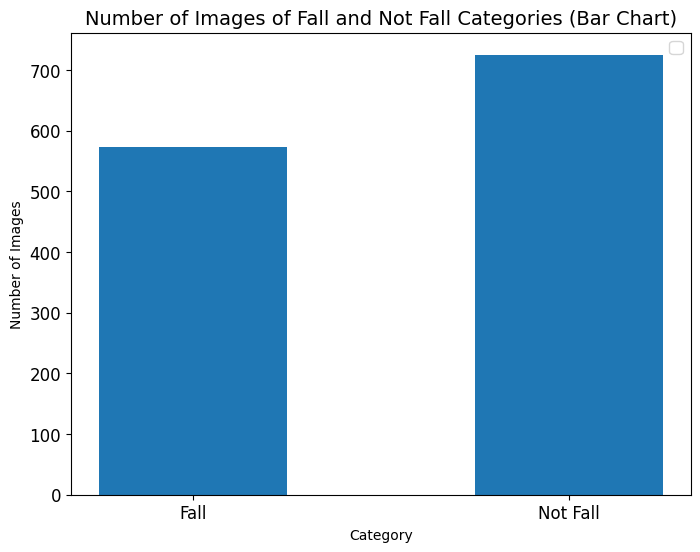

In [12]:
def plot_num_images_fall_not_fall_bar(fall_count, not_fall_count):
  fig, ax = plt.subplots(figsize=(8, 6))

  ax.bar(['Fall', 'Not Fall'], [fall_count, not_fall_count], width=0.5)
  ax.set_xlabel('Category')
  ax.set_ylabel('Number of Images')
  ax.set_title('Number of Images of Fall and Not Fall Categories (Bar Chart)')

  # Adjust the font sizes to make the plot more readable.
  ax.tick_params(labelsize=12)
  ax.legend(prop={'size': 12})
  ax.set_title(ax.get_title(), fontsize=14)

  # Show the plot.
  plt.show()

# Example usage:
fall_count = np.count_nonzero(columns1 == 1)
not_fall_count = np.count_nonzero(columns1 == 0)

plot_num_images_fall_not_fall_bar(fall_count, not_fall_count)

In [13]:
model = Sequential()
model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(256, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(384, (3, 3), activation='relu'))
model.add(Conv2D(384, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 26, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 384)         885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 6, 384)         1

In [7]:
X_train, y_train, X_val, y_val = train_test_split(edit_image, columns1, test_size=0.2, random_state=42)
model.fit(X_train, to_categorical(X_val, num_classes=2), validation_data=(y_train, to_categorical(y_val, num_classes=2)), epochs=20)

Epoch 1/20
33/33 [==============================] - 35s 974ms/step - loss: 0.6720 - accuracy: 0.5944 - val_loss: 0.5506 - val_accuracy: 0.7538
Epoch 2/20
33/33 [==============================] - 32s 967ms/step - loss: 0.6820 - accuracy: 0.6098 - val_loss: 0.6438 - val_accuracy: 0.6808
Epoch 3/20
33/33 [==============================] - 31s 948ms/step - loss: 0.6399 - accuracy: 0.6310 - val_loss: 0.6362 - val_accuracy: 0.6731
Epoch 4/20
33/33 [==============================] - 31s 936ms/step - loss: 0.6145 - accuracy: 0.6493 - val_loss: 0.6263 - val_accuracy: 0.5923
Epoch 5/20
33/33 [==============================] - 31s 953ms/step - loss: 0.5717 - accuracy: 0.6859 - val_loss: 0.4974 - val_accuracy: 0.7500
Epoch 6/20
33/33 [==============================] - 31s 938ms/step - loss: 0.5212 - accuracy: 0.7303 - val_loss: 0.5293 - val_accuracy: 0.7038
Epoch 7/20
33/33 [==============================] - 31s 941ms/step - loss: 0.4470 - accuracy: 0.7861 - val_loss: 0.5236 - val_accuracy: 0.7154

1/1 [==============================] - 0s 35ms/step


<Figure size 800x600 with 0 Axes>

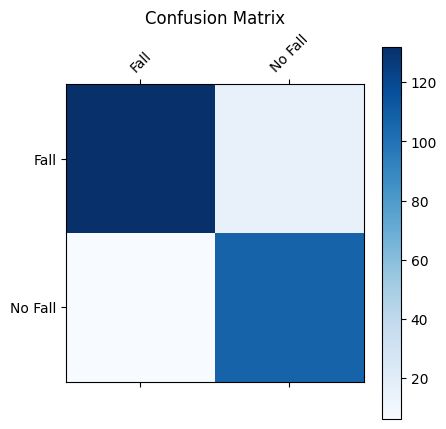

              precision    recall  f1-score   support

        Fall       0.96      0.90      0.93       147
     No Fall       0.88      0.95      0.91       113

    accuracy                           0.92       260
   macro avg       0.92      0.92      0.92       260
weighted avg       0.92      0.92      0.92       260



In [13]:
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    plt.matshow(cm, cmap='Blues')
    plt.colorbar()
    plt.xticks([0, 1], labels=labels, rotation=45)
    plt.yticks([0, 1], labels=labels)
    plt.title('Confusion Matrix')
    plt.show()

y_true = np.copy(y_val)
y_pred = []
for img in y_train:
    y_pred_0 = model.predict(np.expand_dims(img, axis=0))
    class_i = 0 if y_pred_0[0][0] > 0.5 else 1
    y_pred.append(class_i)
y_pred = np.array(y_pred)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, labels=["Fall", "No Fall"])
classification_report = classification_report(y_true, y_pred, target_names=["Fall", "No Fall"])
print(classification_report)

In [14]:
model_filename = "D:/model/fall_detection_model1.pk"
joblib.dump(model, model_filename)
print("Model saved as" + model_filename)

Model saved asD:/model/fall_detection_model1.pk


In [16]:
def grey_image(image):
    if image.dtype != 'uint8':
        image = (image * 255).astype('uint8')
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray_image

In [17]:
grey_images = []
for i in range(len(edit_image)):
    grey_images.append(grey_image(edit_image[i]))
grey_images = np.array(grey_images)

In [7]:
model = Sequential()
model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(224, 224, 1)))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(256, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(384, (3, 3), activation='relu'))
model.add(Conv2D(384, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        11712     
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 26, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 384)         885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 6, 384)         1

In [8]:
grey_images.shape

(1298, 224, 224)

In [10]:
X_train, y_train, X_val, y_val = train_test_split(grey_images, columns1, test_size=0.2, random_state=42)
model.fit(X_train, to_categorical(X_val, num_classes=2), validation_data=(y_train, to_categorical(y_val, num_classes=2)), epochs=10)

Epoch 1/10
33/33 [==============================] - 24s 724ms/step - loss: 0.3394 - accuracy: 0.8680 - val_loss: 0.4104 - val_accuracy: 0.8154
Epoch 2/10
33/33 [==============================] - 24s 715ms/step - loss: 0.2830 - accuracy: 0.9104 - val_loss: 0.4562 - val_accuracy: 0.8308
Epoch 3/10
33/33 [==============================] - 25s 750ms/step - loss: 0.2672 - accuracy: 0.8834 - val_loss: 0.3479 - val_accuracy: 0.8577
Epoch 4/10
33/33 [==============================] - 25s 758ms/step - loss: 0.2039 - accuracy: 0.9191 - val_loss: 0.4332 - val_accuracy: 0.8615
Epoch 5/10
33/33 [==============================] - 25s 755ms/step - loss: 0.1872 - accuracy: 0.9306 - val_loss: 0.4530 - val_accuracy: 0.8615
Epoch 6/10
33/33 [==============================] - 25s 761ms/step - loss: 0.1592 - accuracy: 0.9461 - val_loss: 0.3377 - val_accuracy: 0.8923
Epoch 7/10
33/33 [==============================] - 27s 809ms/step - loss: 0.4139 - accuracy: 0.8728 - val_loss: 0.4473 - val_accuracy: 0.8154

In [11]:
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    plt.matshow(cm, cmap='Blues')
    plt.colorbar()
    plt.xticks([0, 1], labels=labels, rotation=45)
    plt.yticks([0, 1], labels=labels)
    plt.title('Confusion Matrix')
    plt.show()

1/1 [==============================] - 0s 28ms/step


<Figure size 800x600 with 0 Axes>

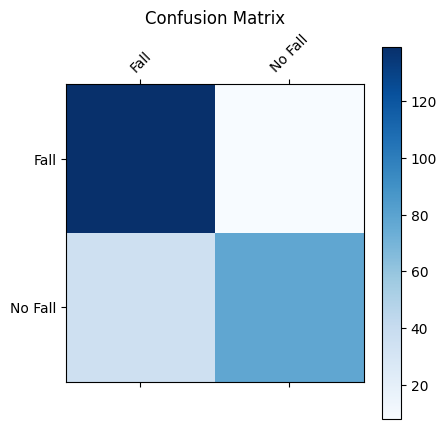

              precision    recall  f1-score   support

        Fall       0.80      0.95      0.87       147
     No Fall       0.91      0.69      0.78       113

    accuracy                           0.83       260
   macro avg       0.85      0.82      0.82       260
weighted avg       0.85      0.83      0.83       260



In [14]:
y_true = np.copy(y_val)
y_pred = []
for img in y_train:
    y_pred_0 = model.predict(np.expand_dims(img, axis=0))
    class_i = 0 if y_pred_0[0][0] > 0.5 else 1
    y_pred.append(class_i)
y_pred = np.array(y_pred)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, labels=["Fall", "No Fall"])
classification_report = classification_report(y_true, y_pred, target_names=["Fall", "No Fall"])
print(classification_report)

In [15]:
model_filename = "D:/model/grey_fall_detection_model1.pk"
joblib.dump(model, model_filename)
print("Model saved as" + model_filename)

Model saved asD:/model/grey_fall_detection_model1.pk


In [2]:
import joblib
model_filename = "D:/model/fall_detection_model.pk"
model = joblib.load(model_filename)

In [3]:
from PIL import Image

In [4]:
def predict_image(image):
    img = np.copy(image)
    if img.any():
        img = cv2.resize(img, (224, 224)) 
        img = img / 255.0  
    
        # Make a prediction
        prediction = model.predict(np.expand_dims(img, axis=0))
    
        # Convert the prediction to a class label
        class_label = "No Fall" if prediction[0][0] > 0.5 else "Fall"
    
        return prediction[0][0]
    return 0.1

In [5]:
import ultralytics
from ultralytics import YOLO
import math

In [6]:
model2 = YOLO('yolov8n.pt')

In [7]:
model3 = YOLO('model_fall2.pt')

In [8]:
from sort.sort import *
mot_tracker = Sort()

In [12]:
# video = cv2.VideoCapture("/Users/gdiva/Downloads/walking.mp4")
video = cv2.VideoCapture("/Users/gdiva/Downloads/gettyimages-1286237053-640_adpp.mp4")
while True:

    # Read the next frame from the video sequence
    ret, frame = video.read()

    # If the frame is empty, break out of the loop
    if not ret:
        print(1)
        break

    result = model2(frame, stream=True)
    detections = np.empty((0,5))
    for r in result:
        boxes = r.boxes
        for box in boxes:
            class_id = r.names[box.cls[0].item()]
            if (class_id == 'person') :
                conf = math.ceil(box.conf[0]*100)/100
                if (conf>0.4):
                    x1, y1, x2, y2 = box.xyxy[0]
                    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                    current_array = np.array([x1,y1,x2,y2,conf])
                    detections = np.vstack((detections, current_array))

    resultTracker = mot_tracker.update(detections)
    class_labels = []
    for r in resultTracker:
        x1, y1, x2, y2, id = r
        x1, y1, x2, y2, id = int(x1), int(y1), int(x2), int(y2), int(id)
        image = np.copy(frame[y1:y2, x1:x2])
        cv2.rectangle(frame, (x1,y1), (x2,y2), [0,0,255], 2)
        predictions = model3(image, stream=True)
        for pred in predictions:
            boxes = pred.boxes
            for box in boxes:
                if (box.conf < 0.3):
                    class_labels.append('fall')
                else:
                    class_labels.append('no fall')
                print(box)

    # result = model3(frame, stream=True)
    # detections = np.empty((0,5))
    # class_labels = []
    # for r in result:
    #     boxes = r.boxes
    #     for box in boxes:
    #         if (box.conf > 0.3):
    #             class_labels.append('no fall')
    #         else:
    #             class_labels.append('fall')
    #         print(box)
        
    print('---------------------------------------------------------------------------------------------------------------------------')
    class_labels = np.array(class_labels)
    if np.any(class_labels == 'fall'):
        frame = cv2.putText(frame, "Fall", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    else:
        frame = cv2.putText(frame, "No Fall", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    cv2.imshow('Detected Faces', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object
video.release()

# Destroy all windows
cv2.destroyAllWindows()


0: 384x640 2 persons, 1 cup, 2 dining tables, 3 laptops, 2 mouses, 1 remote, 1 cell phone, 1 book, 115.9ms
Speed: 5.6ms preprocess, 115.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x320 1 -1, 93.3ms
Speed: 4.4ms preprocess, 93.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)

0: 384x640 2 persons, 1 cup, 2 dining tables, 3 laptops, 2 mouses, 1 remote, 1 cell phone, 1 book, 134.3ms
Speed: 1.9ms preprocess, 134.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.7228])
data: tensor([[  0.7283,  46.4086, 114.0000, 196.5595,   0.7228,   0.0000]])
id: None
is_track: False
orig_shape: (232, 114)
shape: torch.Size([1, 6])
xywh: tensor([[ 57.3642, 121.4840, 113.2717, 150.1509]])
xywhn: tensor([[0.5032, 0.5236, 0.9936, 0.6472]])
xyxy: tensor([[  0.7283,  46.4086, 114.0000, 196.5595]])
xyxyn: tensor([[0.0064, 0.2000, 1.0000, 0.8472]])
---------------------------------------------------------------------------------------------------------------------------



0: 640x384 2 -1s, 108.4ms
Speed: 3.1ms preprocess, 108.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 2 persons, 1 cup, 2 dining tables, 3 laptops, 2 mouses, 1 remote, 1 cell phone, 1 book, 106.7ms
Speed: 2.0ms preprocess, 106.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.6881])
data: tensor([[ 16.1523,  36.8054, 113.0000, 189.7759,   0.6881,   0.0000]])
id: None
is_track: False
orig_shape: (195, 113)
shape: torch.Size([1, 6])
xywh: tensor([[ 64.5761, 113.2906,  96.8477, 152.9705]])
xywhn: tensor([[0.5715, 0.5810, 0.8571, 0.7845]])
xyxy: tensor([[ 16.1523,  36.8054, 113.0000, 189.7759]])
xyxyn: tensor([[0.1429, 0.1887, 1.0000, 0.9732]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2854])
data: tensor([[  8.1337,  37.2231, 107.2488, 159.2812,   0.2854,   0.0000]])
id: None
is_track: False
orig_shape: (195, 113)
shape: torch.Size([1, 6])
xywh: tensor([[ 57.6912,  98.2521,  99.1151, 122.0581]])
xywhn: tensor([[0.5105, 0.5039, 0.8771, 0.6259]])
xyxy: tensor([[  8.1337,  37.2231, 107.2488, 159.2812]])
xyxyn: tensor([[0.0720, 0.1909, 0.9491, 0.8168]])
------------------------------------------------------------------------

0: 640x416 1 -1, 139.5ms
Speed: 0.0ms preprocess, 139.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 384x640 2 persons, 1 cup, 2 dining tables, 3 laptops, 2 mouses, 1 remote, 1 cell phone, 1 book, 106.7ms
Speed: 5.0ms preprocess, 106.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.6911])
data: tensor([[  6.0163,  29.3245, 111.0000, 165.1470,   0.6911,   0.0000]])
id: None
is_track: False
orig_shape: (171, 111)
shape: torch.Size([1, 6])
xywh: tensor([[ 58.5081,  97.2358, 104.9837, 135.8225]])
xywhn: tensor([[0.5271, 0.5686, 0.9458, 0.7943]])
xyxy: tensor([[  6.0163,  29.3245, 111.0000, 165.1470]])
xyxyn: tensor([[0.0542, 0.1715, 1.0000, 0.9658]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x640 3 -1s, 191.2ms
Speed: 5.1ms preprocess, 191.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 1 -1, 160.7ms
Speed: 12.9ms preprocess, 160.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4660])
data: tensor([[ 0.0000,  0.0000, 45.8189, 65.3115,  0.4660,  0.0000]])
id: None
is_track: False
orig_shape: (71, 73)
shape: torch.Size([1, 6])
xywh: tensor([[22.9094, 32.6558, 45.8189, 65.3115]])
xywhn: tensor([[0.3138, 0.4599, 0.6277, 0.9199]])
xyxy: tensor([[ 0.0000,  0.0000, 45.8189, 65.3115]])
xyxyn: tensor([[0.0000, 0.0000, 0.6277, 0.9199]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3293])
data: tensor([[ 0.1067,  1.7050, 30.9019, 64.1386,  0.3293,  0.0000]])
id: None
is_track: False
orig_shape: (71, 73)
shape: torch.Size([1, 6])
xywh: tensor([[15.5043, 32.9218, 30.7951, 62.4337]])
xywhn: tensor([[0.2124, 0.4637, 0.4219, 0.8793]])
xyxy: tensor([[ 0.1067,  1.7050, 30.9019, 64.1386]])
xyxyn: tensor([[0.0015, 0.0240, 0.4233, 0.9034]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2734])
data:


0: 384x640 2 persons, 1 cup, 2 dining tables, 3 laptops, 2 mouses, 1 remote, 1 cell phone, 1 book, 122.9ms
Speed: 0.0ms preprocess, 122.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x640 1 -1, 148.9ms
Speed: 10.9ms preprocess, 148.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 1 -1, 120.7ms
Speed: 0.0ms preprocess, 120.7ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 480)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4472])
data: tensor([[ 0.0000,  0.0000, 47.3419, 63.5707,  0.4472,  0.0000]])
id: None
is_track: False
orig_shape: (71, 69)
shape: torch.Size([1, 6])
xywh: tensor([[23.6710, 31.7853, 47.3419, 63.5707]])
xywhn: tensor([[0.3431, 0.4477, 0.6861, 0.8954]])
xyxy: tensor([[ 0.0000,  0.0000, 47.3419, 63.5707]])
xyxyn: tensor([[0.0000, 0.0000, 0.6861, 0.8954]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5259])
data: tensor([[  4.5250,  15.3708,  94.7935, 124.2804,   0.5259,   0.0000]])
id: None
is_track: False
orig_shape: (142, 106)
shape: torch.Size([1, 6])
xywh: tensor([[ 49.6592,  69.8256,  90.2685, 108.9096]])
xywhn: tensor([[0.4685, 0.4917, 0.8516, 0.7670]])
xyxy: tensor([[  4.5250,  15.3708,  94.7935, 124.2804]])
xyxyn: tensor([[0.0427, 0.1082, 0.8943, 0.8752]])
----------------------------------------------------------------------------------------

0: 384x640 2 persons, 1 cup, 2 dining tables, 3 laptops, 2 mouses, 1 remote, 1 cell phone, 1 book, 97.0ms
Speed: 2.5ms preprocess, 97.0ms inference, 11.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x640 2 -1s, 157.4ms
Speed: 3.1ms preprocess, 157.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x512 2 -1s, 131.0ms
Speed: 0.0ms preprocess, 131.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3814])
data: tensor([[26.0169,  3.0272, 67.0000, 67.8768,  0.3814,  0.0000]])
id: None
is_track: False
orig_shape: (69, 67)
shape: torch.Size([1, 6])
xywh: tensor([[46.5084, 35.4520, 40.9831, 64.8495]])
xywhn: tensor([[0.6942, 0.5138, 0.6117, 0.9398]])
xyxy: tensor([[26.0169,  3.0272, 67.0000, 67.8768]])
xyxyn: tensor([[0.3883, 0.0439, 1.0000, 0.9837]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3259])
data: tensor([[ 0.1510,  0.4013, 34.0567, 67.2082,  0.3259,  0.0000]])
id: None
is_track: False
orig_shape: (69, 67)
shape: torch.Size([1, 6])
xywh: tensor([[17.1038, 33.8047, 33.9057, 66.8068]])
xywhn: tensor([[0.2553, 0.4899, 0.5061, 0.9682]])
xyxy: tensor([[ 0.1510,  0.4013, 34.0567, 67.2082]])
xyxyn: tensor([[0.0023, 0.0058, 0.5083, 0.9740]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.6032])
data:

0: 384x640 2 persons, 1 cup, 2 dining tables, 3 laptops, 2 mouses, 1 remote, 1 cell phone, 1 book, 122.1ms
Speed: 0.0ms preprocess, 122.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x640 2 -1s, 158.9ms
Speed: 8.1ms preprocess, 158.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x544 1 -1, 148.8ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4138])
data: tensor([[ 0.0000,  0.0000, 45.9032, 64.3330,  0.4138,  0.0000]])
id: None
is_track: False
orig_shape: (71, 73)
shape: torch.Size([1, 6])
xywh: tensor([[22.9516, 32.1665, 45.9032, 64.3330]])
xywhn: tensor([[0.3144, 0.4530, 0.6288, 0.9061]])
xyxy: tensor([[ 0.0000,  0.0000, 45.9032, 64.3330]])
xyxyn: tensor([[0.0000, 0.0000, 0.6288, 0.9061]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3349])
data: tensor([[2.6845e-02, 1.3571e+00, 3.0147e+01, 6.3260e+01, 3.3493e-01, 0.0000e+00]])
id: None
is_track: False
orig_shape: (71, 73)
shape: torch.Size([1, 6])
xywh: tensor([[15.0867, 32.3085, 30.1197, 61.9028]])
xywhn: tensor([[0.2067, 0.4550, 0.4126, 0.8719]])
xyxy: tensor([[2.6845e-02, 1.3571e+00, 3.0147e+01, 6.3260e+01]])
xyxyn: tensor([[3.6774e-04, 1.9114e-02, 4.1297e-01, 8.9098e-01]])
ultralytics.engine.results.Boxes object with attributes:



Speed: 2.3ms preprocess, 148.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 384x640 2 persons, 1 cup, 2 dining tables, 3 laptops, 2 mouses, 1 remote, 1 cell phone, 1 book, 89.3ms
Speed: 3.3ms preprocess, 89.3ms inference, 15.7ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x640 1 -1, 1 1, 157.2ms
Speed: 6.1ms preprocess, 157.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x544 1 -1, 136.7ms
Speed: 7.0ms preprocess, 136.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4571])
data: tensor([[ 0.0000,  0.9248, 46.2722, 66.9650,  0.4571,  0.0000]])
id: None
is_track: False
orig_shape: (73, 75)
shape: torch.Size([1, 6])
xywh: tensor([[23.1361, 33.9449, 46.2722, 66.0402]])
xywhn: tensor([[0.3085, 0.4650, 0.6170, 0.9047]])
xyxy: tensor([[ 0.0000,  0.9248, 46.2722, 66.9650]])
xyxyn: tensor([[0.0000, 0.0127, 0.6170, 0.9173]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1.])
conf: tensor([0.3247])
data: tensor([[27.4497, 59.0139, 74.9206, 72.7890,  0.3247,  1.0000]])
id: None
is_track: False
orig_shape: (73, 75)
shape: torch.Size([1, 6])
xywh: tensor([[51.1852, 65.9015, 47.4709, 13.7751]])
xywhn: tensor([[0.6825, 0.9028, 0.6329, 0.1887]])
xyxy: tensor([[27.4497, 59.0139, 74.9206, 72.7890]])
xyxyn: tensor([[0.3660, 0.8084, 0.9989, 0.9971]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4265])
data:

0: 384x640 2 persons, 1 cup, 2 dining tables, 3 laptops, 2 mouses, 1 remote, 1 cell phone, 1 book, 127.3ms
Speed: 3.3ms preprocess, 127.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 640x640 2 -1s, 1 1, 167.6ms
Speed: 2.2ms preprocess, 167.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x576 1 -1, 168.2ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4991])
data: tensor([[ 0.0000,  0.4869, 47.0653, 66.5772,  0.4991,  0.0000]])
id: None
is_track: False
orig_shape: (73, 76)
shape: torch.Size([1, 6])
xywh: tensor([[23.5327, 33.5320, 47.0653, 66.0904]])
xywhn: tensor([[0.3096, 0.4593, 0.6193, 0.9053]])
xyxy: tensor([[ 0.0000,  0.4869, 47.0653, 66.5772]])
xyxyn: tensor([[0.0000, 0.0067, 0.6193, 0.9120]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2826])
data: tensor([[15.2627,  0.0000, 52.9097, 67.2048,  0.2826,  0.0000]])
id: None
is_track: False
orig_shape: (73, 76)
shape: torch.Size([1, 6])
xywh: tensor([[34.0862, 33.6024, 37.6470, 67.2048]])
xywhn: tensor([[0.4485, 0.4603, 0.4954, 0.9206]])
xyxy: tensor([[15.2627,  0.0000, 52.9097, 67.2048]])
xyxyn: tensor([[0.2008, 0.0000, 0.6962, 0.9206]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1.])
conf: tensor([0.2607])
data:

Speed: 8.2ms preprocess, 168.2ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 576)

0: 384x640 2 persons, 1 cup, 2 dining tables, 3 laptops, 2 mouses, 1 remote, 1 cell phone, 1 book, 109.1ms
Speed: 0.0ms preprocess, 109.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x640 2 -1s, 168.4ms
Speed: 5.2ms preprocess, 168.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x576 2 -1s, 153.1ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4925])
data: tensor([[ 0.0000,  0.0000, 49.1698, 64.7268,  0.4925,  0.0000]])
id: None
is_track: False
orig_shape: (71, 72)
shape: torch.Size([1, 6])
xywh: tensor([[24.5849, 32.3634, 49.1698, 64.7268]])
xywhn: tensor([[0.3415, 0.4558, 0.6829, 0.9116]])
xyxy: tensor([[ 0.0000,  0.0000, 49.1698, 64.7268]])
xyxyn: tensor([[0.0000, 0.0000, 0.6829, 0.9116]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3312])
data: tensor([[17.8021,  2.7848, 70.1147, 67.6004,  0.3312,  0.0000]])
id: None
is_track: False
orig_shape: (71, 72)
shape: torch.Size([1, 6])
xywh: tensor([[43.9584, 35.1926, 52.3126, 64.8157]])
xywhn: tensor([[0.6105, 0.4957, 0.7266, 0.9129]])
xyxy: tensor([[17.8021,  2.7848, 70.1147, 67.6004]])
xyxyn: tensor([[0.2473, 0.0392, 0.9738, 0.9521]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3729])
data:

Speed: 13.4ms preprocess, 153.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 384x640 2 persons, 1 cup, 2 dining tables, 3 laptops, 2 mouses, 1 remote, 1 cell phone, 1 book, 125.1ms
Speed: 4.6ms preprocess, 125.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x640 2 -1s, 155.9ms
Speed: 0.0ms preprocess, 155.9ms inference, 12.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x576 1 -1, 155.6ms
Speed: 9.0ms preprocess, 155.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4058])
data: tensor([[1.1382e-02, 0.0000e+00, 4.8501e+01, 6.4855e+01, 4.0576e-01, 0.0000e+00]])
id: None
is_track: False
orig_shape: (71, 70)
shape: torch.Size([1, 6])
xywh: tensor([[24.2560, 32.4274, 48.4893, 64.8547]])
xywhn: tensor([[0.3465, 0.4567, 0.6927, 0.9134]])
xyxy: tensor([[1.1382e-02, 0.0000e+00, 4.8501e+01, 6.4855e+01]])
xyxyn: tensor([[1.6260e-04, 0.0000e+00, 6.9287e-01, 9.1345e-01]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3615])
data: tensor([[20.3260,  3.3678, 68.5816, 68.4461,  0.3615,  0.0000]])
id: None
is_track: False
orig_shape: (71, 70)
shape: torch.Size([1, 6])
xywh: tensor([[44.4538, 35.9070, 48.2556, 65.0784]])
xywhn: tensor([[0.6351, 0.5057, 0.6894, 0.9166]])
xyxy: tensor([[20.3260,  3.3678, 68.5816, 68.4461]])
xyxyn: tensor([[0.2904, 0.0474, 0.9797, 0.9640]])
ultralytics.engine.results.Boxes object with attributes:



0: 384x640 2 persons, 1 cup, 2 dining tables, 3 laptops, 2 mouses, 1 remote, 1 cell phone, 1 book, 99.0ms
Speed: 0.0ms preprocess, 99.0ms inference, 15.6ms postprocess per image at shape (1, 3, 384, 640)

0: 640x608 3 -1s, 192.4ms
Speed: 0.0ms preprocess, 192.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 640x576 2 -1s, 137.5ms
Speed: 5.7ms preprocess, 137.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4151])
data: tensor([[22.5273,  3.1438, 67.0000, 68.6728,  0.4151,  0.0000]])
id: None
is_track: False
orig_shape: (71, 67)
shape: torch.Size([1, 6])
xywh: tensor([[44.7636, 35.9083, 44.4727, 65.5290]])
xywhn: tensor([[0.6681, 0.5058, 0.6638, 0.9229]])
xyxy: tensor([[22.5273,  3.1438, 67.0000, 68.6728]])
xyxyn: tensor([[0.3362, 0.0443, 1.0000, 0.9672]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2966])
data: tensor([[ 0.8698,  2.0013, 45.4931, 64.7481,  0.2966,  0.0000]])
id: None
is_track: False
orig_shape: (71, 67)
shape: torch.Size([1, 6])
xywh: tensor([[23.1814, 33.3747, 44.6234, 62.7469]])
xywhn: tensor([[0.3460, 0.4701, 0.6660, 0.8838]])
xyxy: tensor([[ 0.8698,  2.0013, 45.4931, 64.7481]])
xyxyn: tensor([[0.0130, 0.0282, 0.6790, 0.9119]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2592])
data:

0: 384x640 2 persons, 1 cup, 2 dining tables, 3 laptops, 2 mouses, 1 remote, 1 cell phone, 1 book, 116.6ms
Speed: 0.0ms preprocess, 116.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x608 3 -1s, 158.7ms
Speed: 2.0ms preprocess, 158.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 640x608 1 -1, 144.0ms
Speed: 8.6ms preprocess, 144.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4101])
data: tensor([[24.9791,  2.8976, 65.0000, 68.8316,  0.4101,  0.0000]])
id: None
is_track: False
orig_shape: (71, 65)
shape: torch.Size([1, 6])
xywh: tensor([[44.9895, 35.8646, 40.0209, 65.9340]])
xywhn: tensor([[0.6921, 0.5051, 0.6157, 0.9286]])
xyxy: tensor([[24.9791,  2.8976, 65.0000, 68.8316]])
xyxyn: tensor([[0.3843, 0.0408, 1.0000, 0.9695]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3740])
data: tensor([[ 0.0000,  0.5203, 46.6006, 68.2503,  0.3740,  0.0000]])
id: None
is_track: False
orig_shape: (71, 65)
shape: torch.Size([1, 6])
xywh: tensor([[23.3003, 34.3853, 46.6006, 67.7300]])
xywhn: tensor([[0.3585, 0.4843, 0.7169, 0.9539]])
xyxy: tensor([[ 0.0000,  0.5203, 46.6006, 68.2503]])
xyxyn: tensor([[0.0000, 0.0073, 0.7169, 0.9613]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3057])
data:

0: 384x640 2 persons, 1 cup, 2 dining tables, 3 laptops, 2 mouses, 1 remote, 1 cell phone, 1 book, 96.2ms
Speed: 0.0ms preprocess, 96.2ms inference, 15.6ms postprocess per image at shape (1, 3, 384, 640)

0: 640x576 2 -1s, 148.9ms
Speed: 2.7ms preprocess, 148.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 640x608 1 -1, 160.9ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4303])
data: tensor([[ 0.1867,  0.0000, 48.0874, 64.8304,  0.4303,  0.0000]])
id: None
is_track: False
orig_shape: (71, 63)
shape: torch.Size([1, 6])
xywh: tensor([[24.1370, 32.4152, 47.9008, 64.8304]])
xywhn: tensor([[0.3831, 0.4566, 0.7603, 0.9131]])
xyxy: tensor([[ 0.1867,  0.0000, 48.0874, 64.8304]])
xyxyn: tensor([[0.0030, 0.0000, 0.7633, 0.9131]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3596])
data: tensor([[26.8676,  2.8622, 63.0000, 68.9865,  0.3596,  0.0000]])
id: None
is_track: False
orig_shape: (71, 63)
shape: torch.Size([1, 6])
xywh: tensor([[44.9338, 35.9243, 36.1324, 66.1243]])
xywhn: tensor([[0.7132, 0.5060, 0.5735, 0.9313]])
xyxy: tensor([[26.8676,  2.8622, 63.0000, 68.9865]])
xyxyn: tensor([[0.4265, 0.0403, 1.0000, 0.9716]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3360])
data:

Speed: 8.5ms preprocess, 160.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 384x640 2 persons, 1 cup, 2 dining tables, 3 laptops, 1 mouse, 1 remote, 1 cell phone, 1 book, 96.3ms
Speed: 0.0ms preprocess, 96.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x576 1 -1, 163.7ms
Speed: 6.3ms preprocess, 163.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 640x608 1 -1, 151.9ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4955])
data: tensor([[ 0.0000,  0.0000, 47.3033, 63.2256,  0.4955,  0.0000]])
id: None
is_track: False
orig_shape: (71, 62)
shape: torch.Size([1, 6])
xywh: tensor([[23.6517, 31.6128, 47.3033, 63.2256]])
xywhn: tensor([[0.3815, 0.4453, 0.7630, 0.8905]])
xyxy: tensor([[ 0.0000,  0.0000, 47.3033, 63.2256]])
xyxyn: tensor([[0.0000, 0.0000, 0.7630, 0.8905]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3224])
data: tensor([[ 23.5007,   0.0000,  78.1303, 108.4225,   0.3224,   0.0000]])
id: None
is_track: False
orig_shape: (114, 104)
shape: torch.Size([1, 6])
xywh: tensor([[ 50.8155,  54.2112,  54.6296, 108.4225]])
xywhn: tensor([[0.4886, 0.4755, 0.5253, 0.9511]])
xyxy: tensor([[ 23.5007,   0.0000,  78.1303, 108.4225]])
xyxyn: tensor([[0.2260, 0.0000, 0.7513, 0.9511]])


Speed: 13.9ms preprocess, 151.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 384x640 2 persons, 1 cup, 2 dining tables, 2 laptops, 1 mouse, 1 remote, 1 cell phone, 1 book, 108.2ms
Speed: 1.6ms preprocess, 108.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x576 3 -1s, 136.2ms
Speed: 5.7ms preprocess, 136.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 640x608 1 -1, 157.7ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4028])
data: tensor([[ 0.0000,  0.0000, 46.2252, 64.6447,  0.4028,  0.0000]])
id: None
is_track: False
orig_shape: (71, 61)
shape: torch.Size([1, 6])
xywh: tensor([[23.1126, 32.3223, 46.2252, 64.6447]])
xywhn: tensor([[0.3789, 0.4552, 0.7578, 0.9105]])
xyxy: tensor([[ 0.0000,  0.0000, 46.2252, 64.6447]])
xyxyn: tensor([[0.0000, 0.0000, 0.7578, 0.9105]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3491])
data: tensor([[28.3209,  4.2484, 61.0000, 68.5298,  0.3491,  0.0000]])
id: None
is_track: False
orig_shape: (71, 61)
shape: torch.Size([1, 6])
xywh: tensor([[44.6605, 36.3891, 32.6791, 64.2814]])
xywhn: tensor([[0.7321, 0.5125, 0.5357, 0.9054]])
xyxy: tensor([[28.3209,  4.2484, 61.0000, 68.5298]])
xyxyn: tensor([[0.4643, 0.0598, 1.0000, 0.9652]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2731])
data:

Speed: 10.0ms preprocess, 157.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 384x640 2 persons, 1 cup, 2 dining tables, 3 laptops, 1 mouse, 1 remote, 1 cell phone, 1 book, 121.0ms
Speed: 0.0ms preprocess, 121.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x544 2 -1s, 143.2ms
Speed: 3.8ms preprocess, 143.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x608 1 -1, 148.0ms
Speed: 4.2ms preprocess, 148.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4530])
data: tensor([[ 0.0000,  0.0000, 47.7894, 63.3332,  0.4530,  0.0000]])
id: None
is_track: False
orig_shape: (71, 60)
shape: torch.Size([1, 6])
xywh: tensor([[23.8947, 31.6666, 47.7894, 63.3332]])
xywhn: tensor([[0.3982, 0.4460, 0.7965, 0.8920]])
xyxy: tensor([[ 0.0000,  0.0000, 47.7894, 63.3332]])
xyxyn: tensor([[0.0000, 0.0000, 0.7965, 0.8920]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3100])
data: tensor([[ 0.0000,  1.7778, 34.5730, 62.8406,  0.3100,  0.0000]])
id: None
is_track: False
orig_shape: (71, 60)
shape: torch.Size([1, 6])
xywh: tensor([[17.2865, 32.3092, 34.5730, 61.0629]])
xywhn: tensor([[0.2881, 0.4551, 0.5762, 0.8600]])
xyxy: tensor([[ 0.0000,  1.7778, 34.5730, 62.8406]])
xyxyn: tensor([[0.0000, 0.0250, 0.5762, 0.8851]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4451])
data:

0: 384x640 2 persons, 1 cup, 2 dining tables, 2 laptops, 1 mouse, 1 remote, 1 cell phone, 1 book, 114.1ms
Speed: 0.0ms preprocess, 114.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x544 3 -1s, 143.2ms
Speed: 0.0ms preprocess, 143.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x608 1 -1, 160.2ms
Speed: 16.5ms preprocess, 160.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4493])
data: tensor([[ 0.0000,  0.0000, 46.5738, 63.4898,  0.4493,  0.0000]])
id: None
is_track: False
orig_shape: (71, 59)
shape: torch.Size([1, 6])
xywh: tensor([[23.2869, 31.7449, 46.5738, 63.4898]])
xywhn: tensor([[0.3947, 0.4471, 0.7894, 0.8942]])
xyxy: tensor([[ 0.0000,  0.0000, 46.5738, 63.4898]])
xyxyn: tensor([[0.0000, 0.0000, 0.7894, 0.8942]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3093])
data: tensor([[ 0.0000,  5.1010, 33.4719, 66.9813,  0.3093,  0.0000]])
id: None
is_track: False
orig_shape: (71, 59)
shape: torch.Size([1, 6])
xywh: tensor([[16.7359, 36.0411, 33.4719, 61.8802]])
xywhn: tensor([[0.2837, 0.5076, 0.5673, 0.8716]])
xyxy: tensor([[ 0.0000,  5.1010, 33.4719, 66.9813]])
xyxyn: tensor([[0.0000, 0.0718, 0.5673, 0.9434]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2999])
data:

0: 384x640 2 persons, 1 cup, 2 dining tables, 2 laptops, 1 mouse, 1 remote, 1 cell phone, 1 book, 97.3ms
Speed: 0.0ms preprocess, 97.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x544 3 -1s, 135.1ms
Speed: 6.8ms preprocess, 135.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4152])
data: tensor([[ 0.0000,  0.0000, 46.7683, 63.5811,  0.4152,  0.0000]])
id: None
is_track: False
orig_shape: (71, 59)
shape: torch.Size([1, 6])
xywh: tensor([[23.3841, 31.7906, 46.7683, 63.5811]])
xywhn: tensor([[0.3963, 0.4478, 0.7927, 0.8955]])
xyxy: tensor([[ 0.0000,  0.0000, 46.7683, 63.5811]])
xyxyn: tensor([[0.0000, 0.0000, 0.7927, 0.8955]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3442])
data: tensor([[27.7120,  8.6274, 59.0000, 68.8206,  0.3442,  0.0000]])
id: None
is_track: False
orig_shape: (71, 59)
shape: torch.Size([1, 6])
xywh: tensor([[43.3560, 38.7240, 31.2880, 60.1931]])
xywhn: tensor([[0.7348, 0.5454, 0.5303, 0.8478]])
xyxy: tensor([[27.7120,  8.6274, 59.0000, 68.8206]])
xyxyn: tensor([[0.4697, 0.1215, 1.0000, 0.9693]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2560])
data:

0: 640x608 2 -1s, 162.8ms
Speed: 3.2ms preprocess, 162.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 384x640 2 persons, 1 cup, 2 dining tables, 2 laptops, 1 mouse, 1 remote, 1 cell phone, 1 book, 103.0ms
Speed: 3.6ms preprocess, 103.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3181])
data: tensor([[ 22.2780,   0.0000, 108.0000, 109.7946,   0.3181,   0.0000]])
id: None
is_track: False
orig_shape: (116, 108)
shape: torch.Size([1, 6])
xywh: tensor([[ 65.1390,  54.8973,  85.7220, 109.7946]])
xywhn: tensor([[0.6031, 0.4733, 0.7937, 0.9465]])
xyxy: tensor([[ 22.2780,   0.0000, 108.0000, 109.7946]])
xyxyn: tensor([[0.2063, 0.0000, 1.0000, 0.9465]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2859])
data: tensor([[ 26.5391,   0.0000,  81.5736, 109.8967,   0.2859,   0.0000]])
id: None
is_track: False
orig_shape: (116, 108)
shape: torch.Size([1, 6])
xywh: tensor([[ 54.0564,  54.9483,  55.0345, 109.8967]])
xywhn: tensor([[0.5005, 0.4737, 0.5096, 0.9474]])
xyxy: tensor([[ 26.5391,   0.0000,  81.5736, 109.8967]])
xyxyn: tensor([[0.2457, 0.0000, 0.7553, 0.9474]])
------------------------------------------------------------------------

0: 640x544 3 -1s, 146.0ms
Speed: 0.9ms preprocess, 146.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x608 3 -1s, 158.1ms
Speed: 4.1ms preprocess, 158.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3443])
data: tensor([[24.0064,  5.0116, 59.0000, 68.8152,  0.3443,  0.0000]])
id: None
is_track: False
orig_shape: (71, 59)
shape: torch.Size([1, 6])
xywh: tensor([[41.5032, 36.9134, 34.9936, 63.8037]])
xywhn: tensor([[0.7034, 0.5199, 0.5931, 0.8986]])
xyxy: tensor([[24.0064,  5.0116, 59.0000, 68.8152]])
xyxyn: tensor([[0.4069, 0.0706, 1.0000, 0.9692]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3401])
data: tensor([[ 0.0000,  0.0000, 47.1573, 64.7108,  0.3401,  0.0000]])
id: None
is_track: False
orig_shape: (71, 59)
shape: torch.Size([1, 6])
xywh: tensor([[23.5786, 32.3554, 47.1573, 64.7108]])
xywhn: tensor([[0.3996, 0.4557, 0.7993, 0.9114]])
xyxy: tensor([[ 0.0000,  0.0000, 47.1573, 64.7108]])
xyxyn: tensor([[0.0000, 0.0000, 0.7993, 0.9114]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3061])
data:


0: 384x640 2 persons, 1 cup, 2 dining tables, 2 laptops, 1 mouse, 1 remote, 1 cell phone, 1 book, 110.4ms
Speed: 0.0ms preprocess, 110.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x544 2 -1s, 137.4ms
Speed: 3.4ms preprocess, 137.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x608 2 -1s, 157.9ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4152])
data: tensor([[ 0.0000,  0.0000, 46.7581, 64.1598,  0.4152,  0.0000]])
id: None
is_track: False
orig_shape: (71, 58)
shape: torch.Size([1, 6])
xywh: tensor([[23.3791, 32.0799, 46.7581, 64.1598]])
xywhn: tensor([[0.4031, 0.4518, 0.8062, 0.9037]])
xyxy: tensor([[ 0.0000,  0.0000, 46.7581, 64.1598]])
xyxyn: tensor([[0.0000, 0.0000, 0.8062, 0.9037]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2804])
data: tensor([[ 0.0000,  0.8335, 33.9763, 65.9643,  0.2804,  0.0000]])
id: None
is_track: False
orig_shape: (71, 58)
shape: torch.Size([1, 6])
xywh: tensor([[16.9882, 33.3989, 33.9763, 65.1308]])
xywhn: tensor([[0.2929, 0.4704, 0.5858, 0.9173]])
xyxy: tensor([[ 0.0000,  0.8335, 33.9763, 65.9643]])
xyxyn: tensor([[0.0000, 0.0117, 0.5858, 0.9291]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3295])
data:

Speed: 8.8ms preprocess, 157.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 384x640 2 persons, 1 cup, 2 dining tables, 2 laptops, 1 mouse, 1 remote, 1 cell phone, 1 book, 90.3ms
Speed: 4.8ms preprocess, 90.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x544 2 -1s, 139.0ms
Speed: 3.8ms preprocess, 139.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x608 2 -1s, 152.1ms
Speed: 20.3ms preprocess, 152.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4121])
data: tensor([[ 0.0000,  0.0000, 46.7018, 64.1636,  0.4121,  0.0000]])
id: None
is_track: False
orig_shape: (71, 58)
shape: torch.Size([1, 6])
xywh: tensor([[23.3509, 32.0818, 46.7018, 64.1636]])
xywhn: tensor([[0.4026, 0.4519, 0.8052, 0.9037]])
xyxy: tensor([[ 0.0000,  0.0000, 46.7018, 64.1636]])
xyxyn: tensor([[0.0000, 0.0000, 0.8052, 0.9037]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2751])
data: tensor([[ 0.0000,  0.9231, 33.9714, 66.1171,  0.2751,  0.0000]])
id: None
is_track: False
orig_shape: (71, 58)
shape: torch.Size([1, 6])
xywh: tensor([[16.9857, 33.5201, 33.9714, 65.1941]])
xywhn: tensor([[0.2929, 0.4721, 0.5857, 0.9182]])
xyxy: tensor([[ 0.0000,  0.9231, 33.9714, 66.1171]])
xyxyn: tensor([[0.0000, 0.0130, 0.5857, 0.9312]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3382])
data:

0: 384x640 2 persons, 1 cup, 2 dining tables, 2 laptops, 1 mouse, 1 remote, 1 book, 107.0ms
Speed: 0.0ms preprocess, 107.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x544 3 -1s, 140.3ms
Speed: 4.3ms preprocess, 140.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x608 2 -1s, 157.0ms
Speed: 8.1ms preprocess, 157.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3668])
data: tensor([[ 0.0000,  5.9447, 30.9700, 67.3927,  0.3668,  0.0000]])
id: None
is_track: False
orig_shape: (71, 59)
shape: torch.Size([1, 6])
xywh: tensor([[15.4850, 36.6687, 30.9700, 61.4480]])
xywhn: tensor([[0.2625, 0.5165, 0.5249, 0.8655]])
xyxy: tensor([[ 0.0000,  5.9447, 30.9700, 67.3927]])
xyxyn: tensor([[0.0000, 0.0837, 0.5249, 0.9492]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3219])
data: tensor([[ 0.0000,  0.0000, 46.8747, 65.0340,  0.3219,  0.0000]])
id: None
is_track: False
orig_shape: (71, 59)
shape: torch.Size([1, 6])
xywh: tensor([[23.4374, 32.5170, 46.8747, 65.0340]])
xywhn: tensor([[0.3972, 0.4580, 0.7945, 0.9160]])
xyxy: tensor([[ 0.0000,  0.0000, 46.8747, 65.0340]])
xyxyn: tensor([[0.0000, 0.0000, 0.7945, 0.9160]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3206])
data:


0: 384x640 2 persons, 1 cup, 2 dining tables, 2 laptops, 1 mouse, 1 remote, 1 book, 98.2ms
Speed: 1.4ms preprocess, 98.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x544 3 -1s, 126.1ms
Speed: 1.5ms preprocess, 126.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x640 3 -1s, 139.8ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3554])
data: tensor([[ 0.0000,  0.9590, 30.4953, 68.6360,  0.3554,  0.0000]])
id: None
is_track: False
orig_shape: (71, 58)
shape: torch.Size([1, 6])
xywh: tensor([[15.2476, 34.7975, 30.4953, 67.6770]])
xywhn: tensor([[0.2629, 0.4901, 0.5258, 0.9532]])
xyxy: tensor([[ 0.0000,  0.9590, 30.4953, 68.6360]])
xyxyn: tensor([[0.0000, 0.0135, 0.5258, 0.9667]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3034])
data: tensor([[24.5289,  3.9654, 58.0000, 68.3521,  0.3034,  0.0000]])
id: None
is_track: False
orig_shape: (71, 58)
shape: torch.Size([1, 6])
xywh: tensor([[41.2644, 36.1588, 33.4711, 64.3867]])
xywhn: tensor([[0.7115, 0.5093, 0.5771, 0.9069]])
xyxy: tensor([[24.5289,  3.9654, 58.0000, 68.3521]])
xyxyn: tensor([[0.4229, 0.0559, 1.0000, 0.9627]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2993])
data:

Speed: 10.8ms preprocess, 139.8ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 3 laptops, 1 mouse, 1 remote, 1 cell phone, 1 book, 108.6ms
Speed: 1.7ms preprocess, 108.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x544 3 -1s, 134.7ms
Speed: 4.5ms preprocess, 134.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x640 2 -1s, 158.3ms
Speed: 3.7ms preprocess, 158.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3533])
data: tensor([[ 0.0000,  0.9139, 30.4804, 68.6256,  0.3533,  0.0000]])
id: None
is_track: False
orig_shape: (71, 58)
shape: torch.Size([1, 6])
xywh: tensor([[15.2402, 34.7697, 30.4804, 67.7117]])
xywhn: tensor([[0.2628, 0.4897, 0.5255, 0.9537]])
xyxy: tensor([[ 0.0000,  0.9139, 30.4804, 68.6256]])
xyxyn: tensor([[0.0000, 0.0129, 0.5255, 0.9666]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3149])
data: tensor([[24.5923,  3.6695, 58.0000, 68.4075,  0.3149,  0.0000]])
id: None
is_track: False
orig_shape: (71, 58)
shape: torch.Size([1, 6])
xywh: tensor([[41.2961, 36.0385, 33.4077, 64.7380]])
xywhn: tensor([[0.7120, 0.5076, 0.5760, 0.9118]])
xyxy: tensor([[24.5923,  3.6695, 58.0000, 68.4075]])
xyxyn: tensor([[0.4240, 0.0517, 1.0000, 0.9635]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2906])
data:


0: 384x640 2 persons, 1 cup, 2 dining tables, 3 laptops, 1 mouse, 1 remote, 1 book, 110.1ms
Speed: 3.5ms preprocess, 110.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x544 3 -1s, 147.5ms
Speed: 2.6ms preprocess, 147.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x640 2 -1s, 138.8ms
Speed: 4.0ms preprocess, 138.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3614])
data: tensor([[ 0.0000,  0.8811, 30.7174, 68.5551,  0.3614,  0.0000]])
id: None
is_track: False
orig_shape: (71, 58)
shape: torch.Size([1, 6])
xywh: tensor([[15.3587, 34.7181, 30.7174, 67.6739]])
xywhn: tensor([[0.2648, 0.4890, 0.5296, 0.9532]])
xyxy: tensor([[ 0.0000,  0.8811, 30.7174, 68.5551]])
xyxyn: tensor([[0.0000, 0.0124, 0.5296, 0.9656]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3103])
data: tensor([[24.0910,  4.0176, 58.0000, 68.2552,  0.3103,  0.0000]])
id: None
is_track: False
orig_shape: (71, 58)
shape: torch.Size([1, 6])
xywh: tensor([[41.0455, 36.1364, 33.9090, 64.2376]])
xywhn: tensor([[0.7077, 0.5090, 0.5846, 0.9048]])
xyxy: tensor([[24.0910,  4.0176, 58.0000, 68.2552]])
xyxyn: tensor([[0.4154, 0.0566, 1.0000, 0.9613]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2788])
data:

0: 384x640 2 persons, 1 cup, 2 dining tables, 2 laptops, 1 mouse, 1 remote, 1 book, 95.7ms
Speed: 0.0ms preprocess, 95.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x544 3 -1s, 139.1ms
Speed: 3.6ms preprocess, 139.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x640 3 -1s, 139.2ms
Speed: 16.2ms preprocess, 139.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3988])
data: tensor([[ 0.0000,  0.9038, 30.6314, 68.3719,  0.3988,  0.0000]])
id: None
is_track: False
orig_shape: (71, 58)
shape: torch.Size([1, 6])
xywh: tensor([[15.3157, 34.6378, 30.6314, 67.4681]])
xywhn: tensor([[0.2641, 0.4879, 0.5281, 0.9503]])
xyxy: tensor([[ 0.0000,  0.9038, 30.6314, 68.3719]])
xyxyn: tensor([[0.0000, 0.0127, 0.5281, 0.9630]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3380])
data: tensor([[24.6361,  4.0578, 58.0000, 68.3275,  0.3380,  0.0000]])
id: None
is_track: False
orig_shape: (71, 58)
shape: torch.Size([1, 6])
xywh: tensor([[41.3181, 36.1926, 33.3639, 64.2697]])
xywhn: tensor([[0.7124, 0.5098, 0.5752, 0.9052]])
xyxy: tensor([[24.6361,  4.0578, 58.0000, 68.3275]])
xyxyn: tensor([[0.4248, 0.0572, 1.0000, 0.9624]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2678])
data:

0: 384x640 2 persons, 1 cup, 2 dining tables, 4 laptops, 1 mouse, 1 remote, 1 cell phone, 1 book, 97.1ms
Speed: 2.9ms preprocess, 97.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x544 3 -1s, 140.3ms
Speed: 0.0ms preprocess, 140.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x640 1 -1, 154.6ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3885])
data: tensor([[ 0.0000,  0.8587, 30.5867, 68.5836,  0.3885,  0.0000]])
id: None
is_track: False
orig_shape: (71, 58)
shape: torch.Size([1, 6])
xywh: tensor([[15.2933, 34.7212, 30.5867, 67.7249]])
xywhn: tensor([[0.2637, 0.4890, 0.5274, 0.9539]])
xyxy: tensor([[ 0.0000,  0.8587, 30.5867, 68.5836]])
xyxyn: tensor([[0.0000, 0.0121, 0.5274, 0.9660]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3497])
data: tensor([[25.1011,  4.5065, 58.0000, 68.4733,  0.3497,  0.0000]])
id: None
is_track: False
orig_shape: (71, 58)
shape: torch.Size([1, 6])
xywh: tensor([[41.5506, 36.4899, 32.8989, 63.9669]])
xywhn: tensor([[0.7164, 0.5139, 0.5672, 0.9009]])
xyxy: tensor([[25.1011,  4.5065, 58.0000, 68.4733]])
xyxyn: tensor([[0.4328, 0.0635, 1.0000, 0.9644]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2772])
data:

Speed: 5.5ms preprocess, 154.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 3 laptops, 1 mouse, 1 cell phone, 1 book, 110.8ms
Speed: 0.0ms preprocess, 110.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x544 3 -1s, 126.5ms
Speed: 5.1ms preprocess, 126.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x640 2 -1s, 165.8ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3956])
data: tensor([[ 0.0000,  0.9013, 30.6195, 68.6916,  0.3956,  0.0000]])
id: None
is_track: False
orig_shape: (71, 58)
shape: torch.Size([1, 6])
xywh: tensor([[15.3098, 34.7965, 30.6195, 67.7903]])
xywhn: tensor([[0.2640, 0.4901, 0.5279, 0.9548]])
xyxy: tensor([[ 0.0000,  0.9013, 30.6195, 68.6916]])
xyxyn: tensor([[0.0000, 0.0127, 0.5279, 0.9675]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3589])
data: tensor([[24.6197,  5.8820, 58.0000, 68.4763,  0.3589,  0.0000]])
id: None
is_track: False
orig_shape: (71, 58)
shape: torch.Size([1, 6])
xywh: tensor([[41.3099, 37.1791, 33.3803, 62.5943]])
xywhn: tensor([[0.7122, 0.5236, 0.5755, 0.8816]])
xyxy: tensor([[24.6197,  5.8820, 58.0000, 68.4763]])
xyxyn: tensor([[0.4245, 0.0828, 1.0000, 0.9645]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2863])
data:

Speed: 10.0ms preprocess, 165.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 2 laptops, 1 mouse, 1 cell phone, 1 book, 93.6ms
Speed: 0.0ms preprocess, 93.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x544 2 -1s, 125.6ms
Speed: 9.4ms preprocess, 125.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x640 2 -1s, 156.7ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3886])
data: tensor([[ 0.0000,  0.9139, 30.7162, 68.8312,  0.3886,  0.0000]])
id: None
is_track: False
orig_shape: (71, 58)
shape: torch.Size([1, 6])
xywh: tensor([[15.3581, 34.8726, 30.7162, 67.9173]])
xywhn: tensor([[0.2648, 0.4912, 0.5296, 0.9566]])
xyxy: tensor([[ 0.0000,  0.9139, 30.7162, 68.8312]])
xyxyn: tensor([[0.0000, 0.0129, 0.5296, 0.9695]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3573])
data: tensor([[24.6456,  6.0152, 58.0000, 68.5964,  0.3573,  0.0000]])
id: None
is_track: False
orig_shape: (71, 58)
shape: torch.Size([1, 6])
xywh: tensor([[41.3228, 37.3058, 33.3544, 62.5811]])
xywhn: tensor([[0.7125, 0.5254, 0.5751, 0.8814]])
xyxy: tensor([[24.6456,  6.0152, 58.0000, 68.5964]])
xyxyn: tensor([[0.4249, 0.0847, 1.0000, 0.9661]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3783])
data:

Speed: 3.8ms preprocess, 156.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 2 laptops, 1 mouse, 1 cell phone, 1 book, 102.5ms
Speed: 3.5ms preprocess, 102.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x544 3 -1s, 123.0ms
Speed: 3.1ms preprocess, 123.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x640 2 -1s, 140.3ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3525])
data: tensor([[ 0.0000,  0.8877, 30.7348, 68.8598,  0.3525,  0.0000]])
id: None
is_track: False
orig_shape: (71, 58)
shape: torch.Size([1, 6])
xywh: tensor([[15.3674, 34.8737, 30.7348, 67.9722]])
xywhn: tensor([[0.2650, 0.4912, 0.5299, 0.9574]])
xyxy: tensor([[ 0.0000,  0.8877, 30.7348, 68.8598]])
xyxyn: tensor([[0.0000, 0.0125, 0.5299, 0.9699]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2903])
data: tensor([[24.4833,  5.1982, 58.0000, 68.4893,  0.2903,  0.0000]])
id: None
is_track: False
orig_shape: (71, 58)
shape: torch.Size([1, 6])
xywh: tensor([[41.2417, 36.8437, 33.5167, 63.2911]])
xywhn: tensor([[0.7111, 0.5189, 0.5779, 0.8914]])
xyxy: tensor([[24.4833,  5.1982, 58.0000, 68.4893]])
xyxyn: tensor([[0.4221, 0.0732, 1.0000, 0.9646]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2684])
data:

Speed: 12.8ms preprocess, 140.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 3 laptops, 1 mouse, 1 cell phone, 1 book, 90.5ms
Speed: 3.1ms preprocess, 90.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x544 2 -1s, 121.9ms
Speed: 2.2ms preprocess, 121.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x640 2 -1s, 142.9ms
Speed: 14.1ms preprocess, 142.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3572])
data: tensor([[ 0.0000,  0.9329, 30.7523, 69.1716,  0.3572,  0.0000]])
id: None
is_track: False
orig_shape: (71, 58)
shape: torch.Size([1, 6])
xywh: tensor([[15.3762, 35.0523, 30.7523, 68.2387]])
xywhn: tensor([[0.2651, 0.4937, 0.5302, 0.9611]])
xyxy: tensor([[ 0.0000,  0.9329, 30.7523, 69.1716]])
xyxyn: tensor([[0.0000, 0.0131, 0.5302, 0.9742]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3259])
data: tensor([[22.7543,  5.5160, 58.0000, 68.9160,  0.3259,  0.0000]])
id: None
is_track: False
orig_shape: (71, 58)
shape: torch.Size([1, 6])
xywh: tensor([[40.3771, 37.2160, 35.2457, 63.3999]])
xywhn: tensor([[0.6962, 0.5242, 0.6077, 0.8930]])
xyxy: tensor([[22.7543,  5.5160, 58.0000, 68.9160]])
xyxyn: tensor([[0.3923, 0.0777, 1.0000, 0.9706]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4103])
data:

0: 384x640 2 persons, 1 cup, 2 dining tables, 2 laptops, 1 mouse, 1 cell phone, 1 book, 96.3ms
Speed: 0.0ms preprocess, 96.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x544 3 -1s, 129.1ms
Speed: 6.3ms preprocess, 129.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x640 1 -1, 161.2ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3251])
data: tensor([[20.4053,  6.4769, 58.0000, 68.8797,  0.3251,  0.0000]])
id: None
is_track: False
orig_shape: (71, 58)
shape: torch.Size([1, 6])
xywh: tensor([[39.2027, 37.6783, 37.5947, 62.4028]])
xywhn: tensor([[0.6759, 0.5307, 0.6482, 0.8789]])
xyxy: tensor([[20.4053,  6.4769, 58.0000, 68.8797]])
xyxyn: tensor([[0.3518, 0.0912, 1.0000, 0.9701]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3169])
data: tensor([[ 0.0000,  0.9741, 30.8080, 69.1742,  0.3169,  0.0000]])
id: None
is_track: False
orig_shape: (71, 58)
shape: torch.Size([1, 6])
xywh: tensor([[15.4040, 35.0741, 30.8080, 68.2001]])
xywhn: tensor([[0.2656, 0.4940, 0.5312, 0.9606]])
xyxy: tensor([[ 0.0000,  0.9741, 30.8080, 69.1742]])
xyxyn: tensor([[0.0000, 0.0137, 0.5312, 0.9743]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2610])
data:

Speed: 8.4ms preprocess, 161.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 3 laptops, 1 mouse, 1 cell phone, 1 book, 110.0ms
Speed: 1.5ms preprocess, 110.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x544 2 -1s, 119.7ms
Speed: 5.2ms preprocess, 119.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x640 1 -1, 150.2ms
Speed: 10.3ms preprocess, 150.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3178])
data: tensor([[19.2442,  6.8402, 58.0000, 68.9813,  0.3178,  0.0000]])
id: None
is_track: False
orig_shape: (71, 58)
shape: torch.Size([1, 6])
xywh: tensor([[38.6221, 37.9107, 38.7558, 62.1411]])
xywhn: tensor([[0.6659, 0.5340, 0.6682, 0.8752]])
xyxy: tensor([[19.2442,  6.8402, 58.0000, 68.9813]])
xyxyn: tensor([[0.3318, 0.0963, 1.0000, 0.9716]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2968])
data: tensor([[ 0.0000,  0.9979, 30.7372, 69.3064,  0.2968,  0.0000]])
id: None
is_track: False
orig_shape: (71, 58)
shape: torch.Size([1, 6])
xywh: tensor([[15.3686, 35.1521, 30.7372, 68.3084]])
xywhn: tensor([[0.2650, 0.4951, 0.5300, 0.9621]])
xyxy: tensor([[ 0.0000,  0.9979, 30.7372, 69.3064]])
xyxyn: tensor([[0.0000, 0.0141, 0.5300, 0.9761]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3914])
data:


0: 384x640 2 persons, 1 cup, 2 dining tables, 2 laptops, 1 mouse, 1 cell phone, 1 book, 110.2ms
Speed: 3.0ms preprocess, 110.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x544 3 -1s, 123.7ms
Speed: 18.2ms preprocess, 123.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x640 1 -1, 140.7ms
Speed: 14.1ms preprocess, 140.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3602])
data: tensor([[19.9494,  6.7690, 58.0000, 69.1143,  0.3602,  0.0000]])
id: None
is_track: False
orig_shape: (71, 58)
shape: torch.Size([1, 6])
xywh: tensor([[38.9747, 37.9417, 38.0506, 62.3453]])
xywhn: tensor([[0.6720, 0.5344, 0.6560, 0.8781]])
xyxy: tensor([[19.9494,  6.7690, 58.0000, 69.1143]])
xyxyn: tensor([[0.3440, 0.0953, 1.0000, 0.9734]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3171])
data: tensor([[ 0.0000,  1.0221, 30.5200, 69.5088,  0.3171,  0.0000]])
id: None
is_track: False
orig_shape: (71, 58)
shape: torch.Size([1, 6])
xywh: tensor([[15.2600, 35.2654, 30.5200, 68.4867]])
xywhn: tensor([[0.2631, 0.4967, 0.5262, 0.9646]])
xyxy: tensor([[ 0.0000,  1.0221, 30.5200, 69.5088]])
xyxyn: tensor([[0.0000, 0.0144, 0.5262, 0.9790]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2696])
data:

0: 384x640 2 persons, 1 cup, 2 dining tables, 2 laptops, 1 mouse, 1 cell phone, 1 book, 96.6ms
Speed: 0.0ms preprocess, 96.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x544 3 -1s, 135.3ms
Speed: 3.4ms preprocess, 135.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x640 1 -1, 157.4ms
Speed: 8.1ms preprocess, 157.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3433])
data: tensor([[19.8922,  5.9172, 58.0000, 69.1076,  0.3433,  0.0000]])
id: None
is_track: False
orig_shape: (71, 58)
shape: torch.Size([1, 6])
xywh: tensor([[38.9461, 37.5124, 38.1078, 63.1904]])
xywhn: tensor([[0.6715, 0.5283, 0.6570, 0.8900]])
xyxy: tensor([[19.8922,  5.9172, 58.0000, 69.1076]])
xyxyn: tensor([[0.3430, 0.0833, 1.0000, 0.9733]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2993])
data: tensor([[ 0.0000,  1.0379, 30.5733, 69.5161,  0.2993,  0.0000]])
id: None
is_track: False
orig_shape: (71, 58)
shape: torch.Size([1, 6])
xywh: tensor([[15.2866, 35.2770, 30.5733, 68.4782]])
xywhn: tensor([[0.2636, 0.4969, 0.5271, 0.9645]])
xyxy: tensor([[ 0.0000,  1.0379, 30.5733, 69.5161]])
xyxyn: tensor([[0.0000, 0.0146, 0.5271, 0.9791]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2991])
data:

0: 384x640 2 persons, 1 cup, 2 dining tables, 3 laptops, 1 mouse, 1 cell phone, 1 book, 106.3ms
Speed: 4.1ms preprocess, 106.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x544 3 -1s, 127.1ms
Speed: 12.0ms preprocess, 127.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x640 1 -1, 157.2ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4103])
data: tensor([[ 0.0000,  0.0000, 46.6372, 62.8891,  0.4103,  0.0000]])
id: None
is_track: False
orig_shape: (71, 58)
shape: torch.Size([1, 6])
xywh: tensor([[23.3186, 31.4446, 46.6372, 62.8891]])
xywhn: tensor([[0.4020, 0.4429, 0.8041, 0.8858]])
xyxy: tensor([[ 0.0000,  0.0000, 46.6372, 62.8891]])
xyxyn: tensor([[0.0000, 0.0000, 0.8041, 0.8858]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3030])
data: tensor([[25.0754,  5.1762, 58.0000, 68.7503,  0.3030,  0.0000]])
id: None
is_track: False
orig_shape: (71, 58)
shape: torch.Size([1, 6])
xywh: tensor([[41.5377, 36.9632, 32.9246, 63.5741]])
xywhn: tensor([[0.7162, 0.5206, 0.5677, 0.8954]])
xyxy: tensor([[25.0754,  5.1762, 58.0000, 68.7503]])
xyxyn: tensor([[0.4323, 0.0729, 1.0000, 0.9683]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3024])
data:

Speed: 2.3ms preprocess, 157.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 2 laptops, 1 mouse, 1 cell phone, 1 book, 96.6ms
Speed: 0.0ms preprocess, 96.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x544 3 -1s, 143.6ms
Speed: 0.0ms preprocess, 143.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x640 1 -1, 134.7ms
Speed: 7.8ms preprocess, 134.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4337])
data: tensor([[ 0.0000,  0.0000, 46.6339, 62.9489,  0.4337,  0.0000]])
id: None
is_track: False
orig_shape: (71, 58)
shape: torch.Size([1, 6])
xywh: tensor([[23.3170, 31.4745, 46.6339, 62.9489]])
xywhn: tensor([[0.4020, 0.4433, 0.8040, 0.8866]])
xyxy: tensor([[ 0.0000,  0.0000, 46.6339, 62.9489]])
xyxyn: tensor([[0.0000, 0.0000, 0.8040, 0.8866]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2898])
data: tensor([[ 0.0000,  1.1344, 30.1571, 69.1107,  0.2898,  0.0000]])
id: None
is_track: False
orig_shape: (71, 58)
shape: torch.Size([1, 6])
xywh: tensor([[15.0786, 35.1226, 30.1571, 67.9763]])
xywhn: tensor([[0.2600, 0.4947, 0.5200, 0.9574]])
xyxy: tensor([[ 0.0000,  1.1344, 30.1571, 69.1107]])
xyxyn: tensor([[0.0000, 0.0160, 0.5200, 0.9734]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2607])
data:


0: 384x640 2 persons, 1 cup, 2 dining tables, 2 laptops, 1 mouse, 1 book, 94.5ms
Speed: 0.0ms preprocess, 94.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x544 1 -1, 121.3ms
Speed: 3.0ms preprocess, 121.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x640 1 -1, 152.6ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4886])
data: tensor([[ 0.0000,  0.0000, 46.1343, 64.1480,  0.4886,  0.0000]])
id: None
is_track: False
orig_shape: (72, 58)
shape: torch.Size([1, 6])
xywh: tensor([[23.0672, 32.0740, 46.1343, 64.1480]])
xywhn: tensor([[0.3977, 0.4455, 0.7954, 0.8909]])
xyxy: tensor([[ 0.0000,  0.0000, 46.1343, 64.1480]])
xyxyn: tensor([[0.0000, 0.0000, 0.7954, 0.8909]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4011])
data: tensor([[ 29.9088,   0.0000, 121.3191, 110.3562,   0.4011,   0.0000]])
id: None
is_track: False
orig_shape: (124, 123)
shape: torch.Size([1, 6])
xywh: tensor([[ 75.6139,  55.1781,  91.4103, 110.3562]])
xywhn: tensor([[0.6147, 0.4450, 0.7432, 0.8900]])
xyxy: tensor([[ 29.9088,   0.0000, 121.3191, 110.3562]])
xyxyn: tensor([[0.2432, 0.0000, 0.9863, 0.8900]])


Speed: 8.2ms preprocess, 152.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 2 laptops, 1 mouse, 1 book, 109.5ms
Speed: 0.0ms preprocess, 109.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x544 1 -1, 126.5ms
Speed: 4.0ms preprocess, 126.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x640 1 -1, 146.1ms
Speed: 8.6ms preprocess, 146.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4660])
data: tensor([[ 0.0000,  0.0000, 45.9612, 63.9497,  0.4660,  0.0000]])
id: None
is_track: False
orig_shape: (72, 58)
shape: torch.Size([1, 6])
xywh: tensor([[22.9806, 31.9749, 45.9612, 63.9497]])
xywhn: tensor([[0.3962, 0.4441, 0.7924, 0.8882]])
xyxy: tensor([[ 0.0000,  0.0000, 45.9612, 63.9497]])
xyxyn: tensor([[0.0000, 0.0000, 0.7924, 0.8882]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3561])
data: tensor([[ 27.4711,   0.0000, 120.9829, 109.1241,   0.3561,   0.0000]])
id: None
is_track: False
orig_shape: (125, 122)
shape: torch.Size([1, 6])
xywh: tensor([[ 74.2270,  54.5620,  93.5118, 109.1241]])
xywhn: tensor([[0.6084, 0.4365, 0.7665, 0.8730]])
xyxy: tensor([[ 27.4711,   0.0000, 120.9829, 109.1241]])
xyxyn: tensor([[0.2252, 0.0000, 0.9917, 0.8730]])
----------------------------------------------------------------------------------------

0: 384x640 2 persons, 1 cup, 2 dining tables, 2 laptops, 1 mouse, 1 cell phone, 1 book, 96.0ms
Speed: 4.4ms preprocess, 96.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x544 3 -1s, 116.8ms
Speed: 3.0ms preprocess, 116.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3528])
data: tensor([[ 0.0000,  0.0000, 47.3454, 63.6277,  0.3528,  0.0000]])
id: None
is_track: False
orig_shape: (72, 59)
shape: torch.Size([1, 6])
xywh: tensor([[23.6727, 31.8138, 47.3454, 63.6277]])
xywhn: tensor([[0.4012, 0.4419, 0.8025, 0.8837]])
xyxy: tensor([[ 0.0000,  0.0000, 47.3454, 63.6277]])
xyxyn: tensor([[0.0000, 0.0000, 0.8025, 0.8837]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2948])
data: tensor([[ 0.0000,  1.0777, 30.2955, 70.4701,  0.2948,  0.0000]])
id: None
is_track: False
orig_shape: (72, 59)
shape: torch.Size([1, 6])
xywh: tensor([[15.1478, 35.7739, 30.2955, 69.3924]])
xywhn: tensor([[0.2567, 0.4969, 0.5135, 0.9638]])
xyxy: tensor([[ 0.0000,  1.0777, 30.2955, 70.4701]])
xyxyn: tensor([[0.0000, 0.0150, 0.5135, 0.9788]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2901])
data:

0: 640x640 1 -1, 142.2ms
Speed: 9.3ms preprocess, 142.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 2 laptops, 1 mouse, 1 cell phone, 1 book, 95.4ms
Speed: 0.0ms preprocess, 95.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x544 3 -1s, 138.6ms
Speed: 0.0ms preprocess, 138.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x640 2 -1s, 139.9ms
Speed: 17.9ms preprocess, 139.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3888])
data: tensor([[25.2514,  3.0709, 59.0000, 70.5259,  0.3888,  0.0000]])
id: None
is_track: False
orig_shape: (72, 59)
shape: torch.Size([1, 6])
xywh: tensor([[42.1257, 36.7984, 33.7486, 67.4550]])
xywhn: tensor([[0.7140, 0.5111, 0.5720, 0.9369]])
xyxy: tensor([[25.2514,  3.0709, 59.0000, 70.5259]])
xyxyn: tensor([[0.4280, 0.0427, 1.0000, 0.9795]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3254])
data: tensor([[ 0.0000,  0.9145, 30.5510, 70.1173,  0.3254,  0.0000]])
id: None
is_track: False
orig_shape: (72, 59)
shape: torch.Size([1, 6])
xywh: tensor([[15.2755, 35.5159, 30.5510, 69.2028]])
xywhn: tensor([[0.2589, 0.4933, 0.5178, 0.9611]])
xyxy: tensor([[ 0.0000,  0.9145, 30.5510, 70.1173]])
xyxyn: tensor([[0.0000, 0.0127, 0.5178, 0.9739]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3171])
data:

0: 384x640 2 persons, 1 cup, 2 dining tables, 2 laptops, 1 mouse, 1 cell phone, 1 book, 98.7ms
Speed: 4.3ms preprocess, 98.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x544 3 -1s, 123.9ms
Speed: 3.0ms preprocess, 123.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x640 1 -1, 140.6ms
Speed: 10.2ms preprocess, 140.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4123])
data: tensor([[25.3117,  3.1300, 59.0000, 70.3563,  0.4123,  0.0000]])
id: None
is_track: False
orig_shape: (72, 59)
shape: torch.Size([1, 6])
xywh: tensor([[42.1559, 36.7432, 33.6883, 67.2263]])
xywhn: tensor([[0.7145, 0.5103, 0.5710, 0.9337]])
xyxy: tensor([[25.3117,  3.1300, 59.0000, 70.3563]])
xyxyn: tensor([[0.4290, 0.0435, 1.0000, 0.9772]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3419])
data: tensor([[ 0.0000,  0.9230, 30.4046, 70.0924,  0.3419,  0.0000]])
id: None
is_track: False
orig_shape: (72, 59)
shape: torch.Size([1, 6])
xywh: tensor([[15.2023, 35.5077, 30.4046, 69.1693]])
xywhn: tensor([[0.2577, 0.4932, 0.5153, 0.9607]])
xyxy: tensor([[ 0.0000,  0.9230, 30.4046, 70.0924]])
xyxyn: tensor([[0.0000, 0.0128, 0.5153, 0.9735]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2990])
data:


0: 384x640 2 persons, 1 cup, 2 dining tables, 2 laptops, 1 mouse, 1 cell phone, 1 book, 93.8ms
Speed: 3.2ms preprocess, 93.8ms inference, 9.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x544 3 -1s, 141.0ms
Speed: 0.0ms preprocess, 141.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x640 1 -1, 156.2ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3472])
data: tensor([[ 0.0000,  0.0000, 47.7189, 65.6886,  0.3472,  0.0000]])
id: None
is_track: False
orig_shape: (72, 60)
shape: torch.Size([1, 6])
xywh: tensor([[23.8595, 32.8443, 47.7189, 65.6886]])
xywhn: tensor([[0.3977, 0.4562, 0.7953, 0.9123]])
xyxy: tensor([[ 0.0000,  0.0000, 47.7189, 65.6886]])
xyxyn: tensor([[0.0000, 0.0000, 0.7953, 0.9123]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3370])
data: tensor([[ 0.0000,  1.8071, 29.7472, 69.4356,  0.3370,  0.0000]])
id: None
is_track: False
orig_shape: (72, 60)
shape: torch.Size([1, 6])
xywh: tensor([[14.8736, 35.6214, 29.7472, 67.6285]])
xywhn: tensor([[0.2479, 0.4947, 0.4958, 0.9393]])
xyxy: tensor([[ 0.0000,  1.8071, 29.7472, 69.4356]])
xyxyn: tensor([[0.0000, 0.0251, 0.4958, 0.9644]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3334])
data:

Speed: 9.4ms preprocess, 156.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 1 book, 100.6ms
Speed: 0.4ms preprocess, 100.6ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x544 3 -1s, 152.3ms
Speed: 4.5ms preprocess, 152.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x640 1 -1, 167.2ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3576])
data: tensor([[ 0.0000,  0.0000, 47.7154, 65.7236,  0.3576,  0.0000]])
id: None
is_track: False
orig_shape: (72, 60)
shape: torch.Size([1, 6])
xywh: tensor([[23.8577, 32.8618, 47.7154, 65.7236]])
xywhn: tensor([[0.3976, 0.4564, 0.7953, 0.9128]])
xyxy: tensor([[ 0.0000,  0.0000, 47.7154, 65.7236]])
xyxyn: tensor([[0.0000, 0.0000, 0.7953, 0.9128]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3457])
data: tensor([[ 0.0000,  1.8357, 29.5997, 68.8012,  0.3457,  0.0000]])
id: None
is_track: False
orig_shape: (72, 60)
shape: torch.Size([1, 6])
xywh: tensor([[14.7999, 35.3184, 29.5997, 66.9655]])
xywhn: tensor([[0.2467, 0.4905, 0.4933, 0.9301]])
xyxy: tensor([[ 0.0000,  1.8357, 29.5997, 68.8012]])
xyxyn: tensor([[0.0000, 0.0255, 0.4933, 0.9556]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3341])
data:

Speed: 3.8ms preprocess, 167.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 3 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 1 book, 90.4ms
Speed: 1.9ms preprocess, 90.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x544 3 -1s, 125.7ms
Speed: 3.3ms preprocess, 125.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x640 1 -1, 181.8ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3720])
data: tensor([[ 0.0000,  0.0000, 47.7691, 65.8113,  0.3720,  0.0000]])
id: None
is_track: False
orig_shape: (72, 60)
shape: torch.Size([1, 6])
xywh: tensor([[23.8845, 32.9056, 47.7691, 65.8113]])
xywhn: tensor([[0.3981, 0.4570, 0.7962, 0.9140]])
xyxy: tensor([[ 0.0000,  0.0000, 47.7691, 65.8113]])
xyxyn: tensor([[0.0000, 0.0000, 0.7962, 0.9140]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3493])
data: tensor([[ 0.0000,  1.7928, 29.5767, 68.3496,  0.3493,  0.0000]])
id: None
is_track: False
orig_shape: (72, 60)
shape: torch.Size([1, 6])
xywh: tensor([[14.7883, 35.0712, 29.5767, 66.5568]])
xywhn: tensor([[0.2465, 0.4871, 0.4929, 0.9244]])
xyxy: tensor([[ 0.0000,  1.7928, 29.5767, 68.3496]])
xyxyn: tensor([[0.0000, 0.0249, 0.4929, 0.9493]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3346])
data:

Speed: 8.0ms preprocess, 181.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 3 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 1 book, 114.3ms
Speed: 4.5ms preprocess, 114.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x544 3 -1s, 128.8ms
Speed: 3.3ms preprocess, 128.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x640 1 -1, 159.9ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3705])
data: tensor([[ 0.0000,  0.0000, 47.8421, 65.2685,  0.3705,  0.0000]])
id: None
is_track: False
orig_shape: (72, 60)
shape: torch.Size([1, 6])
xywh: tensor([[23.9210, 32.6343, 47.8421, 65.2685]])
xywhn: tensor([[0.3987, 0.4533, 0.7974, 0.9065]])
xyxy: tensor([[ 0.0000,  0.0000, 47.8421, 65.2685]])
xyxyn: tensor([[0.0000, 0.0000, 0.7974, 0.9065]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3617])
data: tensor([[ 0.0000,  2.1727, 29.4201, 67.5076,  0.3617,  0.0000]])
id: None
is_track: False
orig_shape: (72, 60)
shape: torch.Size([1, 6])
xywh: tensor([[14.7101, 34.8401, 29.4201, 65.3348]])
xywhn: tensor([[0.2452, 0.4839, 0.4903, 0.9074]])
xyxy: tensor([[ 0.0000,  2.1727, 29.4201, 67.5076]])
xyxyn: tensor([[0.0000, 0.0302, 0.4903, 0.9376]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3415])
data:

Speed: 5.6ms preprocess, 159.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 1 book, 102.0ms
Speed: 2.8ms preprocess, 102.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x544 3 -1s, 139.2ms
Speed: 0.5ms preprocess, 139.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x640 1 -1, 1 1, 163.2ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5291])
data: tensor([[24.4660,  5.8633, 61.0000, 69.1449,  0.5291,  0.0000]])
id: None
is_track: False
orig_shape: (72, 61)
shape: torch.Size([1, 6])
xywh: tensor([[42.7330, 37.5041, 36.5340, 63.2815]])
xywhn: tensor([[0.7005, 0.5209, 0.5989, 0.8789]])
xyxy: tensor([[24.4660,  5.8633, 61.0000, 69.1449]])
xyxyn: tensor([[0.4011, 0.0814, 1.0000, 0.9603]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4459])
data: tensor([[ 0.0000,  3.0636, 29.2578, 67.3251,  0.4459,  0.0000]])
id: None
is_track: False
orig_shape: (72, 61)
shape: torch.Size([1, 6])
xywh: tensor([[14.6289, 35.1944, 29.2578, 64.2616]])
xywhn: tensor([[0.2398, 0.4888, 0.4796, 0.8925]])
xyxy: tensor([[ 0.0000,  3.0636, 29.2578, 67.3251]])
xyxyn: tensor([[0.0000, 0.0425, 0.4796, 0.9351]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3050])
data:

Speed: 11.7ms preprocess, 163.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 3 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 2 books, 122.8ms
Speed: 1.5ms preprocess, 122.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x576 4 -1s, 179.9ms
Speed: 8.0ms preprocess, 179.9ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 576)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4670])
data: tensor([[23.2633,  3.1503, 62.0000, 68.9933,  0.4670,  0.0000]])
id: None
is_track: False
orig_shape: (72, 62)
shape: torch.Size([1, 6])
xywh: tensor([[42.6316, 36.0718, 38.7367, 65.8430]])
xywhn: tensor([[0.6876, 0.5010, 0.6248, 0.9145]])
xyxy: tensor([[23.2633,  3.1503, 62.0000, 68.9933]])
xyxyn: tensor([[0.3752, 0.0438, 1.0000, 0.9582]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3821])
data: tensor([[ 0.0000,  4.9565, 27.8359, 69.0495,  0.3821,  0.0000]])
id: None
is_track: False
orig_shape: (72, 62)
shape: torch.Size([1, 6])
xywh: tensor([[13.9180, 37.0030, 27.8359, 64.0930]])
xywhn: tensor([[0.2245, 0.5139, 0.4490, 0.8902]])
xyxy: tensor([[ 0.0000,  4.9565, 27.8359, 69.0495]])
xyxyn: tensor([[0.0000, 0.0688, 0.4490, 0.9590]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3632])
data:

0: 640x640 1 -1, 199.8ms
Speed: 4.3ms preprocess, 199.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 3 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 1 book, 129.8ms
Speed: 0.0ms preprocess, 129.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3704])
data: tensor([[ 27.2600,   0.0000, 118.6569, 112.2537,   0.3704,   0.0000]])
id: None
is_track: False
orig_shape: (124, 124)
shape: torch.Size([1, 6])
xywh: tensor([[ 72.9585,  56.1269,  91.3969, 112.2537]])
xywhn: tensor([[0.5884, 0.4526, 0.7371, 0.9053]])
xyxy: tensor([[ 27.2600,   0.0000, 118.6569, 112.2537]])
xyxyn: tensor([[0.2198, 0.0000, 0.9569, 0.9053]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x608 3 -1s, 190.0ms
Speed: 5.0ms preprocess, 190.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5304])
data: tensor([[ 0.0000,  0.0000, 42.5198, 64.8001,  0.5304,  0.0000]])
id: None
is_track: False
orig_shape: (72, 65)
shape: torch.Size([1, 6])
xywh: tensor([[21.2599, 32.4001, 42.5198, 64.8001]])
xywhn: tensor([[0.3271, 0.4500, 0.6542, 0.9000]])
xyxy: tensor([[ 0.0000,  0.0000, 42.5198, 64.8001]])
xyxyn: tensor([[0.0000, 0.0000, 0.6542, 0.9000]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3937])
data: tensor([[18.2453,  3.9894, 64.3968, 68.0523,  0.3937,  0.0000]])
id: None
is_track: False
orig_shape: (72, 65)
shape: torch.Size([1, 6])
xywh: tensor([[41.3210, 36.0209, 46.1515, 64.0629]])
xywhn: tensor([[0.6357, 0.5003, 0.7100, 0.8898]])
xyxy: tensor([[18.2453,  3.9894, 64.3968, 68.0523]])
xyxyn: tensor([[0.2807, 0.0554, 0.9907, 0.9452]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2656])
data:

0: 640x640 1 -1, 195.0ms
Speed: 5.0ms preprocess, 195.0ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 3 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 1 book, 95.3ms
Speed: 8.0ms preprocess, 95.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3969])
data: tensor([[ 27.4571,   0.0000, 118.3664, 112.2878,   0.3969,   0.0000]])
id: None
is_track: False
orig_shape: (123, 124)
shape: torch.Size([1, 6])
xywh: tensor([[ 72.9118,  56.1439,  90.9093, 112.2878]])
xywhn: tensor([[0.5880, 0.4565, 0.7331, 0.9129]])
xyxy: tensor([[ 27.4571,   0.0000, 118.3664, 112.2878]])
xyxyn: tensor([[0.2214, 0.0000, 0.9546, 0.9129]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x608 2 -1s, 180.6ms
Speed: 3.9ms preprocess, 180.6ms inference, 7.2ms postprocess per image at shape (1, 3, 640, 608)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4151])
data: tensor([[17.5498,  6.8806, 65.1588, 67.1489,  0.4151,  0.0000]])
id: None
is_track: False
orig_shape: (72, 67)
shape: torch.Size([1, 6])
xywh: tensor([[41.3543, 37.0148, 47.6090, 60.2683]])
xywhn: tensor([[0.6172, 0.5141, 0.7106, 0.8371]])
xyxy: tensor([[17.5498,  6.8806, 65.1588, 67.1489]])
xyxyn: tensor([[0.2619, 0.0956, 0.9725, 0.9326]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3832])
data: tensor([[ 0.0000,  0.0000, 43.2827, 65.0231,  0.3832,  0.0000]])
id: None
is_track: False
orig_shape: (72, 67)
shape: torch.Size([1, 6])
xywh: tensor([[21.6414, 32.5115, 43.2827, 65.0231]])
xywhn: tensor([[0.3230, 0.4515, 0.6460, 0.9031]])
xyxy: tensor([[ 0.0000,  0.0000, 43.2827, 65.0231]])
xyxyn: tensor([[0.0000, 0.0000, 0.6460, 0.9031]])


0: 640x640 1 -1, 199.4ms
Speed: 7.8ms preprocess, 199.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 3 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 2 books, 92.6ms
Speed: 7.3ms preprocess, 92.6ms inference, 13.5ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4674])
data: tensor([[ 25.8527,   0.0000, 113.7033, 110.3318,   0.4674,   0.0000]])
id: None
is_track: False
orig_shape: (123, 122)
shape: torch.Size([1, 6])
xywh: tensor([[ 69.7780,  55.1659,  87.8506, 110.3318]])
xywhn: tensor([[0.5720, 0.4485, 0.7201, 0.8970]])
xyxy: tensor([[ 25.8527,   0.0000, 113.7033, 110.3318]])
xyxyn: tensor([[0.2119, 0.0000, 0.9320, 0.8970]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x608 3 -1s, 156.2ms
Speed: 2.3ms preprocess, 156.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 640x640 2 -1s, 153.7ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4562])
data: tensor([[ 0.0000,  0.0000, 42.8026, 65.9190,  0.4562,  0.0000]])
id: None
is_track: False
orig_shape: (73, 69)
shape: torch.Size([1, 6])
xywh: tensor([[21.4013, 32.9595, 42.8026, 65.9190]])
xywhn: tensor([[0.3102, 0.4515, 0.6203, 0.9030]])
xyxy: tensor([[ 0.0000,  0.0000, 42.8026, 65.9190]])
xyxyn: tensor([[0.0000, 0.0000, 0.6203, 0.9030]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3567])
data: tensor([[17.4429,  3.8238, 63.7551, 68.4064,  0.3567,  0.0000]])
id: None
is_track: False
orig_shape: (73, 69)
shape: torch.Size([1, 6])
xywh: tensor([[40.5990, 36.1151, 46.3122, 64.5827]])
xywhn: tensor([[0.5884, 0.4947, 0.6712, 0.8847]])
xyxy: tensor([[17.4429,  3.8238, 63.7551, 68.4064]])
xyxyn: tensor([[0.2528, 0.0524, 0.9240, 0.9371]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3264])
data:

Speed: 19.8ms preprocess, 153.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 3 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 2 books, 109.2ms
Speed: 0.0ms preprocess, 109.2ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x608 3 -1s, 165.2ms
Speed: 2.5ms preprocess, 165.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 640x640 2 -1s, 147.8ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4244])
data: tensor([[ 0.0000,  0.0000, 47.3405, 66.9011,  0.4244,  0.0000]])
id: None
is_track: False
orig_shape: (73, 68)
shape: torch.Size([1, 6])
xywh: tensor([[23.6703, 33.4506, 47.3405, 66.9011]])
xywhn: tensor([[0.3481, 0.4582, 0.6962, 0.9165]])
xyxy: tensor([[ 0.0000,  0.0000, 47.3405, 66.9011]])
xyxyn: tensor([[0.0000, 0.0000, 0.6962, 0.9165]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3482])
data: tensor([[15.1107,  3.2458, 66.5222, 68.9622,  0.3482,  0.0000]])
id: None
is_track: False
orig_shape: (73, 68)
shape: torch.Size([1, 6])
xywh: tensor([[40.8165, 36.1040, 51.4115, 65.7163]])
xywhn: tensor([[0.6002, 0.4946, 0.7561, 0.9002]])
xyxy: tensor([[15.1107,  3.2458, 66.5222, 68.9622]])
xyxyn: tensor([[0.2222, 0.0445, 0.9783, 0.9447]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3185])
data:

Speed: 9.5ms preprocess, 147.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 3 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 2 books, 110.3ms
Speed: 0.0ms preprocess, 110.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x608 2 -1s, 155.4ms
Speed: 2.2ms preprocess, 155.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 640x640 1 -1, 169.3ms
Speed: 5.5ms preprocess, 169.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5738])
data: tensor([[ 0.0000,  0.0000, 46.0103, 66.6417,  0.5738,  0.0000]])
id: None
is_track: False
orig_shape: (73, 66)
shape: torch.Size([1, 6])
xywh: tensor([[23.0051, 33.3209, 46.0103, 66.6417]])
xywhn: tensor([[0.3486, 0.4565, 0.6971, 0.9129]])
xyxy: tensor([[ 0.0000,  0.0000, 46.0103, 66.6417]])
xyxyn: tensor([[0.0000, 0.0000, 0.6971, 0.9129]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4145])
data: tensor([[22.0090,  4.0452, 66.0000, 68.5967,  0.4145,  0.0000]])
id: None
is_track: False
orig_shape: (73, 66)
shape: torch.Size([1, 6])
xywh: tensor([[44.0045, 36.3210, 43.9910, 64.5515]])
xywhn: tensor([[0.6667, 0.4975, 0.6665, 0.8843]])
xyxy: tensor([[22.0090,  4.0452, 66.0000, 68.5967]])
xyxyn: tensor([[0.3335, 0.0554, 1.0000, 0.9397]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3627])
data:


0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 2 books, 92.7ms
Speed: 0.0ms preprocess, 92.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x576 3 -1s, 147.4ms
Speed: 3.5ms preprocess, 147.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 640x640 1 -1, 152.8ms
Speed: 5.2ms preprocess, 152.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4310])
data: tensor([[ 0.0000,  0.0000, 45.3780, 68.6917,  0.4310,  0.0000]])
id: None
is_track: False
orig_shape: (74, 65)
shape: torch.Size([1, 6])
xywh: tensor([[22.6890, 34.3459, 45.3780, 68.6917]])
xywhn: tensor([[0.3491, 0.4641, 0.6981, 0.9283]])
xyxy: tensor([[ 0.0000,  0.0000, 45.3780, 68.6917]])
xyxyn: tensor([[0.0000, 0.0000, 0.6981, 0.9283]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3835])
data: tensor([[14.7821,  5.1373, 65.0000, 70.0423,  0.3835,  0.0000]])
id: None
is_track: False
orig_shape: (74, 65)
shape: torch.Size([1, 6])
xywh: tensor([[39.8911, 37.5898, 50.2179, 64.9050]])
xywhn: tensor([[0.6137, 0.5080, 0.7726, 0.8771]])
xyxy: tensor([[14.7821,  5.1373, 65.0000, 70.0423]])
xyxyn: tensor([[0.2274, 0.0694, 1.0000, 0.9465]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2601])
data:

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 2 books, 98.3ms
Speed: 0.6ms preprocess, 98.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x576 3 -1s, 131.1ms
Speed: 5.1ms preprocess, 131.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 640x640 1 -1, 167.1ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3643])
data: tensor([[ 0.0000,  0.4012, 44.9576, 71.5450,  0.3643,  0.0000]])
id: None
is_track: False
orig_shape: (74, 65)
shape: torch.Size([1, 6])
xywh: tensor([[22.4788, 35.9731, 44.9576, 71.1438]])
xywhn: tensor([[0.3458, 0.4861, 0.6917, 0.9614]])
xyxy: tensor([[ 0.0000,  0.4012, 44.9576, 71.5450]])
xyxyn: tensor([[0.0000, 0.0054, 0.6917, 0.9668]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3089])
data: tensor([[15.7160,  2.2990, 65.0000, 72.1446,  0.3089,  0.0000]])
id: None
is_track: False
orig_shape: (74, 65)
shape: torch.Size([1, 6])
xywh: tensor([[40.3580, 37.2218, 49.2840, 69.8456]])
xywhn: tensor([[0.6209, 0.5030, 0.7582, 0.9439]])
xyxy: tensor([[15.7160,  2.2990, 65.0000, 72.1446]])
xyxyn: tensor([[0.2418, 0.0311, 1.0000, 0.9749]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2795])
data:

Speed: 6.7ms preprocess, 167.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 2 books, 109.0ms
Speed: 2.8ms preprocess, 109.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x608 3 -1s, 141.1ms
Speed: 4.1ms preprocess, 141.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 640x640 1 -1, 164.5ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4092])
data: tensor([[0.0000e+00, 6.5675e-02, 4.4484e+01, 7.3386e+01, 4.0922e-01, 0.0000e+00]])
id: None
is_track: False
orig_shape: (75, 68)
shape: torch.Size([1, 6])
xywh: tensor([[22.2420, 36.7260, 44.4841, 73.3207]])
xywhn: tensor([[0.3271, 0.4897, 0.6542, 0.9776]])
xyxy: tensor([[0.0000e+00, 6.5675e-02, 4.4484e+01, 7.3386e+01]])
xyxyn: tensor([[0.0000e+00, 8.7566e-04, 6.5418e-01, 9.7848e-01]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3169])
data: tensor([[12.6731,  2.4988, 67.0984, 73.2599,  0.3169,  0.0000]])
id: None
is_track: False
orig_shape: (75, 68)
shape: torch.Size([1, 6])
xywh: tensor([[39.8857, 37.8794, 54.4253, 70.7611]])
xywhn: tensor([[0.5866, 0.5051, 0.8004, 0.9435]])
xyxy: tensor([[12.6731,  2.4988, 67.0984, 73.2599]])
xyxyn: tensor([[0.1864, 0.0333, 0.9867, 0.9768]])
ultralytics.engine.results.Boxes object with attributes:



Speed: 12.9ms preprocess, 164.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 2 books, 94.4ms
Speed: 3.2ms preprocess, 94.4ms inference, 15.6ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x608 2 -1s, 154.4ms
Speed: 3.3ms preprocess, 154.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 640x640 2 -1s, 158.4ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3341])
data: tensor([[ 0.0000,  0.0000, 45.1544, 72.7963,  0.3341,  0.0000]])
id: None
is_track: False
orig_shape: (75, 69)
shape: torch.Size([1, 6])
xywh: tensor([[22.5772, 36.3982, 45.1544, 72.7963]])
xywhn: tensor([[0.3272, 0.4853, 0.6544, 0.9706]])
xyxy: tensor([[ 0.0000,  0.0000, 45.1544, 72.7963]])
xyxyn: tensor([[0.0000, 0.0000, 0.6544, 0.9706]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2799])
data: tensor([[ 0.0000,  4.8990, 30.0240, 72.4580,  0.2799,  0.0000]])
id: None
is_track: False
orig_shape: (75, 69)
shape: torch.Size([1, 6])
xywh: tensor([[15.0120, 38.6785, 30.0240, 67.5590]])
xywhn: tensor([[0.2176, 0.5157, 0.4351, 0.9008]])
xyxy: tensor([[ 0.0000,  4.8990, 30.0240, 72.4580]])
xyxyn: tensor([[0.0000, 0.0653, 0.4351, 0.9661]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3727])
data:

Speed: 16.0ms preprocess, 158.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 3 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 2 books, 107.5ms
Speed: 3.6ms preprocess, 107.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x608 1 -1, 156.3ms
Speed: 5.6ms preprocess, 156.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 640x640 1 -1, 171.2ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3418])
data: tensor([[ 0.0000,  0.0000, 45.1078, 73.7043,  0.3418,  0.0000]])
id: None
is_track: False
orig_shape: (76, 71)
shape: torch.Size([1, 6])
xywh: tensor([[22.5539, 36.8521, 45.1078, 73.7043]])
xywhn: tensor([[0.3177, 0.4849, 0.6353, 0.9698]])
xyxy: tensor([[ 0.0000,  0.0000, 45.1078, 73.7043]])
xyxyn: tensor([[0.0000, 0.0000, 0.6353, 0.9698]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3821])
data: tensor([[ 25.4308,   0.0000, 115.6781, 110.5506,   0.3821,   0.0000]])
id: None
is_track: False
orig_shape: (122, 119)
shape: torch.Size([1, 6])
xywh: tensor([[ 70.5545,  55.2753,  90.2473, 110.5506]])
xywhn: tensor([[0.5929, 0.4531, 0.7584, 0.9062]])
xyxy: tensor([[ 25.4308,   0.0000, 115.6781, 110.5506]])
xyxyn: tensor([[0.2137, 0.0000, 0.9721, 0.9062]])


Speed: 4.7ms preprocess, 171.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 3 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 2 books, 120.1ms
Speed: 6.5ms preprocess, 120.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x608 2 -1s, 182.3ms
Speed: 6.3ms preprocess, 182.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3693])
data: tensor([[ 0.0000,  0.0000, 42.6715, 74.9767,  0.3693,  0.0000]])
id: None
is_track: False
orig_shape: (77, 72)
shape: torch.Size([1, 6])
xywh: tensor([[21.3357, 37.4883, 42.6715, 74.9767]])
xywhn: tensor([[0.2963, 0.4869, 0.5927, 0.9737]])
xyxy: tensor([[ 0.0000,  0.0000, 42.6715, 74.9767]])
xyxyn: tensor([[0.0000, 0.0000, 0.5927, 0.9737]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2553])
data: tensor([[ 0.0000,  6.1580, 30.7188, 73.7308,  0.2553,  0.0000]])
id: None
is_track: False
orig_shape: (77, 72)
shape: torch.Size([1, 6])
xywh: tensor([[15.3594, 39.9444, 30.7188, 67.5728]])
xywhn: tensor([[0.2133, 0.5188, 0.4266, 0.8776]])
xyxy: tensor([[ 0.0000,  6.1580, 30.7188, 73.7308]])
xyxyn: tensor([[0.0000, 0.0800, 0.4266, 0.9575]])


0: 640x640 1 -1, 198.1ms
Speed: 15.6ms preprocess, 198.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 3 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 2 books, 124.6ms
Speed: 2.3ms preprocess, 124.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3484])
data: tensor([[ 23.3047,   0.0000, 113.2653, 113.9546,   0.3484,   0.0000]])
id: None
is_track: False
orig_shape: (121, 120)
shape: torch.Size([1, 6])
xywh: tensor([[ 68.2850,  56.9773,  89.9606, 113.9546]])
xywhn: tensor([[0.5690, 0.4709, 0.7497, 0.9418]])
xyxy: tensor([[ 23.3047,   0.0000, 113.2653, 113.9546]])
xyxyn: tensor([[0.1942, 0.0000, 0.9439, 0.9418]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x640 2 -1s, 1 1, 175.1ms
Speed: 9.0ms preprocess, 175.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 -1, 175.3ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4561])
data: tensor([[ 0.0000,  6.9857, 38.2397, 75.6561,  0.4561,  0.0000]])
id: None
is_track: False
orig_shape: (78, 78)
shape: torch.Size([1, 6])
xywh: tensor([[19.1198, 41.3209, 38.2397, 68.6704]])
xywhn: tensor([[0.2451, 0.5298, 0.4903, 0.8804]])
xyxy: tensor([[ 0.0000,  6.9857, 38.2397, 75.6561]])
xyxyn: tensor([[0.0000, 0.0896, 0.4903, 0.9700]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4315])
data: tensor([[ 0.1866, 11.3103, 28.0630, 76.2622,  0.4315,  0.0000]])
id: None
is_track: False
orig_shape: (78, 78)
shape: torch.Size([1, 6])
xywh: tensor([[14.1248, 43.7862, 27.8764, 64.9519]])
xywhn: tensor([[0.1811, 0.5614, 0.3574, 0.8327]])
xyxy: tensor([[ 0.1866, 11.3103, 28.0630, 76.2622]])
xyxyn: tensor([[0.0024, 0.1450, 0.3598, 0.9777]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1.])
conf: tensor([0.3163])
data:

Speed: 4.1ms preprocess, 175.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 3 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 2 books, 100.6ms
Speed: 0.0ms preprocess, 100.6ms inference, 15.5ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x640 1 -1, 163.6ms
Speed: 3.1ms preprocess, 163.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 -1, 157.9ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4337])
data: tensor([[ 0.0000, 10.5685, 37.6283, 73.1007,  0.4337,  0.0000]])
id: None
is_track: False
orig_shape: (78, 80)
shape: torch.Size([1, 6])
xywh: tensor([[18.8141, 41.8346, 37.6283, 62.5322]])
xywhn: tensor([[0.2352, 0.5363, 0.4704, 0.8017]])
xyxy: tensor([[ 0.0000, 10.5685, 37.6283, 73.1007]])
xyxyn: tensor([[0.0000, 0.1355, 0.4704, 0.9372]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3771])
data: tensor([[ 25.8519,   0.0000, 117.1369, 109.1045,   0.3771,   0.0000]])
id: None
is_track: False
orig_shape: (122, 122)
shape: torch.Size([1, 6])
xywh: tensor([[ 71.4944,  54.5523,  91.2850, 109.1045]])
xywhn: tensor([[0.5860, 0.4471, 0.7482, 0.8943]])
xyxy: tensor([[ 25.8519,   0.0000, 117.1369, 109.1045]])
xyxyn: tensor([[0.2119, 0.0000, 0.9601, 0.8943]])


Speed: 7.0ms preprocess, 157.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 3 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 2 books, 119.1ms
Speed: 0.0ms preprocess, 119.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x640 2 -1s, 181.7ms
Speed: 7.5ms preprocess, 181.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 -1, 136.7ms
Speed: 7.6ms preprocess, 136.7ms inference, 15.5ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4511])
data: tensor([[ 0.0000,  0.0000, 42.4124, 75.6073,  0.4511,  0.0000]])
id: None
is_track: False
orig_shape: (79, 83)
shape: torch.Size([1, 6])
xywh: tensor([[21.2062, 37.8037, 42.4124, 75.6073]])
xywhn: tensor([[0.2555, 0.4785, 0.5110, 0.9571]])
xyxy: tensor([[ 0.0000,  0.0000, 42.4124, 75.6073]])
xyxyn: tensor([[0.0000, 0.0000, 0.5110, 0.9571]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2503])
data: tensor([[0.0000e+00, 1.8142e-02, 6.0254e+01, 7.6728e+01, 2.5027e-01, 0.0000e+00]])
id: None
is_track: False
orig_shape: (79, 83)
shape: torch.Size([1, 6])
xywh: tensor([[30.1269, 38.3732, 60.2538, 76.7100]])
xywhn: tensor([[0.3630, 0.4857, 0.7259, 0.9710]])
xyxy: tensor([[0.0000e+00, 1.8142e-02, 6.0254e+01, 7.6728e+01]])
xyxyn: tensor([[0.0000e+00, 2.2965e-04, 7.2595e-01, 9.7124e-01]])
ultralytics.engine.results.Boxes object with attributes:



0: 384x640 3 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 2 books, 95.1ms
Speed: 3.5ms preprocess, 95.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 608x640 2 -1s, 159.9ms
Speed: 5.6ms preprocess, 159.9ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3591])
data: tensor([[ 0.0000,  0.0000, 46.0145, 74.2856,  0.3591,  0.0000]])
id: None
is_track: False
orig_shape: (79, 85)
shape: torch.Size([1, 6])
xywh: tensor([[23.0073, 37.1428, 46.0145, 74.2856]])
xywhn: tensor([[0.2707, 0.4702, 0.5413, 0.9403]])
xyxy: tensor([[ 0.0000,  0.0000, 46.0145, 74.2856]])
xyxyn: tensor([[0.0000, 0.0000, 0.5413, 0.9403]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3223])
data: tensor([[ 0.7300,  0.0000, 61.6244, 74.8574,  0.3223,  0.0000]])
id: None
is_track: False
orig_shape: (79, 85)
shape: torch.Size([1, 6])
xywh: tensor([[31.1772, 37.4287, 60.8944, 74.8574]])
xywhn: tensor([[0.3668, 0.4738, 0.7164, 0.9476]])
xyxy: tensor([[ 0.7300,  0.0000, 61.6244, 74.8574]])
xyxyn: tensor([[0.0086, 0.0000, 0.7250, 0.9476]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4077])
data:

0: 640x640 1 -1, 141.4ms
Speed: 6.2ms preprocess, 141.4ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 2 books, 91.4ms
Speed: 3.3ms preprocess, 91.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 608x640 1 -1, 171.6ms
Speed: 3.3ms preprocess, 171.6ms inference, 2.6ms postprocess per image at shape (1, 3, 608, 640)

0: 640x640 1 -1, 175.8ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3825])
data: tensor([[ 0.0000,  0.0000, 48.4616, 76.2034,  0.3825,  0.0000]])
id: None
is_track: False
orig_shape: (80, 87)
shape: torch.Size([1, 6])
xywh: tensor([[24.2308, 38.1017, 48.4616, 76.2034]])
xywhn: tensor([[0.2785, 0.4763, 0.5570, 0.9525]])
xyxy: tensor([[ 0.0000,  0.0000, 48.4616, 76.2034]])
xyxyn: tensor([[0.0000, 0.0000, 0.5570, 0.9525]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5010])
data: tensor([[ 27.3730,   0.0000, 118.7975, 111.7577,   0.5010,   0.0000]])
id: None
is_track: False
orig_shape: (121, 124)
shape: torch.Size([1, 6])
xywh: tensor([[ 73.0853,  55.8789,  91.4245, 111.7577]])
xywhn: tensor([[0.5894, 0.4618, 0.7373, 0.9236]])
xyxy: tensor([[ 27.3730,   0.0000, 118.7975, 111.7577]])
xyxyn: tensor([[0.2208, 0.0000, 0.9580, 0.9236]])


Speed: 6.1ms preprocess, 175.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 2 books, 96.0ms
Speed: 2.2ms preprocess, 96.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 608x640 1 -1, 158.2ms
Speed: 3.5ms preprocess, 158.2ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x640 1 -1, 150.9ms
Speed: 15.2ms preprocess, 150.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4099])
data: tensor([[ 0.0000,  0.0000, 49.1986, 75.0083,  0.4099,  0.0000]])
id: None
is_track: False
orig_shape: (80, 88)
shape: torch.Size([1, 6])
xywh: tensor([[24.5993, 37.5041, 49.1986, 75.0083]])
xywhn: tensor([[0.2795, 0.4688, 0.5591, 0.9376]])
xyxy: tensor([[ 0.0000,  0.0000, 49.1986, 75.0083]])
xyxyn: tensor([[0.0000, 0.0000, 0.5591, 0.9376]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4422])
data: tensor([[ 27.5760,   0.0000, 118.7512, 110.3575,   0.4422,   0.0000]])
id: None
is_track: False
orig_shape: (119, 123)
shape: torch.Size([1, 6])
xywh: tensor([[ 73.1636,  55.1787,  91.1752, 110.3575]])
xywhn: tensor([[0.5948, 0.4637, 0.7413, 0.9274]])
xyxy: tensor([[ 27.5760,   0.0000, 118.7512, 110.3575]])
xyxyn: tensor([[0.2242, 0.0000, 0.9655, 0.9274]])
----------------------------------------------------------------------------------------

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 2 books, 89.7ms
Speed: 3.5ms preprocess, 89.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 608x640 1 -1, 140.4ms
Speed: 9.5ms preprocess, 140.4ms inference, 15.6ms postprocess per image at shape (1, 3, 608, 640)

0: 640x640 1 -1, 147.6ms
Speed: 2.0ms preprocess, 147.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4130])
data: tensor([[ 0.0000,  0.0000, 48.8064, 74.8176,  0.4130,  0.0000]])
id: None
is_track: False
orig_shape: (80, 88)
shape: torch.Size([1, 6])
xywh: tensor([[24.4032, 37.4088, 48.8064, 74.8176]])
xywhn: tensor([[0.2773, 0.4676, 0.5546, 0.9352]])
xyxy: tensor([[ 0.0000,  0.0000, 48.8064, 74.8176]])
xyxyn: tensor([[0.0000, 0.0000, 0.5546, 0.9352]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4428])
data: tensor([[ 26.9460,   0.0000, 118.6413, 110.1678,   0.4428,   0.0000]])
id: None
is_track: False
orig_shape: (119, 123)
shape: torch.Size([1, 6])
xywh: tensor([[ 72.7936,  55.0839,  91.6953, 110.1678]])
xywhn: tensor([[0.5918, 0.4629, 0.7455, 0.9258]])
xyxy: tensor([[ 26.9460,   0.0000, 118.6413, 110.1678]])
xyxyn: tensor([[0.2191, 0.0000, 0.9646, 0.9258]])
----------------------------------------------------------------------------------------

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 2 books, 105.0ms
Speed: 2.5ms preprocess, 105.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 608x640 1 -1, 155.7ms
Speed: 2.5ms preprocess, 155.7ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x640 1 -1, 1 1, 153.6ms
Speed: 4.7ms preprocess, 153.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4953])
data: tensor([[ 0.0000,  0.0000, 50.0312, 75.4106,  0.4953,  0.0000]])
id: None
is_track: False
orig_shape: (81, 89)
shape: torch.Size([1, 6])
xywh: tensor([[25.0156, 37.7053, 50.0312, 75.4106]])
xywhn: tensor([[0.2811, 0.4655, 0.5621, 0.9310]])
xyxy: tensor([[ 0.0000,  0.0000, 50.0312, 75.4106]])
xyxyn: tensor([[0.0000, 0.0000, 0.5621, 0.9310]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4668])
data: tensor([[ 27.3817,   0.0000, 120.1195, 110.1689,   0.4668,   0.0000]])
id: None
is_track: False
orig_shape: (120, 124)
shape: torch.Size([1, 6])
xywh: tensor([[ 73.7506,  55.0844,  92.7378, 110.1689]])
xywhn: tensor([[0.5948, 0.4590, 0.7479, 0.9181]])
xyxy: tensor([[ 27.3817,   0.0000, 120.1195, 110.1689]])
xyxyn: tensor([[0.2208, 0.0000, 0.9687, 0.9181]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1.])
conf: tensor


0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 2 books, 102.7ms
Speed: 0.0ms preprocess, 102.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 608x640 1 -1, 137.1ms
Speed: 5.8ms preprocess, 137.1ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x640 1 -1, 1 1, 180.6ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5159])
data: tensor([[ 0.0000,  0.0000, 48.6314, 77.6098,  0.5159,  0.0000]])
id: None
is_track: False
orig_shape: (81, 88)
shape: torch.Size([1, 6])
xywh: tensor([[24.3157, 38.8049, 48.6314, 77.6098]])
xywhn: tensor([[0.2763, 0.4791, 0.5526, 0.9581]])
xyxy: tensor([[ 0.0000,  0.0000, 48.6314, 77.6098]])
xyxyn: tensor([[0.0000, 0.0000, 0.5526, 0.9581]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4814])
data: tensor([[ 31.1811,   0.0000, 122.4499, 110.2152,   0.4814,   0.0000]])
id: None
is_track: False
orig_shape: (120, 124)
shape: torch.Size([1, 6])
xywh: tensor([[ 76.8155,  55.1076,  91.2688, 110.2152]])
xywhn: tensor([[0.6195, 0.4592, 0.7360, 0.9185]])
xyxy: tensor([[ 31.1811,   0.0000, 122.4499, 110.2152]])
xyxyn: tensor([[0.2515, 0.0000, 0.9875, 0.9185]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1.])
conf: tensor

Speed: 6.7ms preprocess, 180.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 2 books, 117.4ms
Speed: 0.0ms preprocess, 117.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 608x640 1 -1, 173.3ms
Speed: 7.5ms preprocess, 173.3ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x640 1 -1, 1 1, 157.2ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5100])
data: tensor([[ 0.0000,  0.0000, 49.0264, 77.8331,  0.5100,  0.0000]])
id: None
is_track: False
orig_shape: (81, 88)
shape: torch.Size([1, 6])
xywh: tensor([[24.5132, 38.9165, 49.0264, 77.8331]])
xywhn: tensor([[0.2786, 0.4805, 0.5571, 0.9609]])
xyxy: tensor([[ 0.0000,  0.0000, 49.0264, 77.8331]])
xyxyn: tensor([[0.0000, 0.0000, 0.5571, 0.9609]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4760])
data: tensor([[ 28.8715,   0.0000, 119.8616, 110.0290,   0.4760,   0.0000]])
id: None
is_track: False
orig_shape: (120, 124)
shape: torch.Size([1, 6])
xywh: tensor([[ 74.3666,  55.0145,  90.9901, 110.0290]])
xywhn: tensor([[0.5997, 0.4585, 0.7338, 0.9169]])
xyxy: tensor([[ 28.8715,   0.0000, 119.8616, 110.0290]])
xyxyn: tensor([[0.2328, 0.0000, 0.9666, 0.9169]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1.])
conf: tensor

Speed: 13.7ms preprocess, 157.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 1 book, 102.4ms
Speed: 0.0ms preprocess, 102.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x640 1 -1, 158.8ms
Speed: 16.1ms preprocess, 158.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 -1, 159.2ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4424])
data: tensor([[ 0.0000,  0.0000, 50.3872, 76.1439,  0.4424,  0.0000]])
id: None
is_track: False
orig_shape: (82, 84)
shape: torch.Size([1, 6])
xywh: tensor([[25.1936, 38.0719, 50.3872, 76.1439]])
xywhn: tensor([[0.2999, 0.4643, 0.5998, 0.9286]])
xyxy: tensor([[ 0.0000,  0.0000, 50.3872, 76.1439]])
xyxyn: tensor([[0.0000, 0.0000, 0.5998, 0.9286]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5091])
data: tensor([[ 32.8537,   0.0000, 123.3670, 110.7052,   0.5091,   0.0000]])
id: None
is_track: False
orig_shape: (120, 125)
shape: torch.Size([1, 6])
xywh: tensor([[ 78.1103,  55.3526,  90.5133, 110.7052]])
xywhn: tensor([[0.6249, 0.4613, 0.7241, 0.9225]])
xyxy: tensor([[ 32.8537,   0.0000, 123.3670, 110.7052]])
xyxyn: tensor([[0.2628, 0.0000, 0.9869, 0.9225]])


Speed: 7.0ms preprocess, 159.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 2 books, 126.1ms
Speed: 4.0ms preprocess, 126.1ms inference, 6.5ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x640 1 -1, 180.7ms
Speed: 7.4ms preprocess, 180.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 -1, 145.1ms
Speed: 8.1ms preprocess, 145.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4578])
data: tensor([[ 0.9141,  8.1763, 51.1432, 80.2477,  0.4578,  0.0000]])
id: None
is_track: False
orig_shape: (82, 79)
shape: torch.Size([1, 6])
xywh: tensor([[26.0286, 44.2120, 50.2291, 72.0714]])
xywhn: tensor([[0.3295, 0.5392, 0.6358, 0.8789]])
xyxy: tensor([[ 0.9141,  8.1763, 51.1432, 80.2477]])
xyxyn: tensor([[0.0116, 0.0997, 0.6474, 0.9786]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5026])
data: tensor([[ 32.1355,   0.0000, 123.4799, 110.4756,   0.5026,   0.0000]])
id: None
is_track: False
orig_shape: (119, 125)
shape: torch.Size([1, 6])
xywh: tensor([[ 77.8077,  55.2378,  91.3444, 110.4756]])
xywhn: tensor([[0.6225, 0.4642, 0.7308, 0.9284]])
xyxy: tensor([[ 32.1355,   0.0000, 123.4799, 110.4756]])
xyxyn: tensor([[0.2571, 0.0000, 0.9878, 0.9284]])
----------------------------------------------------------------------------------------

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 2 books, 102.6ms
Speed: 3.4ms preprocess, 102.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x608 1 -1, 142.8ms
Speed: 14.1ms preprocess, 142.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 640x640 1 -1, 139.2ms
Speed: 18.4ms preprocess, 139.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5664])
data: tensor([[ 3.0227,  0.0000, 52.2197, 79.3583,  0.5664,  0.0000]])
id: None
is_track: False
orig_shape: (82, 74)
shape: torch.Size([1, 6])
xywh: tensor([[27.6212, 39.6792, 49.1969, 79.3583]])
xywhn: tensor([[0.3733, 0.4839, 0.6648, 0.9678]])
xyxy: tensor([[ 3.0227,  0.0000, 52.2197, 79.3583]])
xyxyn: tensor([[0.0408, 0.0000, 0.7057, 0.9678]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4872])
data: tensor([[ 33.4498,   0.0000, 123.4548, 110.7147,   0.4872,   0.0000]])
id: None
is_track: False
orig_shape: (119, 125)
shape: torch.Size([1, 6])
xywh: tensor([[ 78.4523,  55.3573,  90.0049, 110.7147]])
xywhn: tensor([[0.6276, 0.4652, 0.7200, 0.9304]])
xyxy: tensor([[ 33.4498,   0.0000, 123.4548, 110.7147]])
xyxyn: tensor([[0.2676, 0.0000, 0.9876, 0.9304]])
----------------------------------------------------------------------------------------

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 2 books, 95.8ms
Speed: 2.1ms preprocess, 95.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x576 1 -1, 145.2ms
Speed: 5.9ms preprocess, 145.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 640x640 1 -1, 1 1, 136.2ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.6071])
data: tensor([[ 2.5524,  6.2743, 51.1205, 78.8864,  0.6071,  0.0000]])
id: None
is_track: False
orig_shape: (81, 70)
shape: torch.Size([1, 6])
xywh: tensor([[26.8364, 42.5804, 48.5682, 72.6121]])
xywhn: tensor([[0.3834, 0.5257, 0.6938, 0.8964]])
xyxy: tensor([[ 2.5524,  6.2743, 51.1205, 78.8864]])
xyxyn: tensor([[0.0365, 0.0775, 0.7303, 0.9739]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5207])
data: tensor([[ 33.8230,   0.0000, 123.2867, 111.6863,   0.5207,   0.0000]])
id: None
is_track: False
orig_shape: (120, 125)
shape: torch.Size([1, 6])
xywh: tensor([[ 78.5549,  55.8432,  89.4637, 111.6863]])
xywhn: tensor([[0.6284, 0.4654, 0.7157, 0.9307]])
xyxy: tensor([[ 33.8230,   0.0000, 123.2867, 111.6863]])
xyxyn: tensor([[0.2706, 0.0000, 0.9863, 0.9307]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1.])
conf: tensor

Speed: 5.4ms preprocess, 136.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 2 books, 99.1ms
Speed: 0.0ms preprocess, 99.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x544 2 -1s, 126.9ms
Speed: 4.8ms preprocess, 126.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 640x640 1 -1, 142.5ms
Speed: 7.9ms preprocess, 142.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5599])
data: tensor([[ 0.8718, 10.4873, 49.8368, 79.2158,  0.5599,  0.0000]])
id: None
is_track: False
orig_shape: (81, 66)
shape: torch.Size([1, 6])
xywh: tensor([[25.3543, 44.8516, 48.9649, 68.7285]])
xywhn: tensor([[0.3842, 0.5537, 0.7419, 0.8485]])
xyxy: tensor([[ 0.8718, 10.4873, 49.8368, 79.2158]])
xyxyn: tensor([[0.0132, 0.1295, 0.7551, 0.9780]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2730])
data: tensor([[25.3483,  0.2975, 50.1081, 66.2655,  0.2730,  0.0000]])
id: None
is_track: False
orig_shape: (81, 66)
shape: torch.Size([1, 6])
xywh: tensor([[37.7282, 33.2815, 24.7598, 65.9681]])
xywhn: tensor([[0.5716, 0.4109, 0.3751, 0.8144]])
xyxy: tensor([[25.3483,  0.2975, 50.1081, 66.2655]])
xyxyn: tensor([[0.3841, 0.0037, 0.7592, 0.8181]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4982])
data:

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 2 books, 118.5ms
Speed: 0.0ms preprocess, 118.5ms inference, 8.1ms postprocess per image at shape (1, 3, 384, 640)

0: 640x512 1 -1, 139.3ms
Speed: 2.2ms preprocess, 139.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x640 1 -1, 157.2ms
Speed: 8.4ms preprocess, 157.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3261])
data: tensor([[ 0.7761,  3.2246, 48.3946, 79.5651,  0.3261,  0.0000]])
id: None
is_track: False
orig_shape: (81, 63)
shape: torch.Size([1, 6])
xywh: tensor([[24.5854, 41.3949, 47.6185, 76.3405]])
xywhn: tensor([[0.3902, 0.5110, 0.7558, 0.9425]])
xyxy: tensor([[ 0.7761,  3.2246, 48.3946, 79.5651]])
xyxyn: tensor([[0.0123, 0.0398, 0.7682, 0.9823]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5119])
data: tensor([[ 33.1195,   0.0000, 122.3237, 109.9953,   0.5119,   0.0000]])
id: None
is_track: False
orig_shape: (119, 124)
shape: torch.Size([1, 6])
xywh: tensor([[ 77.7216,  54.9977,  89.2042, 109.9953]])
xywhn: tensor([[0.6268, 0.4622, 0.7194, 0.9243]])
xyxy: tensor([[ 33.1195,   0.0000, 122.3237, 109.9953]])
xyxyn: tensor([[0.2671, 0.0000, 0.9865, 0.9243]])
----------------------------------------------------------------------------------------

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 2 books, 109.0ms
Speed: 2.3ms preprocess, 109.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x512 3 -1s, 125.9ms
Speed: 0.0ms preprocess, 125.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x640 1 -1, 147.3ms
Speed: 3.6ms preprocess, 147.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4299])
data: tensor([[ 0.0000,  0.9209, 50.2489, 80.1615,  0.4299,  0.0000]])
id: None
is_track: False
orig_shape: (81, 62)
shape: torch.Size([1, 6])
xywh: tensor([[25.1244, 40.5412, 50.2489, 79.2406]])
xywhn: tensor([[0.4052, 0.5005, 0.8105, 0.9783]])
xyxy: tensor([[ 0.0000,  0.9209, 50.2489, 80.1615]])
xyxyn: tensor([[0.0000, 0.0114, 0.8105, 0.9896]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2623])
data: tensor([[20.2734,  0.0000, 50.4466, 72.6585,  0.2623,  0.0000]])
id: None
is_track: False
orig_shape: (81, 62)
shape: torch.Size([1, 6])
xywh: tensor([[35.3600, 36.3292, 30.1733, 72.6585]])
xywhn: tensor([[0.5703, 0.4485, 0.4867, 0.8970]])
xyxy: tensor([[20.2734,  0.0000, 50.4466, 72.6585]])
xyxyn: tensor([[0.3270, 0.0000, 0.8137, 0.8970]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2615])
data:


0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 2 books, 102.3ms
Speed: 0.0ms preprocess, 102.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x480 2 -1s, 119.1ms
Speed: 4.7ms preprocess, 119.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x640 1 -1, 148.6ms
Speed: 10.1ms preprocess, 148.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4670])
data: tensor([[ 0.9164,  7.5399, 47.8893, 79.1455,  0.4670,  0.0000]])
id: None
is_track: False
orig_shape: (81, 60)
shape: torch.Size([1, 6])
xywh: tensor([[24.4028, 43.3427, 46.9728, 71.6056]])
xywhn: tensor([[0.4067, 0.5351, 0.7829, 0.8840]])
xyxy: tensor([[ 0.9164,  7.5399, 47.8893, 79.1455]])
xyxyn: tensor([[0.0153, 0.0931, 0.7982, 0.9771]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3531])
data: tensor([[2.2162e-02, 1.3472e+01, 3.1514e+01, 7.8327e+01, 3.5309e-01, 0.0000e+00]])
id: None
is_track: False
orig_shape: (81, 60)
shape: torch.Size([1, 6])
xywh: tensor([[15.7679, 45.8994, 31.4914, 64.8547]])
xywhn: tensor([[0.2628, 0.5667, 0.5249, 0.8007]])
xyxy: tensor([[2.2162e-02, 1.3472e+01, 3.1514e+01, 7.8327e+01]])
xyxyn: tensor([[3.6937e-04, 1.6632e-01, 5.2523e-01, 9.6700e-01]])
ultralytics.engine.results.Boxes object with attributes:



0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 2 books, 116.5ms
Speed: 2.5ms preprocess, 116.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x480 2 -1s, 125.0ms
Speed: 4.9ms preprocess, 125.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x640 1 -1, 149.0ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4604])
data: tensor([[ 0.2663,  8.9202, 44.2943, 78.2141,  0.4604,  0.0000]])
id: None
is_track: False
orig_shape: (81, 59)
shape: torch.Size([1, 6])
xywh: tensor([[22.2803, 43.5672, 44.0280, 69.2939]])
xywhn: tensor([[0.3776, 0.5379, 0.7462, 0.8555]])
xyxy: tensor([[ 0.2663,  8.9202, 44.2943, 78.2141]])
xyxyn: tensor([[0.0045, 0.1101, 0.7508, 0.9656]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3684])
data: tensor([[ 0.0000, 11.6625, 31.4768, 78.0972,  0.3684,  0.0000]])
id: None
is_track: False
orig_shape: (81, 59)
shape: torch.Size([1, 6])
xywh: tensor([[15.7384, 44.8798, 31.4768, 66.4346]])
xywhn: tensor([[0.2668, 0.5541, 0.5335, 0.8202]])
xyxy: tensor([[ 0.0000, 11.6625, 31.4768, 78.0972]])
xyxyn: tensor([[0.0000, 0.1440, 0.5335, 0.9642]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4744])
data:

Speed: 18.4ms preprocess, 149.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 1 book, 95.3ms
Speed: 2.0ms preprocess, 95.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x480 2 -1s, 141.5ms
Speed: 0.0ms preprocess, 141.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x640 1 -1, 143.5ms
Speed: 3.6ms preprocess, 143.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4683])
data: tensor([[ 0.1656,  8.3500, 43.2291, 78.4717,  0.4683,  0.0000]])
id: None
is_track: False
orig_shape: (81, 58)
shape: torch.Size([1, 6])
xywh: tensor([[21.6974, 43.4109, 43.0636, 70.1217]])
xywhn: tensor([[0.3741, 0.5359, 0.7425, 0.8657]])
xyxy: tensor([[ 0.1656,  8.3500, 43.2291, 78.4717]])
xyxyn: tensor([[0.0029, 0.1031, 0.7453, 0.9688]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3962])
data: tensor([[ 0.0000, 11.0857, 31.6056, 78.3611,  0.3962,  0.0000]])
id: None
is_track: False
orig_shape: (81, 58)
shape: torch.Size([1, 6])
xywh: tensor([[15.8028, 44.7234, 31.6056, 67.2754]])
xywhn: tensor([[0.2725, 0.5521, 0.5449, 0.8306]])
xyxy: tensor([[ 0.0000, 11.0857, 31.6056, 78.3611]])
xyxyn: tensor([[0.0000, 0.1369, 0.5449, 0.9674]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4596])
data:

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 1 book, 109.1ms
Speed: 5.1ms preprocess, 109.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x480 2 -1s, 125.8ms
Speed: 2.1ms preprocess, 125.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x640 1 -1, 151.5ms
Speed: 6.4ms preprocess, 151.5ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4478])
data: tensor([[ 0.0000, 12.6079, 32.0892, 78.7149,  0.4478,  0.0000]])
id: None
is_track: False
orig_shape: (81, 58)
shape: torch.Size([1, 6])
xywh: tensor([[16.0446, 45.6614, 32.0892, 66.1070]])
xywhn: tensor([[0.2766, 0.5637, 0.5533, 0.8161]])
xyxy: tensor([[ 0.0000, 12.6079, 32.0892, 78.7149]])
xyxyn: tensor([[0.0000, 0.1557, 0.5533, 0.9718]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4433])
data: tensor([[ 0.2203,  9.9127, 42.9992, 78.5102,  0.4433,  0.0000]])
id: None
is_track: False
orig_shape: (81, 58)
shape: torch.Size([1, 6])
xywh: tensor([[21.6097, 44.2115, 42.7788, 68.5974]])
xywhn: tensor([[0.3726, 0.5458, 0.7376, 0.8469]])
xyxy: tensor([[ 0.2203,  9.9127, 42.9992, 78.5102]])
xyxyn: tensor([[0.0038, 0.1224, 0.7414, 0.9693]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4654])
data:

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 1 book, 110.8ms
Speed: 3.5ms preprocess, 110.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x480 2 -1s, 129.1ms
Speed: 4.4ms preprocess, 129.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x640 1 -1, 149.7ms
Speed: 5.2ms preprocess, 149.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3888])
data: tensor([[ 0.0000, 10.3504, 31.0774, 78.3540,  0.3888,  0.0000]])
id: None
is_track: False
orig_shape: (81, 57)
shape: torch.Size([1, 6])
xywh: tensor([[15.5387, 44.3522, 31.0774, 68.0035]])
xywhn: tensor([[0.2726, 0.5476, 0.5452, 0.8395]])
xyxy: tensor([[ 0.0000, 10.3504, 31.0774, 78.3540]])
xyxyn: tensor([[0.0000, 0.1278, 0.5452, 0.9673]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3359])
data: tensor([[ 0.0000,  5.9235, 41.9551, 78.5781,  0.3359,  0.0000]])
id: None
is_track: False
orig_shape: (81, 57)
shape: torch.Size([1, 6])
xywh: tensor([[20.9775, 42.2508, 41.9551, 72.6546]])
xywhn: tensor([[0.3680, 0.5216, 0.7361, 0.8970]])
xyxy: tensor([[ 0.0000,  5.9235, 41.9551, 78.5781]])
xyxyn: tensor([[0.0000, 0.0731, 0.7361, 0.9701]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4552])
data:

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 1 book, 93.5ms
Speed: 0.0ms preprocess, 93.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x448 1 -1, 144.9ms
Speed: 0.0ms preprocess, 144.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x640 2 -1s, 157.8ms
Speed: 3.1ms preprocess, 157.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2991])
data: tensor([[ 0.0000,  2.3159, 47.5740, 78.8318,  0.2991,  0.0000]])
id: None
is_track: False
orig_shape: (81, 56)
shape: torch.Size([1, 6])
xywh: tensor([[23.7870, 40.5738, 47.5740, 76.5160]])
xywhn: tensor([[0.4248, 0.5009, 0.8495, 0.9446]])
xyxy: tensor([[ 0.0000,  2.3159, 47.5740, 78.8318]])
xyxyn: tensor([[0.0000, 0.0286, 0.8495, 0.9732]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4610])
data: tensor([[ 30.2146,   0.0000, 122.2903, 109.3912,   0.4610,   0.0000]])
id: None
is_track: False
orig_shape: (120, 124)
shape: torch.Size([1, 6])
xywh: tensor([[ 76.2524,  54.6956,  92.0757, 109.3912]])
xywhn: tensor([[0.6149, 0.4558, 0.7425, 0.9116]])
xyxy: tensor([[ 30.2146,   0.0000, 122.2903, 109.3912]])
xyxyn: tensor([[0.2437, 0.0000, 0.9862, 0.9116]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor


0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 1 book, 97.4ms
Speed: 0.7ms preprocess, 97.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x448 (no detections), 115.7ms
Speed: 2.8ms preprocess, 115.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x640 1 -1, 157.4ms
Speed: 8.4ms preprocess, 157.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 1 book, 101.8ms
Speed: 0.0ms preprocess, 101.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4446])
data: tensor([[ 28.3157,   0.0000, 118.0468, 110.9473,   0.4446,   0.0000]])
id: None
is_track: False
orig_shape: (120, 123)
shape: torch.Size([1, 6])
xywh: tensor([[ 73.1813,  55.4736,  89.7312, 110.9473]])
xywhn: tensor([[0.5950, 0.4623, 0.7295, 0.9246]])
xyxy: tensor([[ 28.3157,   0.0000, 118.0468, 110.9473]])
xyxyn: tensor([[0.2302, 0.0000, 0.9597, 0.9246]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x448 (no detections), 109.9ms
Speed: 1.8ms preprocess, 109.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x640 1 -1, 156.6ms
Speed: 10.2ms preprocess, 156.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 1 book, 111.2ms
Speed: 0.0ms preprocess, 111.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4588])
data: tensor([[ 27.6529,   0.0000, 118.1306, 110.8598,   0.4588,   0.0000]])
id: None
is_track: False
orig_shape: (120, 123)
shape: torch.Size([1, 6])
xywh: tensor([[ 72.8917,  55.4299,  90.4777, 110.8598]])
xywhn: tensor([[0.5926, 0.4619, 0.7356, 0.9238]])
xyxy: tensor([[ 27.6529,   0.0000, 118.1306, 110.8598]])
xyxyn: tensor([[0.2248, 0.0000, 0.9604, 0.9238]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x448 (no detections), 107.1ms
Speed: 0.0ms preprocess, 107.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x640 1 -1, 142.2ms
Speed: 8.5ms preprocess, 142.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 1 book, 103.1ms
Speed: 1.0ms preprocess, 103.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4483])
data: tensor([[ 27.6629,   0.0000, 117.9588, 110.9367,   0.4483,   0.0000]])
id: None
is_track: False
orig_shape: (120, 123)
shape: torch.Size([1, 6])
xywh: tensor([[ 72.8109,  55.4683,  90.2959, 110.9367]])
xywhn: tensor([[0.5920, 0.4622, 0.7341, 0.9245]])
xyxy: tensor([[ 27.6629,   0.0000, 117.9588, 110.9367]])
xyxyn: tensor([[0.2249, 0.0000, 0.9590, 0.9245]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x448 (no detections), 123.1ms
Speed: 0.0ms preprocess, 123.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x640 1 -1, 152.3ms
Speed: 10.5ms preprocess, 152.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 book, 91.5ms
Speed: 2.4ms preprocess, 91.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4465])
data: tensor([[ 26.7149,   0.0000, 118.2582, 110.9058,   0.4465,   0.0000]])
id: None
is_track: False
orig_shape: (120, 123)
shape: torch.Size([1, 6])
xywh: tensor([[ 72.4865,  55.4529,  91.5432, 110.9058]])
xywhn: tensor([[0.5893, 0.4621, 0.7443, 0.9242]])
xyxy: tensor([[ 26.7149,   0.0000, 118.2582, 110.9058]])
xyxyn: tensor([[0.2172, 0.0000, 0.9614, 0.9242]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x448 1 -1, 101.4ms
Speed: 2.6ms preprocess, 101.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x640 2 -1s, 140.0ms
Speed: 11.0ms preprocess, 140.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2892])
data: tensor([[ 0.0000, 12.5520, 30.6470, 79.2306,  0.2892,  0.0000]])
id: None
is_track: False
orig_shape: (82, 55)
shape: torch.Size([1, 6])
xywh: tensor([[15.3235, 45.8913, 30.6470, 66.6787]])
xywhn: tensor([[0.2786, 0.5597, 0.5572, 0.8132]])
xyxy: tensor([[ 0.0000, 12.5520, 30.6470, 79.2306]])
xyxyn: tensor([[0.0000, 0.1531, 0.5572, 0.9662]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4069])
data: tensor([[ 26.2868,   0.0000, 117.6274, 109.8400,   0.4069,   0.0000]])
id: None
is_track: False
orig_shape: (120, 122)
shape: torch.Size([1, 6])
xywh: tensor([[ 71.9571,  54.9200,  91.3406, 109.8400]])
xywhn: tensor([[0.5898, 0.4577, 0.7487, 0.9153]])
xyxy: tensor([[ 26.2868,   0.0000, 117.6274, 109.8400]])
xyxyn: tensor([[0.2155, 0.0000, 0.9642, 0.9153]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 book, 101.9ms
Speed: 2.5ms preprocess, 101.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x448 1 -1, 108.8ms
Speed: 17.4ms preprocess, 108.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x640 2 -1s, 153.5ms
Speed: 4.7ms preprocess, 153.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4029])
data: tensor([[ 0.0000,  0.0000, 45.1891, 80.5412,  0.4029,  0.0000]])
id: None
is_track: False
orig_shape: (82, 55)
shape: torch.Size([1, 6])
xywh: tensor([[22.5945, 40.2706, 45.1891, 80.5412]])
xywhn: tensor([[0.4108, 0.4911, 0.8216, 0.9822]])
xyxy: tensor([[ 0.0000,  0.0000, 45.1891, 80.5412]])
xyxyn: tensor([[0.0000, 0.0000, 0.8216, 0.9822]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4019])
data: tensor([[ 26.6493,   0.0000, 117.8168, 109.7309,   0.4019,   0.0000]])
id: None
is_track: False
orig_shape: (120, 122)
shape: torch.Size([1, 6])
xywh: tensor([[ 72.2331,  54.8654,  91.1675, 109.7309]])
xywhn: tensor([[0.5921, 0.4572, 0.7473, 0.9144]])
xyxy: tensor([[ 26.6493,   0.0000, 117.8168, 109.7309]])
xyxyn: tensor([[0.2184, 0.0000, 0.9657, 0.9144]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 book, 93.5ms
Speed: 5.2ms preprocess, 93.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x448 1 -1, 117.5ms
Speed: 4.3ms preprocess, 117.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x640 1 -1, 155.0ms
Speed: 15.0ms preprocess, 155.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5252])
data: tensor([[ 0.0000,  0.2720, 47.4997, 80.6802,  0.5252,  0.0000]])
id: None
is_track: False
orig_shape: (82, 54)
shape: torch.Size([1, 6])
xywh: tensor([[23.7499, 40.4761, 47.4997, 80.4082]])
xywhn: tensor([[0.4398, 0.4936, 0.8796, 0.9806]])
xyxy: tensor([[ 0.0000,  0.2720, 47.4997, 80.6802]])
xyxyn: tensor([[0.0000, 0.0033, 0.8796, 0.9839]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4002])
data: tensor([[ 26.6275,   0.0000, 117.7747, 109.8106,   0.4002,   0.0000]])
id: None
is_track: False
orig_shape: (120, 122)
shape: torch.Size([1, 6])
xywh: tensor([[ 72.2011,  54.9053,  91.1472, 109.8106]])
xywhn: tensor([[0.5918, 0.4575, 0.7471, 0.9151]])
xyxy: tensor([[ 26.6275,   0.0000, 117.7747, 109.8106]])
xyxyn: tensor([[0.2183, 0.0000, 0.9654, 0.9151]])
----------------------------------------------------------------------------------------

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 book, 104.5ms
Speed: 3.2ms preprocess, 104.5ms inference, 15.6ms postprocess per image at shape (1, 3, 384, 640)

0: 640x416 1 -1, 111.7ms
Speed: 2.2ms preprocess, 111.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x640 2 -1s, 156.3ms
Speed: 1.9ms preprocess, 156.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3284])
data: tensor([[ 0.0000,  0.1213, 43.8337, 81.4009,  0.3284,  0.0000]])
id: None
is_track: False
orig_shape: (83, 54)
shape: torch.Size([1, 6])
xywh: tensor([[21.9169, 40.7611, 43.8337, 81.2796]])
xywhn: tensor([[0.4059, 0.4911, 0.8117, 0.9793]])
xyxy: tensor([[ 0.0000,  0.1213, 43.8337, 81.4009]])
xyxyn: tensor([[0.0000, 0.0015, 0.8117, 0.9807]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4022])
data: tensor([[ 26.5369,   0.0000, 117.7953, 110.1198,   0.4022,   0.0000]])
id: None
is_track: False
orig_shape: (120, 122)
shape: torch.Size([1, 6])
xywh: tensor([[ 72.1661,  55.0599,  91.2584, 110.1198]])
xywhn: tensor([[0.5915, 0.4588, 0.7480, 0.9177]])
xyxy: tensor([[ 26.5369,   0.0000, 117.7953, 110.1198]])
xyxyn: tensor([[0.2175, 0.0000, 0.9655, 0.9177]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor


0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 book, 99.4ms
Speed: 3.4ms preprocess, 99.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x416 1 -1, 97.2ms
Speed: 0.0ms preprocess, 97.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x640 2 -1s, 167.7ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3420])
data: tensor([[ 0.0000,  0.0000, 45.3475, 80.3690,  0.3420,  0.0000]])
id: None
is_track: False
orig_shape: (83, 54)
shape: torch.Size([1, 6])
xywh: tensor([[22.6737, 40.1845, 45.3475, 80.3690]])
xywhn: tensor([[0.4199, 0.4842, 0.8398, 0.9683]])
xyxy: tensor([[ 0.0000,  0.0000, 45.3475, 80.3690]])
xyxyn: tensor([[0.0000, 0.0000, 0.8398, 0.9683]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4000])
data: tensor([[ 26.6377,   0.0000, 117.7588, 109.9679,   0.4000,   0.0000]])
id: None
is_track: False
orig_shape: (120, 122)
shape: torch.Size([1, 6])
xywh: tensor([[ 72.1982,  54.9839,  91.1211, 109.9679]])
xywhn: tensor([[0.5918, 0.4582, 0.7469, 0.9164]])
xyxy: tensor([[ 26.6377,   0.0000, 117.7588, 109.9679]])
xyxyn: tensor([[0.2183, 0.0000, 0.9652, 0.9164]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor

Speed: 2.4ms preprocess, 167.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 book, 123.6ms
Speed: 3.9ms preprocess, 123.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x416 1 -1, 116.9ms
Speed: 6.6ms preprocess, 116.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x640 1 -1, 171.1ms
Speed: 6.1ms preprocess, 171.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2954])
data: tensor([[ 0.0000,  0.0000, 44.3891, 81.4038,  0.2954,  0.0000]])
id: None
is_track: False
orig_shape: (83, 54)
shape: torch.Size([1, 6])
xywh: tensor([[22.1945, 40.7019, 44.3891, 81.4038]])
xywhn: tensor([[0.4110, 0.4904, 0.8220, 0.9808]])
xyxy: tensor([[ 0.0000,  0.0000, 44.3891, 81.4038]])
xyxyn: tensor([[0.0000, 0.0000, 0.8220, 0.9808]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3972])
data: tensor([[ 26.5801,   0.0000, 117.8292, 109.9477,   0.3972,   0.0000]])
id: None
is_track: False
orig_shape: (120, 122)
shape: torch.Size([1, 6])
xywh: tensor([[ 72.2047,  54.9739,  91.2491, 109.9477]])
xywhn: tensor([[0.5918, 0.4581, 0.7479, 0.9162]])
xyxy: tensor([[ 26.5801,   0.0000, 117.8292, 109.9477]])
xyxyn: tensor([[0.2179, 0.0000, 0.9658, 0.9162]])
----------------------------------------------------------------------------------------

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 book, 107.6ms
Speed: 0.7ms preprocess, 107.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x416 (no detections), 131.0ms
Speed: 2.0ms preprocess, 131.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x640 1 -1, 199.5ms
Speed: 3.5ms preprocess, 199.5ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 book, 105.8ms
Speed: 0.0ms preprocess, 105.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3212])
data: tensor([[ 21.9296,   0.0000, 117.9326, 109.2261,   0.3212,   0.0000]])
id: None
is_track: False
orig_shape: (120, 121)
shape: torch.Size([1, 6])
xywh: tensor([[ 69.9311,  54.6131,  96.0030, 109.2261]])
xywhn: tensor([[0.5779, 0.4551, 0.7934, 0.9102]])
xyxy: tensor([[ 21.9296,   0.0000, 117.9326, 109.2261]])
xyxyn: tensor([[0.1812, 0.0000, 0.9746, 0.9102]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x416 (no detections), 117.2ms
Speed: 2.4ms preprocess, 117.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x640 1 -1, 142.4ms
Speed: 7.5ms preprocess, 142.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 book, 106.3ms
Speed: 3.3ms preprocess, 106.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4173])
data: tensor([[ 26.5909,   0.0000, 117.6557, 109.9347,   0.4173,   0.0000]])
id: None
is_track: False
orig_shape: (120, 122)
shape: torch.Size([1, 6])
xywh: tensor([[ 72.1233,  54.9674,  91.0648, 109.9347]])
xywhn: tensor([[0.5912, 0.4581, 0.7464, 0.9161]])
xyxy: tensor([[ 26.5909,   0.0000, 117.6557, 109.9347]])
xyxyn: tensor([[0.2180, 0.0000, 0.9644, 0.9161]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x416 (no detections), 116.2ms
Speed: 2.2ms preprocess, 116.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x640 1 -1, 141.6ms
Speed: 8.5ms preprocess, 141.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 book, 109.5ms
Speed: 0.0ms preprocess, 109.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4133])
data: tensor([[ 26.3289,   0.0000, 117.5843, 110.1569,   0.4133,   0.0000]])
id: None
is_track: False
orig_shape: (120, 122)
shape: torch.Size([1, 6])
xywh: tensor([[ 71.9566,  55.0784,  91.2554, 110.1569]])
xywhn: tensor([[0.5898, 0.4590, 0.7480, 0.9180]])
xyxy: tensor([[ 26.3289,   0.0000, 117.5843, 110.1569]])
xyxyn: tensor([[0.2158, 0.0000, 0.9638, 0.9180]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x416 (no detections), 107.9ms
Speed: 2.3ms preprocess, 107.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x640 1 -1, 141.3ms
Speed: 4.8ms preprocess, 141.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 book, 119.9ms
Speed: 2.8ms preprocess, 119.9ms inference, 8.1ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4100])
data: tensor([[ 26.6201,   0.0000, 117.6497, 110.1713,   0.4100,   0.0000]])
id: None
is_track: False
orig_shape: (120, 122)
shape: torch.Size([1, 6])
xywh: tensor([[ 72.1349,  55.0856,  91.0295, 110.1713]])
xywhn: tensor([[0.5913, 0.4590, 0.7461, 0.9181]])
xyxy: tensor([[ 26.6201,   0.0000, 117.6497, 110.1713]])
xyxyn: tensor([[0.2182, 0.0000, 0.9643, 0.9181]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x416 (no detections), 112.9ms
Speed: 4.0ms preprocess, 112.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x640 1 -1, 195.1ms
Speed: 5.0ms preprocess, 195.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 book, 125.3ms
Speed: 0.0ms preprocess, 125.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4092])
data: tensor([[ 26.5200,   0.0000, 117.6889, 110.1977,   0.4092,   0.0000]])
id: None
is_track: False
orig_shape: (120, 122)
shape: torch.Size([1, 6])
xywh: tensor([[ 72.1044,  55.0989,  91.1689, 110.1977]])
xywhn: tensor([[0.5910, 0.4592, 0.7473, 0.9183]])
xyxy: tensor([[ 26.5200,   0.0000, 117.6889, 110.1977]])
xyxyn: tensor([[0.2174, 0.0000, 0.9647, 0.9183]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x416 (no detections), 151.6ms
Speed: 0.0ms preprocess, 151.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x640 1 -1, 160.1ms
Speed: 7.5ms preprocess, 160.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 book, 137.2ms
Speed: 3.0ms preprocess, 137.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3299])
data: tensor([[ 21.7142,   0.0000, 117.3542, 109.5616,   0.3299,   0.0000]])
id: None
is_track: False
orig_shape: (120, 121)
shape: torch.Size([1, 6])
xywh: tensor([[ 69.5342,  54.7808,  95.6399, 109.5616]])
xywhn: tensor([[0.5747, 0.4565, 0.7904, 0.9130]])
xyxy: tensor([[ 21.7142,   0.0000, 117.3542, 109.5616]])
xyxyn: tensor([[0.1795, 0.0000, 0.9699, 0.9130]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x416 (no detections), 139.7ms
Speed: 0.0ms preprocess, 139.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x640 1 -1, 201.4ms
Speed: 6.4ms preprocess, 201.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 book, 136.7ms
Speed: 0.5ms preprocess, 136.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3169])
data: tensor([[ 21.1359,   0.0000, 117.2976, 109.7702,   0.3169,   0.0000]])
id: None
is_track: False
orig_shape: (120, 121)
shape: torch.Size([1, 6])
xywh: tensor([[ 69.2167,  54.8851,  96.1617, 109.7702]])
xywhn: tensor([[0.5720, 0.4574, 0.7947, 0.9148]])
xyxy: tensor([[ 21.1359,   0.0000, 117.2976, 109.7702]])
xyxyn: tensor([[0.1747, 0.0000, 0.9694, 0.9148]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x416 (no detections), 140.4ms
Speed: 5.9ms preprocess, 140.4ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 416)

0: 640x640 1 -1, 194.7ms
Speed: 6.4ms preprocess, 194.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 book, 138.1ms
Speed: 6.6ms preprocess, 138.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3219])
data: tensor([[ 21.2744,   0.0000, 117.2342, 109.6714,   0.3219,   0.0000]])
id: None
is_track: False
orig_shape: (120, 121)
shape: torch.Size([1, 6])
xywh: tensor([[ 69.2543,  54.8357,  95.9597, 109.6714]])
xywhn: tensor([[0.5723, 0.4570, 0.7931, 0.9139]])
xyxy: tensor([[ 21.2744,   0.0000, 117.2342, 109.6714]])
xyxyn: tensor([[0.1758, 0.0000, 0.9689, 0.9139]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x416 1 -1, 132.2ms
Speed: 5.1ms preprocess, 132.2ms inference, 6.8ms postprocess per image at shape (1, 3, 640, 416)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3270])
data: tensor([[ 0.0000,  0.0000, 38.4290, 77.6747,  0.3270,  0.0000]])
id: None
is_track: False
orig_shape: (87, 53)
shape: torch.Size([1, 6])
xywh: tensor([[19.2145, 38.8374, 38.4290, 77.6747]])
xywhn: tensor([[0.3625, 0.4464, 0.7251, 0.8928]])
xyxy: tensor([[ 0.0000,  0.0000, 38.4290, 77.6747]])
xyxyn: tensor([[0.0000, 0.0000, 0.7251, 0.8928]])


0: 640x640 1 -1, 199.7ms
Speed: 6.1ms preprocess, 199.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 3 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 book, 117.3ms
Speed: 4.9ms preprocess, 117.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3231])
data: tensor([[ 21.8628,   0.0000, 117.0488, 109.7057,   0.3231,   0.0000]])
id: None
is_track: False
orig_shape: (120, 121)
shape: torch.Size([1, 6])
xywh: tensor([[ 69.4558,  54.8528,  95.1859, 109.7057]])
xywhn: tensor([[0.5740, 0.4571, 0.7867, 0.9142]])
xyxy: tensor([[ 21.8628,   0.0000, 117.0488, 109.7057]])
xyxyn: tensor([[0.1807, 0.0000, 0.9673, 0.9142]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x416 1 -1, 112.6ms
Speed: 0.0ms preprocess, 112.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x640 1 -1, 188.4ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.6023])
data: tensor([[ 0.0000,  0.0000, 37.8679, 78.5722,  0.6023,  0.0000]])
id: None
is_track: False
orig_shape: (87, 54)
shape: torch.Size([1, 6])
xywh: tensor([[18.9339, 39.2861, 37.8679, 78.5722]])
xywhn: tensor([[0.3506, 0.4516, 0.7013, 0.9031]])
xyxy: tensor([[ 0.0000,  0.0000, 37.8679, 78.5722]])
xyxyn: tensor([[0.0000, 0.0000, 0.7013, 0.9031]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3391])
data: tensor([[ 22.0241,   0.0000, 117.0287, 109.7101,   0.3391,   0.0000]])
id: None
is_track: False
orig_shape: (120, 121)
shape: torch.Size([1, 6])
xywh: tensor([[ 69.5264,  54.8550,  95.0046, 109.7101]])
xywhn: tensor([[0.5746, 0.4571, 0.7852, 0.9143]])
xyxy: tensor([[ 22.0241,   0.0000, 117.0287, 109.7101]])
xyxyn: tensor([[0.1820, 0.0000, 0.9672, 0.9143]])


Speed: 17.6ms preprocess, 188.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 book, 138.0ms
Speed: 0.0ms preprocess, 138.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x416 1 -1, 139.1ms
Speed: 6.2ms preprocess, 139.1ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 416)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3577])
data: tensor([[ 0.0000,  0.0000, 39.7638, 86.5561,  0.3577,  0.0000]])
id: None
is_track: False
orig_shape: (88, 54)
shape: torch.Size([1, 6])
xywh: tensor([[19.8819, 43.2780, 39.7638, 86.5561]])
xywhn: tensor([[0.3682, 0.4918, 0.7364, 0.9836]])
xyxy: tensor([[ 0.0000,  0.0000, 39.7638, 86.5561]])
xyxyn: tensor([[0.0000, 0.0000, 0.7364, 0.9836]])


0: 640x640 1 -1, 200.9ms
Speed: 7.3ms preprocess, 200.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 3 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 book, 124.6ms
Speed: 6.6ms preprocess, 124.6ms inference, 7.7ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4226])
data: tensor([[ 26.4839,   0.0000, 116.7864, 110.2481,   0.4226,   0.0000]])
id: None
is_track: False
orig_shape: (120, 122)
shape: torch.Size([1, 6])
xywh: tensor([[ 71.6352,  55.1240,  90.3026, 110.2481]])
xywhn: tensor([[0.5872, 0.4594, 0.7402, 0.9187]])
xyxy: tensor([[ 26.4839,   0.0000, 116.7864, 110.2481]])
xyxyn: tensor([[0.2171, 0.0000, 0.9573, 0.9187]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x416 1 -1, 139.9ms
Speed: 5.9ms preprocess, 139.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4242])
data: tensor([[ 0.0000,  0.0000, 37.4775, 78.9441,  0.4242,  0.0000]])
id: None
is_track: False
orig_shape: (88, 55)
shape: torch.Size([1, 6])
xywh: tensor([[18.7387, 39.4721, 37.4775, 78.9441]])
xywhn: tensor([[0.3407, 0.4485, 0.6814, 0.8971]])
xyxy: tensor([[ 0.0000,  0.0000, 37.4775, 78.9441]])
xyxyn: tensor([[0.0000, 0.0000, 0.6814, 0.8971]])


0: 640x640 1 -1, 194.0ms
Speed: 0.0ms preprocess, 194.0ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 3 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 book, 125.4ms
Speed: 6.7ms preprocess, 125.4ms inference, 6.5ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4270])
data: tensor([[ 25.7856,   0.0000, 117.0119, 110.0976,   0.4270,   0.0000]])
id: None
is_track: False
orig_shape: (120, 122)
shape: torch.Size([1, 6])
xywh: tensor([[ 71.3988,  55.0488,  91.2263, 110.0976]])
xywhn: tensor([[0.5852, 0.4587, 0.7478, 0.9175]])
xyxy: tensor([[ 25.7856,   0.0000, 117.0119, 110.0976]])
xyxyn: tensor([[0.2114, 0.0000, 0.9591, 0.9175]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x416 (no detections), 146.8ms
Speed: 6.4ms preprocess, 146.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 416)

0: 640x640 1 -1, 186.0ms
Speed: 1.5ms preprocess, 186.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 book, 111.2ms
Speed: 0.0ms preprocess, 111.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3757])
data: tensor([[ 26.9607,   0.0000, 117.6592, 109.8974,   0.3757,   0.0000]])
id: None
is_track: False
orig_shape: (121, 122)
shape: torch.Size([1, 6])
xywh: tensor([[ 72.3100,  54.9487,  90.6985, 109.8974]])
xywhn: tensor([[0.5927, 0.4541, 0.7434, 0.9082]])
xyxy: tensor([[ 26.9607,   0.0000, 117.6592, 109.8974]])
xyxyn: tensor([[0.2210, 0.0000, 0.9644, 0.9082]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x256 2 -1s, 71.9ms
Speed: 2.1ms preprocess, 71.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 256)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5217])
data: tensor([[  0.0000,  20.2110,  57.0525, 153.5125,   0.5217,   0.0000]])
id: None
is_track: False
orig_shape: (155, 60)
shape: torch.Size([1, 6])
xywh: tensor([[ 28.5262,  86.8618,  57.0525, 133.3015]])
xywhn: tensor([[0.4754, 0.5604, 0.9509, 0.8600]])
xyxy: tensor([[  0.0000,  20.2110,  57.0525, 153.5125]])
xyxyn: tensor([[0.0000, 0.1304, 0.9509, 0.9904]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4321])
data: tensor([[  0.0000,   0.7164,  40.7736, 130.1425,   0.4321,   0.0000]])
id: None
is_track: False
orig_shape: (155, 60)
shape: torch.Size([1, 6])
xywh: tensor([[ 20.3868,  65.4294,  40.7736, 129.4261]])
xywhn: tensor([[0.3398, 0.4221, 0.6796, 0.8350]])
xyxy: tensor([[  0.0000,   0.7164,  40.7736, 130.1425]])
xyxyn: tensor([[0.0000, 0.0046, 0.6796, 0.8396]])


0: 640x640 1 -1, 167.3ms
Speed: 9.8ms preprocess, 167.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 book, 120.1ms
Speed: 4.7ms preprocess, 120.1ms inference, 6.9ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4433])
data: tensor([[ 26.5469,   0.0000, 116.6346, 109.6086,   0.4433,   0.0000]])
id: None
is_track: False
orig_shape: (120, 122)
shape: torch.Size([1, 6])
xywh: tensor([[ 71.5907,  54.8043,  90.0876, 109.6086]])
xywhn: tensor([[0.5868, 0.4567, 0.7384, 0.9134]])
xyxy: tensor([[ 26.5469,   0.0000, 116.6346, 109.6086]])
xyxyn: tensor([[0.2176, 0.0000, 0.9560, 0.9134]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x256 2 -1s, 70.3ms
Speed: 5.0ms preprocess, 70.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x640 1 -1, 167.1ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4226])
data: tensor([[  0.0000,  11.3933,  63.0000, 157.0575,   0.4226,   0.0000]])
id: None
is_track: False
orig_shape: (158, 63)
shape: torch.Size([1, 6])
xywh: tensor([[ 31.5000,  84.2254,  63.0000, 145.6642]])
xywhn: tensor([[0.5000, 0.5331, 1.0000, 0.9219]])
xyxy: tensor([[  0.0000,  11.3933,  63.0000, 157.0575]])
xyxyn: tensor([[0.0000, 0.0721, 1.0000, 0.9940]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3211])
data: tensor([[  0.4821,   1.7910,  49.9338, 136.1054,   0.3211,   0.0000]])
id: None
is_track: False
orig_shape: (158, 63)
shape: torch.Size([1, 6])
xywh: tensor([[ 25.2079,  68.9482,  49.4516, 134.3144]])
xywhn: tensor([[0.4001, 0.4364, 0.7849, 0.8501]])
xyxy: tensor([[  0.4821,   1.7910,  49.9338, 136.1054]])
xyxyn: tensor([[0.0077, 0.0113, 0.7926, 0.8614]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.]

Speed: 6.9ms preprocess, 167.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 book, 106.4ms
Speed: 0.0ms preprocess, 106.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x288 3 -1s, 82.9ms
Speed: 3.1ms preprocess, 82.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x640 1 -1, 166.7ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4926])
data: tensor([[  1.8444,   1.9680,  60.8170, 154.5390,   0.4926,   0.0000]])
id: None
is_track: False
orig_shape: (161, 66)
shape: torch.Size([1, 6])
xywh: tensor([[ 31.3307,  78.2535,  58.9726, 152.5710]])
xywhn: tensor([[0.4747, 0.4860, 0.8935, 0.9476]])
xyxy: tensor([[  1.8444,   1.9680,  60.8170, 154.5390]])
xyxyn: tensor([[0.0279, 0.0122, 0.9215, 0.9599]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3075])
data: tensor([[  0.0000,  14.2942,  43.9093, 159.8838,   0.3075,   0.0000]])
id: None
is_track: False
orig_shape: (161, 66)
shape: torch.Size([1, 6])
xywh: tensor([[ 21.9547,  87.0890,  43.9093, 145.5897]])
xywhn: tensor([[0.3326, 0.5409, 0.6653, 0.9043]])
xyxy: tensor([[  0.0000,  14.2942,  43.9093, 159.8838]])
xyxyn: tensor([[0.0000, 0.0888, 0.6653, 0.9931]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.]

Speed: 2.0ms preprocess, 166.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 book, 109.7ms
Speed: 0.0ms preprocess, 109.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x288 2 -1s, 75.1ms
Speed: 0.0ms preprocess, 75.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x640 1 -1, 152.1ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5532])
data: tensor([[  8.2965,   3.3001,  69.0000, 145.7383,   0.5532,   0.0000]])
id: None
is_track: False
orig_shape: (163, 69)
shape: torch.Size([1, 6])
xywh: tensor([[ 38.6483,  74.5192,  60.7035, 142.4382]])
xywhn: tensor([[0.5601, 0.4572, 0.8798, 0.8739]])
xyxy: tensor([[  8.2965,   3.3001,  69.0000, 145.7383]])
xyxyn: tensor([[0.1202, 0.0202, 1.0000, 0.8941]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2844])
data: tensor([[  0.0000,  21.5469,  69.0000, 160.3712,   0.2844,   0.0000]])
id: None
is_track: False
orig_shape: (163, 69)
shape: torch.Size([1, 6])
xywh: tensor([[ 34.5000,  90.9590,  69.0000, 138.8243]])
xywhn: tensor([[0.5000, 0.5580, 1.0000, 0.8517]])
xyxy: tensor([[  0.0000,  21.5469,  69.0000, 160.3712]])
xyxyn: tensor([[0.0000, 0.1322, 1.0000, 0.9839]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.]

Speed: 6.6ms preprocess, 152.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 book, 110.4ms
Speed: 0.0ms preprocess, 110.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x288 1 -1, 83.6ms
Speed: 7.1ms preprocess, 83.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x640 1 -1, 165.1ms
Speed: 8.3ms preprocess, 165.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3513])
data: tensor([[  3.7767,   3.9234,  72.0000, 158.3447,   0.3513,   0.0000]])
id: None
is_track: False
orig_shape: (164, 72)
shape: torch.Size([1, 6])
xywh: tensor([[ 37.8884,  81.1340,  68.2233, 154.4213]])
xywhn: tensor([[0.5262, 0.4947, 0.9475, 0.9416]])
xyxy: tensor([[  3.7767,   3.9234,  72.0000, 158.3447]])
xyxyn: tensor([[0.0525, 0.0239, 1.0000, 0.9655]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4459])
data: tensor([[ 29.1184,   0.0000, 120.0659, 109.6442,   0.4459,   0.0000]])
id: None
is_track: False
orig_shape: (119, 122)
shape: torch.Size([1, 6])
xywh: tensor([[ 74.5922,  54.8221,  90.9476, 109.6442]])
xywhn: tensor([[0.6114, 0.4607, 0.7455, 0.9214]])
xyxy: tensor([[ 29.1184,   0.0000, 120.0659, 109.6442]])
xyxyn: tensor([[0.2387, 0.0000, 0.9841, 0.9214]])
-------------------------------------------------------------------------

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 2 books, 105.0ms
Speed: 0.0ms preprocess, 105.0ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)

0: 640x288 1 -1, 87.8ms
Speed: 3.4ms preprocess, 87.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x640 1 -1, 154.6ms
Speed: 3.4ms preprocess, 154.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4973])
data: tensor([[  0.0000,  10.4057,  73.0000, 164.2219,   0.4973,   0.0000]])
id: None
is_track: False
orig_shape: (165, 73)
shape: torch.Size([1, 6])
xywh: tensor([[ 36.5000,  87.3138,  73.0000, 153.8162]])
xywhn: tensor([[0.5000, 0.5292, 1.0000, 0.9322]])
xyxy: tensor([[  0.0000,  10.4057,  73.0000, 164.2219]])
xyxyn: tensor([[0.0000, 0.0631, 1.0000, 0.9953]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4488])
data: tensor([[ 28.7876,   0.0000, 120.1445, 109.4361,   0.4488,   0.0000]])
id: None
is_track: False
orig_shape: (119, 122)
shape: torch.Size([1, 6])
xywh: tensor([[ 74.4660,  54.7181,  91.3569, 109.4361]])
xywhn: tensor([[0.6104, 0.4598, 0.7488, 0.9196]])
xyxy: tensor([[ 28.7876,   0.0000, 120.1445, 109.4361]])
xyxyn: tensor([[0.2360, 0.0000, 0.9848, 0.9196]])



0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 2 books, 115.0ms
Speed: 0.1ms preprocess, 115.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x288 2 -1s, 76.3ms
Speed: 1.9ms preprocess, 76.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 288)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4581])
data: tensor([[  0.0000,  15.7495,  53.5878, 165.3631,   0.4581,   0.0000]])
id: None
is_track: False
orig_shape: (167, 73)
shape: torch.Size([1, 6])
xywh: tensor([[ 26.7939,  90.5563,  53.5878, 149.6136]])
xywhn: tensor([[0.3670, 0.5423, 0.7341, 0.8959]])
xyxy: tensor([[  0.0000,  15.7495,  53.5878, 165.3631]])
xyxyn: tensor([[0.0000, 0.0943, 0.7341, 0.9902]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2694])
data: tensor([[  0.0000,  19.9164,  73.0000, 164.6026,   0.2694,   0.0000]])
id: None
is_track: False
orig_shape: (167, 73)
shape: torch.Size([1, 6])
xywh: tensor([[ 36.5000,  92.2595,  73.0000, 144.6862]])
xywhn: tensor([[0.5000, 0.5525, 1.0000, 0.8664]])
xyxy: tensor([[  0.0000,  19.9164,  73.0000, 164.6026]])
xyxyn: tensor([[0.0000, 0.1193, 1.0000, 0.9856]])


0: 640x640 1 -1, 206.4ms
Speed: 6.1ms preprocess, 206.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 2 books, 104.6ms
Speed: 0.0ms preprocess, 104.6ms inference, 6.8ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4808])
data: tensor([[ 30.1019,   0.0000, 121.1636, 110.9043,   0.4808,   0.0000]])
id: None
is_track: False
orig_shape: (119, 123)
shape: torch.Size([1, 6])
xywh: tensor([[ 75.6327,  55.4522,  91.0617, 110.9043]])
xywhn: tensor([[0.6149, 0.4660, 0.7403, 0.9320]])
xyxy: tensor([[ 30.1019,   0.0000, 121.1636, 110.9043]])
xyxyn: tensor([[0.2447, 0.0000, 0.9851, 0.9320]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x288 1 -1, 81.9ms
Speed: 2.5ms preprocess, 81.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x640 1 -1, 151.4ms
Speed: 6.5ms preprocess, 151.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4365])
data: tensor([[  0.0000,  11.5696,  74.0000, 168.1413,   0.4365,   0.0000]])
id: None
is_track: False
orig_shape: (169, 74)
shape: torch.Size([1, 6])
xywh: tensor([[ 37.0000,  89.8554,  74.0000, 156.5717]])
xywhn: tensor([[0.5000, 0.5317, 1.0000, 0.9265]])
xyxy: tensor([[  0.0000,  11.5696,  74.0000, 168.1413]])
xyxyn: tensor([[0.0000, 0.0685, 1.0000, 0.9949]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4703])
data: tensor([[ 30.0264,   0.0000, 121.1655, 110.9001,   0.4703,   0.0000]])
id: None
is_track: False
orig_shape: (119, 123)
shape: torch.Size([1, 6])
xywh: tensor([[ 75.5959,  55.4501,  91.1390, 110.9001]])
xywhn: tensor([[0.6146, 0.4660, 0.7410, 0.9319]])
xyxy: tensor([[ 30.0264,   0.0000, 121.1655, 110.9001]])
xyxyn: tensor([[0.2441, 0.0000, 0.9851, 0.9319]])
-------------------------------------------------------------------------

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 2 books, 105.8ms
Speed: 4.2ms preprocess, 105.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x288 1 -1, 73.2ms
Speed: 6.7ms preprocess, 73.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x640 1 -1, 149.8ms
Speed: 8.1ms preprocess, 149.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5125])
data: tensor([[  0.4921,  14.3255,  75.0000, 168.5136,   0.5125,   0.0000]])
id: None
is_track: False
orig_shape: (170, 75)
shape: torch.Size([1, 6])
xywh: tensor([[ 37.7460,  91.4196,  74.5079, 154.1881]])
xywhn: tensor([[0.5033, 0.5378, 0.9934, 0.9070]])
xyxy: tensor([[  0.4921,  14.3255,  75.0000, 168.5136]])
xyxyn: tensor([[0.0066, 0.0843, 1.0000, 0.9913]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4635])
data: tensor([[ 30.1392,   0.0000, 121.1464, 110.7634,   0.4635,   0.0000]])
id: None
is_track: False
orig_shape: (119, 123)
shape: torch.Size([1, 6])
xywh: tensor([[ 75.6428,  55.3817,  91.0072, 110.7634]])
xywhn: tensor([[0.6150, 0.4654, 0.7399, 0.9308]])
xyxy: tensor([[ 30.1392,   0.0000, 121.1464, 110.7634]])
xyxyn: tensor([[0.2450, 0.0000, 0.9849, 0.9308]])
-------------------------------------------------------------------------

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 2 books, 91.8ms
Speed: 3.3ms preprocess, 91.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x288 1 -1, 77.2ms
Speed: 2.7ms preprocess, 77.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x640 1 -1, 165.5ms
Speed: 13.7ms preprocess, 165.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5407])
data: tensor([[  0.0000,  28.8133,  75.0000, 170.8489,   0.5407,   0.0000]])
id: None
is_track: False
orig_shape: (172, 75)
shape: torch.Size([1, 6])
xywh: tensor([[ 37.5000,  99.8311,  75.0000, 142.0356]])
xywhn: tensor([[0.5000, 0.5804, 1.0000, 0.8258]])
xyxy: tensor([[  0.0000,  28.8133,  75.0000, 170.8489]])
xyxyn: tensor([[0.0000, 0.1675, 1.0000, 0.9933]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4767])
data: tensor([[ 29.7360,   0.0000, 121.1827, 110.1513,   0.4767,   0.0000]])
id: None
is_track: False
orig_shape: (119, 123)
shape: torch.Size([1, 6])
xywh: tensor([[ 75.4594,  55.0757,  91.4467, 110.1513]])
xywhn: tensor([[0.6135, 0.4628, 0.7435, 0.9256]])
xyxy: tensor([[ 29.7360,   0.0000, 121.1827, 110.1513]])
xyxyn: tensor([[0.2418, 0.0000, 0.9852, 0.9256]])
-------------------------------------------------------------------------

0: 384x640 3 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 2 books, 107.7ms
Speed: 1.4ms preprocess, 107.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x288 1 -1, 76.8ms
Speed: 3.3ms preprocess, 76.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 288)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3585])
data: tensor([[  0.0000,  14.4873,  76.0000, 172.8208,   0.3585,   0.0000]])
id: None
is_track: False
orig_shape: (174, 76)
shape: torch.Size([1, 6])
xywh: tensor([[ 38.0000,  93.6540,  76.0000, 158.3336]])
xywhn: tensor([[0.5000, 0.5382, 1.0000, 0.9100]])
xyxy: tensor([[  0.0000,  14.4873,  76.0000, 172.8208]])
xyxyn: tensor([[0.0000, 0.0833, 1.0000, 0.9932]])


0: 640x640 1 -1, 170.6ms
Speed: 17.1ms preprocess, 170.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 3 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 2 books, 121.1ms
Speed: 0.6ms preprocess, 121.1ms inference, 4.6ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4732])
data: tensor([[ 30.1798,   0.0000, 121.1982, 109.9816,   0.4732,   0.0000]])
id: None
is_track: False
orig_shape: (119, 123)
shape: torch.Size([1, 6])
xywh: tensor([[ 75.6890,  54.9908,  91.0185, 109.9816]])
xywhn: tensor([[0.6154, 0.4621, 0.7400, 0.9242]])
xyxy: tensor([[ 30.1798,   0.0000, 121.1982, 109.9816]])
xyxyn: tensor([[0.2454, 0.0000, 0.9854, 0.9242]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x288 1 -1, 81.6ms
Speed: 1.8ms preprocess, 81.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x640 1 -1, 160.9ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4052])
data: tensor([[  0.0000,   8.6786,  77.0000, 175.3271,   0.4052,   0.0000]])
id: None
is_track: False
orig_shape: (176, 77)
shape: torch.Size([1, 6])
xywh: tensor([[ 38.5000,  92.0029,  77.0000, 166.6485]])
xywhn: tensor([[0.5000, 0.5227, 1.0000, 0.9469]])
xyxy: tensor([[  0.0000,   8.6786,  77.0000, 175.3271]])
xyxyn: tensor([[0.0000, 0.0493, 1.0000, 0.9962]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4555])
data: tensor([[ 30.0499,   0.0000, 121.3779, 109.8568,   0.4555,   0.0000]])
id: None
is_track: False
orig_shape: (119, 123)
shape: torch.Size([1, 6])
xywh: tensor([[ 75.7139,  54.9284,  91.3279, 109.8568]])
xywhn: tensor([[0.6156, 0.4616, 0.7425, 0.9232]])
xyxy: tensor([[ 30.0499,   0.0000, 121.3779, 109.8568]])
xyxyn: tensor([[0.2443, 0.0000, 0.9868, 0.9232]])


Speed: 5.0ms preprocess, 160.9ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 3 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 2 books, 103.3ms
Speed: 3.4ms preprocess, 103.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x288 1 -1, 90.5ms
Speed: 0.9ms preprocess, 90.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 288)

0: 640x640 1 -1, 157.1ms
Speed: 5.3ms preprocess, 157.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4309])
data: tensor([[  0.0000,   0.0000,  78.0000, 171.9900,   0.4309,   0.0000]])
id: None
is_track: False
orig_shape: (177, 78)
shape: torch.Size([1, 6])
xywh: tensor([[ 39.0000,  85.9950,  78.0000, 171.9900]])
xywhn: tensor([[0.5000, 0.4858, 1.0000, 0.9717]])
xyxy: tensor([[  0.0000,   0.0000,  78.0000, 171.9900]])
xyxyn: tensor([[0.0000, 0.0000, 1.0000, 0.9717]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4727])
data: tensor([[ 30.0814,   0.0000, 121.3561, 109.7307,   0.4727,   0.0000]])
id: None
is_track: False
orig_shape: (119, 123)
shape: torch.Size([1, 6])
xywh: tensor([[ 75.7188,  54.8654,  91.2747, 109.7307]])
xywhn: tensor([[0.6156, 0.4611, 0.7421, 0.9221]])
xyxy: tensor([[ 30.0814,   0.0000, 121.3561, 109.7307]])
xyxyn: tensor([[0.2446, 0.0000, 0.9866, 0.9221]])
-------------------------------------------------------------------------

0: 384x640 3 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 2 books, 109.8ms
Speed: 0.0ms preprocess, 109.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x320 1 -1, 69.9ms
Speed: 2.8ms preprocess, 69.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x640 1 -1, 164.9ms
Speed: 0.0ms preprocess, 164.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.6570])
data: tensor([[  0.0000,   9.4744,  81.0000, 178.0000,   0.6570,   0.0000]])
id: None
is_track: False
orig_shape: (178, 81)
shape: torch.Size([1, 6])
xywh: tensor([[ 40.5000,  93.7372,  81.0000, 168.5256]])
xywhn: tensor([[0.5000, 0.5266, 1.0000, 0.9468]])
xyxy: tensor([[  0.0000,   9.4744,  81.0000, 178.0000]])
xyxyn: tensor([[0.0000, 0.0532, 1.0000, 1.0000]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4683])
data: tensor([[ 29.6263,   0.0000, 121.2318, 109.9338,   0.4683,   0.0000]])
id: None
is_track: False
orig_shape: (119, 123)
shape: torch.Size([1, 6])
xywh: tensor([[ 75.4291,  54.9669,  91.6055, 109.9338]])
xywhn: tensor([[0.6132, 0.4619, 0.7448, 0.9238]])
xyxy: tensor([[ 29.6263,   0.0000, 121.2318, 109.9338]])
xyxyn: tensor([[0.2409, 0.0000, 0.9856, 0.9238]])
-------------------------------------------------------------------------

0: 384x640 3 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 book, 116.8ms
Speed: 0.0ms preprocess, 116.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x320 1 -1, 81.2ms
Speed: 0.0ms preprocess, 81.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x640 1 -1, 165.4ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5976])
data: tensor([[  0.0000,   9.1038,  82.0000, 179.3316,   0.5976,   0.0000]])
id: None
is_track: False
orig_shape: (180, 82)
shape: torch.Size([1, 6])
xywh: tensor([[ 41.0000,  94.2177,  82.0000, 170.2279]])
xywhn: tensor([[0.5000, 0.5234, 1.0000, 0.9457]])
xyxy: tensor([[  0.0000,   9.1038,  82.0000, 179.3316]])
xyxyn: tensor([[0.0000, 0.0506, 1.0000, 0.9963]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4702])
data: tensor([[ 29.4704,   0.0000, 121.1541, 110.1883,   0.4702,   0.0000]])
id: None
is_track: False
orig_shape: (119, 123)
shape: torch.Size([1, 6])
xywh: tensor([[ 75.3123,  55.0942,  91.6836, 110.1883]])
xywhn: tensor([[0.6123, 0.4630, 0.7454, 0.9260]])
xyxy: tensor([[ 29.4704,   0.0000, 121.1541, 110.1883]])
xyxyn: tensor([[0.2396, 0.0000, 0.9850, 0.9260]])


Speed: 4.5ms preprocess, 165.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 3 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 book, 115.1ms
Speed: 6.8ms preprocess, 115.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x320 1 -1, 101.4ms
Speed: 0.0ms preprocess, 101.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x640 1 -1, 160.8ms
Speed: 6.7ms preprocess, 160.8ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5814])
data: tensor([[  0.0000,   8.9057,  85.0000, 180.8682,   0.5814,   0.0000]])
id: None
is_track: False
orig_shape: (181, 85)
shape: torch.Size([1, 6])
xywh: tensor([[ 42.5000,  94.8869,  85.0000, 171.9625]])
xywhn: tensor([[0.5000, 0.5242, 1.0000, 0.9501]])
xyxy: tensor([[  0.0000,   8.9057,  85.0000, 180.8682]])
xyxyn: tensor([[0.0000, 0.0492, 1.0000, 0.9993]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4719])
data: tensor([[ 29.7071,   0.0000, 121.1348, 109.9468,   0.4719,   0.0000]])
id: None
is_track: False
orig_shape: (119, 123)
shape: torch.Size([1, 6])
xywh: tensor([[ 75.4209,  54.9734,  91.4277, 109.9468]])
xywhn: tensor([[0.6132, 0.4620, 0.7433, 0.9239]])
xyxy: tensor([[ 29.7071,   0.0000, 121.1348, 109.9468]])
xyxyn: tensor([[0.2415, 0.0000, 0.9848, 0.9239]])



0: 384x640 2 persons, 1 cup, 1 dining table, 1 laptop, 1 mouse, 1 book, 112.9ms
Speed: 0.1ms preprocess, 112.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x320 1 -1, 83.9ms
Speed: 0.0ms preprocess, 83.9ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 320)

0: 640x640 2 -1s, 158.8ms
Speed: 3.0ms preprocess, 158.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.6046])
data: tensor([[  0.0000,   3.0654,  87.0000, 181.9925,   0.6046,   0.0000]])
id: None
is_track: False
orig_shape: (182, 87)
shape: torch.Size([1, 6])
xywh: tensor([[ 43.5000,  92.5289,  87.0000, 178.9271]])
xywhn: tensor([[0.5000, 0.5084, 1.0000, 0.9831]])
xyxy: tensor([[  0.0000,   3.0654,  87.0000, 181.9925]])
xyxyn: tensor([[0.0000, 0.0168, 1.0000, 1.0000]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4626])
data: tensor([[ 29.3252,   0.0000, 122.2691, 110.4528,   0.4626,   0.0000]])
id: None
is_track: False
orig_shape: (119, 124)
shape: torch.Size([1, 6])
xywh: tensor([[ 75.7972,  55.2264,  92.9439, 110.4528]])
xywhn: tensor([[0.6113, 0.4641, 0.7495, 0.9282]])
xyxy: tensor([[ 29.3252,   0.0000, 122.2691, 110.4528]])
xyxyn: tensor([[0.2365, 0.0000, 0.9860, 0.9282]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.

0: 384x640 2 persons, 1 cup, 1 dining table, 1 laptop, 1 mouse, 2 books, 118.2ms
Speed: 0.0ms preprocess, 118.2ms inference, 11.3ms postprocess per image at shape (1, 3, 384, 640)

0: 640x320 2 -1s, 92.6ms
Speed: 2.0ms preprocess, 92.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 320)

0: 640x640 2 -1s, 151.4ms
Speed: 6.5ms preprocess, 151.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5007])
data: tensor([[  0.0000,   2.5491,  89.0000, 180.1426,   0.5007,   0.0000]])
id: None
is_track: False
orig_shape: (181, 89)
shape: torch.Size([1, 6])
xywh: tensor([[ 44.5000,  91.3459,  89.0000, 177.5934]])
xywhn: tensor([[0.5000, 0.5047, 1.0000, 0.9812]])
xyxy: tensor([[  0.0000,   2.5491,  89.0000, 180.1426]])
xyxyn: tensor([[0.0000, 0.0141, 1.0000, 0.9953]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2540])
data: tensor([[  0.0000,  23.9850,  65.3168, 178.2782,   0.2540,   0.0000]])
id: None
is_track: False
orig_shape: (181, 89)
shape: torch.Size([1, 6])
xywh: tensor([[ 32.6584, 101.1316,  65.3168, 154.2932]])
xywhn: tensor([[0.3669, 0.5587, 0.7339, 0.8524]])
xyxy: tensor([[  0.0000,  23.9850,  65.3168, 178.2782]])
xyxyn: tensor([[0.0000, 0.1325, 0.7339, 0.9850]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.]


0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 2 books, 96.3ms
Speed: 3.5ms preprocess, 96.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x352 1 -1, 90.9ms
Speed: 2.0ms preprocess, 90.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 352)

0: 640x640 2 -1s, 155.4ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.6621])
data: tensor([[  0.0000,   9.4391,  91.0000, 177.4666,   0.6621,   0.0000]])
id: None
is_track: False
orig_shape: (181, 91)
shape: torch.Size([1, 6])
xywh: tensor([[ 45.5000,  93.4529,  91.0000, 168.0275]])
xywhn: tensor([[0.5000, 0.5163, 1.0000, 0.9283]])
xyxy: tensor([[  0.0000,   9.4391,  91.0000, 177.4666]])
xyxyn: tensor([[0.0000, 0.0521, 1.0000, 0.9805]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4580])
data: tensor([[ 22.6974,   1.9748,  85.9183, 111.9632,   0.4580,   0.0000]])
id: None
is_track: False
orig_shape: (119, 125)
shape: torch.Size([1, 6])
xywh: tensor([[ 54.3078,  56.9690,  63.2209, 109.9883]])
xywhn: tensor([[0.4345, 0.4787, 0.5058, 0.9243]])
xyxy: tensor([[ 22.6974,   1.9748,  85.9183, 111.9632]])
xyxyn: tensor([[0.1816, 0.0166, 0.6873, 0.9409]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.

Speed: 16.7ms preprocess, 155.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 dining table, 1 laptop, 1 mouse, 2 books, 121.7ms
Speed: 0.0ms preprocess, 121.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x352 1 -1, 91.5ms
Speed: 3.5ms preprocess, 91.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 352)

0: 640x640 2 -1s, 149.0ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.6288])
data: tensor([[  0.0000,   3.5362,  91.0000, 181.0000,   0.6288,   0.0000]])
id: None
is_track: False
orig_shape: (181, 91)
shape: torch.Size([1, 6])
xywh: tensor([[ 45.5000,  92.2681,  91.0000, 177.4638]])
xywhn: tensor([[0.5000, 0.5098, 1.0000, 0.9805]])
xyxy: tensor([[  0.0000,   3.5362,  91.0000, 181.0000]])
xyxyn: tensor([[0.0000, 0.0195, 1.0000, 1.0000]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5207])
data: tensor([[ 22.6734,   1.9634,  85.4506, 111.9398,   0.5207,   0.0000]])
id: None
is_track: False
orig_shape: (119, 125)
shape: torch.Size([1, 6])
xywh: tensor([[ 54.0620,  56.9516,  62.7772, 109.9764]])
xywhn: tensor([[0.4325, 0.4786, 0.5022, 0.9242]])
xyxy: tensor([[ 22.6734,   1.9634,  85.4506, 111.9398]])
xyxyn: tensor([[0.1814, 0.0165, 0.6836, 0.9407]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.

Speed: 18.7ms preprocess, 149.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 2 books, 106.0ms
Speed: 0.0ms preprocess, 106.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x352 2 -1s, 92.4ms
Speed: 3.8ms preprocess, 92.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 352)

0: 640x640 2 -1s, 158.3ms
Speed: 0.0ms preprocess, 158.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.6000])
data: tensor([[  0.0000,   3.3839,  94.0000, 179.8618,   0.6000,   0.0000]])
id: None
is_track: False
orig_shape: (181, 94)
shape: torch.Size([1, 6])
xywh: tensor([[ 47.0000,  91.6229,  94.0000, 176.4778]])
xywhn: tensor([[0.5000, 0.5062, 1.0000, 0.9750]])
xyxy: tensor([[  0.0000,   3.3839,  94.0000, 179.8618]])
xyxyn: tensor([[0.0000, 0.0187, 1.0000, 0.9937]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2820])
data: tensor([[  0.0000,   5.0127,  58.7268, 179.9560,   0.2820,   0.0000]])
id: None
is_track: False
orig_shape: (181, 94)
shape: torch.Size([1, 6])
xywh: tensor([[ 29.3634,  92.4843,  58.7268, 174.9433]])
xywhn: tensor([[0.3124, 0.5110, 0.6248, 0.9665]])
xyxy: tensor([[  0.0000,   5.0127,  58.7268, 179.9560]])
xyxyn: tensor([[0.0000, 0.0277, 0.6248, 0.9942]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.]

0: 384x640 2 persons, 1 tie, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 2 books, 99.1ms
Speed: 4.0ms preprocess, 99.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x352 1 -1, 78.6ms
Speed: 15.1ms preprocess, 78.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 352)

0: 608x640 2 -1s, 139.3ms
Speed: 2.6ms preprocess, 139.3ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.6459])
data: tensor([[  0.0000,   3.4364,  95.0000, 180.5274,   0.6459,   0.0000]])
id: None
is_track: False
orig_shape: (181, 95)
shape: torch.Size([1, 6])
xywh: tensor([[ 47.5000,  91.9819,  95.0000, 177.0910]])
xywhn: tensor([[0.5000, 0.5082, 1.0000, 0.9784]])
xyxy: tensor([[  0.0000,   3.4364,  95.0000, 180.5274]])
xyxyn: tensor([[0.0000, 0.0190, 1.0000, 0.9974]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5145])
data: tensor([[ 27.9733,   0.0000,  83.7353, 112.2310,   0.5145,   0.0000]])
id: None
is_track: False
orig_shape: (119, 126)
shape: torch.Size([1, 6])
xywh: tensor([[ 55.8543,  56.1155,  55.7620, 112.2310]])
xywhn: tensor([[0.4433, 0.4716, 0.4426, 0.9431]])
xyxy: tensor([[ 27.9733,   0.0000,  83.7353, 112.2310]])
xyxyn: tensor([[0.2220, 0.0000, 0.6646, 0.9431]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.

0: 384x640 3 persons, 1 tie, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 2 books, 113.4ms
Speed: 0.0ms preprocess, 113.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x352 1 -1, 78.0ms
Speed: 0.8ms preprocess, 78.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 352)

0: 640x640 3 -1s, 149.8ms
Speed: 8.4ms preprocess, 149.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5974])
data: tensor([[  0.0000,   3.1986,  96.0000, 178.9752,   0.5974,   0.0000]])
id: None
is_track: False
orig_shape: (181, 96)
shape: torch.Size([1, 6])
xywh: tensor([[ 48.0000,  91.0869,  96.0000, 175.7765]])
xywhn: tensor([[0.5000, 0.5032, 1.0000, 0.9711]])
xyxy: tensor([[  0.0000,   3.1986,  96.0000, 178.9752]])
xyxyn: tensor([[0.0000, 0.0177, 1.0000, 0.9888]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4321])
data: tensor([[ 29.0056,   0.0000, 122.0845, 111.0205,   0.4321,   0.0000]])
id: None
is_track: False
orig_shape: (119, 124)
shape: torch.Size([1, 6])
xywh: tensor([[ 75.5451,  55.5102,  93.0789, 111.0205]])
xywhn: tensor([[0.6092, 0.4665, 0.7506, 0.9329]])
xyxy: tensor([[ 29.0056,   0.0000, 122.0845, 111.0205]])
xyxyn: tensor([[0.2339, 0.0000, 0.9846, 0.9329]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.

0: 384x640 3 persons, 1 tie, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 3 books, 91.9ms
Speed: 0.0ms preprocess, 91.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x352 1 -1, 78.0ms
Speed: 5.3ms preprocess, 78.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 352)

0: 640x640 2 -1s, 141.1ms
Speed: 3.4ms preprocess, 141.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5676])
data: tensor([[  0.0000,   3.3622,  97.0000, 177.5034,   0.5676,   0.0000]])
id: None
is_track: False
orig_shape: (180, 97)
shape: torch.Size([1, 6])
xywh: tensor([[ 48.5000,  90.4328,  97.0000, 174.1412]])
xywhn: tensor([[0.5000, 0.5024, 1.0000, 0.9675]])
xyxy: tensor([[  0.0000,   3.3622,  97.0000, 177.5034]])
xyxyn: tensor([[0.0000, 0.0187, 1.0000, 0.9861]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4321])
data: tensor([[ 27.6567,   0.0000, 120.9040, 110.3070,   0.4321,   0.0000]])
id: None
is_track: False
orig_shape: (119, 123)
shape: torch.Size([1, 6])
xywh: tensor([[ 74.2803,  55.1535,  93.2473, 110.3070]])
xywhn: tensor([[0.6039, 0.4635, 0.7581, 0.9269]])
xyxy: tensor([[ 27.6567,   0.0000, 120.9040, 110.3070]])
xyxyn: tensor([[0.2249, 0.0000, 0.9830, 0.9269]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.

0: 384x640 3 persons, 1 cup, 1 dining table, 1 laptop, 1 mouse, 3 books, 107.7ms
Speed: 4.4ms preprocess, 107.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x352 1 -1, 93.6ms
Speed: 1.2ms preprocess, 93.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 352)

0: 640x640 2 -1s, 145.3ms
Speed: 5.6ms preprocess, 145.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.6601])
data: tensor([[  0.0000,   4.3074,  96.0000, 177.9668,   0.6601,   0.0000]])
id: None
is_track: False
orig_shape: (180, 96)
shape: torch.Size([1, 6])
xywh: tensor([[ 48.0000,  91.1371,  96.0000, 173.6594]])
xywhn: tensor([[0.5000, 0.5063, 1.0000, 0.9648]])
xyxy: tensor([[  0.0000,   4.3074,  96.0000, 177.9668]])
xyxyn: tensor([[0.0000, 0.0239, 1.0000, 0.9887]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4088])
data: tensor([[ 27.4491,   0.0000, 120.1341, 110.8014,   0.4088,   0.0000]])
id: None
is_track: False
orig_shape: (119, 122)
shape: torch.Size([1, 6])
xywh: tensor([[ 73.7916,  55.4007,  92.6850, 110.8014]])
xywhn: tensor([[0.6048, 0.4656, 0.7597, 0.9311]])
xyxy: tensor([[ 27.4491,   0.0000, 120.1341, 110.8014]])
xyxyn: tensor([[0.2250, 0.0000, 0.9847, 0.9311]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.

0: 384x640 2 persons, 1 cup, 1 dining table, 1 laptop, 1 mouse, 3 books, 93.7ms
Speed: 0.0ms preprocess, 93.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x352 1 -1, 75.3ms
Speed: 4.2ms preprocess, 75.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 352)

0: 640x640 2 -1s, 154.2ms
Speed: 2.0ms preprocess, 154.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.6132])
data: tensor([[  0.0000,   4.2228,  96.0000, 178.7857,   0.6132,   0.0000]])
id: None
is_track: False
orig_shape: (181, 96)
shape: torch.Size([1, 6])
xywh: tensor([[ 48.0000,  91.5043,  96.0000, 174.5629]])
xywhn: tensor([[0.5000, 0.5055, 1.0000, 0.9644]])
xyxy: tensor([[  0.0000,   4.2228,  96.0000, 178.7857]])
xyxyn: tensor([[0.0000, 0.0233, 1.0000, 0.9878]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4051])
data: tensor([[ 26.9219,   0.0000, 119.0142, 110.7489,   0.4051,   0.0000]])
id: None
is_track: False
orig_shape: (118, 121)
shape: torch.Size([1, 6])
xywh: tensor([[ 72.9680,  55.3744,  92.0923, 110.7489]])
xywhn: tensor([[0.6030, 0.4693, 0.7611, 0.9385]])
xyxy: tensor([[ 26.9219,   0.0000, 119.0142, 110.7489]])
xyxyn: tensor([[0.2225, 0.0000, 0.9836, 0.9385]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.

0: 384x640 2 persons, 1 cup, 1 dining table, 1 laptop, 1 mouse, 1 cell phone, 3 books, 92.7ms
Speed: 0.0ms preprocess, 92.7ms inference, 15.6ms postprocess per image at shape (1, 3, 384, 640)

0: 640x352 1 -1, 77.7ms
Speed: 1.9ms preprocess, 77.7ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 352)

0: 640x640 2 -1s, 171.4ms
Speed: 2.2ms preprocess, 171.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.7560])
data: tensor([[  0.0000,   4.6752,  97.0000, 172.6404,   0.7560,   0.0000]])
id: None
is_track: False
orig_shape: (180, 97)
shape: torch.Size([1, 6])
xywh: tensor([[ 48.5000,  88.6578,  97.0000, 167.9652]])
xywhn: tensor([[0.5000, 0.4925, 1.0000, 0.9331]])
xyxy: tensor([[  0.0000,   4.6752,  97.0000, 172.6404]])
xyxyn: tensor([[0.0000, 0.0260, 1.0000, 0.9591]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4284])
data: tensor([[ 27.1847,   0.0000, 120.8418, 110.6931,   0.4284,   0.0000]])
id: None
is_track: False
orig_shape: (119, 123)
shape: torch.Size([1, 6])
xywh: tensor([[ 74.0132,  55.3466,  93.6570, 110.6931]])
xywhn: tensor([[0.6017, 0.4651, 0.7614, 0.9302]])
xyxy: tensor([[ 27.1847,   0.0000, 120.8418, 110.6931]])
xyxyn: tensor([[0.2210, 0.0000, 0.9825, 0.9302]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 3 books, 100.6ms
Speed: 4.0ms preprocess, 100.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 1 -1, 92.9ms
Speed: 7.0ms preprocess, 92.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x640 2 -1s, 142.5ms
Speed: 8.3ms preprocess, 142.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.6760])
data: tensor([[  0.0000,   5.6778, 102.0000, 175.9123,   0.6760,   0.0000]])
id: None
is_track: False
orig_shape: (180, 102)
shape: torch.Size([1, 6])
xywh: tensor([[ 51.0000,  90.7950, 102.0000, 170.2345]])
xywhn: tensor([[0.5000, 0.5044, 1.0000, 0.9457]])
xyxy: tensor([[  0.0000,   5.6778, 102.0000, 175.9123]])
xyxyn: tensor([[0.0000, 0.0315, 1.0000, 0.9773]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3990])
data: tensor([[ 27.7340,   0.0000, 120.9935, 111.0579,   0.3990,   0.0000]])
id: None
is_track: False
orig_shape: (120, 123)
shape: torch.Size([1, 6])
xywh: tensor([[ 74.3637,  55.5290,  93.2595, 111.0579]])
xywhn: tensor([[0.6046, 0.4627, 0.7582, 0.9255]])
xyxy: tensor([[ 27.7340,   0.0000, 120.9935, 111.0579]])
xyxyn: tensor([[0.2255, 0.0000, 0.9837, 0.9255]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0

0: 384x640 2 persons, 1 cup, 1 dining table, 1 laptop, 1 mouse, 3 books, 100.3ms
Speed: 0.0ms preprocess, 100.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x384 1 -1, 100.3ms
Speed: 2.6ms preprocess, 100.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x640 1 -1, 138.2ms
Speed: 2.5ms preprocess, 138.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.6711])
data: tensor([[  0.0000,   5.0820, 102.0000, 137.1334,   0.6711,   0.0000]])
id: None
is_track: False
orig_shape: (178, 102)
shape: torch.Size([1, 6])
xywh: tensor([[ 51.0000,  71.1077, 102.0000, 132.0515]])
xywhn: tensor([[0.5000, 0.3995, 1.0000, 0.7419]])
xyxy: tensor([[  0.0000,   5.0820, 102.0000, 137.1334]])
xyxyn: tensor([[0.0000, 0.0286, 1.0000, 0.7704]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4084])
data: tensor([[ 27.9815,   0.0000, 120.9476, 111.4658,   0.4084,   0.0000]])
id: None
is_track: False
orig_shape: (120, 123)
shape: torch.Size([1, 6])
xywh: tensor([[ 74.4646,  55.7329,  92.9661, 111.4658]])
xywhn: tensor([[0.6054, 0.4644, 0.7558, 0.9289]])
xyxy: tensor([[ 27.9815,   0.0000, 120.9476, 111.4658]])
xyxyn: tensor([[0.2275, 0.0000, 0.9833, 0.9289]])
------------------------------------------------------------------------

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 2 books, 110.7ms
Speed: 0.0ms preprocess, 110.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x416 1 -1, 102.7ms
Speed: 0.0ms preprocess, 102.7ms inference, 15.7ms postprocess per image at shape (1, 3, 640, 416)

0: 640x640 3 -1s, 143.2ms
Speed: 10.5ms preprocess, 143.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5971])
data: tensor([[  0.0000,   6.0772, 105.5404, 146.2733,   0.5971,   0.0000]])
id: None
is_track: False
orig_shape: (175, 108)
shape: torch.Size([1, 6])
xywh: tensor([[ 52.7702,  76.1752, 105.5404, 140.1961]])
xywhn: tensor([[0.4886, 0.4353, 0.9772, 0.8011]])
xyxy: tensor([[  0.0000,   6.0772, 105.5404, 146.2733]])
xyxyn: tensor([[0.0000, 0.0347, 0.9772, 0.8358]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4220])
data: tensor([[ 27.1068,   0.0000, 120.8122, 111.5543,   0.4220,   0.0000]])
id: None
is_track: False
orig_shape: (120, 123)
shape: torch.Size([1, 6])
xywh: tensor([[ 73.9595,  55.7771,  93.7054, 111.5543]])
xywhn: tensor([[0.6013, 0.4648, 0.7618, 0.9296]])
xyxy: tensor([[ 27.1068,   0.0000, 120.8122, 111.5543]])
xyxyn: tensor([[0.2204, 0.0000, 0.9822, 0.9296]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0

0: 384x640 2 persons, 1 tie, 1 cup, 1 dining table, 1 laptop, 1 mouse, 1 remote, 1 book, 90.8ms
Speed: 4.2ms preprocess, 90.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x448 1 -1, 105.7ms
Speed: 2.5ms preprocess, 105.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x640 3 -1s, 154.4ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4657])
data: tensor([[  0.0000,   5.9657, 112.6749, 167.6217,   0.4657,   0.0000]])
id: None
is_track: False
orig_shape: (170, 114)
shape: torch.Size([1, 6])
xywh: tensor([[ 56.3374,  86.7937, 112.6749, 161.6560]])
xywhn: tensor([[0.4942, 0.5106, 0.9884, 0.9509]])
xyxy: tensor([[  0.0000,   5.9657, 112.6749, 167.6217]])
xyxyn: tensor([[0.0000, 0.0351, 0.9884, 0.9860]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4207])
data: tensor([[ 27.5454,   0.0000, 120.7767, 110.5207,   0.4207,   0.0000]])
id: None
is_track: False
orig_shape: (120, 123)
shape: torch.Size([1, 6])
xywh: tensor([[ 74.1610,  55.2603,  93.2313, 110.5207]])
xywhn: tensor([[0.6029, 0.4605, 0.7580, 0.9210]])
xyxy: tensor([[ 27.5454,   0.0000, 120.7767, 110.5207]])
xyxyn: tensor([[0.2239, 0.0000, 0.9819, 0.9210]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0

Speed: 4.2ms preprocess, 154.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 1 dining table, 1 laptop, 1 mouse, 1 book, 97.6ms
Speed: 2.3ms preprocess, 97.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x480 1 -1, 108.4ms
Speed: 3.0ms preprocess, 108.4ms inference, 15.7ms postprocess per image at shape (1, 3, 640, 480)

0: 640x640 3 -1s, 157.4ms
Speed: 10.4ms preprocess, 157.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5654])
data: tensor([[  2.1555,   6.6370, 103.5451, 161.7484,   0.5654,   0.0000]])
id: None
is_track: False
orig_shape: (165, 119)
shape: torch.Size([1, 6])
xywh: tensor([[ 52.8503,  84.1927, 101.3896, 155.1113]])
xywhn: tensor([[0.4441, 0.5103, 0.8520, 0.9401]])
xyxy: tensor([[  2.1555,   6.6370, 103.5451, 161.7484]])
xyxyn: tensor([[0.0181, 0.0402, 0.8701, 0.9803]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4227])
data: tensor([[ 28.2657,   0.0000, 120.5807, 111.3538,   0.4227,   0.0000]])
id: None
is_track: False
orig_shape: (120, 123)
shape: torch.Size([1, 6])
xywh: tensor([[ 74.4232,  55.6769,  92.3150, 111.3538]])
xywhn: tensor([[0.6051, 0.4640, 0.7505, 0.9279]])
xyxy: tensor([[ 28.2657,   0.0000, 120.5807, 111.3538]])
xyxyn: tensor([[0.2298, 0.0000, 0.9803, 0.9279]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0

0: 384x640 2 persons, 1 cup, 1 dining table, 1 laptop, 1 mouse, 1 book, 106.3ms
Speed: 4.2ms preprocess, 106.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x512 1 -1, 124.9ms
Speed: 2.5ms preprocess, 124.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x640 2 -1s, 152.5ms
Speed: 6.3ms preprocess, 152.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4054])
data: tensor([[  0.0000,   0.6118,  96.6378, 155.5199,   0.4054,   0.0000]])
id: None
is_track: False
orig_shape: (160, 122)
shape: torch.Size([1, 6])
xywh: tensor([[ 48.3189,  78.0658,  96.6378, 154.9081]])
xywhn: tensor([[0.3961, 0.4879, 0.7921, 0.9682]])
xyxy: tensor([[  0.0000,   0.6118,  96.6378, 155.5199]])
xyxyn: tensor([[0.0000, 0.0038, 0.7921, 0.9720]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4679])
data: tensor([[ 16.4464,   0.8355,  87.8197, 112.5726,   0.4679,   0.0000]])
id: None
is_track: False
orig_shape: (122, 124)
shape: torch.Size([1, 6])
xywh: tensor([[ 52.1330,  56.7040,  71.3733, 111.7371]])
xywhn: tensor([[0.4204, 0.4648, 0.5756, 0.9159]])
xyxy: tensor([[ 16.4464,   0.8355,  87.8197, 112.5726]])
xyxyn: tensor([[0.1326, 0.0068, 0.7082, 0.9227]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0

0: 384x640 2 persons, 1 cup, 1 dining table, 1 laptop, 1 mouse, 1 book, 95.7ms
Speed: 2.8ms preprocess, 95.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x512 1 -1, 124.9ms
Speed: 2.3ms preprocess, 124.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x640 2 -1s, 166.9ms


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2892])
data: tensor([[  0.0000,   5.0393,  94.9850, 154.7617,   0.2892,   0.0000]])
id: None
is_track: False
orig_shape: (156, 121)
shape: torch.Size([1, 6])
xywh: tensor([[ 47.4925,  79.9005,  94.9850, 149.7223]])
xywhn: tensor([[0.3925, 0.5122, 0.7850, 0.9598]])
xyxy: tensor([[  0.0000,   5.0393,  94.9850, 154.7617]])
xyxyn: tensor([[0.0000, 0.0323, 0.7850, 0.9921]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3970])
data: tensor([[ 28.1346,   0.0000, 122.5913, 114.7147,   0.3970,   0.0000]])
id: None
is_track: False
orig_shape: (123, 125)
shape: torch.Size([1, 6])
xywh: tensor([[ 75.3629,  57.3574,  94.4567, 114.7147]])
xywhn: tensor([[0.6029, 0.4663, 0.7557, 0.9326]])
xyxy: tensor([[ 28.1346,   0.0000, 122.5913, 114.7147]])
xyxyn: tensor([[0.2251, 0.0000, 0.9807, 0.9326]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0

Speed: 2.9ms preprocess, 166.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 103.7ms
Speed: 0.0ms preprocess, 103.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x512 1 -1, 138.6ms
Speed: 2.0ms preprocess, 138.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)

0: 640x640 2 -1s, 156.4ms
Speed: 10.5ms preprocess, 156.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4448])
data: tensor([[  1.3881,   9.9178, 102.4036, 147.4630,   0.4448,   0.0000]])
id: None
is_track: False
orig_shape: (151, 116)
shape: torch.Size([1, 6])
xywh: tensor([[ 51.8958,  78.6904, 101.0155, 137.5452]])
xywhn: tensor([[0.4474, 0.5211, 0.8708, 0.9109]])
xyxy: tensor([[  1.3881,   9.9178, 102.4036, 147.4630]])
xyxyn: tensor([[0.0120, 0.0657, 0.8828, 0.9766]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4294])
data: tensor([[ 20.5612,   0.0000, 113.9186, 113.7533,   0.4294,   0.0000]])
id: None
is_track: False
orig_shape: (121, 123)
shape: torch.Size([1, 6])
xywh: tensor([[ 67.2399,  56.8767,  93.3574, 113.7533]])
xywhn: tensor([[0.5467, 0.4701, 0.7590, 0.9401]])
xyxy: tensor([[ 20.5612,   0.0000, 113.9186, 113.7533]])
xyxyn: tensor([[0.1672, 0.0000, 0.9262, 0.9401]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0


0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 1 book, 115.0ms
Speed: 3.5ms preprocess, 115.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x512 1 -1, 130.6ms
Speed: 4.0ms preprocess, 130.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x640 1 -1, 139.5ms
Speed: 19.1ms preprocess, 139.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2924])
data: tensor([[  0.0000,   7.8912,  90.2449, 143.3546,   0.2924,   0.0000]])
id: None
is_track: False
orig_shape: (147, 112)
shape: torch.Size([1, 6])
xywh: tensor([[ 45.1224,  75.6229,  90.2449, 135.4634]])
xywhn: tensor([[0.4029, 0.5144, 0.8058, 0.9215]])
xyxy: tensor([[  0.0000,   7.8912,  90.2449, 143.3546]])
xyxyn: tensor([[0.0000, 0.0537, 0.8058, 0.9752]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3086])
data: tensor([[ 13.9598,   0.2841, 106.1137, 118.3872,   0.3086,   0.0000]])
id: None
is_track: False
orig_shape: (122, 121)
shape: torch.Size([1, 6])
xywh: tensor([[ 60.0367,  59.3356,  92.1539, 118.1031]])
xywhn: tensor([[0.4962, 0.4864, 0.7616, 0.9681]])
xyxy: tensor([[ 13.9598,   0.2841, 106.1137, 118.3872]])
xyxyn: tensor([[0.1154, 0.0023, 0.8770, 0.9704]])
------------------------------------------------------------------------

0: 384x640 1 person, 1 cat, 1 dog, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 2 books, 99.6ms
Speed: 4.1ms preprocess, 99.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x640 1 -1, 136.0ms
Speed: 15.5ms preprocess, 136.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cat, 1 dog, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 book, 97.2ms
Speed: 0.0ms preprocess, 97.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3363])
data: tensor([[ 24.2131,   0.1432, 111.9894, 119.5558,   0.3363,   0.0000]])
id: None
is_track: False
orig_shape: (122, 120)
shape: torch.Size([1, 6])
xywh: tensor([[ 68.1013,  59.8495,  87.7763, 119.4126]])
xywhn: tensor([[0.5675, 0.4906, 0.7315, 0.9788]])
xyxy: tensor([[ 24.2131,   0.1432, 111.9894, 119.5558]])
xyxyn: tensor([[0.2018, 0.0012, 0.9332, 0.9800]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x640 2 -1s, 139.1ms
Speed: 4.6ms preprocess, 139.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cat, 1 dog, 2 dining tables, 1 laptop, 1 mouse, 1 remote, 1 book, 94.9ms
Speed: 8.1ms preprocess, 94.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3905])
data: tensor([[ 25.7002,   0.0000, 120.9894, 119.5421,   0.3905,   0.0000]])
id: None
is_track: False
orig_shape: (125, 123)
shape: torch.Size([1, 6])
xywh: tensor([[ 73.3448,  59.7711,  95.2891, 119.5421]])
xywhn: tensor([[0.5963, 0.4782, 0.7747, 0.9563]])
xyxy: tensor([[ 25.7002,   0.0000, 120.9894, 119.5421]])
xyxyn: tensor([[0.2089, 0.0000, 0.9837, 0.9563]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2843])
data: tensor([[  3.5154,   7.3483,  90.0600, 119.4994,   0.2843,   0.0000]])
id: None
is_track: False
orig_shape: (125, 123)
shape: torch.Size([1, 6])
xywh: tensor([[ 46.7877,  63.4238,  86.5446, 112.1511]])
xywhn: tensor([[0.3804, 0.5074, 0.7036, 0.8972]])
xyxy: tensor([[  3.5154,   7.3483,  90.0600, 119.4994]])
xyxyn: tensor([[0.0286, 0.0588, 0.7322, 0.9560]])
------------------------------------------------------------------------

0: 640x640 2 -1s, 151.9ms
Speed: 6.2ms preprocess, 151.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 dog, 2 dining tables, 1 laptop, 1 mouse, 1 remote, 90.8ms
Speed: 3.5ms preprocess, 90.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3740])
data: tensor([[ 36.4796,   0.2445, 124.0000, 122.6995,   0.3740,   0.0000]])
id: None
is_track: False
orig_shape: (126, 124)
shape: torch.Size([1, 6])
xywh: tensor([[ 80.2398,  61.4720,  87.5204, 122.4551]])
xywhn: tensor([[0.6471, 0.4879, 0.7058, 0.9719]])
xyxy: tensor([[ 36.4796,   0.2445, 124.0000, 122.6995]])
xyxyn: tensor([[0.2942, 0.0019, 1.0000, 0.9738]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3090])
data: tensor([[  3.0230,   8.0056,  92.2303, 121.4635,   0.3090,   0.0000]])
id: None
is_track: False
orig_shape: (126, 124)
shape: torch.Size([1, 6])
xywh: tensor([[ 47.6267,  64.7346,  89.2072, 113.4579]])
xywhn: tensor([[0.3841, 0.5138, 0.7194, 0.9005]])
xyxy: tensor([[  3.0230,   8.0056,  92.2303, 121.4635]])
xyxyn: tensor([[0.0244, 0.0635, 0.7438, 0.9640]])
------------------------------------------------------------------------

0: 640x640 2 -1s, 158.1ms
Speed: 2.1ms preprocess, 158.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 dog, 2 dining tables, 1 laptop, 1 mouse, 108.9ms
Speed: 0.0ms preprocess, 108.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4649])
data: tensor([[3.3362e+01, 3.9798e-02, 1.2300e+02, 1.2527e+02, 4.6486e-01, 0.0000e+00]])
id: None
is_track: False
orig_shape: (129, 123)
shape: torch.Size([1, 6])
xywh: tensor([[ 78.1812,  62.6554,  89.6376, 125.2311]])
xywhn: tensor([[0.6356, 0.4857, 0.7288, 0.9708]])
xyxy: tensor([[3.3362e+01, 3.9798e-02, 1.2300e+02, 1.2527e+02]])
xyxyn: tensor([[2.7124e-01, 3.0851e-04, 1.0000e+00, 9.7109e-01]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2888])
data: tensor([[  5.3032,   2.1869,  97.9104, 122.8908,   0.2888,   0.0000]])
id: None
is_track: False
orig_shape: (129, 123)
shape: torch.Size([1, 6])
xywh: tensor([[ 51.6068,  62.5389,  92.6072, 120.7038]])
xywhn: tensor([[0.4196, 0.4848, 0.7529, 0.9357]])
xyxy: tensor([[  5.3032,   2.1869,  97.9104, 122.8908]])
xyxyn: tensor([[0.0431, 0.0170, 0.7960, 0.9526]])
------------------------------------

0: 640x640 2 -1s, 1 1, 136.9ms
Speed: 3.6ms preprocess, 136.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cat, 2 dining tables, 1 laptop, 1 mouse, 1 book, 97.2ms
Speed: 0.0ms preprocess, 97.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4430])
data: tensor([[ 32.2912,   0.6242, 122.0000, 123.8860,   0.4430,   0.0000]])
id: None
is_track: False
orig_shape: (128, 122)
shape: torch.Size([1, 6])
xywh: tensor([[ 77.1456,  62.2551,  89.7088, 123.2618]])
xywhn: tensor([[0.6323, 0.4864, 0.7353, 0.9630]])
xyxy: tensor([[ 32.2912,   0.6242, 122.0000, 123.8860]])
xyxyn: tensor([[0.2647, 0.0049, 1.0000, 0.9679]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1.])
conf: tensor([0.3159])
data: tensor([[ 0.0501,  0.3578, 18.6214, 28.7607,  0.3159,  1.0000]])
id: None
is_track: False
orig_shape: (128, 122)
shape: torch.Size([1, 6])
xywh: tensor([[ 9.3358, 14.5593, 18.5713, 28.4029]])
xywhn: tensor([[0.0765, 0.1137, 0.1522, 0.2219]])
xyxy: tensor([[ 0.0501,  0.3578, 18.6214, 28.7607]])
xyxyn: tensor([[0.0004, 0.0028, 0.1526, 0.2247]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tens

0: 640x640 2 -1s, 138.1ms
Speed: 4.1ms preprocess, 138.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 cat, 1 dog, 2 dining tables, 1 laptop, 1 mouse, 1 remote, 1 book, 94.9ms
Speed: 1.2ms preprocess, 94.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4127])
data: tensor([[ 31.3226,   1.0076, 122.0000, 125.5872,   0.4127,   0.0000]])
id: None
is_track: False
orig_shape: (128, 122)
shape: torch.Size([1, 6])
xywh: tensor([[ 76.6613,  63.2974,  90.6774, 124.5797]])
xywhn: tensor([[0.6284, 0.4945, 0.7433, 0.9733]])
xyxy: tensor([[ 31.3226,   1.0076, 122.0000, 125.5872]])
xyxyn: tensor([[0.2567, 0.0079, 1.0000, 0.9812]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2963])
data: tensor([[  9.1868,   2.5413, 103.5291, 124.9281,   0.2963,   0.0000]])
id: None
is_track: False
orig_shape: (128, 122)
shape: torch.Size([1, 6])
xywh: tensor([[ 56.3580,  63.7347,  94.3423, 122.3868]])
xywhn: tensor([[0.4620, 0.4979, 0.7733, 0.9561]])
xyxy: tensor([[  9.1868,   2.5413, 103.5291, 124.9281]])
xyxyn: tensor([[0.0753, 0.0199, 0.8486, 0.9760]])
------------------------------------------------------------------------

0: 640x608 3 -1s, 139.2ms
Speed: 5.4ms preprocess, 139.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 384x640 1 person, 1 dog, 1 cup, 3 dining tables, 1 laptop, 1 mouse, 1 remote, 1 book, 95.8ms
Speed: 0.0ms preprocess, 95.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4053])
data: tensor([[  7.8402,   1.9186,  96.7446, 118.5332,   0.4053,   0.0000]])
id: None
is_track: False
orig_shape: (128, 119)
shape: torch.Size([1, 6])
xywh: tensor([[ 52.2924,  60.2259,  88.9044, 116.6145]])
xywhn: tensor([[0.4394, 0.4705, 0.7471, 0.9111]])
xyxy: tensor([[  7.8402,   1.9186,  96.7446, 118.5332]])
xyxyn: tensor([[0.0659, 0.0150, 0.8130, 0.9260]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3073])
data: tensor([[ 39.9203,   0.2536, 119.0000, 125.4075,   0.3073,   0.0000]])
id: None
is_track: False
orig_shape: (128, 119)
shape: torch.Size([1, 6])
xywh: tensor([[ 79.4601,  62.8305,  79.0797, 125.1539]])
xywhn: tensor([[0.6677, 0.4909, 0.6645, 0.9778]])
xyxy: tensor([[ 39.9203,   0.2536, 119.0000, 125.4075]])
xyxyn: tensor([[0.3355, 0.0020, 1.0000, 0.9797]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0

0: 640x608 1 -1, 143.2ms
Speed: 4.4ms preprocess, 143.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 384x640 1 person, 1 dog, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 remote, 101.1ms
Speed: 0.5ms preprocess, 101.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3688])
data: tensor([[  4.4051,   2.2739,  96.2375, 119.0564,   0.3688,   0.0000]])
id: None
is_track: False
orig_shape: (127, 118)
shape: torch.Size([1, 6])
xywh: tensor([[ 50.3213,  60.6651,  91.8324, 116.7825]])
xywhn: tensor([[0.4265, 0.4777, 0.7782, 0.9195]])
xyxy: tensor([[  4.4051,   2.2739,  96.2375, 119.0564]])
xyxyn: tensor([[0.0373, 0.0179, 0.8156, 0.9375]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x576 1 -1, 1 1, 119.6ms
Speed: 3.6ms preprocess, 119.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 384x640 2 persons, 1 dog, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 92.1ms
Speed: 1.6ms preprocess, 92.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4744])
data: tensor([[  3.4350,   0.0000,  89.0088, 116.6823,   0.4744,   0.0000]])
id: None
is_track: False
orig_shape: (129, 116)
shape: torch.Size([1, 6])
xywh: tensor([[ 46.2219,  58.3411,  85.5738, 116.6823]])
xywhn: tensor([[0.3985, 0.4523, 0.7377, 0.9045]])
xyxy: tensor([[  3.4350,   0.0000,  89.0088, 116.6823]])
xyxyn: tensor([[0.0296, 0.0000, 0.7673, 0.9045]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1.])
conf: tensor([0.2527])
data: tensor([[  0.1369,  98.2718,  78.9301, 128.9434,   0.2527,   1.0000]])
id: None
is_track: False
orig_shape: (129, 116)
shape: torch.Size([1, 6])
xywh: tensor([[ 39.5335, 113.6076,  78.7933,  30.6716]])
xywhn: tensor([[0.3408, 0.8807, 0.6793, 0.2378]])
xyxy: tensor([[  0.1369,  98.2718,  78.9301, 128.9434]])
xyxyn: tensor([[0.0012, 0.7618, 0.6804, 0.9996]])
------------------------------------------------------------------------

0: 640x576 2 -1s, 1 1, 142.0ms
Speed: 3.5ms preprocess, 142.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 384x640 1 person, 1 dog, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 94.6ms
Speed: 1.9ms preprocess, 94.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5178])
data: tensor([[  2.4794,   0.0000,  87.5476, 114.7854,   0.5178,   0.0000]])
id: None
is_track: False
orig_shape: (128, 115)
shape: torch.Size([1, 6])
xywh: tensor([[ 45.0135,  57.3927,  85.0681, 114.7854]])
xywhn: tensor([[0.3914, 0.4484, 0.7397, 0.8968]])
xyxy: tensor([[  2.4794,   0.0000,  87.5476, 114.7854]])
xyxyn: tensor([[0.0216, 0.0000, 0.7613, 0.8968]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1.])
conf: tensor([0.3161])
data: tensor([[1.0806e-01, 9.7770e+01, 7.8222e+01, 1.2793e+02, 3.1614e-01, 1.0000e+00]])
id: None
is_track: False
orig_shape: (128, 115)
shape: torch.Size([1, 6])
xywh: tensor([[ 39.1652, 112.8510,  78.1143,  30.1624]])
xywhn: tensor([[0.3406, 0.8816, 0.6793, 0.2356]])
xyxy: tensor([[1.0806e-01, 9.7770e+01, 7.8222e+01, 1.2793e+02]])
xyxyn: tensor([[9.3962e-04, 7.6383e-01, 6.8019e-01, 9.9947e-01]])
ultralytics.engine.results.Boxes obj

0: 640x576 2 -1s, 1 1, 135.7ms
Speed: 2.8ms preprocess, 135.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 384x640 1 person, 1 dog, 1 chair, 1 dining table, 1 laptop, 1 mouse, 92.7ms
Speed: 0.7ms preprocess, 92.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5980])
data: tensor([[  0.0000,   0.0000,  82.5438, 113.3098,   0.5980,   0.0000]])
id: None
is_track: False
orig_shape: (127, 114)
shape: torch.Size([1, 6])
xywh: tensor([[ 41.2719,  56.6549,  82.5438, 113.3098]])
xywhn: tensor([[0.3620, 0.4461, 0.7241, 0.8922]])
xyxy: tensor([[  0.0000,   0.0000,  82.5438, 113.3098]])
xyxyn: tensor([[0.0000, 0.0000, 0.7241, 0.8922]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1.])
conf: tensor([0.3187])
data: tensor([[  0.0000,  97.3063,  77.2679, 126.9332,   0.3187,   1.0000]])
id: None
is_track: False
orig_shape: (127, 114)
shape: torch.Size([1, 6])
xywh: tensor([[ 38.6340, 112.1198,  77.2679,  29.6269]])
xywhn: tensor([[0.3389, 0.8828, 0.6778, 0.2333]])
xyxy: tensor([[  0.0000,  97.3063,  77.2679, 126.9332]])
xyxyn: tensor([[0.0000, 0.7662, 0.6778, 0.9995]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0

0: 640x608 2 -1s, 132.8ms
Speed: 4.2ms preprocess, 132.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 384x640 2 persons, 1 dog, 1 cup, 1 chair, 2 dining tables, 2 laptops, 1 mouse, 109.4ms
Speed: 0.0ms preprocess, 109.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5216])
data: tensor([[  1.3780,   0.0000,  79.9335, 114.1105,   0.5216,   0.0000]])
id: None
is_track: False
orig_shape: (127, 115)
shape: torch.Size([1, 6])
xywh: tensor([[ 40.6558,  57.0553,  78.5555, 114.1105]])
xywhn: tensor([[0.3535, 0.4493, 0.6831, 0.8985]])
xyxy: tensor([[  1.3780,   0.0000,  79.9335, 114.1105]])
xyxyn: tensor([[0.0120, 0.0000, 0.6951, 0.8985]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2998])
data: tensor([[ 28.3062,   0.0000, 115.0000, 112.9161,   0.2998,   0.0000]])
id: None
is_track: False
orig_shape: (127, 115)
shape: torch.Size([1, 6])
xywh: tensor([[ 71.6531,  56.4580,  86.6938, 112.9161]])
xywhn: tensor([[0.6231, 0.4446, 0.7539, 0.8891]])
xyxy: tensor([[ 28.3062,   0.0000, 115.0000, 112.9161]])
xyxyn: tensor([[0.2461, 0.0000, 1.0000, 0.8891]])
------------------------------------------------------------------------

0: 640x608 1 -1, 139.7ms
Speed: 2.1ms preprocess, 139.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 384x640 2 persons, 1 dog, 1 cup, 1 chair, 2 dining tables, 2 laptops, 1 mouse, 110.6ms
Speed: 0.0ms preprocess, 110.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3748])
data: tensor([[  0.0000,   1.3362,  79.4897, 116.3943,   0.3748,   0.0000]])
id: None
is_track: False
orig_shape: (124, 112)
shape: torch.Size([1, 6])
xywh: tensor([[ 39.7448,  58.8652,  79.4897, 115.0581]])
xywhn: tensor([[0.3549, 0.4747, 0.7097, 0.9279]])
xyxy: tensor([[  0.0000,   1.3362,  79.4897, 116.3943]])
xyxyn: tensor([[0.0000, 0.0108, 0.7097, 0.9387]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x576 1 -1, 137.8ms
Speed: 2.9ms preprocess, 137.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 384x640 2 persons, 1 dog, 1 cup, 1 chair, 2 dining tables, 2 laptops, 1 mouse, 1 remote, 100.4ms
Speed: 0.0ms preprocess, 100.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4758])
data: tensor([[  0.6290,   0.2964,  61.5580, 114.7310,   0.4758,   0.0000]])
id: None
is_track: False
orig_shape: (122, 109)
shape: torch.Size([1, 6])
xywh: tensor([[ 31.0935,  57.5137,  60.9290, 114.4346]])
xywhn: tensor([[0.2853, 0.4714, 0.5590, 0.9380]])
xyxy: tensor([[  0.6290,   0.2964,  61.5580, 114.7310]])
xyxyn: tensor([[0.0058, 0.0024, 0.5648, 0.9404]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x576 1 -1, 129.3ms
Speed: 5.8ms preprocess, 129.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 384x640 2 persons, 1 dog, 1 cup, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 1 remote, 111.3ms
Speed: 7.8ms preprocess, 111.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5376])
data: tensor([[  1.1515,   0.0000,  59.1849, 113.5312,   0.5376,   0.0000]])
id: None
is_track: False
orig_shape: (120, 108)
shape: torch.Size([1, 6])
xywh: tensor([[ 30.1682,  56.7656,  58.0334, 113.5312]])
xywhn: tensor([[0.2793, 0.4730, 0.5373, 0.9461]])
xyxy: tensor([[  1.1515,   0.0000,  59.1849, 113.5312]])
xyxyn: tensor([[0.0107, 0.0000, 0.5480, 0.9461]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x608 1 -1, 137.6ms
Speed: 4.0ms preprocess, 137.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 384x640 3 persons, 1 dog, 1 cup, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 99.0ms
Speed: 4.5ms preprocess, 99.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3436])
data: tensor([[  8.0859,   1.6352,  60.1065, 104.8657,   0.3436,   0.0000]])
id: None
is_track: False
orig_shape: (119, 109)
shape: torch.Size([1, 6])
xywh: tensor([[ 34.0962,  53.2505,  52.0206, 103.2305]])
xywhn: tensor([[0.3128, 0.4475, 0.4773, 0.8675]])
xyxy: tensor([[  8.0859,   1.6352,  60.1065, 104.8657]])
xyxyn: tensor([[0.0742, 0.0137, 0.5514, 0.8812]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x640 (no detections), 138.9ms
Speed: 2.6ms preprocess, 138.9ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 dog, 1 cup, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 97.6ms
Speed: 0.5ms preprocess, 97.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



---------------------------------------------------------------------------------------------------------------------------


0: 640x640 1 -1, 140.5ms
Speed: 13.9ms preprocess, 140.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 remote, 101.9ms
Speed: 0.0ms preprocess, 101.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2536])
data: tensor([[ 16.9590,   1.3017,  62.1372, 104.9801,   0.2536,   0.0000]])
id: None
is_track: False
orig_shape: (115, 113)
shape: torch.Size([1, 6])
xywh: tensor([[ 39.5481,  53.1409,  45.1782, 103.6784]])
xywhn: tensor([[0.3500, 0.4621, 0.3998, 0.9016]])
xyxy: tensor([[ 16.9590,   1.3017,  62.1372, 104.9801]])
xyxyn: tensor([[0.1501, 0.0113, 0.5499, 0.9129]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x640 2 -1s, 141.7ms
Speed: 3.1ms preprocess, 141.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 bird, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 remote, 111.8ms
Speed: 7.2ms preprocess, 111.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4694])
data: tensor([[ 23.4834,   2.4482,  68.9923, 106.3202,   0.4694,   0.0000]])
id: None
is_track: False
orig_shape: (114, 117)
shape: torch.Size([1, 6])
xywh: tensor([[ 46.2379,  54.3842,  45.5089, 103.8720]])
xywhn: tensor([[0.3952, 0.4771, 0.3890, 0.9112]])
xyxy: tensor([[ 23.4834,   2.4482,  68.9923, 106.3202]])
xyxyn: tensor([[0.2007, 0.0215, 0.5897, 0.9326]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2519])
data: tensor([[ 22.1772,   0.0000, 113.9956, 104.9945,   0.2519,   0.0000]])
id: None
is_track: False
orig_shape: (114, 117)
shape: torch.Size([1, 6])
xywh: tensor([[ 68.0864,  52.4973,  91.8184, 104.9945]])
xywhn: tensor([[0.5819, 0.4605, 0.7848, 0.9210]])
xyxy: tensor([[ 22.1772,   0.0000, 113.9956, 104.9945]])
xyxyn: tensor([[0.1895, 0.0000, 0.9743, 0.9210]])
------------------------------------------------------------------------

0: 640x640 2 -1s, 139.7ms
Speed: 2.7ms preprocess, 139.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 bird, 1 dog, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 remote, 110.5ms
Speed: 0.0ms preprocess, 110.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5666])
data: tensor([[  0.0000,   1.7807,  72.9813, 108.1808,   0.5666,   0.0000]])
id: None
is_track: False
orig_shape: (112, 117)
shape: torch.Size([1, 6])
xywh: tensor([[ 36.4907,  54.9808,  72.9813, 106.4001]])
xywhn: tensor([[0.3119, 0.4909, 0.6238, 0.9500]])
xyxy: tensor([[  0.0000,   1.7807,  72.9813, 108.1808]])
xyxyn: tensor([[0.0000, 0.0159, 0.6238, 0.9659]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2916])
data: tensor([[ 22.0753,   0.0000, 114.3028, 104.4105,   0.2916,   0.0000]])
id: None
is_track: False
orig_shape: (112, 117)
shape: torch.Size([1, 6])
xywh: tensor([[ 68.1890,  52.2052,  92.2275, 104.4105]])
xywhn: tensor([[0.5828, 0.4661, 0.7883, 0.9322]])
xyxy: tensor([[ 22.0753,   0.0000, 114.3028, 104.4105]])
xyxyn: tensor([[0.1887, 0.0000, 0.9769, 0.9322]])
------------------------------------------------------------------------

0: 608x640 2 -1s, 138.2ms
Speed: 4.2ms preprocess, 138.2ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 384x640 2 persons, 1 bird, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 remote, 93.5ms
Speed: 1.8ms preprocess, 93.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5595])
data: tensor([[  0.0000,   0.4591,  69.6321, 101.9190,   0.5595,   0.0000]])
id: None
is_track: False
orig_shape: (110, 118)
shape: torch.Size([1, 6])
xywh: tensor([[ 34.8161,  51.1890,  69.6321, 101.4599]])
xywhn: tensor([[0.2951, 0.4654, 0.5901, 0.9224]])
xyxy: tensor([[  0.0000,   0.4591,  69.6321, 101.9190]])
xyxyn: tensor([[0.0000, 0.0042, 0.5901, 0.9265]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2648])
data: tensor([[ 22.6217,   0.0000, 116.6405,  99.3850,   0.2648,   0.0000]])
id: None
is_track: False
orig_shape: (110, 118)
shape: torch.Size([1, 6])
xywh: tensor([[69.6311, 49.6925, 94.0189, 99.3850]])
xywhn: tensor([[0.5901, 0.4518, 0.7968, 0.9035]])
xyxy: tensor([[ 22.6217,   0.0000, 116.6405,  99.3850]])
xyxyn: tensor([[0.1917, 0.0000, 0.9885, 0.9035]])
----------------------------------------------------------------------------

0: 608x640 3 -1s, 1 1, 143.2ms
Speed: 6.8ms preprocess, 143.2ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 384x640 3 persons, 1 bird, 1 dog, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 remote, 1 book, 88.9ms
Speed: 6.3ms preprocess, 88.9ms inference, 15.6ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5668])
data: tensor([[  0.0000,   0.0000,  69.7927, 100.7213,   0.5668,   0.0000]])
id: None
is_track: False
orig_shape: (110, 118)
shape: torch.Size([1, 6])
xywh: tensor([[ 34.8964,  50.3607,  69.7927, 100.7213]])
xywhn: tensor([[0.2957, 0.4578, 0.5915, 0.9156]])
xyxy: tensor([[  0.0000,   0.0000,  69.7927, 100.7213]])
xyxyn: tensor([[0.0000, 0.0000, 0.5915, 0.9156]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3025])
data: tensor([[ 27.9309,   0.0000, 115.8635,  99.2700,   0.3025,   0.0000]])
id: None
is_track: False
orig_shape: (110, 118)
shape: torch.Size([1, 6])
xywh: tensor([[71.8972, 49.6350, 87.9326, 99.2700]])
xywhn: tensor([[0.6093, 0.4512, 0.7452, 0.9025]])
xyxy: tensor([[ 27.9309,   0.0000, 115.8635,  99.2700]])
xyxyn: tensor([[0.2367, 0.0000, 0.9819, 0.9025]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])


0: 576x640 4 -1s, 1 1, 169.8ms
Speed: 2.4ms preprocess, 169.8ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 384x640 2 persons, 1 bird, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 remote, 1 book, 107.4ms
Speed: 3.8ms preprocess, 107.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5492])
data: tensor([[0.0000e+00, 5.3644e-02, 6.8057e+01, 8.7519e+01, 5.4920e-01, 0.0000e+00]])
id: None
is_track: False
orig_shape: (108, 120)
shape: torch.Size([1, 6])
xywh: tensor([[34.0287, 43.7861, 68.0573, 87.4649]])
xywhn: tensor([[0.2836, 0.4054, 0.5671, 0.8099]])
xyxy: tensor([[0.0000e+00, 5.3644e-02, 6.8057e+01, 8.7519e+01]])
xyxyn: tensor([[0.0000e+00, 4.9671e-04, 5.6714e-01, 8.1036e-01]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1.])
conf: tensor([0.3951])
data: tensor([[  0.0000,  79.6414,  88.5344, 107.9581,   0.3951,   1.0000]])
id: None
is_track: False
orig_shape: (108, 120)
shape: torch.Size([1, 6])
xywh: tensor([[44.2672, 93.7998, 88.5344, 28.3167]])
xywhn: tensor([[0.3689, 0.8685, 0.7378, 0.2622]])
xyxy: tensor([[  0.0000,  79.6414,  88.5344, 107.9581]])
xyxyn: tensor([[0.0000, 0.7374, 0.7378, 0.9996]])
ultralytics.engine.results.Boxes object with

0: 416x640 (no detections), 141.8ms
Speed: 0.0ms preprocess, 141.8ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 544x640 2 -1s, 157.5ms
Speed: 15.4ms preprocess, 157.5ms inference, 15.6ms postprocess per image at shape (1, 3, 544, 640)

0: 384x640 3 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 remote, 116.9ms
Speed: 0.0ms preprocess, 116.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4172])
data: tensor([[ 0.0000,  0.0000, 82.7846, 93.6238,  0.4172,  0.0000]])
id: None
is_track: False
orig_shape: (106, 126)
shape: torch.Size([1, 6])
xywh: tensor([[41.3923, 46.8119, 82.7846, 93.6238]])
xywhn: tensor([[0.3285, 0.4416, 0.6570, 0.8832]])
xyxy: tensor([[ 0.0000,  0.0000, 82.7846, 93.6238]])
xyxyn: tensor([[0.0000, 0.0000, 0.6570, 0.8832]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2896])
data: tensor([[ 31.4488,   0.0000, 126.0000, 100.2420,   0.2896,   0.0000]])
id: None
is_track: False
orig_shape: (106, 126)
shape: torch.Size([1, 6])
xywh: tensor([[ 78.7244,  50.1210,  94.5512, 100.2420]])
xywhn: tensor([[0.6248, 0.4728, 0.7504, 0.9457]])
xyxy: tensor([[ 31.4488,   0.0000, 126.0000, 100.2420]])
xyxyn: tensor([[0.2496, 0.0000, 1.0000, 0.9457]])
--------------------------------------------------------------------------------------

0: 416x640 1 -1, 104.3ms
Speed: 2.9ms preprocess, 104.3ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 512x640 1 -1, 139.7ms
Speed: 2.2ms preprocess, 139.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4724])
data: tensor([[ 0.0000,  0.0000, 36.9966, 61.6053,  0.4724,  0.0000]])
id: None
is_track: False
orig_shape: (64, 106)
shape: torch.Size([1, 6])
xywh: tensor([[18.4983, 30.8026, 36.9966, 61.6053]])
xywhn: tensor([[0.1745, 0.4813, 0.3490, 0.9626]])
xyxy: tensor([[ 0.0000,  0.0000, 36.9966, 61.6053]])
xyxyn: tensor([[0.0000, 0.0000, 0.3490, 0.9626]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4122])
data: tensor([[ 0.3269,  0.0000, 91.5171, 96.8096,  0.4122,  0.0000]])
id: None
is_track: False
orig_shape: (106, 134)
shape: torch.Size([1, 6])
xywh: tensor([[45.9220, 48.4048, 91.1902, 96.8096]])
xywhn: tensor([[0.3427, 0.4566, 0.6805, 0.9133]])
xyxy: tensor([[ 0.3269,  0.0000, 91.5171, 96.8096]])
xyxyn: tensor([[0.0024, 0.0000, 0.6830, 0.9133]])
-----------------------------------------------------------------------------------------------------

0: 384x640 3 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 remote, 90.2ms
Speed: 2.6ms preprocess, 90.2ms inference, 15.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 -1s, 84.7ms
Speed: 2.0ms preprocess, 84.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 512x640 1 -1, 128.6ms
Speed: 4.5ms preprocess, 128.6ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5123])
data: tensor([[ 0.0000,  0.1570, 36.9951, 60.2359,  0.5123,  0.0000]])
id: None
is_track: False
orig_shape: (62, 107)
shape: torch.Size([1, 6])
xywh: tensor([[18.4975, 30.1964, 36.9951, 60.0789]])
xywhn: tensor([[0.1729, 0.4870, 0.3457, 0.9690]])
xyxy: tensor([[ 0.0000,  0.1570, 36.9951, 60.2359]])
xyxyn: tensor([[0.0000, 0.0025, 0.3457, 0.9715]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4236])
data: tensor([[ 42.4890,  22.8326, 107.0000,  61.4931,   0.4236,   0.0000]])
id: None
is_track: False
orig_shape: (62, 107)
shape: torch.Size([1, 6])
xywh: tensor([[74.7445, 42.1629, 64.5110, 38.6605]])
xywhn: tensor([[0.6985, 0.6800, 0.6029, 0.6236]])
xyxy: tensor([[ 42.4890,  22.8326, 107.0000,  61.4931]])
xyxyn: tensor([[0.3971, 0.3683, 1.0000, 0.9918]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.

0: 384x640 3 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 remote, 91.6ms
Speed: 2.9ms preprocess, 91.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 -1s, 91.3ms
Speed: 1.8ms preprocess, 91.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 512x640 1 -1, 122.8ms
Speed: 2.7ms preprocess, 122.8ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5360])
data: tensor([[5.3082e-02, 1.6925e-01, 3.5855e+01, 5.8615e+01, 5.3599e-01, 0.0000e+00]])
id: None
is_track: False
orig_shape: (61, 105)
shape: torch.Size([1, 6])
xywh: tensor([[17.9540, 29.3923, 35.8019, 58.4461]])
xywhn: tensor([[0.1710, 0.4818, 0.3410, 0.9581]])
xyxy: tensor([[5.3082e-02, 1.6925e-01, 3.5855e+01, 5.8615e+01]])
xyxyn: tensor([[5.0554e-04, 2.7746e-03, 3.4148e-01, 9.6091e-01]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2590])
data: tensor([[ 39.2318,  17.2802, 105.0000,  60.3015,   0.2590,   0.0000]])
id: None
is_track: False
orig_shape: (61, 105)
shape: torch.Size([1, 6])
xywh: tensor([[72.1159, 38.7909, 65.7682, 43.0213]])
xywhn: tensor([[0.6868, 0.6359, 0.6264, 0.7053]])
xyxy: tensor([[ 39.2318,  17.2802, 105.0000,  60.3015]])
xyxyn: tensor([[0.3736, 0.2833, 1.0000, 0.9885]])
ultralytics.engine.results.Boxes object with a

0: 384x640 3 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 1 remote, 92.1ms
Speed: 1.8ms preprocess, 92.1ms inference, 9.6ms postprocess per image at shape (1, 3, 384, 640)

0: 640x544 1 -1, 155.5ms
Speed: 0.0ms preprocess, 155.5ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 544)

0: 384x640 1 -1, 93.4ms
Speed: 2.0ms preprocess, 93.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2841])
data: tensor([[ 24.5712,   0.0000,  89.5800, 106.7087,   0.2841,   0.0000]])
id: None
is_track: False
orig_shape: (111, 93)
shape: torch.Size([1, 6])
xywh: tensor([[ 57.0756,  53.3543,  65.0088, 106.7087]])
xywhn: tensor([[0.6137, 0.4807, 0.6990, 0.9613]])
xyxy: tensor([[ 24.5712,   0.0000,  89.5800, 106.7087]])
xyxyn: tensor([[0.2642, 0.0000, 0.9632, 0.9613]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2573])
data: tensor([[ 35.6295,  15.3686, 105.0000,  58.5017,   0.2573,   0.0000]])
id: None
is_track: False
orig_shape: (59, 105)
shape: torch.Size([1, 6])
xywh: tensor([[70.3148, 36.9351, 69.3705, 43.1331]])
xywhn: tensor([[0.6697, 0.6260, 0.6607, 0.7311]])
xyxy: tensor([[ 35.6295,  15.3686, 105.0000,  58.5017]])
xyxyn: tensor([[0.3393, 0.2605, 1.0000, 0.9916]])


0: 544x640 2 -1s, 140.5ms
Speed: 1.4ms preprocess, 140.5ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 384x640 3 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 95.5ms
Speed: 0.0ms preprocess, 95.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.6410])
data: tensor([[ 0.0000,  0.4346, 81.9099, 98.5939,  0.6410,  0.0000]])
id: None
is_track: False
orig_shape: (110, 137)
shape: torch.Size([1, 6])
xywh: tensor([[40.9550, 49.5142, 81.9099, 98.1593]])
xywhn: tensor([[0.2989, 0.4501, 0.5979, 0.8924]])
xyxy: tensor([[ 0.0000,  0.4346, 81.9099, 98.5939]])
xyxyn: tensor([[0.0000, 0.0040, 0.5979, 0.8963]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2540])
data: tensor([[ 32.1378,  18.7425, 137.0000, 103.9836,   0.2540,   0.0000]])
id: None
is_track: False
orig_shape: (110, 137)
shape: torch.Size([1, 6])
xywh: tensor([[ 84.5689,  61.3631, 104.8622,  85.2411]])
xywhn: tensor([[0.6173, 0.5578, 0.7654, 0.7749]])
xyxy: tensor([[ 32.1378,  18.7425, 137.0000, 103.9836]])
xyxyn: tensor([[0.2346, 0.1704, 1.0000, 0.9453]])
--------------------------------------------------------------------------------------

0: 640x576 1 -1, 136.1ms
Speed: 6.7ms preprocess, 136.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 384x640 (no detections), 102.8ms
Speed: 0.0ms preprocess, 102.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3074])
data: tensor([[ 25.0927,   0.0000,  93.0000, 103.1012,   0.3074,   0.0000]])
id: None
is_track: False
orig_shape: (109, 93)
shape: torch.Size([1, 6])
xywh: tensor([[ 59.0463,  51.5506,  67.9073, 103.1012]])
xywhn: tensor([[0.6349, 0.4729, 0.7302, 0.9459]])
xyxy: tensor([[ 25.0927,   0.0000,  93.0000, 103.1012]])
xyxyn: tensor([[0.2698, 0.0000, 1.0000, 0.9459]])


0: 544x640 2 -1s, 140.8ms
Speed: 2.9ms preprocess, 140.8ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 384x640 3 persons, 1 cup, 2 dining tables, 1 laptop, 1 mouse, 106.3ms
Speed: 3.0ms preprocess, 106.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5314])
data: tensor([[  0.0000,   0.0000,  80.2393, 102.3526,   0.5314,   0.0000]])
id: None
is_track: False
orig_shape: (112, 132)
shape: torch.Size([1, 6])
xywh: tensor([[ 40.1197,  51.1763,  80.2393, 102.3526]])
xywhn: tensor([[0.3039, 0.4569, 0.6079, 0.9139]])
xyxy: tensor([[  0.0000,   0.0000,  80.2393, 102.3526]])
xyxyn: tensor([[0.0000, 0.0000, 0.6079, 0.9139]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2923])
data: tensor([[ 22.4358,   3.8909, 129.1732, 105.8966,   0.2923,   0.0000]])
id: None
is_track: False
orig_shape: (112, 132)
shape: torch.Size([1, 6])
xywh: tensor([[ 75.8045,  54.8937, 106.7374, 102.0058]])
xywhn: tensor([[0.5743, 0.4901, 0.8086, 0.9108]])
xyxy: tensor([[ 22.4358,   3.8909, 129.1732, 105.8966]])
xyxyn: tensor([[0.1700, 0.0347, 0.9786, 0.9455]])
------------------------------------------------------------------------

0: 640x576 (no detections), 137.9ms
Speed: 4.2ms preprocess, 137.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 384x640 (no detections), 94.3ms
Speed: 15.6ms preprocess, 94.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 576x640 3 -1s, 139.5ms
Speed: 12.8ms preprocess, 139.5ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 384x640 4 persons, 1 cup, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 110.9ms
Speed: 1.8ms preprocess, 110.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5522])
data: tensor([[  0.0000,   0.0000,  80.1772, 100.4486,   0.5522,   0.0000]])
id: None
is_track: False
orig_shape: (113, 128)
shape: torch.Size([1, 6])
xywh: tensor([[ 40.0886,  50.2243,  80.1772, 100.4486]])
xywhn: tensor([[0.3132, 0.4445, 0.6264, 0.8889]])
xyxy: tensor([[  0.0000,   0.0000,  80.1772, 100.4486]])
xyxyn: tensor([[0.0000, 0.0000, 0.6264, 0.8889]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3767])
data: tensor([[ 22.8364,  22.6073, 124.5179, 103.3204,   0.3767,   0.0000]])
id: None
is_track: False
orig_shape: (113, 128)
shape: torch.Size([1, 6])
xywh: tensor([[ 73.6771,  62.9638, 101.6815,  80.7131]])
xywhn: tensor([[0.5756, 0.5572, 0.7944, 0.7143]])
xyxy: tensor([[ 22.8364,  22.6073, 124.5179, 103.3204]])
xyxyn: tensor([[0.1784, 0.2001, 0.9728, 0.9143]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0

0: 384x640 1 -1, 115.3ms
Speed: 0.0ms preprocess, 115.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 608x640 2 -1s, 148.5ms
Speed: 5.8ms preprocess, 148.5ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4259])
data: tensor([[ 56.1826,  13.2078, 101.7212,  56.8852,   0.4259,   0.0000]])
id: None
is_track: False
orig_shape: (58, 102)
shape: torch.Size([1, 6])
xywh: tensor([[78.9519, 35.0465, 45.5387, 43.6775]])
xywhn: tensor([[0.7740, 0.6042, 0.4465, 0.7531]])
xyxy: tensor([[ 56.1826,  13.2078, 101.7212,  56.8852]])
xyxyn: tensor([[0.5508, 0.2277, 0.9973, 0.9808]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.6573])
data: tensor([[0.0000e+00, 4.1456e-03, 7.5515e+01, 9.9568e+01, 6.5731e-01, 0.0000e+00]])
id: None
is_track: False
orig_shape: (115, 126)
shape: torch.Size([1, 6])
xywh: tensor([[37.7577, 49.7859, 75.5154, 99.5634]])
xywhn: tensor([[0.2997, 0.4329, 0.5993, 0.8658]])
xyxy: tensor([[0.0000e+00, 4.1456e-03, 7.5515e+01, 9.9568e+01]])
xyxyn: tensor([[0.0000e+00, 3.6049e-05, 5.9933e-01, 8.6580e-01]])
ultralytics.engine.results.Boxes object with 

0: 384x640 4 persons, 1 cup, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 109.6ms
Speed: 3.5ms preprocess, 109.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 608x640 2 -1s, 1 1, 142.5ms
Speed: 9.2ms preprocess, 142.5ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 384x640 4 persons, 1 cup, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 1 book, 97.9ms
Speed: 2.0ms preprocess, 97.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.5360])
data: tensor([[  0.0000,   0.0000,  78.5113, 103.7865,   0.5360,   0.0000]])
id: None
is_track: False
orig_shape: (117, 124)
shape: torch.Size([1, 6])
xywh: tensor([[ 39.2557,  51.8932,  78.5113, 103.7865]])
xywhn: tensor([[0.3166, 0.4435, 0.6332, 0.8871]])
xyxy: tensor([[  0.0000,   0.0000,  78.5113, 103.7865]])
xyxyn: tensor([[0.0000, 0.0000, 0.6332, 0.8871]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1.])
conf: tensor([0.3439])
data: tensor([[2.6460e-02, 4.5988e-01, 2.3788e+01, 2.9630e+01, 3.4393e-01, 1.0000e+00]])
id: None
is_track: False
orig_shape: (117, 124)
shape: torch.Size([1, 6])
xywh: tensor([[11.9073, 15.0449, 23.7616, 29.1701]])
xywhn: tensor([[0.0960, 0.1286, 0.1916, 0.2493]])
xyxy: tensor([[2.6460e-02, 4.5988e-01, 2.3788e+01, 2.9630e+01]])
xyxyn: tensor([[2.1338e-04, 3.9306e-03, 1.9184e-01, 2.5325e-01]])
ultralytics.engine.results.Boxes object 

0: 640x640 1 -1, 1 1, 153.9ms
Speed: 2.2ms preprocess, 153.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 persons, 1 cup, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 91.3ms
Speed: 2.0ms preprocess, 91.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1.])
conf: tensor([0.4067])
data: tensor([[ 0.0956,  1.1120, 23.6617, 29.7323,  0.4067,  1.0000]])
id: None
is_track: False
orig_shape: (119, 123)
shape: torch.Size([1, 6])
xywh: tensor([[11.8786, 15.4221, 23.5661, 28.6203]])
xywhn: tensor([[0.0966, 0.1296, 0.1916, 0.2405]])
xyxy: tensor([[ 0.0956,  1.1120, 23.6617, 29.7323]])
xyxyn: tensor([[0.0008, 0.0093, 0.1924, 0.2499]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3826])
data: tensor([[ 24.0838,   0.0000, 120.3123, 110.5279,   0.3826,   0.0000]])
id: None
is_track: False
orig_shape: (119, 123)
shape: torch.Size([1, 6])
xywh: tensor([[ 72.1981,  55.2640,  96.2285, 110.5279]])
xywhn: tensor([[0.5870, 0.4644, 0.7823, 0.9288]])
xyxy: tensor([[ 24.0838,   0.0000, 120.3123, 110.5279]])
xyxyn: tensor([[0.1958, 0.0000, 0.9781, 0.9288]])
--------------------------------------------------------------------------------------

0: 640x640 3 -1s, 133.3ms
Speed: 5.7ms preprocess, 133.3ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 persons, 1 cup, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 1 book, 121.5ms
Speed: 1.8ms preprocess, 121.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3816])
data: tensor([[  0.0000,   0.0000,  28.9150, 100.1291,   0.3816,   0.0000]])
id: None
is_track: False
orig_shape: (121, 121)
shape: torch.Size([1, 6])
xywh: tensor([[ 14.4575,  50.0646,  28.9150, 100.1291]])
xywhn: tensor([[0.1195, 0.4138, 0.2390, 0.8275]])
xyxy: tensor([[  0.0000,   0.0000,  28.9150, 100.1291]])
xyxyn: tensor([[0.0000, 0.0000, 0.2390, 0.8275]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2839])
data: tensor([[ 21.9943,   0.0000, 117.8610, 118.4016,   0.2839,   0.0000]])
id: None
is_track: False
orig_shape: (121, 121)
shape: torch.Size([1, 6])
xywh: tensor([[ 69.9276,  59.2008,  95.8666, 118.4016]])
xywhn: tensor([[0.5779, 0.4893, 0.7923, 0.9785]])
xyxy: tensor([[ 21.9943,   0.0000, 117.8610, 118.4016]])
xyxyn: tensor([[0.1818, 0.0000, 0.9741, 0.9785]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0

0: 640x640 3 -1s, 152.3ms
Speed: 4.1ms preprocess, 152.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 persons, 1 cup, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 110.2ms
Speed: 13.2ms preprocess, 110.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3567])
data: tensor([[  2.5720,   0.9698,  87.4322, 101.7610,   0.3567,   0.0000]])
id: None
is_track: False
orig_shape: (122, 124)
shape: torch.Size([1, 6])
xywh: tensor([[ 45.0021,  51.3654,  84.8602, 100.7912]])
xywhn: tensor([[0.3629, 0.4210, 0.6844, 0.8262]])
xyxy: tensor([[  2.5720,   0.9698,  87.4322, 101.7610]])
xyxyn: tensor([[0.0207, 0.0079, 0.7051, 0.8341]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3361])
data: tensor([[ 25.6015,   0.0000, 121.8578, 114.9390,   0.3361,   0.0000]])
id: None
is_track: False
orig_shape: (122, 124)
shape: torch.Size([1, 6])
xywh: tensor([[ 73.7296,  57.4695,  96.2563, 114.9390]])
xywhn: tensor([[0.5946, 0.4711, 0.7763, 0.9421]])
xyxy: tensor([[ 25.6015,   0.0000, 121.8578, 114.9390]])
xyxyn: tensor([[0.2065, 0.0000, 0.9827, 0.9421]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0

0: 640x640 1 -1, 151.5ms
Speed: 5.7ms preprocess, 151.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 4 persons, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 90.6ms
Speed: 3.8ms preprocess, 90.6ms inference, 10.5ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2876])
data: tensor([[ 18.1528,   1.3801, 116.6012, 121.9190,   0.2876,   0.0000]])
id: None
is_track: False
orig_shape: (123, 122)
shape: torch.Size([1, 6])
xywh: tensor([[ 67.3770,  61.6495,  98.4484, 120.5389]])
xywhn: tensor([[0.5523, 0.5012, 0.8070, 0.9800]])
xyxy: tensor([[ 18.1528,   1.3801, 116.6012, 121.9190]])
xyxyn: tensor([[0.1488, 0.0112, 0.9557, 0.9912]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x640 1 -1, 152.8ms
Speed: 4.0ms preprocess, 152.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 92.5ms
Speed: 3.3ms preprocess, 92.5ms inference, 15.6ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3342])
data: tensor([[ 21.5832,   1.4401, 117.9852, 124.1946,   0.3342,   0.0000]])
id: None
is_track: False
orig_shape: (125, 123)
shape: torch.Size([1, 6])
xywh: tensor([[ 69.7842,  62.8174,  96.4020, 122.7545]])
xywhn: tensor([[0.5674, 0.5025, 0.7838, 0.9820]])
xyxy: tensor([[ 21.5832,   1.4401, 117.9852, 124.1946]])
xyxyn: tensor([[0.1755, 0.0115, 0.9592, 0.9936]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x640 2 -1s, 162.7ms
Speed: 3.9ms preprocess, 162.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 95.3ms
Speed: 0.0ms preprocess, 95.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3335])
data: tensor([[ 29.0607,   0.0000, 123.0000, 123.7631,   0.3335,   0.0000]])
id: None
is_track: False
orig_shape: (125, 123)
shape: torch.Size([1, 6])
xywh: tensor([[ 76.0304,  61.8815,  93.9393, 123.7631]])
xywhn: tensor([[0.6181, 0.4951, 0.7637, 0.9901]])
xyxy: tensor([[ 29.0607,   0.0000, 123.0000, 123.7631]])
xyxyn: tensor([[0.2363, 0.0000, 1.0000, 0.9901]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2741])
data: tensor([[  1.6819,   0.2741,  88.7533, 105.6650,   0.2741,   0.0000]])
id: None
is_track: False
orig_shape: (125, 123)
shape: torch.Size([1, 6])
xywh: tensor([[ 45.2176,  52.9695,  87.0713, 105.3909]])
xywhn: tensor([[0.3676, 0.4238, 0.7079, 0.8431]])
xyxy: tensor([[  1.6819,   0.2741,  88.7533, 105.6650]])
xyxyn: tensor([[0.0137, 0.0022, 0.7216, 0.8453]])
------------------------------------------------------------------------

0: 640x640 1 -1, 147.9ms
Speed: 4.3ms preprocess, 147.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 persons, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 95.6ms
Speed: 3.3ms preprocess, 95.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3561])
data: tensor([[ 23.9433,   5.2482, 121.7411, 122.4293,   0.3561,   0.0000]])
id: None
is_track: False
orig_shape: (126, 123)
shape: torch.Size([1, 6])
xywh: tensor([[ 72.8422,  63.8387,  97.7978, 117.1811]])
xywhn: tensor([[0.5922, 0.5067, 0.7951, 0.9300]])
xyxy: tensor([[ 23.9433,   5.2482, 121.7411, 122.4293]])
xyxyn: tensor([[0.1947, 0.0417, 0.9898, 0.9717]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x608 1 -1, 149.4ms
Speed: 7.5ms preprocess, 149.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 384x640 2 persons, 2 dining tables, 1 laptop, 1 mouse, 90.5ms
Speed: 2.8ms preprocess, 90.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3739])
data: tensor([[ 21.8326,   3.7896, 119.0000, 122.8950,   0.3739,   0.0000]])
id: None
is_track: False
orig_shape: (127, 119)
shape: torch.Size([1, 6])
xywh: tensor([[ 70.4163,  63.3423,  97.1674, 119.1054]])
xywhn: tensor([[0.5917, 0.4988, 0.8165, 0.9378]])
xyxy: tensor([[ 21.8326,   3.7896, 119.0000, 122.8950]])
xyxyn: tensor([[0.1835, 0.0298, 1.0000, 0.9677]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x608 1 -1, 144.8ms
Speed: 4.0ms preprocess, 144.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 384x640 3 persons, 2 chairs, 2 dining tables, 1 laptop, 1 mouse, 1 book, 110.2ms
Speed: 0.0ms preprocess, 110.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3842])
data: tensor([[ 24.2736,   4.3570, 118.0000, 122.9598,   0.3842,   0.0000]])
id: None
is_track: False
orig_shape: (127, 118)
shape: torch.Size([1, 6])
xywh: tensor([[ 71.1368,  63.6584,  93.7264, 118.6027]])
xywhn: tensor([[0.6029, 0.5012, 0.7943, 0.9339]])
xyxy: tensor([[ 24.2736,   4.3570, 118.0000, 122.9598]])
xyxyn: tensor([[0.2057, 0.0343, 1.0000, 0.9682]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x608 1 -1, 138.2ms
Speed: 4.1ms preprocess, 138.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 384x640 3 persons, 2 chairs, 2 dining tables, 1 laptop, 1 mouse, 1 book, 118.1ms
Speed: 15.9ms preprocess, 118.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3308])
data: tensor([[ 14.4803,   1.4413, 114.8477, 125.8159,   0.3308,   0.0000]])
id: None
is_track: False
orig_shape: (127, 116)
shape: torch.Size([1, 6])
xywh: tensor([[ 64.6640,  63.6286, 100.3674, 124.3747]])
xywhn: tensor([[0.5574, 0.5010, 0.8652, 0.9793]])
xyxy: tensor([[ 14.4803,   1.4413, 114.8477, 125.8159]])
xyxyn: tensor([[0.1248, 0.0113, 0.9901, 0.9907]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x576 2 -1s, 129.8ms
Speed: 5.6ms preprocess, 129.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 384x640 2 persons, 2 chairs, 2 dining tables, 1 laptop, 1 mouse, 1 book, 97.8ms
Speed: 9.7ms preprocess, 97.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4018])
data: tensor([[ 20.0437,   4.6209, 115.0000, 124.3418,   0.4018,   0.0000]])
id: None
is_track: False
orig_shape: (128, 115)
shape: torch.Size([1, 6])
xywh: tensor([[ 67.5218,  64.4814,  94.9563, 119.7210]])
xywhn: tensor([[0.5871, 0.5038, 0.8257, 0.9353]])
xyxy: tensor([[ 20.0437,   4.6209, 115.0000, 124.3418]])
xyxyn: tensor([[0.1743, 0.0361, 1.0000, 0.9714]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2513])
data: tensor([[  6.4140,   2.3847,  87.8594, 110.4269,   0.2513,   0.0000]])
id: None
is_track: False
orig_shape: (128, 115)
shape: torch.Size([1, 6])
xywh: tensor([[ 47.1367,  56.4058,  81.4454, 108.0422]])
xywhn: tensor([[0.4099, 0.4407, 0.7082, 0.8441]])
xyxy: tensor([[  6.4140,   2.3847,  87.8594, 110.4269]])
xyxyn: tensor([[0.0558, 0.0186, 0.7640, 0.8627]])
------------------------------------------------------------------------

0: 640x608 2 -1s, 140.4ms
Speed: 12.7ms preprocess, 140.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 608)

0: 384x640 1 person, 1 bird, 2 chairs, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 1 book, 117.3ms
Speed: 1.3ms preprocess, 117.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3358])
data: tensor([[ 10.9930,   1.9446,  89.3855, 108.5086,   0.3358,   0.0000]])
id: None
is_track: False
orig_shape: (128, 116)
shape: torch.Size([1, 6])
xywh: tensor([[ 50.1892,  55.2266,  78.3925, 106.5640]])
xywhn: tensor([[0.4327, 0.4315, 0.6758, 0.8325]])
xyxy: tensor([[ 10.9930,   1.9446,  89.3855, 108.5086]])
xyxyn: tensor([[0.0948, 0.0152, 0.7706, 0.8477]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2873])
data: tensor([[ 14.0058,   5.4451, 115.7228, 124.0313,   0.2873,   0.0000]])
id: None
is_track: False
orig_shape: (128, 116)
shape: torch.Size([1, 6])
xywh: tensor([[ 64.8643,  64.7382, 101.7169, 118.5862]])
xywhn: tensor([[0.5592, 0.5058, 0.8769, 0.9265]])
xyxy: tensor([[ 14.0058,   5.4451, 115.7228, 124.0313]])
xyxyn: tensor([[0.1207, 0.0425, 0.9976, 0.9690]])
------------------------------------------------------------------------

0: 640x576 2 -1s, 152.7ms
Speed: 2.8ms preprocess, 152.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 384x640 2 persons, 1 bird, 2 chairs, 2 dining tables, 1 laptop, 1 mouse, 1 cell phone, 1 book, 92.8ms
Speed: 5.2ms preprocess, 92.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3782])
data: tensor([[ 28.8572,   0.0000, 116.0000, 127.6012,   0.3782,   0.0000]])
id: None
is_track: False
orig_shape: (130, 116)
shape: torch.Size([1, 6])
xywh: tensor([[ 72.4286,  63.8006,  87.1428, 127.6012]])
xywhn: tensor([[0.6244, 0.4908, 0.7512, 0.9815]])
xyxy: tensor([[ 28.8572,   0.0000, 116.0000, 127.6012]])
xyxyn: tensor([[0.2488, 0.0000, 1.0000, 0.9815]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2568])
data: tensor([[  4.5984,   0.4684,  91.6641, 107.3466,   0.2568,   0.0000]])
id: None
is_track: False
orig_shape: (130, 116)
shape: torch.Size([1, 6])
xywh: tensor([[ 48.1313,  53.9075,  87.0657, 106.8782]])
xywhn: tensor([[0.4149, 0.4147, 0.7506, 0.8221]])
xyxy: tensor([[  4.5984,   0.4684,  91.6641, 107.3466]])
xyxyn: tensor([[0.0396, 0.0036, 0.7902, 0.8257]])
------------------------------------------------------------------------

0: 640x576 2 -1s, 136.2ms
Speed: 6.2ms preprocess, 136.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 384x640 2 persons, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 1 book, 90.8ms
Speed: 3.0ms preprocess, 90.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3045])
data: tensor([[ 28.6445,   0.0000, 116.0000, 127.6048,   0.3045,   0.0000]])
id: None
is_track: False
orig_shape: (131, 116)
shape: torch.Size([1, 6])
xywh: tensor([[ 72.3222,  63.8024,  87.3555, 127.6048]])
xywhn: tensor([[0.6235, 0.4870, 0.7531, 0.9741]])
xyxy: tensor([[ 28.6445,   0.0000, 116.0000, 127.6048]])
xyxyn: tensor([[0.2469, 0.0000, 1.0000, 0.9741]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2691])
data: tensor([[  2.8919,   0.6555,  91.5875, 106.3538,   0.2691,   0.0000]])
id: None
is_track: False
orig_shape: (131, 116)
shape: torch.Size([1, 6])
xywh: tensor([[ 47.2397,  53.5046,  88.6956, 105.6983]])
xywhn: tensor([[0.4072, 0.4084, 0.7646, 0.8069]])
xyxy: tensor([[  2.8919,   0.6555,  91.5875, 106.3538]])
xyxyn: tensor([[0.0249, 0.0050, 0.7895, 0.8119]])
------------------------------------------------------------------------

0: 640x576 1 -1, 141.5ms
Speed: 2.7ms preprocess, 141.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 384x640 3 persons, 1 bird, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 1 book, 94.3ms
Speed: 3.4ms preprocess, 94.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3209])
data: tensor([[ 16.3433,   0.0000, 116.0000, 127.2791,   0.3209,   0.0000]])
id: None
is_track: False
orig_shape: (131, 116)
shape: torch.Size([1, 6])
xywh: tensor([[ 66.1716,  63.6396,  99.6567, 127.2791]])
xywhn: tensor([[0.5704, 0.4858, 0.8591, 0.9716]])
xyxy: tensor([[ 16.3433,   0.0000, 116.0000, 127.2791]])
xyxyn: tensor([[0.1409, 0.0000, 1.0000, 0.9716]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x576 1 -1, 145.7ms
Speed: 6.0ms preprocess, 145.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 384x640 2 persons, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 1 book, 95.1ms
Speed: 0.0ms preprocess, 95.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2666])
data: tensor([[  9.5072,   3.2735, 103.0908, 119.1691,   0.2666,   0.0000]])
id: None
is_track: False
orig_shape: (131, 114)
shape: torch.Size([1, 6])
xywh: tensor([[ 56.2990,  61.2213,  93.5836, 115.8957]])
xywhn: tensor([[0.4939, 0.4673, 0.8209, 0.8847]])
xyxy: tensor([[  9.5072,   3.2735, 103.0908, 119.1691]])
xyxyn: tensor([[0.0834, 0.0250, 0.9043, 0.9097]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x576 1 -1, 140.5ms
Speed: 3.7ms preprocess, 140.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 384x640 2 persons, 2 chairs, 2 dining tables, 1 laptop, 1 mouse, 1 book, 96.5ms
Speed: 2.8ms preprocess, 96.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3040])
data: tensor([[  9.1448,   3.0633, 104.9590, 121.8577,   0.3040,   0.0000]])
id: None
is_track: False
orig_shape: (133, 115)
shape: torch.Size([1, 6])
xywh: tensor([[ 57.0519,  62.4605,  95.8142, 118.7944]])
xywhn: tensor([[0.4961, 0.4696, 0.8332, 0.8932]])
xyxy: tensor([[  9.1448,   3.0633, 104.9590, 121.8577]])
xyxyn: tensor([[0.0795, 0.0230, 0.9127, 0.9162]])
---------------------------------------------------------------------------------------------------------------------------


0: 640x544 1 -1, 141.6ms
Speed: 3.9ms preprocess, 141.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 384x640 2 persons, 2 chairs, 2 dining tables, 1 laptop, 1 mouse, 1 book, 93.9ms
Speed: 0.0ms preprocess, 93.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3335])
data: tensor([[ 20.8375,   0.0000, 114.0000, 126.8324,   0.3335,   0.0000]])
id: None
is_track: False
orig_shape: (134, 114)
shape: torch.Size([1, 6])
xywh: tensor([[ 67.4188,  63.4162,  93.1625, 126.8324]])
xywhn: tensor([[0.5914, 0.4733, 0.8172, 0.9465]])
xyxy: tensor([[ 20.8375,   0.0000, 114.0000, 126.8324]])
xyxyn: tensor([[0.1828, 0.0000, 1.0000, 0.9465]])
---------------------------------------------------------------------------------------------------------------------------


0: 608x640 (no detections), 138.6ms
Speed: 3.4ms preprocess, 138.6ms inference, 8.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x576 1 -1, 150.3ms
Speed: 7.9ms preprocess, 150.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 384x640 3 persons, 2 chairs, 2 dining tables, 2 laptops, 1 mouse, 1 book, 97.5ms
Speed: 3.5ms preprocess, 97.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3486])
data: tensor([[ 11.8746,   1.2314, 114.4046, 124.9931,   0.3486,   0.0000]])
id: None
is_track: False
orig_shape: (134, 115)
shape: torch.Size([1, 6])
xywh: tensor([[ 63.1396,  63.1123, 102.5301, 123.7617]])
xywhn: tensor([[0.5490, 0.4710, 0.8916, 0.9236]])
xyxy: tensor([[ 11.8746,   1.2314, 114.4046, 124.9931]])
xyxyn: tensor([[0.1033, 0.0092, 0.9948, 0.9328]])
---------------------------------------------------------------------------------------------------------------------------


0: 608x640 (no detections), 135.8ms
Speed: 6.3ms preprocess, 135.8ms inference, 0.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x544 1 -1, 125.7ms
Speed: 16.5ms preprocess, 125.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 384x640 4 persons, 2 chairs, 2 dining tables, 1 laptop, 1 mouse, 1 book, 110.9ms
Speed: 0.0ms preprocess, 110.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3273])
data: tensor([[1.1459e+01, 5.9936e-02, 1.1400e+02, 1.2589e+02, 3.2726e-01, 0.0000e+00]])
id: None
is_track: False
orig_shape: (134, 114)
shape: torch.Size([1, 6])
xywh: tensor([[ 62.7295,  62.9744, 102.5411, 125.8290]])
xywhn: tensor([[0.5503, 0.4700, 0.8995, 0.9390]])
xyxy: tensor([[1.1459e+01, 5.9936e-02, 1.1400e+02, 1.2589e+02]])
xyxyn: tensor([[1.0052e-01, 4.4728e-04, 1.0000e+00, 9.3947e-01]])
---------------------------------------------------------------------------------------------------------------------------


0: 576x640 1 -1, 142.0ms
Speed: 3.2ms preprocess, 142.0ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 640x544 1 -1, 141.6ms
Speed: 14.8ms preprocess, 141.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2780])
data: tensor([[ 21.8550,   0.0000, 128.7767, 116.6488,   0.2780,   0.0000]])
id: None
is_track: False
orig_shape: (119, 134)
shape: torch.Size([1, 6])
xywh: tensor([[ 75.3158,  58.3244, 106.9217, 116.6488]])
xywhn: tensor([[0.5621, 0.4901, 0.7979, 0.9802]])
xyxy: tensor([[ 21.8550,   0.0000, 128.7767, 116.6488]])
xyxyn: tensor([[0.1631, 0.0000, 0.9610, 0.9802]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3215])
data: tensor([[1.2287e+01, 3.8909e-02, 1.1400e+02, 1.2539e+02, 3.2149e-01, 0.0000e+00]])
id: None
is_track: False
orig_shape: (134, 114)
shape: torch.Size([1, 6])
xywh: tensor([[ 63.1434,  62.7136, 101.7132, 125.3494]])
xywhn: tensor([[0.5539, 0.4680, 0.8922, 0.9354]])
xyxy: tensor([[1.2287e+01, 3.8909e-02, 1.1400e+02, 1.2539e+02]])
xyxyn: tensor([[1.0778e-01, 2.9036e-04, 1.0000e+00, 9.3573e-01]])
------------------------------------

0: 384x640 4 persons, 3 chairs, 2 dining tables, 1 laptop, 1 mouse, 1 book, 98.9ms
Speed: 4.4ms preprocess, 98.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 576x640 2 -1s, 137.9ms
Speed: 4.5ms preprocess, 137.9ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 640x544 1 -1, 141.6ms
Speed: 9.1ms preprocess, 141.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3005])
data: tensor([[  1.5820,   0.0000,  91.2385, 115.1826,   0.3005,   0.0000]])
id: None
is_track: False
orig_shape: (117, 135)
shape: torch.Size([1, 6])
xywh: tensor([[ 46.4102,  57.5913,  89.6565, 115.1826]])
xywhn: tensor([[0.3438, 0.4922, 0.6641, 0.9845]])
xyxy: tensor([[  1.5820,   0.0000,  91.2385, 115.1826]])
xyxyn: tensor([[0.0117, 0.0000, 0.6758, 0.9845]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2531])
data: tensor([[ 20.9079,   0.0000, 128.7268, 117.0000,   0.2531,   0.0000]])
id: None
is_track: False
orig_shape: (117, 135)
shape: torch.Size([1, 6])
xywh: tensor([[ 74.8173,  58.5000, 107.8190, 117.0000]])
xywhn: tensor([[0.5542, 0.5000, 0.7987, 1.0000]])
xyxy: tensor([[ 20.9079,   0.0000, 128.7268, 117.0000]])
xyxyn: tensor([[0.1549, 0.0000, 0.9535, 1.0000]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0

0: 384x640 2 persons, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 1 remote, 1 book, 99.1ms
Speed: 4.2ms preprocess, 99.1ms inference, 7.0ms postprocess per image at shape (1, 3, 384, 640)

0: 544x640 1 -1, 155.1ms
Speed: 10.1ms preprocess, 155.1ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x544 1 -1, 132.5ms
Speed: 2.5ms preprocess, 132.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3388])
data: tensor([[  2.9754,   0.0000, 101.7083, 111.2382,   0.3388,   0.0000]])
id: None
is_track: False
orig_shape: (115, 136)
shape: torch.Size([1, 6])
xywh: tensor([[ 52.3419,  55.6191,  98.7329, 111.2382]])
xywhn: tensor([[0.3849, 0.4836, 0.7260, 0.9673]])
xyxy: tensor([[  2.9754,   0.0000, 101.7083, 111.2382]])
xyxyn: tensor([[0.0219, 0.0000, 0.7479, 0.9673]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3261])
data: tensor([[ 11.9930,   4.5486, 109.1867, 121.1566,   0.3261,   0.0000]])
id: None
is_track: False
orig_shape: (135, 113)
shape: torch.Size([1, 6])
xywh: tensor([[ 60.5899,  62.8526,  97.1936, 116.6080]])
xywhn: tensor([[0.5362, 0.4656, 0.8601, 0.8638]])
xyxy: tensor([[ 11.9930,   4.5486, 109.1867, 121.1566]])
xyxyn: tensor([[0.1061, 0.0337, 0.9663, 0.8975]])
------------------------------------------------------------------------

0: 384x640 2 persons, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 1 book, 92.8ms
Speed: 0.0ms preprocess, 92.8ms inference, 15.6ms postprocess per image at shape (1, 3, 384, 640)

0: 544x640 2 -1s, 146.2ms
Speed: 8.7ms preprocess, 146.2ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x544 1 -1, 142.5ms
Speed: 2.2ms preprocess, 142.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3832])
data: tensor([[  0.4133,   0.0000, 101.1995, 109.8490,   0.3832,   0.0000]])
id: None
is_track: False
orig_shape: (114, 137)
shape: torch.Size([1, 6])
xywh: tensor([[ 50.8064,  54.9245, 100.7862, 109.8490]])
xywhn: tensor([[0.3708, 0.4818, 0.7357, 0.9636]])
xyxy: tensor([[  0.4133,   0.0000, 101.1995, 109.8490]])
xyxyn: tensor([[0.0030, 0.0000, 0.7387, 0.9636]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3751])
data: tensor([[ 23.8330,   0.0000, 129.9029, 111.4492,   0.3751,   0.0000]])
id: None
is_track: False
orig_shape: (114, 137)
shape: torch.Size([1, 6])
xywh: tensor([[ 76.8680,  55.7246, 106.0698, 111.4492]])
xywhn: tensor([[0.5611, 0.4888, 0.7742, 0.9776]])
xyxy: tensor([[ 23.8330,   0.0000, 129.9029, 111.4492]])
xyxyn: tensor([[0.1740, 0.0000, 0.9482, 0.9776]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0

0: 384x640 2 persons, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 1 book, 97.1ms
Speed: 3.8ms preprocess, 97.1ms inference, 15.7ms postprocess per image at shape (1, 3, 384, 640)

0: 544x640 2 -1s, 126.8ms
Speed: 4.1ms preprocess, 126.8ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x544 1 -1, 124.5ms
Speed: 11.0ms preprocess, 124.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3574])
data: tensor([[ 27.2280,   0.0000, 133.8680, 108.4192,   0.3574,   0.0000]])
id: None
is_track: False
orig_shape: (112, 138)
shape: torch.Size([1, 6])
xywh: tensor([[ 80.5480,  54.2096, 106.6400, 108.4192]])
xywhn: tensor([[0.5837, 0.4840, 0.7728, 0.9680]])
xyxy: tensor([[ 27.2280,   0.0000, 133.8680, 108.4192]])
xyxyn: tensor([[0.1973, 0.0000, 0.9701, 0.9680]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3430])
data: tensor([[  3.1542,   0.0000, 108.1218, 108.9823,   0.3430,   0.0000]])
id: None
is_track: False
orig_shape: (112, 138)
shape: torch.Size([1, 6])
xywh: tensor([[ 55.6380,  54.4912, 104.9676, 108.9823]])
xywhn: tensor([[0.4032, 0.4865, 0.7606, 0.9731]])
xyxy: tensor([[  3.1542,   0.0000, 108.1218, 108.9823]])
xyxyn: tensor([[0.0229, 0.0000, 0.7835, 0.9731]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0

0: 384x640 2 persons, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 1 book, 94.8ms
Speed: 3.1ms preprocess, 94.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 512x640 (no detections), 123.4ms
Speed: 3.0ms preprocess, 123.4ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x544 1 -1, 147.3ms
Speed: 14.7ms preprocess, 147.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 384x640 2 persons, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 1 book, 92.0ms
Speed: 2.5ms preprocess, 92.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3319])
data: tensor([[  9.4950,   1.2852, 110.4464, 118.4476,   0.3319,   0.0000]])
id: None
is_track: False
orig_shape: (133, 111)
shape: torch.Size([1, 6])
xywh: tensor([[ 59.9707,  59.8664, 100.9514, 117.1625]])
xywhn: tensor([[0.5403, 0.4501, 0.9095, 0.8809]])
xyxy: tensor([[  9.4950,   1.2852, 110.4464, 118.4476]])
xyxyn: tensor([[0.0855, 0.0097, 0.9950, 0.8906]])
---------------------------------------------------------------------------------------------------------------------------


0: 512x640 1 -1, 138.8ms
Speed: 2.6ms preprocess, 138.8ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x544 1 -1, 139.1ms
Speed: 0.0ms preprocess, 139.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2769])
data: tensor([[  6.7385,   0.0000, 112.3856, 105.5778,   0.2769,   0.0000]])
id: None
is_track: False
orig_shape: (107, 139)
shape: torch.Size([1, 6])
xywh: tensor([[ 59.5620,  52.7889, 105.6471, 105.5778]])
xywhn: tensor([[0.4285, 0.4934, 0.7601, 0.9867]])
xyxy: tensor([[  6.7385,   0.0000, 112.3856, 105.5778]])
xyxyn: tensor([[0.0485, 0.0000, 0.8085, 0.9867]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3481])
data: tensor([[ 11.5158,   1.8766, 109.9477, 123.0686,   0.3481,   0.0000]])
id: None
is_track: False
orig_shape: (133, 111)
shape: torch.Size([1, 6])
xywh: tensor([[ 60.7317,  62.4726,  98.4320, 121.1919]])
xywhn: tensor([[0.5471, 0.4697, 0.8868, 0.9112]])
xyxy: tensor([[ 11.5158,   1.8766, 109.9477, 123.0686]])
xyxyn: tensor([[0.1037, 0.0141, 0.9905, 0.9253]])
------------------------------------------------------------------------

0: 384x640 2 persons, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 1 book, 93.3ms
Speed: 0.0ms preprocess, 93.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 512x640 1 -1, 136.2ms
Speed: 4.2ms preprocess, 136.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x544 1 -1, 125.4ms
Speed: 7.1ms preprocess, 125.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3106])
data: tensor([[ 11.4463,   0.0000, 110.4843, 104.7984,   0.3106,   0.0000]])
id: None
is_track: False
orig_shape: (107, 141)
shape: torch.Size([1, 6])
xywh: tensor([[ 60.9653,  52.3992,  99.0381, 104.7984]])
xywhn: tensor([[0.4324, 0.4897, 0.7024, 0.9794]])
xyxy: tensor([[ 11.4463,   0.0000, 110.4843, 104.7984]])
xyxyn: tensor([[0.0812, 0.0000, 0.7836, 0.9794]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3509])
data: tensor([[ 12.1195,   1.8800, 109.9369, 122.8607,   0.3509,   0.0000]])
id: None
is_track: False
orig_shape: (133, 111)
shape: torch.Size([1, 6])
xywh: tensor([[ 61.0282,  62.3704,  97.8175, 120.9807]])
xywhn: tensor([[0.5498, 0.4690, 0.8812, 0.9096]])
xyxy: tensor([[ 12.1195,   1.8800, 109.9369, 122.8607]])
xyxyn: tensor([[0.1092, 0.0141, 0.9904, 0.9238]])
------------------------------------------------------------------------

0: 384x640 2 persons, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 1 book, 100.1ms
Speed: 1.9ms preprocess, 100.1ms inference, 15.6ms postprocess per image at shape (1, 3, 384, 640)

0: 512x640 1 -1, 123.9ms
Speed: 2.7ms preprocess, 123.9ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x544 1 -1, 141.3ms
Speed: 0.9ms preprocess, 141.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3905])
data: tensor([[  3.0241,   0.0000, 109.7371, 105.1007,   0.3905,   0.0000]])
id: None
is_track: False
orig_shape: (106, 140)
shape: torch.Size([1, 6])
xywh: tensor([[ 56.3806,  52.5504, 106.7131, 105.1007]])
xywhn: tensor([[0.4027, 0.4958, 0.7622, 0.9915]])
xyxy: tensor([[  3.0241,   0.0000, 109.7371, 105.1007]])
xyxyn: tensor([[0.0216, 0.0000, 0.7838, 0.9915]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2727])
data: tensor([[ 16.5289,   0.3767, 110.0000, 129.1480,   0.2727,   0.0000]])
id: None
is_track: False
orig_shape: (132, 110)
shape: torch.Size([1, 6])
xywh: tensor([[ 63.2644,  64.7623,  93.4711, 128.7713]])
xywhn: tensor([[0.5751, 0.4906, 0.8497, 0.9755]])
xyxy: tensor([[ 16.5289,   0.3767, 110.0000, 129.1480]])
xyxyn: tensor([[0.1503, 0.0029, 1.0000, 0.9784]])
------------------------------------------------------------------------

0: 384x640 2 persons, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 1 book, 111.0ms
Speed: 0.0ms preprocess, 111.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 512x640 1 -1, 121.1ms
Speed: 5.5ms preprocess, 121.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x544 1 -1, 133.9ms
Speed: 13.5ms preprocess, 133.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3257])
data: tensor([[ 11.6943,   0.0000, 116.9275, 103.5155,   0.3257,   0.0000]])
id: None
is_track: False
orig_shape: (106, 140)
shape: torch.Size([1, 6])
xywh: tensor([[ 64.3109,  51.7578, 105.2332, 103.5155]])
xywhn: tensor([[0.4594, 0.4883, 0.7517, 0.9766]])
xyxy: tensor([[ 11.6943,   0.0000, 116.9275, 103.5155]])
xyxyn: tensor([[0.0835, 0.0000, 0.8352, 0.9766]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2948])
data: tensor([[ 10.0273,   0.7896, 110.0000, 126.8268,   0.2948,   0.0000]])
id: None
is_track: False
orig_shape: (131, 110)
shape: torch.Size([1, 6])
xywh: tensor([[ 60.0137,  63.8082,  99.9727, 126.0372]])
xywhn: tensor([[0.5456, 0.4871, 0.9088, 0.9621]])
xyxy: tensor([[ 10.0273,   0.7896, 110.0000, 126.8268]])
xyxyn: tensor([[0.0912, 0.0060, 1.0000, 0.9681]])
------------------------------------------------------------------------

0: 384x640 2 persons, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 1 book, 92.3ms
Speed: 3.0ms preprocess, 92.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 512x640 1 -1, 132.0ms
Speed: 11.6ms preprocess, 132.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x544 1 -1, 131.2ms
Speed: 2.1ms preprocess, 131.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3267])
data: tensor([[  9.6548,   0.0000, 117.7013, 102.8554,   0.3267,   0.0000]])
id: None
is_track: False
orig_shape: (107, 141)
shape: torch.Size([1, 6])
xywh: tensor([[ 63.6781,  51.4277, 108.0465, 102.8554]])
xywhn: tensor([[0.4516, 0.4806, 0.7663, 0.9613]])
xyxy: tensor([[  9.6548,   0.0000, 117.7013, 102.8554]])
xyxyn: tensor([[0.0685, 0.0000, 0.8348, 0.9613]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2844])
data: tensor([[  9.8675,   0.7361, 109.0000, 126.2128,   0.2844,   0.0000]])
id: None
is_track: False
orig_shape: (130, 109)
shape: torch.Size([1, 6])
xywh: tensor([[ 59.4338,  63.4745,  99.1325, 125.4767]])
xywhn: tensor([[0.5453, 0.4883, 0.9095, 0.9652]])
xyxy: tensor([[  9.8675,   0.7361, 109.0000, 126.2128]])
xyxyn: tensor([[0.0905, 0.0057, 1.0000, 0.9709]])
------------------------------------------------------------------------

0: 384x640 2 persons, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 1 book, 122.5ms
Speed: 0.0ms preprocess, 122.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 512x640 1 -1, 125.0ms
Speed: 2.3ms preprocess, 125.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x544 1 -1, 139.4ms
Speed: 3.0ms preprocess, 139.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2603])
data: tensor([[ 12.1524,   0.0000, 115.0695, 103.1367,   0.2603,   0.0000]])
id: None
is_track: False
orig_shape: (106, 139)
shape: torch.Size([1, 6])
xywh: tensor([[ 63.6109,  51.5684, 102.9171, 103.1367]])
xywhn: tensor([[0.4576, 0.4865, 0.7404, 0.9730]])
xyxy: tensor([[ 12.1524,   0.0000, 115.0695, 103.1367]])
xyxyn: tensor([[0.0874, 0.0000, 0.8278, 0.9730]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2773])
data: tensor([[ 17.4758,   0.0000, 106.5878, 105.2600,   0.2773,   0.0000]])
id: None
is_track: False
orig_shape: (130, 109)
shape: torch.Size([1, 6])
xywh: tensor([[ 62.0318,  52.6300,  89.1120, 105.2600]])
xywhn: tensor([[0.5691, 0.4048, 0.8175, 0.8097]])
xyxy: tensor([[ 17.4758,   0.0000, 106.5878, 105.2600]])
xyxyn: tensor([[0.1603, 0.0000, 0.9779, 0.8097]])
------------------------------------------------------------------------

0: 384x640 2 persons, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 1 book, 118.0ms
Speed: 3.5ms preprocess, 118.0ms inference, 6.1ms postprocess per image at shape (1, 3, 384, 640)

0: 512x640 1 1, 135.4ms
Speed: 10.3ms preprocess, 135.4ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x544 1 -1, 145.3ms
Speed: 6.6ms preprocess, 145.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1.])
conf: tensor([0.2722])
data: tensor([[31.3590,  0.6640, 68.9349, 25.0345,  0.2722,  1.0000]])
id: None
is_track: False
orig_shape: (105, 138)
shape: torch.Size([1, 6])
xywh: tensor([[50.1470, 12.8492, 37.5760, 24.3705]])
xywhn: tensor([[0.3634, 0.1224, 0.2723, 0.2321]])
xyxy: tensor([[31.3590,  0.6640, 68.9349, 25.0345]])
xyxyn: tensor([[0.2272, 0.0063, 0.4995, 0.2384]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2841])
data: tensor([[ 16.6189,   0.0000, 106.4419, 105.4006,   0.2841,   0.0000]])
id: None
is_track: False
orig_shape: (130, 109)
shape: torch.Size([1, 6])
xywh: tensor([[ 61.5304,  52.7003,  89.8229, 105.4006]])
xywhn: tensor([[0.5645, 0.4054, 0.8241, 0.8108]])
xyxy: tensor([[ 16.6189,   0.0000, 106.4419, 105.4006]])
xyxyn: tensor([[0.1525, 0.0000, 0.9765, 0.8108]])
--------------------------------------------------------------------------------------


0: 384x640 2 persons, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 1 book, 112.0ms
Speed: 3.0ms preprocess, 112.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 512x640 (no detections), 131.1ms
Speed: 3.9ms preprocess, 131.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x544 1 -1, 130.4ms
Speed: 4.8ms preprocess, 130.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)

0: 384x640 2 persons, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 1 book, 105.2ms
Speed: 5.9ms preprocess, 105.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2992])
data: tensor([[ 16.3840,   0.4313, 108.0000, 127.5805,   0.2992,   0.0000]])
id: None
is_track: False
orig_shape: (130, 108)
shape: torch.Size([1, 6])
xywh: tensor([[ 62.1920,  64.0059,  91.6160, 127.1492]])
xywhn: tensor([[0.5759, 0.4924, 0.8483, 0.9781]])
xyxy: tensor([[ 16.3840,   0.4313, 108.0000, 127.5805]])
xyxyn: tensor([[0.1517, 0.0033, 1.0000, 0.9814]])
---------------------------------------------------------------------------------------------------------------------------


0: 512x640 1 -1, 124.6ms
Speed: 2.4ms preprocess, 124.6ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x544 1 -1, 142.9ms
Speed: 5.3ms preprocess, 142.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3342])
data: tensor([[  3.1093,   0.0000,  83.7601, 100.1733,   0.3342,   0.0000]])
id: None
is_track: False
orig_shape: (104, 136)
shape: torch.Size([1, 6])
xywh: tensor([[ 43.4347,  50.0866,  80.6508, 100.1733]])
xywhn: tensor([[0.3194, 0.4816, 0.5930, 0.9632]])
xyxy: tensor([[  3.1093,   0.0000,  83.7601, 100.1733]])
xyxyn: tensor([[0.0229, 0.0000, 0.6159, 0.9632]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2844])
data: tensor([[ 14.4799,   0.0000, 105.9905, 105.3114,   0.2844,   0.0000]])
id: None
is_track: False
orig_shape: (129, 108)
shape: torch.Size([1, 6])
xywh: tensor([[ 60.2352,  52.6557,  91.5106, 105.3114]])
xywhn: tensor([[0.5577, 0.4082, 0.8473, 0.8164]])
xyxy: tensor([[ 14.4799,   0.0000, 105.9905, 105.3114]])
xyxyn: tensor([[0.1341, 0.0000, 0.9814, 0.8164]])
------------------------------------------------------------------------

0: 384x640 2 persons, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 1 book, 102.8ms
Speed: 0.0ms preprocess, 102.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 512x640 1 -1, 1 1, 142.4ms
Speed: 6.5ms preprocess, 142.4ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x544 1 -1, 138.0ms
Speed: 4.0ms preprocess, 138.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1.])
conf: tensor([0.3795])
data: tensor([[30.1644,  0.0000, 66.2345, 24.7772,  0.3795,  1.0000]])
id: None
is_track: False
orig_shape: (104, 134)
shape: torch.Size([1, 6])
xywh: tensor([[48.1994, 12.3886, 36.0701, 24.7772]])
xywhn: tensor([[0.3597, 0.1191, 0.2692, 0.2382]])
xyxy: tensor([[30.1644,  0.0000, 66.2345, 24.7772]])
xyxyn: tensor([[0.2251, 0.0000, 0.4943, 0.2382]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3531])
data: tensor([[ 3.6380,  0.0000, 88.1426, 99.5940,  0.3531,  0.0000]])
id: None
is_track: False
orig_shape: (104, 134)
shape: torch.Size([1, 6])
xywh: tensor([[45.8903, 49.7970, 84.5046, 99.5940]])
xywhn: tensor([[0.3425, 0.4788, 0.6306, 0.9576]])
xyxy: tensor([[ 3.6380,  0.0000, 88.1426, 99.5940]])
xyxyn: tensor([[0.0271, 0.0000, 0.6578, 0.9576]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2957])
d

0: 384x640 2 persons, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 1 book, 107.4ms
Speed: 0.0ms preprocess, 107.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 512x640 1 -1, 1 1, 124.2ms
Speed: 12.6ms preprocess, 124.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x544 2 -1s, 130.8ms
Speed: 3.9ms preprocess, 130.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1.])
conf: tensor([0.4223])
data: tensor([[31.2670,  0.0000, 66.3956, 24.7361,  0.4223,  1.0000]])
id: None
is_track: False
orig_shape: (104, 134)
shape: torch.Size([1, 6])
xywh: tensor([[48.8313, 12.3681, 35.1286, 24.7361]])
xywhn: tensor([[0.3644, 0.1189, 0.2622, 0.2378]])
xyxy: tensor([[31.2670,  0.0000, 66.3956, 24.7361]])
xyxyn: tensor([[0.2333, 0.0000, 0.4955, 0.2378]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3012])
data: tensor([[  4.1909,   0.0000, 108.0910, 100.5009,   0.3012,   0.0000]])
id: None
is_track: False
orig_shape: (104, 134)
shape: torch.Size([1, 6])
xywh: tensor([[ 56.1409,  50.2505, 103.9001, 100.5009]])
xywhn: tensor([[0.4190, 0.4832, 0.7754, 0.9664]])
xyxy: tensor([[  4.1909,   0.0000, 108.0910, 100.5009]])
xyxyn: tensor([[0.0313, 0.0000, 0.8066, 0.9664]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tens

0: 384x640 2 persons, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 1 book, 94.7ms
Speed: 4.4ms preprocess, 94.7ms inference, 15.6ms postprocess per image at shape (1, 3, 384, 640)

0: 512x640 1 -1, 139.2ms
Speed: 6.8ms preprocess, 139.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x544 2 -1s, 141.5ms
Speed: 0.7ms preprocess, 141.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4206])
data: tensor([[  0.8839,   0.0000,  90.0837, 101.6383,   0.4206,   0.0000]])
id: None
is_track: False
orig_shape: (104, 132)
shape: torch.Size([1, 6])
xywh: tensor([[ 45.4838,  50.8192,  89.1998, 101.6383]])
xywhn: tensor([[0.3446, 0.4886, 0.6758, 0.9773]])
xyxy: tensor([[  0.8839,   0.0000,  90.0837, 101.6383]])
xyxyn: tensor([[0.0067, 0.0000, 0.6825, 0.9773]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3055])
data: tensor([[ 15.1906,   0.2965,  96.8994, 105.3636,   0.3055,   0.0000]])
id: None
is_track: False
orig_shape: (130, 108)
shape: torch.Size([1, 6])
xywh: tensor([[ 56.0450,  52.8300,  81.7088, 105.0671]])
xywhn: tensor([[0.5189, 0.4064, 0.7566, 0.8082]])
xyxy: tensor([[ 15.1906,   0.2965,  96.8994, 105.3636]])
xyxyn: tensor([[0.1407, 0.0023, 0.8972, 0.8105]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0

0: 384x640 2 persons, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 1 book, 97.1ms
Speed: 0.0ms preprocess, 97.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 512x640 2 -1s, 123.8ms
Speed: 3.0ms preprocess, 123.8ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x544 2 -1s, 139.5ms
Speed: 2.7ms preprocess, 139.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3894])
data: tensor([[  0.2654,   0.0000,  88.2889, 103.1273,   0.3894,   0.0000]])
id: None
is_track: False
orig_shape: (104, 130)
shape: torch.Size([1, 6])
xywh: tensor([[ 44.2771,  51.5637,  88.0235, 103.1273]])
xywhn: tensor([[0.3406, 0.4958, 0.6771, 0.9916]])
xyxy: tensor([[  0.2654,   0.0000,  88.2889, 103.1273]])
xyxyn: tensor([[0.0020, 0.0000, 0.6791, 0.9916]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2530])
data: tensor([[ 30.0825,   0.0000, 128.2018,  62.5378,   0.2530,   0.0000]])
id: None
is_track: False
orig_shape: (104, 130)
shape: torch.Size([1, 6])
xywh: tensor([[79.1421, 31.2689, 98.1194, 62.5378]])
xywhn: tensor([[0.6088, 0.3007, 0.7548, 0.6013]])
xyxy: tensor([[ 30.0825,   0.0000, 128.2018,  62.5378]])
xyxyn: tensor([[0.2314, 0.0000, 0.9862, 0.6013]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])


0: 384x640 2 persons, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 1 book, 99.0ms
Speed: 2.0ms preprocess, 99.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 544x640 3 -1s, 131.5ms
Speed: 10.5ms preprocess, 131.5ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x544 1 -1, 162.5ms
Speed: 4.3ms preprocess, 162.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3995])
data: tensor([[  0.0000,   0.0000,  82.5278, 100.2398,   0.3995,   0.0000]])
id: None
is_track: False
orig_shape: (104, 129)
shape: torch.Size([1, 6])
xywh: tensor([[ 41.2639,  50.1199,  82.5278, 100.2398]])
xywhn: tensor([[0.3199, 0.4819, 0.6398, 0.9638]])
xyxy: tensor([[  0.0000,   0.0000,  82.5278, 100.2398]])
xyxyn: tensor([[0.0000, 0.0000, 0.6398, 0.9638]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3583])
data: tensor([[ 39.8811,   0.0000, 127.9781, 102.4410,   0.3583,   0.0000]])
id: None
is_track: False
orig_shape: (104, 129)
shape: torch.Size([1, 6])
xywh: tensor([[ 83.9296,  51.2205,  88.0970, 102.4410]])
xywhn: tensor([[0.6506, 0.4925, 0.6829, 0.9850]])
xyxy: tensor([[ 39.8811,   0.0000, 127.9781, 102.4410]])
xyxyn: tensor([[0.3092, 0.0000, 0.9921, 0.9850]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0

0: 384x640 2 persons, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 1 book, 110.2ms
Speed: 0.0ms preprocess, 110.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 544x640 2 -1s, 142.9ms
Speed: 4.0ms preprocess, 142.9ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x544 1 -1, 141.6ms
Speed: 0.5ms preprocess, 141.6ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 544)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3949])
data: tensor([[ 0.0000,  0.3425, 82.1273, 99.8229,  0.3949,  0.0000]])
id: None
is_track: False
orig_shape: (103, 128)
shape: torch.Size([1, 6])
xywh: tensor([[41.0637, 50.0827, 82.1273, 99.4804]])
xywhn: tensor([[0.3208, 0.4862, 0.6416, 0.9658]])
xyxy: tensor([[ 0.0000,  0.3425, 82.1273, 99.8229]])
xyxyn: tensor([[0.0000, 0.0033, 0.6416, 0.9692]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3661])
data: tensor([[ 38.8976,   0.0000, 125.8557, 101.2504,   0.3661,   0.0000]])
id: None
is_track: False
orig_shape: (103, 128)
shape: torch.Size([1, 6])
xywh: tensor([[ 82.3767,  50.6252,  86.9581, 101.2504]])
xywhn: tensor([[0.6436, 0.4915, 0.6794, 0.9830]])
xyxy: tensor([[ 38.8976,   0.0000, 125.8557, 101.2504]])
xyxyn: tensor([[0.3039, 0.0000, 0.9832, 0.9830]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tens

0: 384x640 2 persons, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 1 book, 114.5ms
Speed: 3.1ms preprocess, 114.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 544x640 3 -1s, 139.9ms
Speed: 12.8ms preprocess, 139.9ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x544 1 -1, 137.7ms
Speed: 3.2ms preprocess, 137.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)



ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.4902])
data: tensor([[ 0.0000,  0.5149, 81.7738, 99.6518,  0.4902,  0.0000]])
id: None
is_track: False
orig_shape: (103, 126)
shape: torch.Size([1, 6])
xywh: tensor([[40.8869, 50.0833, 81.7738, 99.1369]])
xywhn: tensor([[0.3245, 0.4862, 0.6490, 0.9625]])
xyxy: tensor([[ 0.0000,  0.5149, 81.7738, 99.6518]])
xyxyn: tensor([[0.0000, 0.0050, 0.6490, 0.9675]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.2720])
data: tensor([[ 20.1674,   0.0000, 115.3373,  99.9162,   0.2720,   0.0000]])
id: None
is_track: False
orig_shape: (103, 126)
shape: torch.Size([1, 6])
xywh: tensor([[67.7524, 49.9581, 95.1699, 99.9162]])
xywhn: tensor([[0.5377, 0.4850, 0.7553, 0.9701]])
xyxy: tensor([[ 20.1674,   0.0000, 115.3373,  99.9162]])
xyxyn: tensor([[0.1601, 0.0000, 0.9154, 0.9701]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([

0: 384x640 2 persons, 1 chair, 2 dining tables, 1 laptop, 1 mouse, 1 book, 107.5ms
Speed: 0.7ms preprocess, 107.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x544 1 -1, 121.4ms
Speed: 3.4ms preprocess, 121.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 544)


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.3950])
data: tensor([[  6.8246,   2.6408, 107.3028, 124.9528,   0.3950,   0.0000]])
id: None
is_track: False
orig_shape: (134, 110)
shape: torch.Size([1, 6])
xywh: tensor([[ 57.0637,  63.7968, 100.4782, 122.3120]])
xywhn: tensor([[0.5188, 0.4761, 0.9134, 0.9128]])
xyxy: tensor([[  6.8246,   2.6408, 107.3028, 124.9528]])
xyxyn: tensor([[0.0620, 0.0197, 0.9755, 0.9325]])
---------------------------------------------------------------------------------------------------------------------------


In [15]:
# video = cv2.VideoCapture("/Users/gdiva/Downloads/gettyimages-1286237053-640_adpp.mp4")
video = cv2.VideoCapture("/Users/gdiva/Downloads/walking.mp4")
while True:

    # Read the next frame from the video sequence
    ret, frame = video.read()

    # If the frame is empty, break out of the loop
    if not ret:
        print(1)
        break

    result = model2(frame, stream=True)
    detections = np.empty((0,5))
    class_labels = []
    for r in result:
        boxes = r.boxes
        for box in boxes:
            class_id = r.names[box.cls[0].item()]
            if (class_id == 'person') :
                conf = math.ceil(box.conf[0]*100)/100
                if (conf>0.4):
                    x1, y1, x2, y2 = box.xyxy[0]
                    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                    current_array = np.array([x1,y1,x2,y2,conf])
                    detections = np.vstack((detections, current_array))

    resultTracker = mot_tracker.update(detections)

    for r in resultTracker:
        x1, y1, x2, y2, id = r
        x1, y1, x2, y2, id = int(x1), int(y1), int(x2), int(y2), int(id)
        image = np.copy(frame[y1:y2, x1:x2])
        cv2.rectangle(frame, (x1,y1), (x2,y2), [0,0,255], 2)
        coef = predict_image(image)
        class_labels.append(coef)
        print(class_labels)
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)
        coef = str(coef)
        frame = cv2.putText(frame, coef, (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    class_labels = np.array(class_labels)
    if np.any(class_labels > 0.91):
        frame = cv2.putText(frame, "Fall", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    else:
        frame = cv2.putText(frame, "No Fall", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    cv2.imshow('Detected Faces', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object
video.release()

# Destroy all windows
cv2.destroyAllWindows()


0: 384x640 2 persons, 212.9ms
Speed: 49.2ms preprocess, 212.9ms inference, 27.9ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 477ms/step
[0.7250289]



0: 384x640 2 persons, 122.8ms
Speed: 11.2ms preprocess, 122.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step



0: 384x640 2 persons, 99.9ms
Speed: 4.8ms preprocess, 99.9ms inference, 15.6ms postprocess per image at shape (1, 3, 384, 640)


[0.75627345]
1/1 [==============================] - 0s 47ms/step



0: 384x640 2 persons, 106.2ms
Speed: 4.5ms preprocess, 106.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


[0.76091456]
1/1 [==============================] - 0s 48ms/step
[0.6815833]
1/1 [==============================] - 0s 47ms/step


[0.6815833, 0.74074346]


0: 384x640 2 persons, 105.2ms
Speed: 0.0ms preprocess, 105.2ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 46ms/step
[0.68316805]
1/1 [==============================] - 0s 47ms/step


[0.68316805, 0.7378991]


0: 384x640 2 persons, 102.7ms
Speed: 5.0ms preprocess, 102.7ms inference, 4.4ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.6948345]
1/1 [==============================] - 0s 44ms/step


[0.6948345, 0.73007715]


0: 384x640 2 persons, 114.2ms
Speed: 0.0ms preprocess, 114.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.68097204]
1/1 [==============================] - 0s 54ms/step


[0.68097204, 0.7194254]


0: 384x640 2 persons, 100.3ms
Speed: 4.2ms preprocess, 100.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.6792271]
1/1 [==============================] - 0s 47ms/step


[0.6792271, 0.7154341]


0: 384x640 2 persons, 100.2ms
Speed: 0.0ms preprocess, 100.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 43ms/step
[0.675878]
1/1 [==============================] - 0s 47ms/step


[0.675878, 0.7180451]


0: 384x640 2 persons, 104.3ms
Speed: 1.5ms preprocess, 104.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 63ms/step
[0.6862114]
1/1 [==============================] - 0s 47ms/step


[0.6862114, 0.718106]


0: 384x640 2 persons, 100.6ms
Speed: 2.9ms preprocess, 100.6ms inference, 7.5ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.69974303]
1/1 [==============================] - 0s 47ms/step


[0.69974303, 0.7185917]


0: 384x640 2 persons, 101.6ms
Speed: 0.0ms preprocess, 101.6ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 51ms/step
[0.71098036]
1/1 [==============================] - 0s 31ms/step


[0.71098036, 0.718601]


0: 384x640 2 persons, 115.2ms
Speed: 0.0ms preprocess, 115.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.72561777]
1/1 [==============================] - 0s 32ms/step


[0.72561777, 0.72473943]


0: 384x640 2 persons, 1 handbag, 105.0ms
Speed: 0.0ms preprocess, 105.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7295874]
1/1 [==============================] - 0s 63ms/step


[0.7295874, 0.72830135]


0: 384x640 2 persons, 1 handbag, 107.5ms
Speed: 3.4ms preprocess, 107.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 42ms/step
[0.7382629]
1/1 [==============================] - 0s 47ms/step


[0.7382629, 0.73272127]


0: 384x640 2 persons, 1 handbag, 106.3ms
Speed: 7.0ms preprocess, 106.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.75009096]
1/1 [==============================] - 0s 47ms/step


[0.75009096, 0.7439083]


0: 384x640 2 persons, 1 handbag, 110.4ms
Speed: 0.0ms preprocess, 110.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.75171393]
1/1 [==============================] - 0s 31ms/step


[0.75171393, 0.7447493]


0: 384x640 2 persons, 1 handbag, 110.7ms
Speed: 0.0ms preprocess, 110.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7553528]
1/1 [==============================] - 0s 47ms/step


[0.7553528, 0.74981964]


0: 384x640 2 persons, 1 handbag, 106.3ms
Speed: 3.9ms preprocess, 106.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 40ms/step
[0.7548907]
1/1 [==============================] - 0s 47ms/step


[0.7548907, 0.7453369]


0: 384x640 2 persons, 1 handbag, 104.8ms
Speed: 0.0ms preprocess, 104.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.7586239]
1/1 [==============================] - 0s 47ms/step


[0.7586239, 0.73961747]


0: 384x640 2 persons, 1 handbag, 104.0ms
Speed: 0.0ms preprocess, 104.0ms inference, 6.6ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7642406]
1/1 [==============================] - 0s 47ms/step


[0.7642406, 0.74049866]


0: 384x640 2 persons, 1 handbag, 102.7ms
Speed: 0.0ms preprocess, 102.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 48ms/step
[0.76941586]
1/1 [==============================] - 0s 40ms/step


[0.76941586, 0.73993033]


0: 384x640 2 persons, 1 handbag, 100.0ms
Speed: 0.3ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.76443356]
1/1 [==============================] - 0s 46ms/step



0: 384x640 2 persons, 1 handbag, 106.2ms


[0.76443356, 0.7279346]


Speed: 0.0ms preprocess, 106.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.7599674]
1/1 [==============================] - 0s 43ms/step


[0.7599674, 0.729747]


0: 384x640 2 persons, 1 handbag, 111.6ms
Speed: 0.0ms preprocess, 111.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7625668]
1/1 [==============================] - 0s 47ms/step


[0.7625668, 0.7292634]


0: 384x640 2 persons, 1 handbag, 108.0ms
Speed: 0.0ms preprocess, 108.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7641791]
1/1 [==============================] - 0s 47ms/step


[0.7641791, 0.73063797]


0: 384x640 2 persons, 103.9ms
Speed: 4.5ms preprocess, 103.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.76858485]
1/1 [==============================] - 0s 47ms/step


[0.76858485, 0.73266876]


0: 384x640 2 persons, 111.7ms
Speed: 0.0ms preprocess, 111.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.76452667]
1/1 [==============================] - 0s 32ms/step


[0.76452667, 0.73649]


0: 384x640 2 persons, 110.6ms
Speed: 0.0ms preprocess, 110.6ms inference, 5.1ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 32ms/step
[0.7637555]
1/1 [==============================] - 0s 42ms/step


[0.7637555, 0.73698014]


0: 384x640 2 persons, 106.9ms
Speed: 0.0ms preprocess, 106.9ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7491515]
1/1 [==============================] - 0s 32ms/step


[0.7491515, 0.73199004]


0: 384x640 2 persons, 112.5ms
Speed: 0.0ms preprocess, 112.5ms inference, 6.3ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.74413466]
1/1 [==============================] - 0s 31ms/step


[0.74413466, 0.7264601]


0: 384x640 2 persons, 96.5ms
Speed: 0.0ms preprocess, 96.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 56ms/step
[0.7308234]
1/1 [==============================] - 0s 42ms/step


[0.7308234, 0.72560936]


0: 384x640 2 persons, 111.0ms
Speed: 0.0ms preprocess, 111.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7260974]
1/1 [==============================] - 0s 31ms/step


[0.7260974, 0.726843]


0: 384x640 2 persons, 109.7ms
Speed: 0.0ms preprocess, 109.7ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7240431]
1/1 [==============================] - 0s 47ms/step


[0.7240431, 0.72504634]


0: 384x640 2 persons, 109.6ms
Speed: 3.8ms preprocess, 109.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7240082]
1/1 [==============================] - 0s 31ms/step


[0.7240082, 0.71613926]


0: 384x640 2 persons, 109.2ms
Speed: 0.0ms preprocess, 109.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7243817]
1/1 [==============================] - 0s 31ms/step


[0.7243817, 0.7160856]


0: 384x640 2 persons, 99.4ms
Speed: 0.0ms preprocess, 99.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7212706]
1/1 [==============================] - 0s 38ms/step


[0.7212706, 0.7121856]


0: 384x640 2 persons, 104.1ms
Speed: 3.3ms preprocess, 104.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.71775377]
1/1 [==============================] - 0s 24ms/step


[0.71775377, 0.7127951]


0: 384x640 2 persons, 102.0ms
Speed: 3.7ms preprocess, 102.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 46ms/step
[0.72307163]
1/1 [==============================] - 0s 39ms/step


[0.72307163, 0.7102944]


0: 384x640 2 persons, 111.0ms
Speed: 0.0ms preprocess, 111.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.7213263]
1/1 [==============================] - 0s 47ms/step


[0.7213263, 0.71016604]


0: 384x640 2 persons, 101.9ms
Speed: 3.7ms preprocess, 101.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.7192935]
1/1 [==============================] - 0s 32ms/step


[0.7192935, 0.71320975]


0: 384x640 2 persons, 92.5ms
Speed: 4.7ms preprocess, 92.5ms inference, 14.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 56ms/step
[0.72504747]
1/1 [==============================] - 0s 47ms/step


[0.72504747, 0.71289384]


0: 384x640 2 persons, 115.6ms
Speed: 4.2ms preprocess, 115.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7221155]
1/1 [==============================] - 0s 47ms/step


[0.7221155, 0.71425265]


0: 384x640 2 persons, 106.6ms
Speed: 0.0ms preprocess, 106.6ms inference, 3.6ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7271585]
1/1 [==============================] - 0s 48ms/step


[0.7271585, 0.71069974]


0: 384x640 2 persons, 100.4ms
Speed: 0.0ms preprocess, 100.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.73008335]
1/1 [==============================] - 0s 39ms/step


[0.73008335, 0.7087031]


0: 384x640 2 persons, 106.7ms
Speed: 3.9ms preprocess, 106.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.72828877]
1/1 [==============================] - 0s 31ms/step


[0.72828877, 0.70765805]


0: 384x640 2 persons, 95.3ms
Speed: 0.0ms preprocess, 95.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.74418825]
1/1 [==============================] - 0s 47ms/step


[0.74418825, 0.70656866]


0: 384x640 2 persons, 100.5ms
Speed: 4.2ms preprocess, 100.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.7494957]
1/1 [==============================] - 0s 38ms/step


[0.7494957, 0.7074297]


0: 384x640 2 persons, 106.2ms
Speed: 4.5ms preprocess, 106.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.7495781]
1/1 [==============================] - 0s 32ms/step


[0.7495781, 0.7091311]


0: 384x640 2 persons, 102.5ms
Speed: 0.0ms preprocess, 102.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 32ms/step
[0.7577211]
1/1 [==============================] - 0s 32ms/step


[0.7577211, 0.7127022]


0: 384x640 2 persons, 110.9ms
Speed: 0.0ms preprocess, 110.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 32ms/step
[0.76275885]
1/1 [==============================] - 0s 47ms/step


[0.76275885, 0.714869]


0: 384x640 2 persons, 102.6ms
Speed: 0.0ms preprocess, 102.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.76606697]
1/1 [==============================] - 0s 47ms/step


[0.76606697, 0.7188562]


0: 384x640 2 persons, 101.5ms
Speed: 4.3ms preprocess, 101.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7643021]
1/1 [==============================] - 0s 32ms/step


[0.7643021, 0.7175034]


0: 384x640 2 persons, 103.8ms
Speed: 0.0ms preprocess, 103.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.76424336]
1/1 [==============================] - 0s 44ms/step



0: 384x640 2 persons, 84.2ms


[0.76424336, 0.7189712]


Speed: 0.0ms preprocess, 84.2ms inference, 15.6ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.7604198]
1/1 [==============================] - 0s 47ms/step


[0.7604198, 0.7195641]


0: 384x640 2 persons, 107.1ms
Speed: 3.8ms preprocess, 107.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.7508181]
1/1 [==============================] - 0s 47ms/step


[0.7508181, 0.7248726]


0: 384x640 2 persons, 94.8ms
Speed: 3.0ms preprocess, 94.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.74374884]
1/1 [==============================] - 0s 47ms/step


[0.74374884, 0.7299448]


0: 384x640 2 persons, 98.8ms
Speed: 4.6ms preprocess, 98.8ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7392103]
1/1 [==============================] - 0s 47ms/step



0: 384x640 2 persons, 95.5ms


[0.7392103, 0.7316487]


Speed: 0.0ms preprocess, 95.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.73149055]
1/1 [==============================] - 0s 49ms/step


[0.73149055, 0.73257]


0: 384x640 2 persons, 110.4ms
Speed: 3.7ms preprocess, 110.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 32ms/step
[0.7331799]
1/1 [==============================] - 0s 47ms/step


[0.7331799, 0.7345303]


0: 384x640 2 persons, 1 dog, 107.5ms
Speed: 4.0ms preprocess, 107.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 32ms/step
[0.736537]
1/1 [==============================] - 0s 49ms/step


[0.736537, 0.7384996]


0: 384x640 2 persons, 111.9ms
Speed: 0.0ms preprocess, 111.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.73790056]
1/1 [==============================] - 0s 44ms/step


[0.73790056, 0.7423198]


0: 384x640 2 persons, 1 dog, 108.1ms
Speed: 2.8ms preprocess, 108.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7410942]
1/1 [==============================] - 0s 48ms/step


[0.7410942, 0.74554366]


0: 384x640 2 persons, 1 dog, 110.1ms
Speed: 0.0ms preprocess, 110.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 32ms/step
[0.74916345]
1/1 [==============================] - 0s 31ms/step


[0.74916345, 0.74315804]


0: 384x640 2 persons, 1 dog, 102.8ms
Speed: 4.1ms preprocess, 102.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.74563396]
1/1 [==============================] - 0s 47ms/step


[0.74563396, 0.7447155]


0: 384x640 2 persons, 1 dog, 105.9ms
Speed: 0.0ms preprocess, 105.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 43ms/step
[0.7538595]
1/1 [==============================] - 0s 31ms/step


[0.7538595, 0.7358386]


0: 384x640 2 persons, 1 dog, 86.3ms
Speed: 4.4ms preprocess, 86.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7498504]
1/1 [==============================] - 0s 47ms/step


[0.7498504, 0.7389338]


0: 384x640 2 persons, 1 dog, 95.3ms
Speed: 2.1ms preprocess, 95.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.750008]
1/1 [==============================] - 0s 47ms/step


[0.750008, 0.7364131]


0: 384x640 2 persons, 1 dog, 107.2ms
Speed: 3.0ms preprocess, 107.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 39ms/step
[0.7478661]
1/1 [==============================] - 0s 47ms/step


[0.7478661, 0.73750275]


0: 384x640 2 persons, 1 dog, 105.0ms
Speed: 0.0ms preprocess, 105.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7472229]
1/1 [==============================] - 0s 47ms/step


[0.7472229, 0.73471004]


0: 384x640 2 persons, 1 dog, 111.6ms
Speed: 4.2ms preprocess, 111.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.74539924]
1/1 [==============================] - 0s 55ms/step


[0.74539924, 0.7373505]


0: 384x640 2 persons, 1 dog, 102.2ms
Speed: 2.5ms preprocess, 102.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.74928105]
1/1 [==============================] - 0s 42ms/step


[0.74928105, 0.73604834]


0: 384x640 2 persons, 1 dog, 110.4ms
Speed: 0.0ms preprocess, 110.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 32ms/step
[0.7574416]
1/1 [==============================] - 0s 47ms/step


[0.7574416, 0.73874974]


0: 384x640 2 persons, 1 dog, 112.3ms
Speed: 0.0ms preprocess, 112.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 48ms/step
[0.76235634]
1/1 [==============================] - 0s 47ms/step


[0.76235634, 0.74064505]


0: 384x640 2 persons, 1 dog, 108.6ms
Speed: 2.4ms preprocess, 108.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.762853]
1/1 [==============================] - 0s 42ms/step


[0.762853, 0.74493897]


0: 384x640 2 persons, 1 dog, 103.1ms
Speed: 0.0ms preprocess, 103.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7706621]
1/1 [==============================] - 0s 47ms/step


[0.7706621, 0.7527251]


0: 384x640 2 persons, 1 dog, 102.0ms
Speed: 3.6ms preprocess, 102.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7664967]
1/1 [==============================] - 0s 47ms/step


[0.7664967, 0.7541853]


0: 384x640 2 persons, 1 dog, 106.0ms
Speed: 3.1ms preprocess, 106.0ms inference, 8.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.7624323]
1/1 [==============================] - 0s 47ms/step


[0.7624323, 0.7568855]


0: 384x640 2 persons, 1 dog, 95.6ms
Speed: 4.8ms preprocess, 95.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 46ms/step
[0.75869817]
1/1 [==============================] - 0s 31ms/step


[0.75869817, 0.75562686]


0: 384x640 2 persons, 1 dog, 110.8ms
Speed: 3.6ms preprocess, 110.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.75247246]
1/1 [==============================] - 0s 47ms/step


[0.75247246, 0.7608763]


0: 384x640 2 persons, 1 dog, 106.5ms
Speed: 4.3ms preprocess, 106.5ms inference, 7.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.749526]
1/1 [==============================] - 0s 47ms/step


[0.749526, 0.76414585]


0: 384x640 2 persons, 1 dog, 103.9ms
Speed: 3.5ms preprocess, 103.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 32ms/step
[0.74887943]
1/1 [==============================] - 0s 47ms/step


[0.74887943, 0.7616534]


0: 384x640 2 persons, 1 handbag, 108.9ms
Speed: 0.0ms preprocess, 108.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.74939257]
1/1 [==============================] - 0s 47ms/step


[0.74939257, 0.76153284]


0: 384x640 2 persons, 2 dogs, 1 handbag, 103.2ms
Speed: 3.6ms preprocess, 103.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 52ms/step
[0.74932486]
1/1 [==============================] - 0s 47ms/step


[0.74932486, 0.76105386]


0: 384x640 2 persons, 1 dog, 110.9ms
Speed: 3.6ms preprocess, 110.9ms inference, 6.6ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 63ms/step
[0.7505854]
1/1 [==============================] - 0s 47ms/step


[0.7505854, 0.75094765]


0: 384x640 2 persons, 1 dog, 118.2ms
Speed: 4.9ms preprocess, 118.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.75737554]
1/1 [==============================] - 0s 47ms/step


[0.75737554, 0.744715]


0: 384x640 2 persons, 1 dog, 102.3ms
Speed: 0.0ms preprocess, 102.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7605093]
1/1 [==============================] - 0s 47ms/step


[0.7605093, 0.74563676]


0: 384x640 2 persons, 1 dog, 105.5ms
Speed: 3.8ms preprocess, 105.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7658332]
1/1 [==============================] - 0s 56ms/step


[0.7658332, 0.7470524]


0: 384x640 2 persons, 1 dog, 120.4ms
Speed: 4.7ms preprocess, 120.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.7624116]
1/1 [==============================] - 0s 47ms/step


[0.7624116, 0.75301313]


0: 384x640 2 persons, 1 dog, 87.9ms
Speed: 2.5ms preprocess, 87.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.7570316]
1/1 [==============================] - 0s 47ms/step


[0.7570316, 0.74840033]


0: 384x640 2 persons, 2 dogs, 107.5ms
Speed: 4.4ms preprocess, 107.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 44ms/step
[0.75593174]
1/1 [==============================] - 0s 31ms/step


[0.75593174, 0.74212325]


0: 384x640 2 persons, 87.4ms
Speed: 0.0ms preprocess, 87.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.75099957]
1/1 [==============================] - 0s 47ms/step


[0.75099957, 0.73639435]


0: 384x640 2 persons, 1 dog, 111.5ms
Speed: 0.0ms preprocess, 111.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.75501597]
1/1 [==============================] - 0s 31ms/step


[0.75501597, 0.7325986]


0: 384x640 2 persons, 1 dog, 113.5ms
Speed: 3.1ms preprocess, 113.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.7542064]
1/1 [==============================] - 0s 47ms/step


[0.7542064, 0.724312]


0: 384x640 2 persons, 1 dog, 109.4ms
Speed: 0.0ms preprocess, 109.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 40ms/step
[0.7527088]
1/1 [==============================] - 0s 31ms/step


[0.7527088, 0.72883207]


0: 384x640 2 persons, 1 dog, 108.2ms
Speed: 0.0ms preprocess, 108.2ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.750924]
1/1 [==============================] - 0s 31ms/step


[0.750924, 0.7274606]


0: 384x640 2 persons, 1 dog, 111.0ms
Speed: 0.0ms preprocess, 111.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7561188]
1/1 [==============================] - 0s 47ms/step


[0.7561188, 0.72876954]


0: 384x640 2 persons, 1 dog, 104.4ms
Speed: 2.9ms preprocess, 104.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7523956]
1/1 [==============================] - 0s 47ms/step


[0.7523956, 0.730655]


0: 384x640 2 persons, 1 dog, 101.8ms
Speed: 0.0ms preprocess, 101.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7534247]
1/1 [==============================] - 0s 47ms/step


[0.7534247, 0.7354983]


0: 384x640 2 persons, 1 dog, 1 bear, 110.9ms
Speed: 3.8ms preprocess, 110.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 59ms/step
[0.75587577]
1/1 [==============================] - 0s 47ms/step


[0.75587577, 0.7334431]


0: 384x640 2 persons, 1 dog, 103.8ms
Speed: 4.1ms preprocess, 103.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7537059]
1/1 [==============================] - 0s 47ms/step


[0.7537059, 0.7359243]


0: 384x640 2 persons, 1 dog, 97.8ms
Speed: 0.0ms preprocess, 97.8ms inference, 6.1ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.763749]
1/1 [==============================] - 0s 47ms/step


[0.763749, 0.7310175]


0: 384x640 2 persons, 1 dog, 104.1ms
Speed: 2.0ms preprocess, 104.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.76622987]
1/1 [==============================] - 0s 47ms/step


[0.76622987, 0.72250473]


0: 384x640 2 persons, 1 dog, 90.4ms
Speed: 0.0ms preprocess, 90.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.76530254]
1/1 [==============================] - 0s 56ms/step


[0.76530254, 0.71635985]


0: 384x640 2 persons, 1 dog, 111.9ms
Speed: 0.0ms preprocess, 111.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 38ms/step
[0.77018]
1/1 [==============================] - 0s 47ms/step


[0.77018, 0.72225803]


0: 384x640 2 persons, 1 dog, 102.9ms
Speed: 0.0ms preprocess, 102.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.76377416]
1/1 [==============================] - 0s 47ms/step


[0.76377416, 0.7277024]


0: 384x640 2 persons, 1 dog, 105.4ms
Speed: 0.0ms preprocess, 105.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.77397]
1/1 [==============================] - 0s 31ms/step


[0.77397, 0.7393566]


0: 384x640 2 persons, 1 dog, 105.6ms
Speed: 5.1ms preprocess, 105.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.7797715]
1/1 [==============================] - 0s 35ms/step


[0.7797715, 0.74076515]


0: 384x640 2 persons, 1 dog, 109.8ms
Speed: 0.0ms preprocess, 109.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 44ms/step
[0.775084]
1/1 [==============================] - 0s 32ms/step


[0.775084, 0.7456877]


0: 384x640 2 persons, 1 dog, 108.0ms
Speed: 3.1ms preprocess, 108.0ms inference, 4.5ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.77333516]
1/1 [==============================] - 0s 32ms/step


[0.77333516, 0.7415017]


0: 384x640 2 persons, 1 dog, 105.8ms
Speed: 0.0ms preprocess, 105.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7770814]
1/1 [==============================] - 0s 31ms/step


[0.7770814, 0.7433348]


0: 384x640 2 persons, 1 dog, 104.8ms
Speed: 0.0ms preprocess, 104.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.77314734]
1/1 [==============================] - 0s 47ms/step


[0.77314734, 0.7405583]


0: 384x640 2 persons, 1 bear, 104.6ms
Speed: 0.0ms preprocess, 104.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.76927465]
1/1 [==============================] - 0s 44ms/step


[0.76927465, 0.7398321]


0: 384x640 2 persons, 1 dog, 95.4ms
Speed: 2.9ms preprocess, 95.4ms inference, 9.1ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7667665]
1/1 [==============================] - 0s 47ms/step


[0.7667665, 0.73497707]


0: 384x640 2 persons, 1 dog, 100.8ms
Speed: 4.0ms preprocess, 100.8ms inference, 7.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 40ms/step
[0.7628913]
1/1 [==============================] - 0s 31ms/step



0: 384x640 2 persons, 1 dog, 1 cow, 94.6ms


[0.7628913, 0.7305322]


Speed: 0.0ms preprocess, 94.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.76172924]
1/1 [==============================] - 0s 28ms/step


[0.76172924, 0.7335577]


0: 384x640 2 persons, 85.7ms
Speed: 4.2ms preprocess, 85.7ms inference, 15.6ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 45ms/step
[0.7632094]
1/1 [==============================] - 0s 32ms/step


[0.7632094, 0.72891736]


0: 384x640 2 persons, 91.2ms
Speed: 0.0ms preprocess, 91.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 38ms/step
[0.76160324]
1/1 [==============================] - 0s 49ms/step


[0.76160324, 0.72668207]


0: 384x640 2 persons, 1 bird, 104.3ms
Speed: 0.0ms preprocess, 104.3ms inference, 6.5ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 32ms/step
[0.75209665]
1/1 [==============================] - 0s 47ms/step


[0.75209665, 0.7233068]


0: 384x640 2 persons, 104.5ms
Speed: 0.0ms preprocess, 104.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7445763]
1/1 [==============================] - 0s 47ms/step


[0.7445763, 0.7287558]


0: 384x640 2 persons, 98.2ms
Speed: 4.4ms preprocess, 98.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 32ms/step
[0.72933054]
1/1 [==============================] - 0s 38ms/step


[0.72933054, 0.7328516]


0: 384x640 2 persons, 1 bear, 97.0ms
Speed: 0.0ms preprocess, 97.0ms inference, 12.1ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.73143405]
1/1 [==============================] - 0s 47ms/step


[0.73143405, 0.737726]


0: 384x640 2 persons, 1 bear, 104.4ms
Speed: 0.0ms preprocess, 104.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7351689]
1/1 [==============================] - 0s 47ms/step


[0.7351689, 0.7387963]


0: 384x640 2 persons, 1 bear, 98.7ms
Speed: 4.5ms preprocess, 98.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 46ms/step
[0.74218905]
1/1 [==============================] - 0s 47ms/step


[0.74218905, 0.7363797]


0: 384x640 2 persons, 1 bear, 103.5ms
Speed: 4.4ms preprocess, 103.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.73718625]
1/1 [==============================] - 0s 47ms/step


[0.73718625, 0.7367375]


0: 384x640 2 persons, 1 bear, 106.0ms
Speed: 0.0ms preprocess, 106.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.74125284]
1/1 [==============================] - 0s 31ms/step


[0.74125284, 0.7395089]


0: 384x640 2 persons, 1 bear, 105.7ms
Speed: 0.0ms preprocess, 105.7ms inference, 5.1ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.74452806]
1/1 [==============================] - 0s 47ms/step


[0.74452806, 0.74522036]


0: 384x640 2 persons, 1 cow, 102.8ms
Speed: 2.4ms preprocess, 102.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 58ms/step
[0.74992895]
1/1 [==============================] - 0s 47ms/step


[0.74992895, 0.7377323]


0: 384x640 2 persons, 1 bear, 98.6ms
Speed: 1.4ms preprocess, 98.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.75895417]
1/1 [==============================] - 0s 47ms/step


[0.75895417, 0.7358609]


0: 384x640 2 persons, 1 bear, 106.0ms
Speed: 2.7ms preprocess, 106.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.75001514]
1/1 [==============================] - 0s 47ms/step


[0.75001514, 0.72926116]


0: 384x640 2 persons, 111.5ms
Speed: 4.0ms preprocess, 111.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 44ms/step
[0.7395314]
1/1 [==============================] - 0s 47ms/step


[0.7395314, 0.7328689]


0: 384x640 2 persons, 1 bird, 104.7ms
Speed: 3.0ms preprocess, 104.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7366976]
1/1 [==============================] - 0s 47ms/step



0: 384x640 2 persons, 92.7ms


[0.7366976, 0.7275728]


Speed: 2.2ms preprocess, 92.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7257726]
1/1 [==============================] - 0s 31ms/step


[0.7257726, 0.7258892]


0: 384x640 2 persons, 1 handbag, 111.4ms
Speed: 0.0ms preprocess, 111.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.7205316]
1/1 [==============================] - 0s 45ms/step


[0.7205316, 0.723803]


0: 384x640 2 persons, 97.3ms
Speed: 3.0ms preprocess, 97.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.71247333]
1/1 [==============================] - 0s 44ms/step


[0.71247333, 0.7267877]


0: 384x640 2 persons, 85.6ms
Speed: 0.0ms preprocess, 85.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7130967]
1/1 [==============================] - 0s 41ms/step


[0.7130967, 0.72791237]


0: 384x640 2 persons, 98.8ms
Speed: 4.4ms preprocess, 98.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7129687]
1/1 [==============================] - 0s 47ms/step


[0.7129687, 0.738681]


0: 384x640 2 persons, 110.6ms
Speed: 0.0ms preprocess, 110.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.71506757]
1/1 [==============================] - 0s 39ms/step


[0.71506757, 0.750852]


0: 384x640 2 persons, 101.2ms
Speed: 1.7ms preprocess, 101.2ms inference, 8.3ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.71766037]
1/1 [==============================] - 0s 47ms/step


[0.71766037, 0.75404733]


0: 384x640 2 persons, 102.1ms
Speed: 0.0ms preprocess, 102.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7162742]
1/1 [==============================] - 0s 43ms/step


[0.7162742, 0.7561728]


0: 384x640 2 persons, 101.5ms
Speed: 3.6ms preprocess, 101.5ms inference, 6.9ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.7118069]
1/1 [==============================] - 0s 59ms/step


[0.7118069, 0.7458236]


0: 384x640 2 persons, 102.3ms
Speed: 0.0ms preprocess, 102.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7159669]
1/1 [==============================] - 0s 31ms/step


[0.7159669, 0.74165064]


0: 384x640 2 persons, 107.7ms
Speed: 3.8ms preprocess, 107.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.71795106]
1/1 [==============================] - 0s 31ms/step


[0.71795106, 0.7375139]


0: 384x640 2 persons, 110.6ms
Speed: 4.3ms preprocess, 110.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7278135]
1/1 [==============================] - 0s 47ms/step


[0.7278135, 0.73462784]


0: 384x640 2 persons, 119.5ms
Speed: 0.0ms preprocess, 119.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 40ms/step
[0.73448515]
1/1 [==============================] - 0s 47ms/step


[0.73448515, 0.73044413]


0: 384x640 2 persons, 105.2ms
Speed: 0.0ms preprocess, 105.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7275739]
1/1 [==============================] - 0s 47ms/step


[0.7275739, 0.73383504]


0: 384x640 2 persons, 104.4ms
Speed: 0.0ms preprocess, 104.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7251787]
1/1 [==============================] - 0s 47ms/step


[0.7251787, 0.73102456]


0: 384x640 2 persons, 105.9ms
Speed: 3.0ms preprocess, 105.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7270461]
1/1 [==============================] - 0s 31ms/step



0: 384x640 2 persons, 102.4ms


[0.7270461, 0.7293544]


Speed: 0.0ms preprocess, 102.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 44ms/step
[0.73321545]
1/1 [==============================] - 0s 47ms/step


[0.73321545, 0.73105454]


0: 384x640 2 persons, 107.9ms
Speed: 3.2ms preprocess, 107.9ms inference, 6.8ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7386239]
1/1 [==============================] - 0s 47ms/step


[0.7386239, 0.7325841]


0: 384x640 2 persons, 110.2ms
Speed: 0.0ms preprocess, 110.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.73807156]
1/1 [==============================] - 0s 44ms/step


[0.73807156, 0.7320843]


0: 384x640 2 persons, 110.6ms
Speed: 0.0ms preprocess, 110.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 38ms/step
[0.7392877]
1/1 [==============================] - 0s 40ms/step


[0.7392877, 0.7367374]


0: 384x640 2 persons, 86.1ms
Speed: 4.5ms preprocess, 86.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.7368853]
1/1 [==============================] - 0s 47ms/step


[0.7368853, 0.7262645]


0: 384x640 2 persons, 106.2ms
Speed: 4.1ms preprocess, 106.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.73632735]
1/1 [==============================] - 0s 31ms/step


[0.73632735, 0.71856695]


0: 384x640 2 persons, 114.7ms
Speed: 0.0ms preprocess, 114.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7420453]
1/1 [==============================] - 0s 47ms/step


[0.7420453, 0.71350557]


0: 384x640 2 persons, 103.5ms
Speed: 4.5ms preprocess, 103.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.74423575]
1/1 [==============================] - 0s 47ms/step


[0.74423575, 0.70487905]


0: 384x640 2 persons, 107.7ms
Speed: 4.1ms preprocess, 107.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7465355]
1/1 [==============================] - 0s 47ms/step


[0.7465355, 0.7070869]


0: 384x640 2 persons, 104.9ms
Speed: 3.4ms preprocess, 104.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 50ms/step
[0.7415786]
1/1 [==============================] - 0s 45ms/step


[0.7415786, 0.7063177]


0: 384x640 2 persons, 104.0ms
Speed: 0.0ms preprocess, 104.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.73529714]
1/1 [==============================] - 0s 44ms/step


[0.73529714, 0.7084661]


0: 384x640 2 persons, 99.1ms
Speed: 3.5ms preprocess, 99.1ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 44ms/step
[0.7251773]
1/1 [==============================] - 0s 47ms/step


[0.7251773, 0.7115978]


0: 384x640 2 persons, 111.2ms
Speed: 0.0ms preprocess, 111.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7222754]
1/1 [==============================] - 0s 47ms/step


[0.7222754, 0.70745516]


0: 384x640 2 persons, 119.5ms
Speed: 0.0ms preprocess, 119.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.7207965]
1/1 [==============================] - 0s 31ms/step


[0.7207965, 0.7038584]


0: 384x640 2 persons, 111.1ms
Speed: 0.0ms preprocess, 111.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7193019]
1/1 [==============================] - 0s 47ms/step


[0.7193019, 0.70514166]


0: 384x640 2 persons, 104.0ms
Speed: 0.0ms preprocess, 104.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.71158475]
1/1 [==============================] - 0s 47ms/step


[0.71158475, 0.703923]


0: 384x640 2 persons, 100.0ms
Speed: 2.9ms preprocess, 100.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 44ms/step
[0.7087831]
1/1 [==============================] - 0s 47ms/step


[0.7087831, 0.70784414]


0: 384x640 2 persons, 104.1ms
Speed: 2.2ms preprocess, 104.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.6988783]
1/1 [==============================] - 0s 47ms/step


[0.6988783, 0.7121317]


0: 384x640 2 persons, 107.5ms
Speed: 0.0ms preprocess, 107.5ms inference, 5.5ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.68965054]
1/1 [==============================] - 0s 31ms/step


[0.68965054, 0.7138648]


0: 384x640 2 persons, 103.6ms
Speed: 0.0ms preprocess, 103.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.6810352]
1/1 [==============================] - 0s 47ms/step


[0.6810352, 0.7250763]


0: 384x640 2 persons, 100.5ms
Speed: 0.0ms preprocess, 100.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.687288]
1/1 [==============================] - 0s 47ms/step


[0.687288, 0.7254318]


0: 384x640 2 persons, 102.3ms
Speed: 3.6ms preprocess, 102.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.70015246]
1/1 [==============================] - 0s 47ms/step


[0.70015246, 0.7238499]


0: 384x640 2 persons, 104.1ms
Speed: 0.0ms preprocess, 104.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.707772]
1/1 [==============================] - 0s 47ms/step


[0.707772, 0.72354496]


0: 384x640 2 persons, 101.3ms
Speed: 0.0ms preprocess, 101.3ms inference, 9.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.70724875]
1/1 [==============================] - 0s 31ms/step


[0.70724875, 0.7246704]


0: 384x640 2 persons, 109.2ms
Speed: 1.8ms preprocess, 109.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 43ms/step
[0.709207]
1/1 [==============================] - 0s 47ms/step


[0.709207, 0.7220402]


0: 384x640 2 persons, 106.0ms
Speed: 0.0ms preprocess, 106.0ms inference, 4.5ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 58ms/step
[0.7040877]
1/1 [==============================] - 0s 32ms/step



0: 384x640 2 persons, 101.8ms


[0.7040877, 0.7229398]


Speed: 4.1ms preprocess, 101.8ms inference, 13.5ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 49ms/step
[0.7082891]
1/1 [==============================] - 0s 47ms/step


[0.7082891, 0.72888136]


0: 384x640 2 persons, 105.7ms
Speed: 0.0ms preprocess, 105.7ms inference, 5.5ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.71066064]
1/1 [==============================] - 0s 45ms/step


[0.71066064, 0.7318172]


0: 384x640 2 persons, 99.0ms
Speed: 4.8ms preprocess, 99.0ms inference, 6.9ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7044474]
1/1 [==============================] - 0s 31ms/step



0: 384x640 2 persons, 94.8ms


[0.7044474, 0.73476356]


Speed: 0.0ms preprocess, 94.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 44ms/step
[0.69872606]
1/1 [==============================] - 0s 47ms/step


[0.69872606, 0.7372726]


0: 384x640 2 persons, 108.0ms
Speed: 0.0ms preprocess, 108.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.701865]
1/1 [==============================] - 0s 47ms/step


[0.701865, 0.73731524]


0: 384x640 2 persons, 121.3ms
Speed: 4.0ms preprocess, 121.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7073852]
1/1 [==============================] - 0s 31ms/step


[0.7073852, 0.73752564]


0: 384x640 2 persons, 107.4ms
Speed: 4.0ms preprocess, 107.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.71625155]
1/1 [==============================] - 0s 47ms/step


[0.71625155, 0.74142545]


0: 384x640 2 persons, 108.6ms
Speed: 4.2ms preprocess, 108.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7154629]
1/1 [==============================] - 0s 47ms/step


[0.7154629, 0.7452216]


0: 384x640 2 persons, 102.0ms
Speed: 3.4ms preprocess, 102.0ms inference, 6.9ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.71565825]
1/1 [==============================] - 0s 47ms/step


[0.71565825, 0.742423]


0: 384x640 2 persons, 109.2ms
Speed: 0.0ms preprocess, 109.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.70873123]
1/1 [==============================] - 0s 28ms/step


[0.70873123, 0.7451816]


0: 384x640 2 persons, 108.5ms
Speed: 2.7ms preprocess, 108.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7170031]
1/1 [==============================] - 0s 40ms/step


[0.7170031, 0.74572545]


0: 384x640 2 persons, 104.6ms
Speed: 0.0ms preprocess, 104.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.72669816]
1/1 [==============================] - 0s 47ms/step


[0.72669816, 0.743306]


0: 384x640 2 persons, 98.2ms
Speed: 0.0ms preprocess, 98.2ms inference, 4.6ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 43ms/step
[0.72717226]
1/1 [==============================] - 0s 47ms/step


[0.72717226, 0.7398395]


0: 384x640 2 persons, 102.5ms
Speed: 0.0ms preprocess, 102.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 37ms/step
[0.717603]
1/1 [==============================] - 0s 32ms/step



0: 384x640 2 persons, 103.4ms


[0.717603, 0.73699474]


Speed: 3.5ms preprocess, 103.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7214338]
1/1 [==============================] - 0s 47ms/step


[0.7214338, 0.7400784]


0: 384x640 2 persons, 111.2ms
Speed: 0.0ms preprocess, 111.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 32ms/step
[0.71595496]
1/1 [==============================] - 0s 47ms/step


[0.71595496, 0.7406096]


0: 384x640 2 persons, 108.1ms
Speed: 4.1ms preprocess, 108.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7187237]
1/1 [==============================] - 0s 31ms/step


[0.7187237, 0.7351935]


0: 384x640 2 persons, 103.7ms
Speed: 0.0ms preprocess, 103.7ms inference, 9.5ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 39ms/step
[0.7137456]
1/1 [==============================] - 0s 47ms/step


[0.7137456, 0.7314893]


0: 384x640 2 persons, 108.5ms
Speed: 3.0ms preprocess, 108.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.71151006]
1/1 [==============================] - 0s 47ms/step


[0.71151006, 0.7281702]


0: 384x640 3 persons, 113.6ms
Speed: 5.1ms preprocess, 113.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.71241796]
1/1 [==============================] - 0s 31ms/step


[0.71241796, 0.72645426]


0: 384x640 2 persons, 109.9ms
Speed: 2.2ms preprocess, 109.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.71041924]
1/1 [==============================] - 0s 47ms/step


[0.71041924, 0.72221017]


0: 384x640 3 persons, 110.3ms
Speed: 0.0ms preprocess, 110.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.7071153]
1/1 [==============================] - 0s 47ms/step


[0.7071153, 0.72626185]


0: 384x640 2 persons, 1 handbag, 104.1ms
Speed: 6.1ms preprocess, 104.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7098286]
1/1 [==============================] - 0s 31ms/step


[0.7098286, 0.7231182]


0: 384x640 2 persons, 1 cow, 1 handbag, 111.3ms
Speed: 3.5ms preprocess, 111.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.71297]
1/1 [==============================] - 0s 47ms/step


[0.71297, 0.72153616]


0: 384x640 2 persons, 1 cow, 101.9ms
Speed: 2.9ms preprocess, 101.9ms inference, 5.3ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.7091437]
1/1 [==============================] - 0s 31ms/step


[0.7091437, 0.7285341]


0: 384x640 2 persons, 1 handbag, 107.1ms
Speed: 0.0ms preprocess, 107.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.70636934]
1/1 [==============================] - 0s 31ms/step


[0.70636934, 0.7260785]


0: 384x640 2 persons, 1 dog, 103.6ms
Speed: 4.0ms preprocess, 103.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7087638]
1/1 [==============================] - 0s 47ms/step


[0.7087638, 0.72208077]


0: 384x640 2 persons, 1 dog, 106.7ms
Speed: 0.0ms preprocess, 106.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7047177]
1/1 [==============================] - 0s 47ms/step


[0.7047177, 0.71647316]


0: 384x640 2 persons, 1 dog, 119.1ms
Speed: 2.5ms preprocess, 119.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 32ms/step
[0.6962826]
1/1 [==============================] - 0s 31ms/step


[0.6962826, 0.7116648]


0: 384x640 3 persons, 1 dog, 104.6ms
Speed: 0.0ms preprocess, 104.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 37ms/step
[0.69154096]
1/1 [==============================] - 0s 47ms/step


[0.69154096, 0.70799834]


0: 384x640 3 persons, 1 dog, 106.0ms
Speed: 3.0ms preprocess, 106.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 46ms/step
[0.6969192]
1/1 [==============================] - 0s 53ms/step


[0.6969192, 0.7048102]


0: 384x640 2 persons, 1 dog, 111.1ms
Speed: 2.6ms preprocess, 111.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 44ms/step



0: 384x640 2 persons, 1 dog, 94.3ms
Speed: 0.0ms preprocess, 94.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


[0.7161145]
1/1 [==============================] - 0s 47ms/step



0: 384x640 2 persons, 1 dog, 92.8ms
Speed: 0.0ms preprocess, 92.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


[0.71551365]
1/1 [==============================] - 0s 47ms/step



0: 384x640 2 persons, 1 dog, 113.0ms
Speed: 3.7ms preprocess, 113.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


[0.7170363]
1/1 [==============================] - 0s 45ms/step



0: 384x640 2 persons, 1 dog, 94.6ms
Speed: 0.0ms preprocess, 94.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


[0.7184263]
1/1 [==============================] - 0s 52ms/step
[0.7397959]
1/1 [==============================] - 0s 34ms/step


[0.7397959, 0.69578433]


0: 384x640 2 persons, 1 dog, 124.1ms
Speed: 0.0ms preprocess, 124.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7388523]
1/1 [==============================] - 0s 47ms/step


[0.7388523, 0.7021866]


0: 384x640 2 persons, 1 dog, 100.3ms
Speed: 3.6ms preprocess, 100.3ms inference, 6.7ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.73479515]
1/1 [==============================] - 0s 31ms/step


[0.73479515, 0.7065928]


0: 384x640 2 persons, 1 dog, 118.0ms
Speed: 4.1ms preprocess, 118.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.73107874]
1/1 [==============================] - 0s 44ms/step


[0.73107874, 0.7028456]


0: 384x640 2 persons, 1 dog, 111.5ms
Speed: 4.4ms preprocess, 111.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7320204]
1/1 [==============================] - 0s 31ms/step



0: 384x640 2 persons, 1 dog, 95.1ms


[0.7320204, 0.70221734]


Speed: 0.0ms preprocess, 95.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.735997]
1/1 [==============================] - 0s 48ms/step


[0.735997, 0.70063794]


0: 384x640 2 persons, 1 bear, 94.8ms
Speed: 0.0ms preprocess, 94.8ms inference, 15.6ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 33ms/step
[0.7302111]
1/1 [==============================] - 0s 31ms/step


[0.7302111, 0.70160764]


0: 384x640 2 persons, 1 bear, 93.8ms
Speed: 4.2ms preprocess, 93.8ms inference, 8.4ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 32ms/step
[0.7350883]
1/1 [==============================] - 0s 32ms/step


[0.7350883, 0.7006386]


0: 384x640 2 persons, 1 dog, 103.4ms
Speed: 2.5ms preprocess, 103.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.74262244]
1/1 [==============================] - 0s 46ms/step



0: 384x640 2 persons, 86.4ms


[0.74262244, 0.7024742]


Speed: 0.0ms preprocess, 86.4ms inference, 15.6ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7473671]
1/1 [==============================] - 0s 32ms/step


[0.7473671, 0.7025167]


0: 384x640 2 persons, 1 dog, 1 bear, 105.4ms
Speed: 0.0ms preprocess, 105.4ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.76584905]
1/1 [==============================] - 0s 41ms/step


[0.76584905, 0.71167916]


0: 384x640 2 persons, 1 dog, 1 frisbee, 95.0ms
Speed: 4.0ms preprocess, 95.0ms inference, 11.3ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.76801676]
1/1 [==============================] - 0s 31ms/step


[0.76801676, 0.70272756]


0: 384x640 2 persons, 1 bear, 97.4ms
Speed: 2.6ms preprocess, 97.4ms inference, 11.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.7777974]
1/1 [==============================] - 0s 47ms/step


[0.7777974, 0.70902616]


0: 384x640 2 persons, 1 bear, 109.2ms
Speed: 0.0ms preprocess, 109.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 50ms/step
[0.7877216]
1/1 [==============================] - 0s 47ms/step


[0.7877216, 0.7157558]


0: 384x640 2 persons, 1 bear, 111.9ms
Speed: 0.0ms preprocess, 111.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 32ms/step
[0.76279885]
1/1 [==============================] - 0s 47ms/step


[0.76279885, 0.718396]


0: 384x640 2 persons, 1 dog, 1 cow, 106.9ms
Speed: 0.0ms preprocess, 106.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 32ms/step
[0.7633054]
1/1 [==============================] - 0s 47ms/step


[0.7633054, 0.7292345]


0: 384x640 2 persons, 1 bear, 110.4ms
Speed: 0.0ms preprocess, 110.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 32ms/step
[0.75375223]
1/1 [==============================] - 0s 38ms/step


[0.75375223, 0.7379406]


0: 384x640 2 persons, 1 sheep, 104.1ms
Speed: 0.0ms preprocess, 104.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.75027496]
1/1 [==============================] - 0s 31ms/step


[0.75027496, 0.7441644]


0: 384x640 2 persons, 1 bear, 107.2ms
Speed: 4.4ms preprocess, 107.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 32ms/step
[0.7514211]
1/1 [==============================] - 0s 37ms/step


[0.7514211, 0.7452268]


0: 384x640 2 persons, 1 bear, 120.1ms
Speed: 0.0ms preprocess, 120.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 32ms/step
[0.7465001]
1/1 [==============================] - 0s 50ms/step


[0.7465001, 0.7410558]


0: 384x640 2 persons, 1 bear, 106.3ms
Speed: 0.0ms preprocess, 106.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 32ms/step
[0.74584657]
1/1 [==============================] - 0s 50ms/step


[0.74584657, 0.73972267]


0: 384x640 2 persons, 1 bear, 108.5ms
Speed: 3.8ms preprocess, 108.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 33ms/step
[0.7512004]
1/1 [==============================] - 0s 41ms/step


[0.7512004, 0.74409825]


0: 384x640 2 persons, 105.1ms
Speed: 3.6ms preprocess, 105.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7427962]
1/1 [==============================] - 0s 44ms/step


[0.7427962, 0.7341036]


0: 384x640 2 persons, 117.5ms
Speed: 2.7ms preprocess, 117.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 38ms/step
[0.7322329]
1/1 [==============================] - 0s 47ms/step


[0.7322329, 0.7247339]


0: 384x640 2 persons, 118.1ms
Speed: 0.0ms preprocess, 118.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 38ms/step
[0.7266612]
1/1 [==============================] - 0s 47ms/step


[0.7266612, 0.71596557]


0: 384x640 2 persons, 110.2ms
Speed: 0.0ms preprocess, 110.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.727653]
1/1 [==============================] - 0s 47ms/step


[0.727653, 0.7116743]


0: 384x640 2 persons, 99.5ms
Speed: 2.5ms preprocess, 99.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 48ms/step
[0.73098755]
1/1 [==============================] - 0s 50ms/step


[0.73098755, 0.70392495]


0: 384x640 2 persons, 99.9ms
Speed: 3.7ms preprocess, 99.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7308674]
1/1 [==============================] - 0s 47ms/step


[0.7308674, 0.70710284]


0: 384x640 2 persons, 103.4ms
Speed: 0.0ms preprocess, 103.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.73691523]
1/1 [==============================] - 0s 47ms/step


[0.73691523, 0.70526856]


0: 384x640 2 persons, 111.2ms
Speed: 2.8ms preprocess, 111.2ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 40ms/step
[0.7307091]
1/1 [==============================] - 0s 47ms/step


[0.7307091, 0.70566547]


0: 384x640 2 persons, 107.5ms
Speed: 3.0ms preprocess, 107.5ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7327086]
1/1 [==============================] - 0s 31ms/step



0: 384x640 2 persons, 99.4ms


[0.7327086, 0.7046456]


Speed: 3.7ms preprocess, 99.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7423847]
1/1 [==============================] - 0s 47ms/step


[0.7423847, 0.7042977]


0: 384x640 2 persons, 105.2ms
Speed: 0.0ms preprocess, 105.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7378864]
1/1 [==============================] - 0s 31ms/step


[0.7378864, 0.70497763]


0: 384x640 2 persons, 106.3ms
Speed: 2.6ms preprocess, 106.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.73828614]
1/1 [==============================] - 0s 47ms/step


[0.73828614, 0.70067674]


0: 384x640 2 persons, 110.2ms
Speed: 0.0ms preprocess, 110.2ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.729654]
1/1 [==============================] - 0s 47ms/step


[0.729654, 0.69774044]


0: 384x640 2 persons, 114.2ms
Speed: 4.3ms preprocess, 114.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.73214585]
1/1 [==============================] - 0s 31ms/step


[0.73214585, 0.6971364]


0: 384x640 2 persons, 107.7ms
Speed: 3.5ms preprocess, 107.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.73730844]
1/1 [==============================] - 0s 47ms/step


[0.73730844, 0.6969295]


0: 384x640 2 persons, 106.3ms
Speed: 3.6ms preprocess, 106.3ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.73811793]
1/1 [==============================] - 0s 31ms/step


[0.73811793, 0.699536]


0: 384x640 2 persons, 111.5ms
Speed: 0.0ms preprocess, 111.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7359781]
1/1 [==============================] - 0s 47ms/step


[0.7359781, 0.699071]


0: 384x640 2 persons, 1 bear, 106.3ms
Speed: 0.0ms preprocess, 106.3ms inference, 14.1ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.74056065]
1/1 [==============================] - 0s 47ms/step


[0.74056065, 0.7021088]


0: 384x640 2 persons, 100.9ms
Speed: 2.2ms preprocess, 100.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.737414]
1/1 [==============================] - 0s 47ms/step


[0.737414, 0.7105725]


0: 384x640 2 persons, 115.6ms
Speed: 0.0ms preprocess, 115.6ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.7318063]
1/1 [==============================] - 0s 47ms/step


[0.7318063, 0.7157558]


0: 384x640 2 persons, 100.3ms
Speed: 4.5ms preprocess, 100.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.72982377]
1/1 [==============================] - 0s 31ms/step


[0.72982377, 0.7224236]


0: 384x640 2 persons, 110.2ms
Speed: 4.2ms preprocess, 110.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 49ms/step
[0.72978187]
1/1 [==============================] - 0s 47ms/step


[0.72978187, 0.7326943]


0: 384x640 2 persons, 99.4ms
Speed: 3.8ms preprocess, 99.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.7295987]
1/1 [==============================] - 0s 47ms/step


[0.7295987, 0.72837615]


0: 384x640 2 persons, 1 bear, 112.6ms
Speed: 4.4ms preprocess, 112.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 44ms/step
[0.7284728]
1/1 [==============================] - 0s 47ms/step


[0.7284728, 0.7264328]


0: 384x640 2 persons, 1 sheep, 112.2ms
Speed: 3.5ms preprocess, 112.2ms inference, 9.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.729522]
1/1 [==============================] - 0s 31ms/step


[0.729522, 0.73009074]


0: 384x640 2 persons, 114.8ms
Speed: 5.3ms preprocess, 114.8ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.72800237]
1/1 [==============================] - 0s 31ms/step


[0.72800237, 0.7278389]


0: 384x640 2 persons, 109.7ms
Speed: 2.8ms preprocess, 109.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7266086]
1/1 [==============================] - 0s 47ms/step


[0.7266086, 0.72925836]


0: 384x640 2 persons, 1 cow, 111.9ms
Speed: 0.0ms preprocess, 111.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7189811]
1/1 [==============================] - 0s 47ms/step


[0.7189811, 0.73050624]


0: 384x640 2 persons, 1 horse, 1 cow, 113.3ms
Speed: 4.6ms preprocess, 113.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7133324]
1/1 [==============================] - 0s 47ms/step


[0.7133324, 0.7291729]


0: 384x640 2 persons, 1 bear, 123.5ms
Speed: 0.0ms preprocess, 123.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.71382505]
1/1 [==============================] - 0s 56ms/step


[0.71382505, 0.73252326]


0: 384x640 2 persons, 118.8ms
Speed: 0.0ms preprocess, 118.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.71577376]
1/1 [==============================] - 0s 47ms/step


[0.71577376, 0.7270493]


0: 384x640 2 persons, 1 horse, 116.4ms
Speed: 0.0ms preprocess, 116.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.72879106]
1/1 [==============================] - 0s 47ms/step


[0.72879106, 0.7283277]


0: 384x640 2 persons, 1 elephant, 107.3ms
Speed: 3.6ms preprocess, 107.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 46ms/step
[0.731629]
1/1 [==============================] - 0s 31ms/step


[0.731629, 0.72624]


0: 384x640 2 persons, 103.3ms
Speed: 3.7ms preprocess, 103.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 33ms/step
[0.739904]
1/1 [==============================] - 0s 31ms/step


[0.739904, 0.72279227]


0: 384x640 2 persons, 112.8ms
Speed: 4.9ms preprocess, 112.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 37ms/step
[0.74263376]
1/1 [==============================] - 0s 47ms/step


[0.74263376, 0.7159322]


0: 384x640 2 persons, 110.6ms
Speed: 0.0ms preprocess, 110.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 32ms/step
[0.7440193]
1/1 [==============================] - 0s 50ms/step


[0.7440193, 0.707549]


0: 384x640 2 persons, 116.5ms
Speed: 3.1ms preprocess, 116.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7435882]
1/1 [==============================] - 0s 32ms/step


[0.7435882, 0.71065855]


0: 384x640 2 persons, 111.8ms
Speed: 0.0ms preprocess, 111.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7484601]
1/1 [==============================] - 0s 47ms/step


[0.7484601, 0.6975116]


0: 384x640 2 persons, 104.2ms
Speed: 0.0ms preprocess, 104.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7547528]
1/1 [==============================] - 0s 41ms/step


[0.7547528, 0.6994839]


0: 384x640 2 persons, 110.8ms
Speed: 0.0ms preprocess, 110.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 37ms/step
[0.7604099]
1/1 [==============================] - 0s 46ms/step


[0.7604099, 0.6967682]


0: 384x640 2 persons, 98.9ms
Speed: 3.4ms preprocess, 98.9ms inference, 9.9ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7552497]
1/1 [==============================] - 0s 47ms/step


[0.7552497, 0.6961689]


0: 384x640 2 persons, 109.5ms
Speed: 0.0ms preprocess, 109.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7484488]
1/1 [==============================] - 0s 31ms/step


[0.7484488, 0.6948954]


0: 384x640 2 persons, 111.2ms
Speed: 3.5ms preprocess, 111.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7372235]
1/1 [==============================] - 0s 47ms/step


[0.7372235, 0.6884734]


0: 384x640 2 persons, 121.3ms
Speed: 0.0ms preprocess, 121.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7349857]
1/1 [==============================] - 0s 40ms/step


[0.7349857, 0.6859249]


0: 384x640 2 persons, 108.8ms
Speed: 0.0ms preprocess, 108.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 48ms/step
[0.72244114]
1/1 [==============================] - 0s 63ms/step


[0.72244114, 0.6833782]


0: 384x640 2 persons, 104.4ms
Speed: 0.0ms preprocess, 104.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7212913]
1/1 [==============================] - 0s 56ms/step


[0.7212913, 0.6837075]


0: 384x640 2 persons, 119.7ms
Speed: 3.5ms preprocess, 119.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 61ms/step
[0.71506196]
1/1 [==============================] - 0s 42ms/step


[0.71506196, 0.6860321]


0: 384x640 2 persons, 111.0ms
Speed: 3.0ms preprocess, 111.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 51ms/step
[0.71767724]
1/1 [==============================] - 0s 51ms/step


[0.71767724, 0.69416076]


0: 384x640 2 persons, 111.3ms
Speed: 0.0ms preprocess, 111.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.71659297]
1/1 [==============================] - 0s 47ms/step


[0.71659297, 0.69398487]


0: 384x640 2 persons, 121.2ms
Speed: 0.0ms preprocess, 121.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 46ms/step
[0.71205866]
1/1 [==============================] - 0s 28ms/step


[0.71205866, 0.69429487]


0: 384x640 2 persons, 97.7ms
Speed: 0.0ms preprocess, 97.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.716159]
1/1 [==============================] - 0s 47ms/step


[0.716159, 0.7042032]


0: 384x640 2 persons, 100.8ms
Speed: 4.0ms preprocess, 100.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7158603]
1/1 [==============================] - 0s 43ms/step


[0.7158603, 0.71478635]


0: 384x640 2 persons, 98.1ms
Speed: 0.0ms preprocess, 98.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.70435315]
1/1 [==============================] - 0s 46ms/step


[0.70435315, 0.72047687]


0: 384x640 2 persons, 113.2ms
Speed: 5.0ms preprocess, 113.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 34ms/step
[0.7051824]
1/1 [==============================] - 0s 32ms/step


[0.7051824, 0.72018045]


0: 384x640 2 persons, 101.0ms
Speed: 4.4ms preprocess, 101.0ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7021012]
1/1 [==============================] - 0s 39ms/step


[0.7021012, 0.72181916]


0: 384x640 2 persons, 110.3ms
Speed: 0.0ms preprocess, 110.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.70237184]
1/1 [==============================] - 0s 52ms/step



0: 384x640 2 persons, 102.3ms


[0.70237184, 0.72104037]


Speed: 3.0ms preprocess, 102.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 44ms/step
[0.71447784]
1/1 [==============================] - 0s 44ms/step


[0.71447784, 0.713893]


0: 384x640 3 persons, 112.4ms
Speed: 0.0ms preprocess, 112.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 32ms/step
[0.71954364]
1/1 [==============================] - 0s 31ms/step


[0.71954364, 0.7115371]


0: 384x640 2 persons, 110.1ms
Speed: 3.4ms preprocess, 110.1ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7234361]
1/1 [==============================] - 0s 31ms/step


[0.7234361, 0.7169855]


0: 384x640 2 persons, 112.0ms
Speed: 0.0ms preprocess, 112.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7215196]
1/1 [==============================] - 0s 47ms/step


[0.7215196, 0.715314]


0: 384x640 2 persons, 107.1ms
Speed: 0.0ms preprocess, 107.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7218213]
1/1 [==============================] - 0s 47ms/step


[0.7218213, 0.71810603]


0: 384x640 2 persons, 99.2ms
Speed: 4.8ms preprocess, 99.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 45ms/step
[0.72860783]
1/1 [==============================] - 0s 47ms/step


[0.72860783, 0.7209194]


0: 384x640 2 persons, 102.1ms
Speed: 5.3ms preprocess, 102.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.73490036]
1/1 [==============================] - 0s 30ms/step


[0.73490036, 0.71037847]


0: 384x640 2 persons, 111.1ms
Speed: 0.0ms preprocess, 111.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 42ms/step
[0.74201006]
1/1 [==============================] - 0s 31ms/step


[0.74201006, 0.7097737]


0: 384x640 2 persons, 110.4ms
Speed: 0.0ms preprocess, 110.4ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 42ms/step
[0.74751127]
1/1 [==============================] - 0s 45ms/step


[0.74751127, 0.7147694]


0: 384x640 2 persons, 108.8ms
Speed: 0.0ms preprocess, 108.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.74267805]
1/1 [==============================] - 0s 47ms/step


[0.74267805, 0.7052827]


0: 384x640 2 persons, 104.8ms
Speed: 0.0ms preprocess, 104.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.73884785]
1/1 [==============================] - 0s 35ms/step


[0.73884785, 0.7044163]


0: 384x640 2 persons, 101.5ms
Speed: 4.6ms preprocess, 101.5ms inference, 5.5ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 63ms/step
[0.73362494]
1/1 [==============================] - 0s 47ms/step


[0.73362494, 0.70361406]


0: 384x640 2 persons, 107.1ms
Speed: 3.5ms preprocess, 107.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.72999066]
1/1 [==============================] - 0s 47ms/step


[0.72999066, 0.6974465]


0: 384x640 2 persons, 115.3ms
Speed: 3.7ms preprocess, 115.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 32ms/step
[0.73470753]
1/1 [==============================] - 0s 31ms/step


[0.73470753, 0.70048004]


0: 384x640 2 persons, 107.9ms
Speed: 3.0ms preprocess, 107.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7284449]
1/1 [==============================] - 0s 32ms/step


[0.7284449, 0.70462734]


0: 384x640 2 persons, 105.8ms
Speed: 3.0ms preprocess, 105.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7259884]
1/1 [==============================] - 0s 31ms/step


[0.7259884, 0.70916086]


0: 384x640 2 persons, 104.1ms
Speed: 4.1ms preprocess, 104.1ms inference, 11.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7215077]
1/1 [==============================] - 0s 32ms/step


[0.7215077, 0.7131958]


0: 384x640 2 persons, 103.5ms
Speed: 3.5ms preprocess, 103.5ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 45ms/step
[0.71843535]
1/1 [==============================] - 0s 47ms/step


[0.71843535, 0.7141957]


0: 384x640 2 persons, 95.3ms
Speed: 3.5ms preprocess, 95.3ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7213263]
1/1 [==============================] - 0s 48ms/step


[0.7213263, 0.71027213]


0: 384x640 2 persons, 109.4ms
Speed: 0.0ms preprocess, 109.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7279368]
1/1 [==============================] - 0s 51ms/step


[0.7279368, 0.6941664]


0: 384x640 2 persons, 110.6ms
Speed: 2.5ms preprocess, 110.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7230285]
1/1 [==============================] - 0s 48ms/step


[0.7230285, 0.697981]


0: 384x640 2 persons, 92.0ms
Speed: 2.4ms preprocess, 92.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 59ms/step
[0.7212191]
1/1 [==============================] - 0s 47ms/step


[0.7212191, 0.7019592]


0: 384x640 2 persons, 105.7ms
Speed: 4.4ms preprocess, 105.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.7237283]
1/1 [==============================] - 0s 47ms/step


[0.7237283, 0.7121151]


0: 384x640 2 persons, 105.6ms
Speed: 4.2ms preprocess, 105.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.72579366]
1/1 [==============================] - 0s 47ms/step


[0.72579366, 0.7205971]


0: 384x640 2 persons, 105.7ms
Speed: 4.2ms preprocess, 105.7ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7233821]
1/1 [==============================] - 0s 47ms/step


[0.7233821, 0.7204212]


0: 384x640 2 persons, 118.9ms
Speed: 0.0ms preprocess, 118.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.7251831]
1/1 [==============================] - 0s 47ms/step


[0.7251831, 0.7096771]


0: 384x640 2 persons, 102.7ms
Speed: 0.0ms preprocess, 102.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 51ms/step
[0.7296476]
1/1 [==============================] - 0s 31ms/step


[0.7296476, 0.7067367]


0: 384x640 2 persons, 105.3ms
Speed: 3.5ms preprocess, 105.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.72732306]
1/1 [==============================] - 0s 47ms/step


[0.72732306, 0.7041924]


0: 384x640 2 persons, 103.2ms
Speed: 2.8ms preprocess, 103.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.731737]
1/1 [==============================] - 0s 31ms/step


[0.731737, 0.70930624]


0: 384x640 2 persons, 99.6ms
Speed: 4.1ms preprocess, 99.6ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.73223853]
1/1 [==============================] - 0s 47ms/step


[0.73223853, 0.70917386]


0: 384x640 2 persons, 112.1ms
Speed: 3.9ms preprocess, 112.1ms inference, 7.2ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7369063]
1/1 [==============================] - 0s 40ms/step


[0.7369063, 0.71143484]


0: 384x640 2 persons, 126.9ms
Speed: 0.0ms preprocess, 126.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 32ms/step
[0.741919]
1/1 [==============================] - 0s 47ms/step


[0.741919, 0.70924056]


0: 384x640 2 persons, 96.8ms
Speed: 3.2ms preprocess, 96.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.74341285]
1/1 [==============================] - 0s 47ms/step


[0.74341285, 0.70465714]


0: 384x640 2 persons, 103.3ms
Speed: 0.0ms preprocess, 103.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 48ms/step
[0.7411232]
1/1 [==============================] - 0s 49ms/step


[0.7411232, 0.7037421]


0: 384x640 2 persons, 112.2ms
Speed: 0.0ms preprocess, 112.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.73803246]
1/1 [==============================] - 0s 47ms/step


[0.73803246, 0.70469326]


0: 384x640 2 persons, 112.8ms
Speed: 4.0ms preprocess, 112.8ms inference, 6.5ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.7366006]
1/1 [==============================] - 0s 47ms/step


[0.7366006, 0.70179623]


0: 384x640 2 persons, 109.7ms
Speed: 0.0ms preprocess, 109.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.73470145]
1/1 [==============================] - 0s 47ms/step


[0.73470145, 0.6926369]


0: 384x640 2 persons, 104.4ms
Speed: 0.0ms preprocess, 104.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.7287136]
1/1 [==============================] - 0s 47ms/step


[0.7287136, 0.6879924]


0: 384x640 2 persons, 111.8ms
Speed: 4.7ms preprocess, 111.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7182342]
1/1 [==============================] - 0s 43ms/step


[0.7182342, 0.7005141]


0: 384x640 2 persons, 111.5ms
Speed: 7.1ms preprocess, 111.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 43ms/step
[0.7142841]
1/1 [==============================] - 0s 47ms/step


[0.7142841, 0.70022357]


0: 384x640 2 persons, 107.1ms
Speed: 4.9ms preprocess, 107.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 45ms/step
[0.71293324]
1/1 [==============================] - 0s 31ms/step


[0.71293324, 0.69652176]


0: 384x640 2 persons, 102.6ms
Speed: 3.9ms preprocess, 102.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.7075099]
1/1 [==============================] - 0s 48ms/step


[0.7075099, 0.69210774]


0: 384x640 2 persons, 110.4ms
Speed: 0.0ms preprocess, 110.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 41ms/step
[0.70143855]
1/1 [==============================] - 0s 31ms/step


[0.70143855, 0.68823093]


0: 384x640 2 persons, 111.6ms
Speed: 0.0ms preprocess, 111.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 48ms/step
[0.6931892]
1/1 [==============================] - 0s 55ms/step


[0.6931892, 0.68185174]


0: 384x640 2 persons, 109.6ms
Speed: 4.0ms preprocess, 109.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.68965703]
1/1 [==============================] - 0s 47ms/step


[0.68965703, 0.6813832]


0: 384x640 2 persons, 114.7ms
Speed: 0.0ms preprocess, 114.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 36ms/step
[0.6899416]
1/1 [==============================] - 0s 34ms/step



0: 384x640 2 persons, 103.1ms


[0.6899416, 0.68478376]


Speed: 0.0ms preprocess, 103.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 44ms/step
[0.6988919]
1/1 [==============================] - 0s 47ms/step


[0.6988919, 0.68495184]


0: 384x640 2 persons, 106.7ms
Speed: 4.1ms preprocess, 106.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.70662624]
1/1 [==============================] - 0s 47ms/step


[0.70662624, 0.6812765]


0: 384x640 2 persons, 112.8ms
Speed: 2.5ms preprocess, 112.8ms inference, 6.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.70601255]
1/1 [==============================] - 0s 47ms/step


[0.70601255, 0.69055253]


0: 384x640 2 persons, 117.8ms
Speed: 0.0ms preprocess, 117.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 45ms/step
[0.7029616]
1/1 [==============================] - 0s 31ms/step


[0.7029616, 0.6931032]


0: 384x640 2 persons, 109.9ms
Speed: 3.8ms preprocess, 109.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 40ms/step
[0.7086667]
1/1 [==============================] - 0s 43ms/step


[0.7086667, 0.6963928]


0: 384x640 2 persons, 109.0ms
Speed: 0.0ms preprocess, 109.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.70921946]
1/1 [==============================] - 0s 47ms/step


[0.70921946, 0.6927638]


0: 384x640 2 persons, 1 cow, 114.3ms
Speed: 0.0ms preprocess, 114.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.71154326]
1/1 [==============================] - 0s 47ms/step


[0.71154326, 0.684894]


0: 384x640 2 persons, 1 cow, 103.9ms
Speed: 0.0ms preprocess, 103.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.70746535]
1/1 [==============================] - 0s 40ms/step


[0.70746535, 0.67717326]


0: 384x640 2 persons, 1 cow, 85.6ms
Speed: 3.0ms preprocess, 85.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.715543]
1/1 [==============================] - 0s 47ms/step


[0.715543, 0.6744592]


0: 384x640 2 persons, 1 cow, 110.6ms
Speed: 0.0ms preprocess, 110.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.7236312]
1/1 [==============================] - 0s 47ms/step


[0.7236312, 0.67135024]


0: 384x640 2 persons, 109.5ms
Speed: 0.0ms preprocess, 109.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 35ms/step
[0.725576]
1/1 [==============================] - 0s 31ms/step


[0.725576, 0.67004186]


0: 384x640 2 persons, 1 cow, 101.4ms
Speed: 3.1ms preprocess, 101.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.7228352]
1/1 [==============================] - 0s 63ms/step


[0.7228352, 0.6721792]


0: 384x640 2 persons, 1 cow, 1 bear, 1 skateboard, 102.9ms
Speed: 0.0ms preprocess, 102.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.72146857]
1/1 [==============================] - 0s 55ms/step


[0.72146857, 0.67145264]


0: 384x640 2 persons, 1 cow, 111.8ms
Speed: 0.0ms preprocess, 111.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 48ms/step
[0.7181512]
1/1 [==============================] - 0s 63ms/step


[0.7181512, 0.669106]


0: 384x640 2 persons, 1 cow, 111.7ms
Speed: 0.0ms preprocess, 111.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 32ms/step
[0.7169267]
1/1 [==============================] - 0s 47ms/step


[0.7169267, 0.67303884]


0: 384x640 2 persons, 110.8ms
Speed: 4.3ms preprocess, 110.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 32ms/step
[0.7116483]
1/1 [==============================] - 0s 32ms/step


[0.7116483, 0.6801917]


0: 384x640 2 persons, 122.0ms
Speed: 0.0ms preprocess, 122.0ms inference, 5.9ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 42ms/step
[0.71049494]
1/1 [==============================] - 0s 47ms/step


[0.71049494, 0.6871096]


0: 384x640 2 persons, 106.5ms
Speed: 3.3ms preprocess, 106.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 46ms/step
[0.70865816]
1/1 [==============================] - 0s 32ms/step


[0.70865816, 0.69362366]


0: 384x640 2 persons, 101.3ms
Speed: 0.0ms preprocess, 101.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 38ms/step
[0.706796]
1/1 [==============================] - 0s 47ms/step


[0.706796, 0.6982557]


0: 384x640 2 persons, 1 cow, 117.8ms
Speed: 0.0ms preprocess, 117.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.70240545]
1/1 [==============================] - 0s 32ms/step


[0.70240545, 0.69904184]


0: 384x640 2 persons, 1 cow, 122.8ms
Speed: 0.0ms preprocess, 122.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 43ms/step
[0.701708]
1/1 [==============================] - 0s 44ms/step


[0.701708, 0.7017285]


0: 384x640 2 persons, 1 cow, 1 handbag, 111.2ms
Speed: 3.6ms preprocess, 111.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 31ms/step
[0.6970053]
1/1 [==============================] - 0s 33ms/step


[0.6970053, 0.7062033]


0: 384x640 2 persons, 1 cow, 1 handbag, 122.7ms
Speed: 0.0ms preprocess, 122.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.70094347]
1/1 [==============================] - 0s 47ms/step


[0.70094347, 0.70328236]


0: 384x640 2 persons, 1 handbag, 107.6ms
Speed: 4.0ms preprocess, 107.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 47ms/step
[0.70025474]
1/1 [==============================] - 0s 47ms/step


[0.70025474, 0.6986039]


0: 384x640 2 persons, 115.8ms
Speed: 4.5ms preprocess, 115.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 46ms/step
[0.7021142]
1/1 [==============================] - 0s 33ms/step


[0.7021142, 0.6984238]


0: 384x640 2 persons, 1 cow, 98.6ms
Speed: 4.2ms preprocess, 98.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


1/1 [==============================] - 0s 45ms/step
[0.7076982]
1/1 [==============================] - 0s 47ms/step
[0.7076982, 0.69875616]
1


In [8]:
# cap = cv2.VideoCapture("/Users/gdiva/Downloads/gettyimages-1286237053-640_adpp.mp4")
# while True:
#     # Read a frame from the video source
#     ret, frame = cap.read()

#     if not ret:
#         break  # Break the loop if the video has ended

#     # Resize the frame (optional)
#     frame = cv2.resize(frame, (640, 480))
#     results = model2.predict(frame, boxes=True)
#     result = results[0]
#     class_labels = []
#     for box in result.boxes:
#         class_id = result.names[box.cls[0].item()]
#         if (class_id == 'person') :
#             cords = box.xyxy[0].tolist()
#             cords = [round(x) for x in cords]
#             [x1, y1, x2, y2] = cords
#             cv2.rectangle(frame, (x1,y1), (x2,y2), [0,0,255], 2)
#             image = np.copy(frame[y1:y2, x1:x2])
#             class_label = predict_image(image)
#             class_labels.append(class_label)
#             print(class_label)

#     class_labels = np.array(class_labels)
#     if np.any(class_labels == "Fall"):
#         frame = cv2.putText(frame, "Fall", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
#     else:
#         frame = cv2.putText(frame, "No Fall", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
#     cv2.imshow('frame', frame)

#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# cap.release()
# cv2.destroyAllWindows()


0: 480x640 2 persons, 1 cup, 1 dining table, 2 laptops, 1 mouse, 1 remote, 1 book, 135.9ms
Speed: 4.1ms preprocess, 135.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 44ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 2 laptops, 1 mouse, 1 remote, 1 book, 188.6ms
Speed: 2.0ms preprocess, 188.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 41ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 2 laptops, 1 mouse, 1 remote, 1 book, 131.6ms
Speed: 6.9ms preprocess, 131.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 45ms/step
No Fall
1/1 [==============================] - 0s 44ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 3 laptops, 1 mouse, 1 remote, 1 book, 136.7ms
Speed: 0.0ms preprocess, 136.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 40ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 2 laptops, 1 mouse, 1 remote, 1 book, 135.9ms
Speed: 4.7ms preprocess, 135.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 46ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 2 laptops, 1 mouse, 1 remote, 1 book, 131.6ms
Speed: 6.0ms preprocess, 131.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 39ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 2 laptops, 1 mouse, 1 remote, 1 book, 125.4ms
Speed: 0.0ms preprocess, 125.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 34ms/step
No Fall
1/1 [==============================] - 0s 36ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 2 laptops, 1 mouse, 1 remote, 1 book, 146.6ms
Speed: 1.5ms preprocess, 146.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 45ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 2 laptops, 1 mouse, 1 remote, 1 book, 126.8ms
Speed: 4.9ms preprocess, 126.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 45ms/step
No Fall
1/1 [==============================] - 0s 44ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 2 laptops, 1 mouse, 1 remote, 1 book, 133.8ms
Speed: 5.0ms preprocess, 133.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 28ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 2 laptops, 1 mouse, 1 remote, 1 book, 147.4ms
Speed: 0.0ms preprocess, 147.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 39ms/step
No Fall
1/1 [==============================] - 0s 32ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 1 laptop, 1 mouse, 1 remote, 1 book, 131.0ms
Speed: 6.0ms preprocess, 131.0ms inference, 8.3ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 33ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 1 laptop, 1 mouse, 1 remote, 1 book, 135.5ms
Speed: 0.0ms preprocess, 135.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 37ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 1 laptop, 1 mouse, 1 remote, 1 book, 124.3ms
Speed: 5.1ms preprocess, 124.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 30ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 1 laptop, 1 mouse, 1 remote, 1 book, 126.4ms
Speed: 0.0ms preprocess, 126.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 45ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 1 laptop, 1 mouse, 1 remote, 1 book, 120.9ms
Speed: 4.0ms preprocess, 120.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 52ms/step
No Fall
1/1 [==============================] - 0s 48ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 1 laptop, 1 mouse, 1 remote, 1 book, 143.2ms
Speed: 0.0ms preprocess, 143.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 1 dining table, 1 laptop, 1 mouse, 1 remote, 1 book, 120.5ms
Speed: 0.0ms preprocess, 120.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 34ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 1 dining table, 1 laptop, 1 mouse, 1 remote, 1 book, 126.0ms
Speed: 3.5ms preprocess, 126.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 45ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 1 dining table, 1 laptop, 1 mouse, 1 remote, 1 book, 127.1ms
Speed: 0.0ms preprocess, 127.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 1 dining table, 2 laptops, 1 mouse, 1 remote, 1 book, 120.9ms
Speed: 4.0ms preprocess, 120.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 37ms/step
No Fall
1/1 [==============================] - 0s 32ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 1 laptop, 1 mouse, 1 remote, 1 book, 127.3ms
Speed: 4.6ms preprocess, 127.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 1 dining table, 2 laptops, 1 mouse, 1 remote, 1 book, 117.8ms
Speed: 2.3ms preprocess, 117.8ms inference, 9.2ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 39ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 1 dining table, 2 laptops, 1 mouse, 1 remote, 1 book, 127.2ms
Speed: 0.0ms preprocess, 127.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 1 dining table, 2 laptops, 1 mouse, 1 remote, 1 book, 117.2ms
Speed: 4.9ms preprocess, 117.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 46ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 1 dining table, 2 laptops, 1 mouse, 1 remote, 1 book, 118.1ms
Speed: 4.8ms preprocess, 118.1ms inference, 9.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 32ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 1 dining table, 2 laptops, 1 mouse, 1 remote, 1 book, 126.9ms
Speed: 3.5ms preprocess, 126.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 44ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 1 dining table, 1 laptop, 1 mouse, 1 remote, 1 book, 126.9ms
Speed: 0.0ms preprocess, 126.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 48ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 126.9ms
Speed: 3.0ms preprocess, 126.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 32ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 118.1ms
Speed: 5.1ms preprocess, 118.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 40ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 127.1ms
Speed: 0.2ms preprocess, 127.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 44ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 123.6ms
Speed: 4.8ms preprocess, 123.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 35ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 117.7ms
Speed: 0.0ms preprocess, 117.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 122.6ms
Speed: 0.0ms preprocess, 122.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 40ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 122.1ms
Speed: 4.4ms preprocess, 122.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 46ms/step


No Fall


0: 480x640 3 persons, 1 bottle, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 119.1ms
Speed: 0.0ms preprocess, 119.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 34ms/step
No Fall
1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 49ms/step
No Fall



0: 480x640 3 persons, 1 bottle, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 136.3ms
Speed: 4.2ms preprocess, 136.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 28ms/step
No Fall
1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 32ms/step
No Fall



0: 480x640 2 persons, 1 bottle, 1 cup, 2 dining tables, 1 mouse, 1 remote, 1 book, 126.4ms
Speed: 2.0ms preprocess, 126.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 123.3ms
Speed: 4.3ms preprocess, 123.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 40ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 2 dining tables, 1 mouse, 1 remote, 1 book, 134.3ms
Speed: 0.0ms preprocess, 134.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 45ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 2 dining tables, 1 mouse, 1 remote, 1 book, 133.9ms
Speed: 0.0ms preprocess, 133.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 49ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 2 dining tables, 1 mouse, 1 remote, 1 book, 126.8ms
Speed: 0.0ms preprocess, 126.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 40ms/step
No Fall
1/1 [==============================] - 0s 33ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 1 chair, 2 dining tables, 1 mouse, 1 remote, 1 book, 119.5ms
Speed: 0.0ms preprocess, 119.5ms inference, 15.7ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 32ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 1 chair, 2 dining tables, 1 mouse, 1 remote, 1 book, 126.6ms
Speed: 0.0ms preprocess, 126.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 3 persons, 1 bottle, 1 cup, 2 dining tables, 1 mouse, 1 remote, 1 book, 127.5ms
Speed: 0.0ms preprocess, 127.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step
No Fall
1/1 [==============================] - 0s 51ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 1 chair, 2 dining tables, 1 mouse, 1 remote, 1 book, 129.4ms
Speed: 5.0ms preprocess, 129.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step
No Fall
1/1 [==============================] - 0s 38ms/step


No Fall


0: 480x640 3 persons, 1 bottle, 1 cup, 2 dining tables, 1 mouse, 1 remote, 1 book, 126.0ms
Speed: 0.0ms preprocess, 126.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step
No Fall
1/1 [==============================] - 0s 41ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 1 chair, 2 dining tables, 1 mouse, 1 remote, 1 book, 143.6ms
Speed: 7.0ms preprocess, 143.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 44ms/step
No Fall
1/1 [==============================] - 0s 40ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 1 chair, 2 dining tables, 1 mouse, 1 remote, 1 book, 126.5ms
Speed: 0.0ms preprocess, 126.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 32ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 2 dining tables, 1 mouse, 1 remote, 1 book, 130.9ms
Speed: 0.0ms preprocess, 130.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 1 chair, 1 dining table, 1 mouse, 1 remote, 1 book, 128.1ms
Speed: 4.7ms preprocess, 128.1ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 46ms/step
No Fall
1/1 [==============================] - 0s 36ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 2 dining tables, 1 mouse, 1 remote, 1 book, 117.8ms
Speed: 0.0ms preprocess, 117.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 2 dining tables, 1 mouse, 1 remote, 1 book, 142.9ms
Speed: 0.0ms preprocess, 142.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 1 chair, 2 dining tables, 1 mouse, 1 remote, 1 book, 124.7ms
Speed: 0.0ms preprocess, 124.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 135.8ms
Speed: 0.0ms preprocess, 135.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 34ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 2 dining tables, 1 mouse, 1 remote, 1 book, 135.8ms
Speed: 0.0ms preprocess, 135.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 30ms/step
No Fall
1/1 [==============================] - 0s 32ms/step


No Fall


0: 480x640 2 persons, 1 cup, 2 dining tables, 1 mouse, 1 book, 134.8ms
Speed: 7.1ms preprocess, 134.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 1 chair, 2 dining tables, 1 mouse, 1 remote, 1 book, 130.0ms
Speed: 5.2ms preprocess, 130.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 45ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 chair, 2 dining tables, 1 mouse, 1 book, 126.8ms
Speed: 0.0ms preprocess, 126.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 25ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 3 persons, 1 cup, 1 chair, 1 dining table, 1 mouse, 1 book, 125.5ms
Speed: 3.3ms preprocess, 125.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step
No Fall
1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 33ms/step
No Fall



0: 480x640 3 persons, 1 cup, 1 chair, 1 dining table, 1 mouse, 1 book, 119.2ms
Speed: 3.6ms preprocess, 119.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 48ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 chair, 1 dining table, 1 mouse, 1 book, 125.4ms
Speed: 4.3ms preprocess, 125.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 48ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 chair, 1 dining table, 1 mouse, 1 book, 119.2ms
Speed: 0.0ms preprocess, 119.2ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 chair, 1 dining table, 1 mouse, 1 book, 131.8ms
Speed: 0.0ms preprocess, 131.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 1 mouse, 1 book, 120.8ms
Speed: 0.0ms preprocess, 120.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 1 mouse, 1 book, 118.7ms
Speed: 4.6ms preprocess, 118.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 46ms/step
No Fall
1/1 [==============================] - 0s 34ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 chair, 1 dining table, 1 mouse, 1 remote, 1 book, 123.9ms
Speed: 0.0ms preprocess, 123.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 chair, 1 dining table, 1 mouse, 1 book, 127.7ms
Speed: 5.1ms preprocess, 127.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 chair, 1 dining table, 1 mouse, 1 book, 127.2ms
Speed: 4.0ms preprocess, 127.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 chair, 2 dining tables, 1 mouse, 1 book, 117.8ms
Speed: 0.0ms preprocess, 117.8ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 chair, 1 dining table, 1 mouse, 1 book, 124.9ms
Speed: 2.4ms preprocess, 124.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 chair, 1 dining table, 1 mouse, 1 remote, 1 book, 148.6ms
Speed: 1.6ms preprocess, 148.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 38ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 chair, 1 dining table, 1 mouse, 1 book, 127.0ms
Speed: 0.0ms preprocess, 127.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 39ms/step
No Fall
1/1 [==============================] - 0s 48ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 121.4ms
Speed: 5.0ms preprocess, 121.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 48ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 119.3ms
Speed: 0.0ms preprocess, 119.3ms inference, 15.5ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 136.0ms
Speed: 0.0ms preprocess, 136.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 33ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 119.2ms
Speed: 0.0ms preprocess, 119.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 46ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 127.4ms
Speed: 3.5ms preprocess, 127.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 48ms/step
No Fall
1/1 [==============================] - 0s 40ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 136.0ms
Speed: 0.0ms preprocess, 136.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 39ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 127.0ms
Speed: 6.6ms preprocess, 127.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 46ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 1 mouse, 1 book, 118.8ms
Speed: 5.8ms preprocess, 118.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 45ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 1 mouse, 1 book, 124.5ms
Speed: 0.0ms preprocess, 124.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 cup, 2 dining tables, 1 mouse, 1 book, 135.2ms
Speed: 0.0ms preprocess, 135.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 2 persons, 1 cup, 2 dining tables, 1 mouse, 1 remote, 1 book, 135.5ms
Speed: 3.1ms preprocess, 135.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 135.4ms
Speed: 5.5ms preprocess, 135.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 127.0ms
Speed: 0.0ms preprocess, 127.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 46ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 127.2ms
Speed: 0.0ms preprocess, 127.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 40ms/step
No Fall
1/1 [==============================] - 0s 43ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 chair, 1 dining table, 1 mouse, 1 book, 135.2ms
Speed: 0.0ms preprocess, 135.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 40ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 chair, 1 dining table, 1 mouse, 1 remote, 1 book, 142.5ms
Speed: 0.0ms preprocess, 142.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 37ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 chair, 2 dining tables, 1 mouse, 1 book, 125.2ms
Speed: 8.0ms preprocess, 125.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 35ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 3 persons, 1 cup, 2 dining tables, 1 mouse, 1 book, 126.8ms
Speed: 0.0ms preprocess, 126.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 40ms/step
No Fall
1/1 [==============================] - 0s 34ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 chair, 2 dining tables, 1 mouse, 1 remote, 1 book, 123.8ms
Speed: 5.4ms preprocess, 123.8ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 cup, 2 dining tables, 1 mouse, 1 remote, 1 book, 145.5ms
Speed: 4.0ms preprocess, 145.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 2 persons, 1 cup, 2 dining tables, 1 mouse, 1 remote, 1 book, 120.0ms
Speed: 5.5ms preprocess, 120.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 34ms/step


No Fall


0: 480x640 2 persons, 1 cup, 2 dining tables, 1 mouse, 1 remote, 1 book, 127.2ms
Speed: 3.0ms preprocess, 127.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 42ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 cup, 2 dining tables, 1 mouse, 1 remote, 1 book, 135.5ms
Speed: 3.1ms preprocess, 135.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 39ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 115.0ms
Speed: 3.9ms preprocess, 115.0ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 48ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 cup, 2 dining tables, 1 mouse, 1 remote, 1 book, 129.9ms
Speed: 4.9ms preprocess, 129.9ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 cup, 2 dining tables, 1 mouse, 1 remote, 1 book, 127.0ms
Speed: 0.0ms preprocess, 127.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 46ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 cup, 2 dining tables, 1 mouse, 1 remote, 1 book, 124.2ms
Speed: 0.0ms preprocess, 124.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 48ms/step


No Fall


0: 480x640 2 persons, 1 cup, 2 dining tables, 1 mouse, 1 remote, 1 book, 151.2ms
Speed: 0.0ms preprocess, 151.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 2 persons, 1 cup, 2 dining tables, 1 mouse, 1 book, 119.0ms
Speed: 3.5ms preprocess, 119.0ms inference, 15.7ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 cup, 2 dining tables, 1 mouse, 1 book, 133.4ms
Speed: 0.0ms preprocess, 133.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 41ms/step


No Fall


0: 480x640 2 persons, 1 cup, 2 dining tables, 1 mouse, 1 remote, 1 book, 125.9ms
Speed: 0.0ms preprocess, 125.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 36ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 3 persons, 1 tie, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 119.7ms
Speed: 6.8ms preprocess, 119.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 4 persons, 1 cup, 2 dining tables, 1 mouse, 1 remote, 1 book, 126.8ms
Speed: 11.9ms preprocess, 126.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 30ms/step
No Fall



0: 480x640 4 persons, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 121.7ms
Speed: 0.0ms preprocess, 121.7ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 46ms/step
No Fall
1/1 [==============================] - 0s 44ms/step
No Fall
1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 45ms/step
No Fall



0: 480x640 3 persons, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 121.7ms
Speed: 4.7ms preprocess, 121.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step
No Fall
1/1 [==============================] - 0s 48ms/step
No Fall
1/1 [==============================] - 0s 28ms/step
No Fall



0: 480x640 3 persons, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 128.5ms
Speed: 4.2ms preprocess, 128.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
Fall
1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 3 persons, 1 cup, 2 dining tables, 1 mouse, 1 remote, 1 book, 135.9ms
Speed: 0.0ms preprocess, 135.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 44ms/step
Fall
1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 32ms/step
No Fall



0: 480x640 3 persons, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 141.7ms
Speed: 0.0ms preprocess, 141.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step
Fall
1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 24ms/step
No Fall



0: 480x640 3 persons, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 139.5ms
Speed: 9.4ms preprocess, 139.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
Fall
1/1 [==============================] - 0s 32ms/step
No Fall
1/1 [==============================] - 0s 31ms/step
No Fall



0: 480x640 3 persons, 1 tie, 1 cup, 1 dining table, 1 mouse, 1 remote, 126.2ms
Speed: 0.0ms preprocess, 126.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step
Fall
1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 28ms/step


No Fall


0: 480x640 3 persons, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 131.6ms
Speed: 0.0ms preprocess, 131.6ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
Fall
1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 3 persons, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 142.3ms
Speed: 0.0ms preprocess, 142.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 44ms/step
Fall
1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 31ms/step
No Fall



0: 480x640 3 persons, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 126.1ms
Speed: 1.0ms preprocess, 126.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
Fall
1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 27ms/step
No Fall



0: 480x640 3 persons, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 143.7ms
Speed: 4.3ms preprocess, 143.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
Fall
1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 3 persons, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 126.4ms
Speed: 0.0ms preprocess, 126.4ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 45ms/step
No Fall
1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 40ms/step


No Fall


0: 480x640 3 persons, 1 cup, 1 dining table, 1 mouse, 1 remote, 142.3ms
Speed: 0.0ms preprocess, 142.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 26ms/step
No Fall
1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 31ms/step
No Fall



0: 480x640 3 persons, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 138.5ms
Speed: 3.3ms preprocess, 138.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 42ms/step
No Fall
1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 33ms/step


No Fall


0: 480x640 3 persons, 1 tie, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 130.2ms
Speed: 11.0ms preprocess, 130.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 45ms/step
No Fall
1/1 [==============================] - 0s 32ms/step
No Fall
1/1 [==============================] - 0s 22ms/step


No Fall


0: 480x640 3 persons, 1 tie, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 129.7ms
Speed: 5.0ms preprocess, 129.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step
No Fall
1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 32ms/step


No Fall


0: 480x640 3 persons, 1 cup, 1 dining table, 1 mouse, 1 remote, 126.0ms
Speed: 4.4ms preprocess, 126.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 48ms/step
No Fall
1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 3 persons, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 126.5ms
Speed: 4.1ms preprocess, 126.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 3 persons, 1 cup, 1 dining table, 1 laptop, 1 mouse, 1 remote, 167.3ms
Speed: 0.0ms preprocess, 167.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 33ms/step


No Fall


0: 480x640 3 persons, 1 cup, 1 dining table, 1 laptop, 1 mouse, 1 remote, 1 book, 135.0ms
Speed: 3.0ms preprocess, 135.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 44ms/step
No Fall
1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 40ms/step


No Fall


0: 480x640 3 persons, 1 cup, 1 dining table, 1 laptop, 1 mouse, 1 remote, 1 book, 142.0ms
Speed: 0.0ms preprocess, 142.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 33ms/step
No Fall
1/1 [==============================] - 0s 30ms/step


No Fall


0: 480x640 3 persons, 1 tie, 1 cup, 1 dining table, 1 laptop, 1 mouse, 1 remote, 1 book, 131.8ms
Speed: 0.0ms preprocess, 131.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 45ms/step
Fall
1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 3 persons, 1 tie, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 134.9ms
Speed: 0.0ms preprocess, 134.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 50ms/step
No Fall
1/1 [==============================] - 0s 31ms/step
No Fall



0: 480x640 3 persons, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 130.1ms
Speed: 3.5ms preprocess, 130.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 3 persons, 1 cup, 1 dining table, 1 mouse, 1 remote, 1 book, 122.4ms
Speed: 3.2ms preprocess, 122.4ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step
No Fall
1/1 [==============================] - 0s 32ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 1 mouse, 1 remote, 123.4ms
Speed: 0.0ms preprocess, 123.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 1 mouse, 1 remote, 130.2ms
Speed: 5.0ms preprocess, 130.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 41ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 1 mouse, 1 remote, 127.7ms
Speed: 0.0ms preprocess, 127.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 40ms/step
No Fall
1/1 [==============================] - 0s 32ms/step


No Fall


0: 480x640 2 persons, 1 tie, 1 cup, 1 dining table, 1 mouse, 1 book, 106.5ms
Speed: 5.3ms preprocess, 106.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 1 mouse, 1 book, 134.4ms
Speed: 0.0ms preprocess, 134.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 32ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 1 mouse, 125.9ms
Speed: 3.4ms preprocess, 125.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 33ms/step
No Fall
1/1 [==============================] - 0s 32ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 1 dining table, 1 remote, 1 book, 126.2ms
Speed: 0.0ms preprocess, 126.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 2 persons, 1 cup, 1 dining table, 1 book, 120.7ms
Speed: 5.0ms preprocess, 120.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 33ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 1 chair, 1 dining table, 1 book, 141.0ms
Speed: 2.9ms preprocess, 141.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 3 persons, 1 cup, 1 dining table, 1 mouse, 113.6ms
Speed: 6.1ms preprocess, 113.6ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 3 persons, 1 cup, 1 dining table, 1 mouse, 134.7ms
Speed: 0.0ms preprocess, 134.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 31ms/step
No Fall



0: 480x640 2 persons, 1 dog, 1 bottle, 1 cup, 1 dining table, 1 mouse, 125.2ms
Speed: 4.6ms preprocess, 125.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


No Fall


0: 480x640 1 person, 1 bottle, 1 cup, 1 dining table, 134.7ms
Speed: 0.0ms preprocess, 134.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step



0: 480x640 1 person, 1 bottle, 1 cup, 1 chair, 1 dining table, 141.2ms
Speed: 0.0ms preprocess, 141.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


No Fall
1/1 [==============================] - 0s 31ms/step



0: 480x640 1 person, 1 bottle, 1 cup, 1 chair, 1 dining table, 110.8ms
Speed: 5.2ms preprocess, 110.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


No Fall
1/1 [==============================] - 0s 40ms/step



0: 480x640 1 person, 1 dog, 1 cup, 1 dining table, 125.0ms
Speed: 0.0ms preprocess, 125.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


No Fall
1/1 [==============================] - 0s 44ms/step



0: 480x640 1 person, 1 dog, 1 cup, 1 dining table, 118.5ms
Speed: 0.0ms preprocess, 118.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


No Fall
1/1 [==============================] - 0s 42ms/step



0: 480x640 2 persons, 1 cup, 3 dining tables, 1 remote, 1 cell phone, 115.8ms
Speed: 2.0ms preprocess, 115.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


No Fall
1/1 [==============================] - 0s 37ms/step
No Fall
1/1 [==============================] - 0s 33ms/step


No Fall


0: 480x640 1 person, 2 dogs, 1 cup, 2 dining tables, 1 cell phone, 129.7ms
Speed: 0.0ms preprocess, 129.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 46ms/step



0: 480x640 1 person, 2 dogs, 1 bottle, 1 cup, 1 dining table, 126.0ms
Speed: 0.0ms preprocess, 126.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


No Fall
1/1 [==============================] - 0s 40ms/step



0: 480x640 1 person, 1 bottle, 1 cup, 1 dining table, 1 remote, 135.0ms
Speed: 0.0ms preprocess, 135.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


No Fall
1/1 [==============================] - 0s 35ms/step



0: 480x640 2 persons, 1 bottle, 1 cup, 1 dining table, 1 remote, 1 cell phone, 127.4ms
Speed: 4.9ms preprocess, 127.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


No Fall
1/1 [==============================] - 0s 40ms/step
No Fall
1/1 [==============================] - 0s 32ms/step


Fall


0: 480x640 1 person, 1 dog, 1 bottle, 1 cup, 1 chair, 1 dining table, 135.4ms
Speed: 0.0ms preprocess, 135.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 46ms/step



0: 480x640 2 persons, 1 dog, 1 bottle, 1 cup, 1 chair, 1 dining table, 1 mouse, 125.1ms
Speed: 0.0ms preprocess, 125.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


No Fall
1/1 [==============================] - 0s 44ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


Fall


0: 480x640 1 person, 1 bottle, 1 cup, 1 chair, 1 dining table, 1 mouse, 1 remote, 135.9ms
Speed: 4.7ms preprocess, 135.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 47ms/step



0: 480x640 2 persons, 1 bottle, 1 cup, 1 chair, 1 dining table, 1 mouse, 1 remote, 125.9ms
Speed: 0.0ms preprocess, 125.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


No Fall
1/1 [==============================] - 0s 41ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 1 chair, 1 dining table, 1 remote, 135.0ms
Speed: 0.0ms preprocess, 135.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 1 chair, 1 dining table, 1 mouse, 117.3ms
Speed: 5.6ms preprocess, 117.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 43ms/step


Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 1 chair, 1 dining table, 149.0ms
Speed: 0.0ms preprocess, 149.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 49ms/step


Fall


0: 480x640 2 persons, 1 dog, 1 bottle, 1 cup, 1 chair, 1 dining table, 2 remotes, 127.2ms
Speed: 0.0ms preprocess, 127.2ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 bird, 1 bottle, 1 cup, 1 chair, 1 dining table, 1 remote, 135.1ms
Speed: 5.8ms preprocess, 135.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 31ms/step


Fall


0: 480x640 2 persons, 1 bird, 1 bottle, 1 cup, 1 chair, 1 dining table, 1 remote, 119.5ms
Speed: 3.6ms preprocess, 119.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 32ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


Fall


0: 480x640 2 persons, 1 bird, 1 bottle, 1 cup, 1 chair, 1 dining table, 2 remotes, 126.1ms
Speed: 6.7ms preprocess, 126.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 1 chair, 1 dining table, 2 remotes, 129.1ms
Speed: 6.4ms preprocess, 129.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 46ms/step
No Fall
1/1 [==============================] - 0s 47ms/step


No Fall


0: 480x640 2 persons, 1 bottle, 1 cup, 1 chair, 1 dining table, 1 remote, 129.5ms
Speed: 5.6ms preprocess, 129.5ms inference, 15.6ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 35ms/step


No Fall


0: 480x640 3 persons, 1 bottle, 1 cup, 1 chair, 1 dining table, 1 mouse, 1 remote, 135.5ms
Speed: 0.0ms preprocess, 135.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 47ms/step
No Fall
1/1 [==============================] - 0s 48ms/step
No Fall
1/1 [==============================] - 0s 33ms/step


No Fall


0: 480x640 3 persons, 1 bottle, 1 cup, 1 chair, 1 dining table, 1 mouse, 1 remote, 137.4ms
Speed: 5.9ms preprocess, 137.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 46ms/step
No Fall
1/1 [==============================] - 0s 31ms/step
No Fall
1/1 [==============================] - 0s 31ms/step
No Fall
